# Assessing metadata found in the Zenodo repository for datasets

**Aim.** The aim of this experiment is to evaluate if the RDF metadata published by [Zenodo](https://zenodo.org/) is following the FAIR principles guideline.

**Material and methods.** In this experiment, we launch a set of FAIR tests which are mostly based on SPARQL requests.

**Results.** We produce an UpSetPlot summarizing the number of resource validating each test, allowing to show some validation combination profiles.

In [1]:
import sys
parentdir = "../.."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 114.0.5735
[WDM] - Get LATEST driver version for 114.0.5735
[WDM] - Driver [/Users/gaignard-a/.wdm/drivers/chromedriver/mac64/114.0.5735.90/chromedriver] found in cache


In [2]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

## 1. Retrieve a list of DOIs from the Zenodo repository API

In [5]:
TIMEOUT = (10, 300)
#NB = 10000
NB = 5000
TYPE = "dataset"
OUTPUT_DIR = "../results/zenodo_data/"

def zenodoRestRequest():
    print("REST request to zenodo...")
    # rest request
    url = 'https://zenodo.org/api/records/?sort=mostrecent&page=1&size=' + "7000"
    while True:
        try:
            response = requests.get(url, timeout=TIMEOUT)
            break
        except SSLError:
            time.sleep(5)
        except requests.exceptions.Timeout:
            time.sleep(5)

    return response

def zenodoJsonParser(response):
    print("Parsing result...")
    json_response = response.json()

    dois_list = []
    count = 1
    for element in json_response["hits"]["hits"]:
        type = element["metadata"]["resource_type"]["type"]
        if type == TYPE:
            if count > NB: break
            dois_list.append("https://doi.org/" + element["doi"])
            count += 1

    print("Retrieved " + str(len(dois_list)) + " DOIs")
    return dois_list

In [4]:
response = zenodoRestRequest()
dois_list = zenodoJsonParser(response)
print(len(dois_list))

REST request to zenodo...
Parsing result...
Retrieved 722 DOIs
722


## 2. Selecting a subset of the DOIs to create a sample

In [5]:
import random

random.seed(10)


samples_dois_list = random.sample(dois_list, 500)

splitedSize = 100
samples_chunks = [samples_dois_list[x:x+splitedSize] for x in range(0, len(samples_dois_list), splitedSize)]

In [6]:
print(len(samples_dois_list))

500


In [7]:
# open file in write mode
# with open("../results/zenodo_data/url_list", 'w+') as fp:
#     for item in samples_dois_list:
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

#open and read the file
with open("../results/zenodo_data/url_list") as f:
    lines = [line.strip() for line in f]
    samples_dois_list = lines

Done


## 3. Initiating the list of metrics to be tested

In [8]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_A11(None))
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
metrics_collection.append(FAIRMetricsFactory.get_F2B(None))
metrics_collection.append(FAIRMetricsFactory.get_I1(None))
metrics_collection.append(FAIRMetricsFactory.get_I2(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))
metrics_collection.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection:
    #print(m.get_principle_tag())
    df_columns.append(m.get_principle_tag())

In [9]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_A11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I2(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time


## 4. Launching the list of FAIR tests for each DOI

In [10]:
def mass_eval(samples):
    evals = []
    exec_time = []

    for sample in tqdm(samples):
        print(sample)
        wr = WebResource(url=sample)
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)        
    
    return evals, exec_time

In [11]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv(OUTPUT_DIR + "FC_results_ZENODO_data_"+str(i)+".csv")
    df_time.to_csv(OUTPUT_DIR + "exec_time_ZENODO_data_"+str(i)+".csv")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

https://doi.org/10.5281/zenodo.7181799


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b9561d36-6e09-4d36-8055-577eb3dd3f26:Checking if the URL uses HTTP protocol
INFO:b9561d36-6e09-4d36-8055-577eb3dd3f26:The resource use HTTP protocol
INFO:adbb9a69-6647-4625-b72c-46af5e17dc99:Checking if the URL is reachable, status code: 200
INFO:adbb9a69-6647-4625-b72c-46af5e17dc99:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7197252


INFO:d2190aea-5869-491a-965f-a9bee68448ed:Checking if the URL uses HTTP protocol
INFO:d2190aea-5869-491a-965f-a9bee68448ed:The resource use HTTP protocol
INFO:97a7324b-8d3c-435f-abc3-4b063e3a155f:Checking if the URL is reachable, status code: 200
INFO:97a7324b-8d3c-435f-abc3-4b063e3a155f:Status code is OK, meaning the url is Unique.
INFO:65725393-9f91-4cad-9a9f-341f464d2b03:Strong evaluation:
INFO:65725393-9f91-4cad-9a9f-341f464d2b03:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:65725393-9f91-4cad-9a9f-341f464d2b03:Found at least one of those property in metadata
INFO:9fa332ce-c4f7-40da-a1e0-d0dc0701cbda:Checking if data is structured, looking for at least one RDF triple...
INFO:9fa332ce-c4f7-40da-a1e0-d0dc0701cbda:100 RDF triples were found, thus data is in a well structured graph format
INFO:5b72da96-7ae6-4a3d-bf41-d24462b4406b:Strong evaluation:
INFO:5b72da96-7ae6-4a3d-bf41-d24462b4406b:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5281/zenodo.7182828


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ebacdc99-45fa-4a38-884f-4a639ae12342:Checking if the URL uses HTTP protocol
INFO:ebacdc99-45fa-4a38-884f-4a639ae12342:The resource use HTTP protocol
INFO:66c347a5-5cdd-47d3-8b16-fa4c68182d8e:Checking if the URL is reachable, status code: 200
INFO:66c347a5-5cdd-47d3-8b16-fa4c68182d8e:Status code is OK, meaning the url is Unique.
INFO:a00cf498-1383-4803-82dc-de499c981320:Strong evaluation:
INFO:a00cf498-1383-4803-82dc-de499c981320:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a00cf498-1383-4803-82dc-de499c981320:Found at least one of those property in metadata
INFO:174c0e89-6bca-47c3-ad7a-dd79a31317bd:Che

https://doi.org/10.5281/zenodo.7184930


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7aebfbca-0174-457b-824d-690700d7e51a:Checking if the URL uses HTTP protocol
INFO:7aebfbca-0174-457b-824d-690700d7e51a:The resource use HTTP protocol
INFO:600a2103-cdf7-48df-8627-337d5789f4f9:Checking if the URL is reachable, status code: 200
INFO:600a2103-cdf7-48df-8627-337d5789f4f9:Status code is OK, meaning the url is Unique.
INFO:26534fe1-7ad3-4462-b7b1-e29a0a53bb7d:Strong evaluation:
INFO:26534fe1-7ad3-4462-b7b1-e29a0a53bb7d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:26534fe1-7ad3-4462-b7b1-e29a0a53bb7d:Found at least one of those property in metadata
INFO:566e9290-6c9c-492f-8954-0599050e9a3e:Che

https://doi.org/10.5281/zenodo.7181606


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:57500a16-359a-489c-bda8-4de112bb5bc2:Checking if the URL uses HTTP protocol
INFO:57500a16-359a-489c-bda8-4de112bb5bc2:The resource use HTTP protocol
INFO:ca277fb9-6575-44da-8a43-ae3831a8e401:Checking if the URL is reachable, status code: 200
INFO:ca277fb9-6575-44da-8a43-ae3831a8e401:Status code is OK, meaning the url is Unique.
INFO:b085898d-e4c8-4f7c-9ca8-2b4319f56b8e:Strong evaluation:
INFO:b085898d-e4c8-4f7c-9ca8-2b4319f56b8e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b085898d-e4c8-4f7c-9ca8-2b4319f56b8e:Found at least one of those property in metadata
INFO:8e3738c0-15a4-4820-b8da-30d9f3d1f435:Che

https://doi.org/10.5281/zenodo.7198117


INFO:c0068038-7642-4f50-80f6-d82d53cf464b:Checking if the URL uses HTTP protocol
INFO:c0068038-7642-4f50-80f6-d82d53cf464b:The resource use HTTP protocol
INFO:e6b41e59-8194-41c9-8c3c-e230f1a772d4:Checking if the URL is reachable, status code: 200
INFO:e6b41e59-8194-41c9-8c3c-e230f1a772d4:Status code is OK, meaning the url is Unique.
INFO:47d577ab-89bf-40e9-a018-11038dae854c:Strong evaluation:
INFO:47d577ab-89bf-40e9-a018-11038dae854c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:47d577ab-89bf-40e9-a018-11038dae854c:Found at least one of those property in metadata
INFO:d8050914-24e8-49f3-953a-96aad5a5bf7b:Checking if data is structured, looking for at least one RDF triple...
INFO:d8050914-24e8-49f3-953a-96aad5a5bf7b:39 RDF triples were found, thus data is in a well structured graph format
INFO:1aa013e9-e2c6-43bb-872c-dca3c8aeb381:Strong evaluation:
INFO:1aa013e9-e2c6-43bb-872c-dca3c8aeb381:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7193860


INFO:e7f4cb8d-6e83-4eae-9528-c3634d757bd6:Checking if the URL uses HTTP protocol
INFO:e7f4cb8d-6e83-4eae-9528-c3634d757bd6:The resource use HTTP protocol
INFO:87356d52-109c-4103-8416-7a67adb3f2a2:Checking if the URL is reachable, status code: 200
INFO:87356d52-109c-4103-8416-7a67adb3f2a2:Status code is OK, meaning the url is Unique.
INFO:55ced772-0b2c-4333-86b1-2be90c248772:Strong evaluation:
INFO:55ced772-0b2c-4333-86b1-2be90c248772:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:55ced772-0b2c-4333-86b1-2be90c248772:Found at least one of those property in metadata
INFO:197cfadb-1626-46ff-8c3c-de620fca6998:Checking if data is structured, looking for at least one RDF triple...
INFO:197cfadb-1626-46ff-8c3c-de620fca6998:54 RDF triples were found, thus data is in a well structured graph format
INFO:ea210ae2-b8a9-4861-bc1a-80eb24cc9989:Strong evaluation:
INFO:ea210ae2-b8a9-4861-bc1a-80eb24cc9989:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7185351


INFO:635bc9e1-e7a0-4b69-81e4-20c93b8df1d0:Checking if the URL uses HTTP protocol
INFO:635bc9e1-e7a0-4b69-81e4-20c93b8df1d0:The resource use HTTP protocol
INFO:727137a9-aebc-40b4-8e1d-57ab4281fb9a:Checking if the URL is reachable, status code: 200
INFO:727137a9-aebc-40b4-8e1d-57ab4281fb9a:Status code is OK, meaning the url is Unique.
INFO:8acde2f4-600e-42d4-af86-4d13b6e8a09b:Strong evaluation:
INFO:8acde2f4-600e-42d4-af86-4d13b6e8a09b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8acde2f4-600e-42d4-af86-4d13b6e8a09b:Found at least one of those property in metadata
INFO:4142dc77-492a-4ce2-a0a7-1ee782fa5543:Checking if data is structured, looking for at least one RDF triple...
INFO:4142dc77-492a-4ce2-a0a7-1ee782fa5543:18 RDF triples were found, thus data is in a well structured graph format
INFO:82aa21bc-6894-4fa0-8915-7b605a08e512:Strong evaluation:
INFO:82aa21bc-6894-4fa0-8915-7b605a08e512:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7184851


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:270202c7-aeb6-4d08-a298-074a9c9f49af:Checking if the URL uses HTTP protocol
INFO:270202c7-aeb6-4d08-a298-074a9c9f49af:The resource use HTTP protocol
INFO:90e91e90-bc98-40be-a223-65e702204cc1:Checking if the URL is reachable, status code: 200
INFO:90e91e90-bc98-40be-a223-65e702204cc1:Status code is OK, meaning the url is Unique.
INFO:0e98fdef-7f57-47df-b7cc-2c4207990eba:Strong evaluation:
INFO:0e98fdef-7f57-47df-b7cc-2c4207990eba:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0e98fdef-7f57-47df-b7cc-2c4207990eba:Found at least one of those property in metadata
INFO:29ed59be-6197-4d01-93b6-799936ac536f:Che

https://doi.org/10.5281/zenodo.7191159


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b21db581-4232-4235-a22f-835a1f1d46bf:Checking if the URL uses HTTP protocol
INFO:b21db581-4232-4235-a22f-835a1f1d46bf:The resource use HTTP protocol
INFO:3b392bfb-2ca4-45e1-99cb-4150cd329e39:Checking if the URL is reachable, status code: 200
INFO:3b392bfb-2ca4-45e1-99cb-4150cd329e39:Status code is OK, meaning the url is Unique.
INFO:4029f7be-c964-4a33-a31e-70968499d81c:Strong evaluation:
INFO:4029f7be-c964-4a33-a31e-70968499d81c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4029f7be-c964-4a33-a31e-70968499d81c:Found at least one of those property in metadata
INFO:9515b83c-890c-4610-b5c6-dc03ced19b5c:Che

https://doi.org/10.5281/zenodo.7142169


INFO:79c9bdf4-9faf-4214-b15a-b713cdaed3e3:Checking if the URL uses HTTP protocol
INFO:79c9bdf4-9faf-4214-b15a-b713cdaed3e3:The resource use HTTP protocol
INFO:0f32ff9e-c22e-49eb-ad03-3133f6b266de:Checking if the URL is reachable, status code: 200
INFO:0f32ff9e-c22e-49eb-ad03-3133f6b266de:Status code is OK, meaning the url is Unique.
INFO:fa384441-6a15-47b9-96b5-51f17362271c:Strong evaluation:
INFO:fa384441-6a15-47b9-96b5-51f17362271c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fa384441-6a15-47b9-96b5-51f17362271c:Found at least one of those property in metadata
INFO:38976f36-d4e1-41bf-a547-432655955bbe:Checking if data is structured, looking for at least one RDF triple...
INFO:38976f36-d4e1-41bf-a547-432655955bbe:50 RDF triples were found, thus data is in a well structured graph format
INFO:b4cb19ca-2787-409c-b859-1d00c31f9065:Strong evaluation:
INFO:b4cb19ca-2787-409c-b859-1d00c31f9065:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7194551


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2aefe62a-f13f-43cc-a114-1e94d8ef109e:Checking if the URL uses HTTP protocol
INFO:2aefe62a-f13f-43cc-a114-1e94d8ef109e:The resource use HTTP protocol
INFO:05f15782-43d4-4bbe-9da4-1453e13ddb6b:Checking if the URL is reachable, status code: 200
INFO:05f15782-43d4-4bbe-9da4-1453e13ddb6b:Status code is OK, meaning the url is Unique.
INFO:87f7c9e1-f16f-4cb1-a18f-e53395606554:Strong evaluation:
INFO:87f7c9e1-f16f-4cb1-a18f-e53395606554:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:87f7c9e1-f16f-4cb1-a18f-e53395606554:Found at least one of those property in metadata
INFO:221e20e9-fb1d-4010-ba9b-10d8a94d94fe:Che

https://doi.org/10.5281/zenodo.7197222


INFO:691e20c6-559f-4d46-a95f-5415b965c942:Checking if the URL uses HTTP protocol
INFO:691e20c6-559f-4d46-a95f-5415b965c942:The resource use HTTP protocol
INFO:66be4c33-b7a5-4143-8c56-ea4ef97dbcf0:Checking if the URL is reachable, status code: 200
INFO:66be4c33-b7a5-4143-8c56-ea4ef97dbcf0:Status code is OK, meaning the url is Unique.
INFO:d90c4942-32d4-4e19-851f-9c14d82570cc:Strong evaluation:
INFO:d90c4942-32d4-4e19-851f-9c14d82570cc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d90c4942-32d4-4e19-851f-9c14d82570cc:Found at least one of those property in metadata
INFO:6e361cbb-50fc-42c7-98b3-29bc25d879dd:Checking if data is structured, looking for at least one RDF triple...
INFO:6e361cbb-50fc-42c7-98b3-29bc25d879dd:24 RDF triples were found, thus data is in a well structured graph format
INFO:421fde31-ab6c-456b-a7fc-1ff13c88bfcf:Strong evaluation:
INFO:421fde31-ab6c-456b-a7fc-1ff13c88bfcf:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7183120


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d808a1e6-5ea6-4cb6-867e-e6c950568590:Checking if the URL uses HTTP protocol
INFO:d808a1e6-5ea6-4cb6-867e-e6c950568590:The resource use HTTP protocol
INFO:5ebe690d-b6d1-49a1-9cdd-876267307e22:Checking if the URL is reachable, status code: 200
INFO:5ebe690d-b6d1-49a1-9cdd-876267307e22:Status code is OK, meaning the url is Unique.
INFO:57d206f7-888d-4bb0-b2f5-d2a0563683bf:Strong evaluation:
INFO:57d206f7-888d-4bb0-b2f5-d2a0563683bf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:57d206f7-888d-4bb0-b2f5-d2a0563683bf:Found at least one of those property in metadata
INFO:0467fa07-bc6e-42ca-8a16-54b2bd686696:Che

https://doi.org/10.5061/dryad.pg4f4qrt3


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e26f763b-6be6-4be5-aa3c-331943b764d2:Checking if the URL uses HTTP protocol
INFO:e26f763b-6be6-4be5-aa3c-331943b764d2:The resource use HTTP protocol
INFO:9bb4b2ee-3982-4eb8-8bf4-45aad646dd38:Checking if the URL is reachable, status code: 200
INFO:9bb4b2ee-3982-4eb8-8bf4-45aad646dd38:Status code is OK, meaning the url is Unique.
INFO:de8706a9-5bbf-44dd-80f8-794c8448e30b:Strong evaluation:
INFO:de8706a9-5bbf-44dd-80f8-794c8448e30b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:de8706a9-5bbf-44dd-80f8-794c8448e30b:Found at least one of those property in metadata
INFO:a6776ad6-fcd5-46da-bd0f-0ce6a1bfbb3d:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.pg4f4qrt3', 'name': 'Input files for WRF simulations Across the the iCMV', 'description': ['The west-east terrain cross-section along ~150km of the northern part of Israel has a coastal-plain—mountain—valley structure; hereafter denoted iCMV. The boundary layer height (BLH) evolution mechanism across the iCMV has not yet been fully understood. We use Weather Research and Forecasting (WRF) simulations and ceilometer measurements to decipher the iCMV BLH evolution mechanism during the late summertime period of 5-14 September 2017, where the daily maximum BLH at the mountainous city of Jerusalem (JrM; 800m above sea-level) varies by ~1000m. We first verify the BLH, simulated by 5 model configurations (with 4 different BL schemes). The RMSE for the 3 best configurations are around 160 and 200m for the coastal and JrM areas, respectively. An analysis of the simulated daily BL evolution

INFO:4d433a10-39a1-4b40-ad5a-41c50ae21a17:All classes found in those ontology registries
INFO:4d433a10-39a1-4b40-ad5a-41c50ae21a17:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4d433a10-39a1-4b40-ad5a-41c50ae21a17:All properties found in those ontology registries
INFO:4d433a10-39a1-4b40-ad5a-41c50ae21a17:All classes and properties are known in major ontology registries
INFO:7b849820-ad43-4e82-8b6f-f0189f67c401:Checking if data is structured, looking for at least one RDF triple...
INFO:7b849820-ad43-4e82-8b6f-f0189f67c401:79 RDF triples were found, thus data is in a well structured graph format
INFO:29572318-2c7e-447d-a9e1-0bd2cb34cb03:Strong evaluation:
INFO:29572318-2c7e-447d-a9e1-0bd2cb34cb03:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:29572318-2c7e-447d-a9e1-0bd2cb34cb03:All classes found in those ontology registries
INFO:29572318-2c7e-447d-a9e1-0bd2cb34cb03:Checking if all properties used in RDF are known in OLS, LO

https://doi.org/10.5281/zenodo.7189252


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:503ef03f-fd28-4334-b0d2-94d1c59c9cc3:Checking if the URL uses HTTP protocol
INFO:503ef03f-fd28-4334-b0d2-94d1c59c9cc3:The resource use HTTP protocol
INFO:08bb9056-1045-4502-b952-ff2180c21cdb:Checking if the URL is reachable, status code: 200
INFO:08bb9056-1045-4502-b952-ff2180c21cdb:Status code is OK, meaning the url is Unique.
INFO:fe8df2d3-a4bd-4ee4-afaf-28c5f1ebaf16:Strong evaluation:
INFO:fe8df2d3-a4bd-4ee4-afaf-28c5f1ebaf16:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fe8df2d3-a4bd-4ee4-afaf-28c5f1ebaf16:Found at least one of those property in metadata
INFO:ca44c1bd-4a10-4eeb-9408-c31e51de5635:Che

https://doi.org/10.5281/zenodo.7196003


INFO:e103ab16-f3d2-4d14-8722-647dad630059:Checking if the URL uses HTTP protocol
INFO:e103ab16-f3d2-4d14-8722-647dad630059:The resource use HTTP protocol
INFO:84e7f35b-c9dd-4c81-a240-8bcf76b47657:Checking if the URL is reachable, status code: 200
INFO:84e7f35b-c9dd-4c81-a240-8bcf76b47657:Status code is OK, meaning the url is Unique.
INFO:8c46ba97-c932-4907-911f-45ab03a1e5d4:Strong evaluation:
INFO:8c46ba97-c932-4907-911f-45ab03a1e5d4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8c46ba97-c932-4907-911f-45ab03a1e5d4:Found at least one of those property in metadata
INFO:6b349088-c35e-4426-b9f2-d97bc1060ed9:Checking if data is structured, looking for at least one RDF triple...
INFO:6b349088-c35e-4426-b9f2-d97bc1060ed9:24 RDF triples were found, thus data is in a well structured graph format
INFO:7e37a3d9-afdf-4c7d-b098-ec7e4829ac88:Strong evaluation:
INFO:7e37a3d9-afdf-4c7d-b098-ec7e4829ac88:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7191941


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ca15448e-1161-4922-a06e-dc63e147f00b:Checking if the URL uses HTTP protocol
INFO:ca15448e-1161-4922-a06e-dc63e147f00b:The resource use HTTP protocol
INFO:c7321217-e4fc-4c23-b9ad-60fb29cf4011:Checking if the URL is reachable, status code: 200
INFO:c7321217-e4fc-4c23-b9ad-60fb29cf4011:Status code is OK, meaning the url is Unique.
INFO:e467ed72-0400-42a3-9719-34247647f993:Strong evaluation:
INFO:e467ed72-0400-42a3-9719-34247647f993:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e467ed72-0400-42a3-9719-34247647f993:Found at least one of those property in metadata
INFO:ade89515-d391-4394-bc9a-939329ffcdc3:Che

https://doi.org/10.1016/S1473-3099(17)30487-5,  10.1093/cid/ciy999,  10.1016/S1473-3099(17)30487-5, 10.1016/j.eclinm.2018.06.004, 10.1056/NEJMoa1301956, 10.1016/S1473-3099(14)71050-3


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fbb0f106-6929-4dd8-90c3-1d2e6e8eff3a:Checking if the URL uses HTTP protocol
INFO:fbb0f106-6929-4dd8-90c3-1d2e6e8eff3a:The resource can't be found: 404 error
INFO:a3b34e42-9842-4229-b6a2-b20e37bfb767:Checking if the URL is reachable, status code: 404
INFO:a3b34e42-9842-4229-b6a2-b20e37bfb767:Status code is different than 200, thus, the resource is not reachable.
INFO:76590400-82b5-470f-b7c2-d3c963d06aa1:Strong evaluation:
INFO:76590400-82b5-470f-b7c2-d3c963d06aa1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:76590400-82b5-470f-b7c2-d3c963d06aa1:None of those property were found in metadata
INFO:76590400-82b

https://doi.org/10.5281/zenodo.7196966


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9fcd751c-9bfe-4602-92a5-ceda49e4bf0f:Checking if the URL uses HTTP protocol
INFO:9fcd751c-9bfe-4602-92a5-ceda49e4bf0f:The resource use HTTP protocol
INFO:3cacb3cc-a632-4b06-aac3-50cc7d1a95b4:Checking if the URL is reachable, status code: 200
INFO:3cacb3cc-a632-4b06-aac3-50cc7d1a95b4:Status code is OK, meaning the url is Unique.
INFO:df4f7ec6-bea0-46f9-93af-c6056488b00a:Strong evaluation:
INFO:df4f7ec6-bea0-46f9-93af-c6056488b00a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:df4f7ec6-bea0-46f9-93af-c6056488b00a:Found at least one of those property in metadata
INFO:9f3dd8f0-f784-4153-af9e-2f06589bc063:Che

https://doi.org/10.5281/zenodo.6919557


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6689962e-cef8-4678-b69f-dff2ea772b9c:Checking if the URL uses HTTP protocol
INFO:6689962e-cef8-4678-b69f-dff2ea772b9c:The resource use HTTP protocol
INFO:d788cc0f-c630-42f9-b731-ae31fb712a63:Checking if the URL is reachable, status code: 200
INFO:d788cc0f-c630-42f9-b731-ae31fb712a63:Status code is OK, meaning the url is Unique.
INFO:8f1ce8af-6d22-4a28-a862-d6cb81268cb8:Strong evaluation:
INFO:8f1ce8af-6d22-4a28-a862-d6cb81268cb8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8f1ce8af-6d22-4a28-a862-d6cb81268cb8:Found at least one of those property in metadata
INFO:c4a05cb2-373f-4222-a124-c1c0e363bab6:Che

https://doi.org/10.5281/zenodo.7194805


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f666e8da-4ada-4b9d-ac85-94bb2ac7a1bd:Checking if the URL uses HTTP protocol
INFO:f666e8da-4ada-4b9d-ac85-94bb2ac7a1bd:The resource use HTTP protocol
INFO:ac54a229-56e3-4296-9560-266514f56038:Checking if the URL is reachable, status code: 200
INFO:ac54a229-56e3-4296-9560-266514f56038:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7180033


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cb80c3fd-b6cd-4545-8234-7ecf2e2cda89:Checking if the URL uses HTTP protocol
INFO:cb80c3fd-b6cd-4545-8234-7ecf2e2cda89:The resource use HTTP protocol
INFO:c7c105b1-5a2b-4de6-b44f-ad58bf14536b:Checking if the URL is reachable, status code: 200
INFO:c7c105b1-5a2b-4de6-b44f-ad58bf14536b:Status code is OK, meaning the url is Unique.
INFO:39ca533e-f6c9-4938-8984-51ee5b5b4c9e:Strong evaluation:
INFO:39ca533e-f6c9-4938-8984-51ee5b5b4c9e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:39ca533e-f6c9-4938-8984-51ee5b5b4c9e:Found at least one of those property in metadata
INFO:ad3df2d1-3672-4326-86e5-2758f7be9f3c:Che

https://doi.org/10.5281/zenodo.7185760


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:097d05fd-b0c1-4e17-a9b3-f3115d7de988:Checking if the URL uses HTTP protocol
INFO:097d05fd-b0c1-4e17-a9b3-f3115d7de988:The resource use HTTP protocol
INFO:05d9ed2e-a422-4c38-ad6e-d6469760519d:Checking if the URL is reachable, status code: 200
INFO:05d9ed2e-a422-4c38-ad6e-d6469760519d:Status code is OK, meaning the url is Unique.
INFO:e301850a-1a2a-4fec-8fbd-47a888c43851:Strong evaluation:
INFO:e301850a-1a2a-4fec-8fbd-47a888c43851:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e301850a-1a2a-4fec-8fbd-47a888c43851:Found at least one of those property in metadata
INFO:bdfdf7c1-ee0a-413e-a7a7-6e071f732ebf:Che

https://doi.org/10.5281/zenodo.7187397


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b48ab7e9-3b26-4634-ae65-6a3c0779ffd0:Checking if the URL uses HTTP protocol
INFO:b48ab7e9-3b26-4634-ae65-6a3c0779ffd0:The resource use HTTP protocol
INFO:98bdf3cd-c67f-4bbc-a5f0-e53a934a87f6:Checking if the URL is reachable, status code: 200
INFO:98bdf3cd-c67f-4bbc-a5f0-e53a934a87f6:Status code is OK, meaning the url is Unique.
INFO:df4c1112-7d57-42d0-ad1e-2452f17baf05:Strong evaluation:
INFO:df4c1112-7d57-42d0-ad1e-2452f17baf05:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:df4c1112-7d57-42d0-ad1e-2452f17baf05:Found at least one of those property in metadata
INFO:4b9d85d7-0dd2-4572-9e9e-68eed8b47778:Che

https://doi.org/10.5281/zenodo.7186550


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:195bbc90-3766-4707-b4c7-3c406770c2f9:Checking if the URL uses HTTP protocol
INFO:195bbc90-3766-4707-b4c7-3c406770c2f9:The resource use HTTP protocol
INFO:a03abcef-5e97-4888-809a-1649b5a84018:Checking if the URL is reachable, status code: 200
INFO:a03abcef-5e97-4888-809a-1649b5a84018:Status code is OK, meaning the url is Unique.
INFO:862460d9-b747-4513-8d44-073b001e2af2:Strong evaluation:
INFO:862460d9-b747-4513-8d44-073b001e2af2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:862460d9-b747-4513-8d44-073b001e2af2:Found at least one of those property in metadata
INFO:aa551216-c227-4b81-95bf-afafab8642e4:Che

https://doi.org/10.5281/zenodo.7190923


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d8c3c6af-b070-4f3a-943b-4cb584b95950:Checking if the URL uses HTTP protocol
INFO:d8c3c6af-b070-4f3a-943b-4cb584b95950:The resource use HTTP protocol
INFO:6b862d4b-0dd7-47e2-bf40-1d770218ab71:Checking if the URL is reachable, status code: 200
INFO:6b862d4b-0dd7-47e2-bf40-1d770218ab71:Status code is OK, meaning the url is Unique.
INFO:657ccbfb-0b08-47c1-aeaf-14222ef32146:Strong evaluation:
INFO:657ccbfb-0b08-47c1-aeaf-14222ef32146:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:657ccbfb-0b08-47c1-aeaf-14222ef32146:Found at least one of those property in metadata
INFO:6f53c834-1e28-4dfe-9f4e-0e60c329675e:Che

https://doi.org/10.5281/zenodo.7178767


INFO:b3e33776-eda5-4131-8f33-7c20d960a851:Checking if the URL uses HTTP protocol
INFO:b3e33776-eda5-4131-8f33-7c20d960a851:The resource use HTTP protocol
INFO:ca403de7-f22b-4f32-8d2e-b70c20c2b128:Checking if the URL is reachable, status code: 200
INFO:ca403de7-f22b-4f32-8d2e-b70c20c2b128:Status code is OK, meaning the url is Unique.
INFO:37465a0d-8e3a-473b-83d9-cae400eff44d:Strong evaluation:
INFO:37465a0d-8e3a-473b-83d9-cae400eff44d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:37465a0d-8e3a-473b-83d9-cae400eff44d:Found at least one of those property in metadata
INFO:8f5256f8-9e0a-430a-a712-ad0d85142fd2:Checking if data is structured, looking for at least one RDF triple...
INFO:8f5256f8-9e0a-430a-a712-ad0d85142fd2:796 RDF triples were found, thus data is in a well structured graph format
INFO:24d08830-0b27-462e-b5ee-ef39d3b61008:Strong evaluation:
INFO:24d08830-0b27-462e-b5ee-ef39d3b61008:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5281/zenodo.7191266


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bbb3b1ad-c850-40bb-a541-f562354ae517:Checking if the URL uses HTTP protocol
INFO:bbb3b1ad-c850-40bb-a541-f562354ae517:The resource use HTTP protocol
INFO:67eea59c-2036-4b45-9c15-e8d680157bdd:Checking if the URL is reachable, status code: 200
INFO:67eea59c-2036-4b45-9c15-e8d680157bdd:Status code is OK, meaning the url is Unique.
INFO:1a4a71cc-eac6-4bff-8590-6689b74c6b1d:Strong evaluation:
INFO:1a4a71cc-eac6-4bff-8590-6689b74c6b1d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1a4a71cc-eac6-4bff-8590-6689b74c6b1d:Found at least one of those property in metadata
INFO:9a6b7be0-e88d-4a6c-b31c-24e0d397e4e6:Che

https://doi.org/10.5281/zenodo.7185489


INFO:9bf34666-f2e5-4516-a4c3-0b2bac2a8906:Checking if the URL uses HTTP protocol
INFO:9bf34666-f2e5-4516-a4c3-0b2bac2a8906:The resource use HTTP protocol
INFO:f34f9faa-4e08-440a-a62f-e3af8dd49a43:Checking if the URL is reachable, status code: 200
INFO:f34f9faa-4e08-440a-a62f-e3af8dd49a43:Status code is OK, meaning the url is Unique.
INFO:7d422a88-0b7d-4639-a480-f889742b27a6:Strong evaluation:
INFO:7d422a88-0b7d-4639-a480-f889742b27a6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7d422a88-0b7d-4639-a480-f889742b27a6:Found at least one of those property in metadata
INFO:469a09c5-96d8-4fec-9679-36be330215f1:Checking if data is structured, looking for at least one RDF triple...
INFO:469a09c5-96d8-4fec-9679-36be330215f1:77 RDF triples were found, thus data is in a well structured graph format
INFO:5dfc4fad-ca60-4585-a5fc-06032aac2f43:Strong evaluation:
INFO:5dfc4fad-ca60-4585-a5fc-06032aac2f43:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7194466


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:557cb5cf-52cd-4443-8374-d72398f03c00:Checking if the URL uses HTTP protocol
INFO:557cb5cf-52cd-4443-8374-d72398f03c00:The resource use HTTP protocol
INFO:15248941-962f-4343-9c69-308b64000f7a:Checking if the URL is reachable, status code: 200
INFO:15248941-962f-4343-9c69-308b64000f7a:Status code is OK, meaning the url is Unique.
INFO:1fc70afa-7af7-451f-99c8-bff87fdcd021:Strong evaluation:
INFO:1fc70afa-7af7-451f-99c8-bff87fdcd021:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1fc70afa-7af7-451f-99c8-bff87fdcd021:Found at least one of those property in metadata
INFO:18b3bdf8-5d33-4dd4-b3fb-bda8cff94b4b:Che

https://doi.org/10.5281/zenodo.7189907


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e0163e86-a3c2-4088-94d9-9771462565eb:Checking if the URL uses HTTP protocol
INFO:e0163e86-a3c2-4088-94d9-9771462565eb:The resource use HTTP protocol
INFO:ce6a3a75-fcb2-4748-aa9d-dc561a378189:Checking if the URL is reachable, status code: 200
INFO:ce6a3a75-fcb2-4748-aa9d-dc561a378189:Status code is OK, meaning the url is Unique.
INFO:d66d3575-e084-4fb5-b65f-6d40fb2181f5:Strong evaluation:
INFO:d66d3575-e084-4fb5-b65f-6d40fb2181f5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d66d3575-e084-4fb5-b65f-6d40fb2181f5:Found at least one of those property in metadata
INFO:1d54ebe4-6d73-4d29-a1ce-03aa345c25a7:Che

https://doi.org/10.5281/zenodo.7179842


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4520de8f-0d53-4aad-8d74-da63d35ab641:Checking if the URL uses HTTP protocol
INFO:4520de8f-0d53-4aad-8d74-da63d35ab641:The resource use HTTP protocol
INFO:a18077cd-44aa-4007-9b56-8308043c5e7e:Checking if the URL is reachable, status code: 200
INFO:a18077cd-44aa-4007-9b56-8308043c5e7e:Status code is OK, meaning the url is Unique.
INFO:65bbf0b2-c738-4b78-9d65-37f2a8e22b0b:Strong evaluation:
INFO:65bbf0b2-c738-4b78-9d65-37f2a8e22b0b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:65bbf0b2-c738-4b78-9d65-37f2a8e22b0b:Found at least one of those property in metadata
INFO:8f8b8d4f-8c36-426c-ac2e-fed8a014d47e:Che

https://doi.org/10.5281/zenodo.7188178


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1dc97270-e6f9-43c3-bc34-296202012586:Checking if the URL uses HTTP protocol
INFO:1dc97270-e6f9-43c3-bc34-296202012586:The resource use HTTP protocol
INFO:95208fb0-740f-45b2-b191-c90ae92978c4:Checking if the URL is reachable, status code: 200
INFO:95208fb0-740f-45b2-b191-c90ae92978c4:Status code is OK, meaning the url is Unique.
INFO:3c27207d-2f21-476d-a12d-f094412f2f52:Strong evaluation:
INFO:3c27207d-2f21-476d-a12d-f094412f2f52:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3c27207d-2f21-476d-a12d-f094412f2f52:Found at least one of those property in metadata
INFO:a40e5405-483a-496c-a6f5-ee023611bad6:Che

https://doi.org/10.5061/dryad.cfxpnvx8p


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7d627f19-0dae-4a64-95b1-e1a037f6396b:Checking if the URL uses HTTP protocol
INFO:7d627f19-0dae-4a64-95b1-e1a037f6396b:The resource use HTTP protocol
INFO:2de9ecdc-2400-44bf-820f-c0e6c69b85b5:Checking if the URL is reachable, status code: 200
INFO:2de9ecdc-2400-44bf-820f-c0e6c69b85b5:Status code is OK, meaning the url is Unique.
INFO:4a6f3e0a-b185-4354-9560-46066f880af6:Strong evaluation:
INFO:4a6f3e0a-b185-4354-9560-46066f880af6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4a6f3e0a-b185-4354-9560-46066f880af6:Found at least one of those property in metadata
INFO:d1ae71a6-9fb7-4465-8ae6-49a29ccdcbc0:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.cfxpnvx8p', 'name': 'Data for: Effects of biotic interactions on plant fecundity depend on spatial and functional structure of communities and time since disturbance', 'description': ['Biotic interactions in plant communities affect individual fitness and community dynamics. Interactions between plants vary in space, over time and with organisational complexity. Yet it is challenging to quantify temporal, spatial and functional determinants of different types of interactions between long-lived perennial plant species and their effect on lifetime fecundity. We studied how plant-plant, pollinator- and seed predator-mediated interactions affect year-to-year variation in three fecundity components (cone production, seed set and seed survival) during post-fire recovery. Age-stratified data on the three fecundity components were collected in 19 even-aged communities comprising 20 seroti

INFO:5301ca03-fb45-4b09-ad6e-83a5576e1b54:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7178773


INFO:89db4cc9-86ea-4377-a348-2ec20326ec1e:Checking if the URL uses HTTP protocol
INFO:89db4cc9-86ea-4377-a348-2ec20326ec1e:The resource use HTTP protocol
INFO:77f321ec-13cf-46ea-9123-2310e80697df:Checking if the URL is reachable, status code: 200
INFO:77f321ec-13cf-46ea-9123-2310e80697df:Status code is OK, meaning the url is Unique.
INFO:fc4d5251-65b6-4f9c-9487-921140762960:Strong evaluation:
INFO:fc4d5251-65b6-4f9c-9487-921140762960:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fc4d5251-65b6-4f9c-9487-921140762960:Found at least one of those property in metadata
INFO:47730188-c8d0-4149-be28-22ea38960b62:Checking if data is structured, looking for at least one RDF triple...
INFO:47730188-c8d0-4149-be28-22ea38960b62:16 RDF triples were found, thus data is in a well structured graph format
INFO:27fed24e-0578-41c8-9793-6e5711c8f421:Strong evaluation:
INFO:27fed24e-0578-41c8-9793-6e5711c8f421:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7192458


INFO:046523ec-1c32-4dc3-b978-252fdf6ffd5c:Checking if the URL uses HTTP protocol
INFO:046523ec-1c32-4dc3-b978-252fdf6ffd5c:The resource use HTTP protocol
INFO:8d361ec8-33fb-4a2c-9f35-eadf9c0c45ac:Checking if the URL is reachable, status code: 200
INFO:8d361ec8-33fb-4a2c-9f35-eadf9c0c45ac:Status code is OK, meaning the url is Unique.
INFO:4164e857-a950-4e18-8ed1-7b1ec9efb216:Strong evaluation:
INFO:4164e857-a950-4e18-8ed1-7b1ec9efb216:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4164e857-a950-4e18-8ed1-7b1ec9efb216:Found at least one of those property in metadata
INFO:b1c59144-1e90-4ab5-b88c-696546db4e10:Checking if data is structured, looking for at least one RDF triple...
INFO:b1c59144-1e90-4ab5-b88c-696546db4e10:19 RDF triples were found, thus data is in a well structured graph format
INFO:d94093e6-ae9a-4517-9901-c6d241e5262b:Strong evaluation:
INFO:d94093e6-ae9a-4517-9901-c6d241e5262b:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7185956


INFO:85ebc98a-dd90-4632-bfd6-5afd4a2f71f7:Checking if the URL uses HTTP protocol
INFO:85ebc98a-dd90-4632-bfd6-5afd4a2f71f7:The resource use HTTP protocol
INFO:7b03efba-babd-4197-9c5a-67b6a4fbd595:Checking if the URL is reachable, status code: 200
INFO:7b03efba-babd-4197-9c5a-67b6a4fbd595:Status code is OK, meaning the url is Unique.
INFO:24de86ed-4916-412f-b71b-9cf7a14f5eee:Strong evaluation:
INFO:24de86ed-4916-412f-b71b-9cf7a14f5eee:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:24de86ed-4916-412f-b71b-9cf7a14f5eee:Found at least one of those property in metadata
INFO:0813a531-29a8-4534-b9e1-8d9e18705138:Checking if data is structured, looking for at least one RDF triple...
INFO:0813a531-29a8-4534-b9e1-8d9e18705138:19 RDF triples were found, thus data is in a well structured graph format
INFO:247a58be-dc29-4676-b775-9e0cf0cdfbd8:Strong evaluation:
INFO:247a58be-dc29-4676-b775-9e0cf0cdfbd8:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7181245


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:81004381-b44f-4856-9700-d09b74ce2c9d:Checking if the URL uses HTTP protocol
INFO:81004381-b44f-4856-9700-d09b74ce2c9d:The resource use HTTP protocol
INFO:908006ee-d808-4eed-bf2c-d794ee451c67:Checking if the URL is reachable, status code: 200
INFO:908006ee-d808-4eed-bf2c-d794ee451c67:Status code is OK, meaning the url is Unique.
INFO:db1cf9ea-b1d3-48c8-b82d-031f8ce0da2b:Strong evaluation:
INFO:db1cf9ea-b1d3-48c8-b82d-031f8ce0da2b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:db1cf9ea-b1d3-48c8-b82d-031f8ce0da2b:Found at least one of those property in metadata
INFO:85423092-e96c-48a7-8d78-3167bc9b324c:Che

https://doi.org/10.5281/zenodo.7187451


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c1dbe28a-c380-41a1-b248-cea0384dd151:Checking if the URL uses HTTP protocol
INFO:c1dbe28a-c380-41a1-b248-cea0384dd151:The resource use HTTP protocol
INFO:3c14b2d7-d442-45ef-ba5d-c9ddfd11171a:Checking if the URL is reachable, status code: 200
INFO:3c14b2d7-d442-45ef-ba5d-c9ddfd11171a:Status code is OK, meaning the url is Unique.
INFO:4ce0b2aa-3914-465c-8c05-445adceead99:Strong evaluation:
INFO:4ce0b2aa-3914-465c-8c05-445adceead99:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4ce0b2aa-3914-465c-8c05-445adceead99:Found at least one of those property in metadata
INFO:b6f10657-b345-419b-bc48-869b15e08275:Che

https://doi.org/10.5281/zenodo.7178671


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0910d463-b412-44a2-8ac0-715a34501ba3:Checking if the URL uses HTTP protocol
INFO:0910d463-b412-44a2-8ac0-715a34501ba3:The resource use HTTP protocol
INFO:c61be6e0-f746-438c-8224-200ae6bb62b1:Checking if the URL is reachable, status code: 200
INFO:c61be6e0-f746-438c-8224-200ae6bb62b1:Status code is OK, meaning the url is Unique.
INFO:89034f49-4f5c-4809-aaff-b1dbde5b9865:Strong evaluation:
INFO:89034f49-4f5c-4809-aaff-b1dbde5b9865:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:89034f49-4f5c-4809-aaff-b1dbde5b9865:Found at least one of those property in metadata
INFO:3bc2950f-66e8-4602-ada6-5b3f3f7d8bac:Che

https://doi.org/10.5281/zenodo.7181528


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f84ceb02-db77-4a0f-b025-049434b14ea0:Checking if the URL uses HTTP protocol
INFO:f84ceb02-db77-4a0f-b025-049434b14ea0:The resource use HTTP protocol
INFO:529047c6-6ffc-42e4-817e-52b06575124e:Checking if the URL is reachable, status code: 200
INFO:529047c6-6ffc-42e4-817e-52b06575124e:Status code is OK, meaning the url is Unique.
INFO:ada56f4e-a7c7-4437-87f5-f0acb500d528:Strong evaluation:
INFO:ada56f4e-a7c7-4437-87f5-f0acb500d528:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ada56f4e-a7c7-4437-87f5-f0acb500d528:Found at least one of those property in metadata
INFO:a292efed-acb6-4d11-95ee-50ed4c8f206a:Che

https://doi.org/10.5281/zenodo.7198140


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6b50ff68-8b71-41bd-a462-674df44d5fb9:Checking if the URL uses HTTP protocol
INFO:6b50ff68-8b71-41bd-a462-674df44d5fb9:The resource use HTTP protocol
INFO:bd3a0a67-4f60-418b-a317-cf882aa72d60:Checking if the URL is reachable, status code: 200
INFO:bd3a0a67-4f60-418b-a317-cf882aa72d60:Status code is OK, meaning the url is Unique.
INFO:589db320-9856-4fbb-9771-2b7db10421f7:Strong evaluation:
INFO:589db320-9856-4fbb-9771-2b7db10421f7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:589db320-9856-4fbb-9771-2b7db10421f7:Found at least one of those property in metadata
INFO:50cb0f55-d7e3-480c-ba5c-1254c349a6ae:Che

https://doi.org/10.5281/zenodo.7180967


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:81acb392-b1f8-4216-8a31-f1a60a4b5b1f:Checking if the URL uses HTTP protocol
INFO:81acb392-b1f8-4216-8a31-f1a60a4b5b1f:The resource use HTTP protocol
INFO:a5983781-ef51-4366-b710-79287612de70:Checking if the URL is reachable, status code: 200
INFO:a5983781-ef51-4366-b710-79287612de70:Status code is OK, meaning the url is Unique.
INFO:d49160e3-03e9-45e0-8140-ae286f315c6d:Strong evaluation:
INFO:d49160e3-03e9-45e0-8140-ae286f315c6d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d49160e3-03e9-45e0-8140-ae286f315c6d:Found at least one of those property in metadata
INFO:f4e8e38c-99f8-4763-9c91-1670983efb26:Che

https://doi.org/10.5061/dryad.nvx0k6dw4


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ef76ff1b-e30e-4638-96f4-1c2faa2f2e01:Checking if the URL uses HTTP protocol
INFO:ef76ff1b-e30e-4638-96f4-1c2faa2f2e01:The resource use HTTP protocol
INFO:963445b7-5e31-4938-9375-b0166dc4c434:Checking if the URL is reachable, status code: 200
INFO:963445b7-5e31-4938-9375-b0166dc4c434:Status code is OK, meaning the url is Unique.
INFO:c227cb02-9754-49d9-9442-cb8e77b6f8ac:Strong evaluation:
INFO:c227cb02-9754-49d9-9442-cb8e77b6f8ac:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c227cb02-9754-49d9-9442-cb8e77b6f8ac:Found at least one of those property in metadata
INFO:b1235cb0-2733-420f-b0f2-ab393f6f4ac5:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.nvx0k6dw4', 'name': 'Phenology in the deep sea: Seasonal and tidal feeding rhythms in a keystone octocoral', 'description': ['Biological rhythms are widely known in terrestrial and marine systems, where the behavior or function of organisms may be tuned to environmental variation over periods from minutes to seasons or longer. Although well characterized in coastal environments, phenology remains poorly understood in the deep sea. Here we characterized intra-annual dynamics of feeding activity for the deep-sea octocoral Paragorgia arborea. Hourly changes in polyp activity were quantified using a time-lapse camera deployed for a year on Sur Ridge (1230 m depth; Northeast Pacific). The relationship between feeding and environmental variables, including surface primary production, temperature, acoustic backscatter, current speed and direction, was evaluated. Feeding activity was high

INFO:4e9580a9-879f-4ffa-a17e-c8d2fb68cee2:None of the provenance property were found in metadata !
INFO:723e81b3-0f15-4350-bdce-4493cfbf36f1:Strong evaluation:
INFO:723e81b3-0f15-4350-bdce-4493cfbf36f1:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:723e81b3-0f15-4350-bdce-4493cfbf36f1:All classes found in those ontology registries
INFO:723e81b3-0f15-4350-bdce-4493cfbf36f1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:723e81b3-0f15-4350-bdce-4493cfbf36f1:All properties found in those ontology registries
INFO:723e81b3-0f15-4350-bdce-4493cfbf36f1:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

https://doi.org/10.5281/zenodo.7193998


INFO:42f015af-7b68-4799-a45d-d8c3fcca5539:Checking if the URL uses HTTP protocol
INFO:42f015af-7b68-4799-a45d-d8c3fcca5539:The resource use HTTP protocol
INFO:f47de298-689d-4764-a011-608dbeae9136:Checking if the URL is reachable, status code: 200
INFO:f47de298-689d-4764-a011-608dbeae9136:Status code is OK, meaning the url is Unique.
INFO:bdc10ee7-f039-4749-b827-e73098a73569:Strong evaluation:
INFO:bdc10ee7-f039-4749-b827-e73098a73569:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bdc10ee7-f039-4749-b827-e73098a73569:Found at least one of those property in metadata
INFO:a1b7cad9-07d7-402e-8b18-a5237b76fd2a:Checking if data is structured, looking for at least one RDF triple...
INFO:a1b7cad9-07d7-402e-8b18-a5237b76fd2a:31 RDF triples were found, thus data is in a well structured graph format
INFO:36ddafad-690b-4aee-b6a5-93a54a06b274:Strong evaluation:
INFO:36ddafad-690b-4aee-b6a5-93a54a06b274:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7178807


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8243377b-b3e1-481f-9226-8f7d865bd0da:Checking if the URL uses HTTP protocol
INFO:8243377b-b3e1-481f-9226-8f7d865bd0da:The resource use HTTP protocol
INFO:8e60f9ed-f93c-458b-b00e-3b1b83065287:Checking if the URL is reachable, status code: 200
INFO:8e60f9ed-f93c-458b-b00e-3b1b83065287:Status code is OK, meaning the url is Unique.
INFO:18bc65fa-cf45-4d64-86a6-38415cb30532:Strong evaluation:
INFO:18bc65fa-cf45-4d64-86a6-38415cb30532:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:18bc65fa-cf45-4d64-86a6-38415cb30532:Found at least one of those property in metadata
INFO:b99dd6fb-07e9-411d-925c-6e21711d9a7f:Che

https://doi.org/10.5061/dryad.x95x69pnm


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:83d0b710-464f-4826-9318-880e4636ef94:Checking if the URL uses HTTP protocol
INFO:83d0b710-464f-4826-9318-880e4636ef94:The resource use HTTP protocol
INFO:a6bf7187-8d03-42ca-a5a2-3aa1ee6854f5:Checking if the URL is reachable, status code: 200
INFO:a6bf7187-8d03-42ca-a5a2-3aa1ee6854f5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.x95x69pnm', 'name': 'Which plumage patches provide information about condition and success in a female fairy-wren?', 'description': ['Recent evidence suggests that female ornaments can commonly act as signals. However, how signaling functions might be affected by the tendency for reduced ornament elaboration in relation to males is less well understood. We address this in mutually ornamented purple-crowned fairy-wrens. We investigated putatively ornamental (tail, ear coverts, crown) and non-ornamental (throat, back) plumage patches in females and compared our findings to previous studies in males. Both sexes have brown backs, buff-white throats, and turquoise-blue tails (bluer in males), while ear coverts are rufous in females and black in males. Both sexes also have a seasonal crown (slate-grey in females, black-and-purple in males). Dominant (breeder) females expressed more comp

INFO:41958855-a449-4335-a94e-ebe03f345d48:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7187837


INFO:edd0ee04-ff1b-4db8-ad0f-0453165cf0df:Checking if the URL uses HTTP protocol
INFO:edd0ee04-ff1b-4db8-ad0f-0453165cf0df:The resource use HTTP protocol
INFO:7328cdaf-7d8f-4629-aba4-6884276666a3:Checking if the URL is reachable, status code: 200
INFO:7328cdaf-7d8f-4629-aba4-6884276666a3:Status code is OK, meaning the url is Unique.
INFO:ca0680a4-7bec-4141-9b4f-3dfdb39d6d56:Strong evaluation:
INFO:ca0680a4-7bec-4141-9b4f-3dfdb39d6d56:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ca0680a4-7bec-4141-9b4f-3dfdb39d6d56:Found at least one of those property in metadata
INFO:5cb676fa-47fd-4197-a348-2076de70ed1d:Checking if data is structured, looking for at least one RDF triple...
INFO:5cb676fa-47fd-4197-a348-2076de70ed1d:59 RDF triples were found, thus data is in a well structured graph format
INFO:5cd6a865-1d25-4150-8000-7cec63730afd:Strong evaluation:
INFO:5cd6a865-1d25-4150-8000-7cec63730afd:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7179137


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:80229d48-cfc8-437e-8a6a-79291d62c043:Checking if the URL uses HTTP protocol
INFO:80229d48-cfc8-437e-8a6a-79291d62c043:The resource use HTTP protocol
INFO:78c70fcf-6d2e-4ade-a92d-a72b5b82d6f9:Checking if the URL is reachable, status code: 200
INFO:78c70fcf-6d2e-4ade-a92d-a72b5b82d6f9:Status code is OK, meaning the url is Unique.
INFO:6402dd8c-91d7-46ce-8387-1783ddbaf639:Strong evaluation:
INFO:6402dd8c-91d7-46ce-8387-1783ddbaf639:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6402dd8c-91d7-46ce-8387-1783ddbaf639:Found at least one of those property in metadata
INFO:c637f1e6-4e10-4928-8d8f-108a33665739:Che

https://doi.org/10.5281/zenodo.7189417


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f7cdf8ac-2c78-4b24-a879-46e9f8017b5a:Checking if the URL uses HTTP protocol
INFO:f7cdf8ac-2c78-4b24-a879-46e9f8017b5a:The resource use HTTP protocol
INFO:a1d3c3de-96cf-4ba8-8bb0-24f3ffadbbd9:Checking if the URL is reachable, status code: 200
INFO:a1d3c3de-96cf-4ba8-8bb0-24f3ffadbbd9:Status code is OK, meaning the url is Unique.
INFO:6847e592-5575-4f88-962f-69b954adde50:Strong evaluation:
INFO:6847e592-5575-4f88-962f-69b954adde50:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6847e592-5575-4f88-962f-69b954adde50:Found at least one of those property in metadata
INFO:cb3e7aae-0919-4b4e-a4fa-37f756ef172c:Che

https://doi.org/10.5281/zenodo.7181929


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:54ac02fc-34b7-4d76-bcf9-492b7c66e27a:Checking if the URL uses HTTP protocol
INFO:54ac02fc-34b7-4d76-bcf9-492b7c66e27a:The resource use HTTP protocol
INFO:810cd2a5-4749-4540-9eca-3cca50e54abf:Checking if the URL is reachable, status code: 200
INFO:810cd2a5-4749-4540-9eca-3cca50e54abf:Status code is OK, meaning the url is Unique.
INFO:c804ddd7-7cd0-4895-98bf-42d5e7e8410a:Strong evaluation:
INFO:c804ddd7-7cd0-4895-98bf-42d5e7e8410a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c804ddd7-7cd0-4895-98bf-42d5e7e8410a:Found at least one of those property in metadata
INFO:86843955-7ee7-4c0b-8810-db7e073f7835:Che

https://doi.org/10.5281/zenodo.7185695


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:aec0e1c7-c9dc-4217-93d4-ad1fa461aa16:Checking if the URL uses HTTP protocol
INFO:aec0e1c7-c9dc-4217-93d4-ad1fa461aa16:The resource use HTTP protocol
INFO:44d74052-36d5-45d8-9d0a-d821c3b23d23:Checking if the URL is reachable, status code: 200
INFO:44d74052-36d5-45d8-9d0a-d821c3b23d23:Status code is OK, meaning the url is Unique.
INFO:ed5c4047-d38d-4e5b-b1de-ebe1e6fe6229:Strong evaluation:
INFO:ed5c4047-d38d-4e5b-b1de-ebe1e6fe6229:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ed5c4047-d38d-4e5b-b1de-ebe1e6fe6229:Found at least one of those property in metadata
INFO:13eee983-6207-43ce-9d5c-98d471e306e3:Che

https://doi.org/10.5281/zenodo.7186070


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7ef31ca8-e0f9-4b8e-a992-9794b5a949f2:Checking if the URL uses HTTP protocol
INFO:7ef31ca8-e0f9-4b8e-a992-9794b5a949f2:The resource use HTTP protocol
INFO:11ffdbf6-7022-4c89-addd-5b8254ece4cb:Checking if the URL is reachable, status code: 200
INFO:11ffdbf6-7022-4c89-addd-5b8254ece4cb:Status code is OK, meaning the url is Unique.
INFO:e71f8cf8-ae59-4350-9920-f7320ebb85e0:Strong evaluation:
INFO:e71f8cf8-ae59-4350-9920-f7320ebb85e0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e71f8cf8-ae59-4350-9920-f7320ebb85e0:Found at least one of those property in metadata
INFO:389e51c3-f5ef-499b-a0cb-8e478d0385d5:Che

https://doi.org/10.5281/zenodo.7185253


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6a845ed1-6bfb-41ca-b708-ac75e4469324:Checking if the URL uses HTTP protocol
INFO:6a845ed1-6bfb-41ca-b708-ac75e4469324:The resource use HTTP protocol
INFO:e7827d7f-6c32-4f87-837e-3029d24c0bb3:Checking if the URL is reachable, status code: 200
INFO:e7827d7f-6c32-4f87-837e-3029d24c0bb3:Status code is OK, meaning the url is Unique.
INFO:0e48b88b-561c-4afa-8bfd-cd2cd70e4868:Strong evaluation:
INFO:0e48b88b-561c-4afa-8bfd-cd2cd70e4868:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0e48b88b-561c-4afa-8bfd-cd2cd70e4868:Found at least one of those property in metadata
INFO:6c25d941-cc92-4e2a-b2c0-5ad8f15938e7:Che

https://doi.org/10.5281/zenodo.7196165


INFO:af5dacc9-0f28-4897-8b6b-82d28eda285f:Checking if the URL uses HTTP protocol
INFO:af5dacc9-0f28-4897-8b6b-82d28eda285f:The resource use HTTP protocol
INFO:bba61ebc-da8a-4abc-97cb-ad94aa85915e:Checking if the URL is reachable, status code: 200
INFO:bba61ebc-da8a-4abc-97cb-ad94aa85915e:Status code is OK, meaning the url is Unique.
INFO:532031a3-5e67-4ad1-a6f1-6bf1b9356a2e:Strong evaluation:
INFO:532031a3-5e67-4ad1-a6f1-6bf1b9356a2e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:532031a3-5e67-4ad1-a6f1-6bf1b9356a2e:Found at least one of those property in metadata
INFO:31675fac-71af-4607-8017-e84f1caeb325:Checking if data is structured, looking for at least one RDF triple...
INFO:31675fac-71af-4607-8017-e84f1caeb325:24 RDF triples were found, thus data is in a well structured graph format
INFO:4bb2f999-e059-4f60-a3c5-86bde0e261fe:Strong evaluation:
INFO:4bb2f999-e059-4f60-a3c5-86bde0e261fe:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7181504


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b3d29312-c8ec-45df-b78b-12f5dcad65b2:Checking if the URL uses HTTP protocol
INFO:b3d29312-c8ec-45df-b78b-12f5dcad65b2:The resource use HTTP protocol
INFO:74bb460e-9ca5-4e1c-afb5-f4abd72dffc9:Checking if the URL is reachable, status code: 200
INFO:74bb460e-9ca5-4e1c-afb5-f4abd72dffc9:Status code is OK, meaning the url is Unique.
INFO:5854c828-a887-43cc-834d-85ee9d9d650f:Strong evaluation:
INFO:5854c828-a887-43cc-834d-85ee9d9d650f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5854c828-a887-43cc-834d-85ee9d9d650f:Found at least one of those property in metadata
INFO:2d7fbe53-fda7-4b72-be04-573732e3d587:Che

https://doi.org/10.5281/zenodo.7185594


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:43032f97-339a-40dc-a6a2-ec75776c1937:Checking if the URL uses HTTP protocol
INFO:43032f97-339a-40dc-a6a2-ec75776c1937:The resource use HTTP protocol
INFO:7c1fcd70-ff92-40a1-a29d-d0207559be5b:Checking if the URL is reachable, status code: 200
INFO:7c1fcd70-ff92-40a1-a29d-d0207559be5b:Status code is OK, meaning the url is Unique.
INFO:46eedc80-620c-49c1-8a49-c669912d14c7:Strong evaluation:
INFO:46eedc80-620c-49c1-8a49-c669912d14c7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:46eedc80-620c-49c1-8a49-c669912d14c7:Found at least one of those property in metadata
INFO:9e4452df-48c1-498a-b2c7-c65a43334a18:Che

https://doi.org/10.5281/zenodo.7183749


INFO:249eba70-7978-4d81-9b0f-8cd41a96579d:Checking if the URL uses HTTP protocol
INFO:249eba70-7978-4d81-9b0f-8cd41a96579d:The resource use HTTP protocol
INFO:a1e35cf8-0788-4ea0-ac7d-f6264362266a:Checking if the URL is reachable, status code: 200
INFO:a1e35cf8-0788-4ea0-ac7d-f6264362266a:Status code is OK, meaning the url is Unique.
INFO:3e1adca2-d3cc-4a1f-930c-e4d0b134d230:Strong evaluation:
INFO:3e1adca2-d3cc-4a1f-930c-e4d0b134d230:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3e1adca2-d3cc-4a1f-930c-e4d0b134d230:Found at least one of those property in metadata
INFO:020f366c-32f1-4bc6-989f-f663478a924b:Checking if data is structured, looking for at least one RDF triple...
INFO:020f366c-32f1-4bc6-989f-f663478a924b:45 RDF triples were found, thus data is in a well structured graph format
INFO:212ff650-9679-46e2-89c6-e7c0f767eefd:Strong evaluation:
INFO:212ff650-9679-46e2-89c6-e7c0f767eefd:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7194636


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8d87530b-d76d-415b-9067-a06910a1f87e:Checking if the URL uses HTTP protocol
INFO:8d87530b-d76d-415b-9067-a06910a1f87e:The resource use HTTP protocol
INFO:7e915224-ac09-4eb1-8917-c61020dd59d8:Checking if the URL is reachable, status code: 200
INFO:7e915224-ac09-4eb1-8917-c61020dd59d8:Status code is OK, meaning the url is Unique.
INFO:ab5561e6-032b-42ce-bc80-b3c03f2fc6e4:Strong evaluation:
INFO:ab5561e6-032b-42ce-bc80-b3c03f2fc6e4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ab5561e6-032b-42ce-bc80-b3c03f2fc6e4:Found at least one of those property in metadata
INFO:12a98f92-cfe3-4561-b5c3-5ffc56185392:Che

https://doi.org/10.5281/zenodo.7193340


INFO:9c6c90bd-9a80-4294-ad96-9d3396f405fa:Checking if the URL uses HTTP protocol
INFO:9c6c90bd-9a80-4294-ad96-9d3396f405fa:The resource use HTTP protocol
INFO:e51a7f96-a3b3-47aa-b5c2-2f87a7e28ce7:Checking if the URL is reachable, status code: 200
INFO:e51a7f96-a3b3-47aa-b5c2-2f87a7e28ce7:Status code is OK, meaning the url is Unique.
INFO:1350355b-e31b-4870-958a-97a2a59b624c:Strong evaluation:
INFO:1350355b-e31b-4870-958a-97a2a59b624c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1350355b-e31b-4870-958a-97a2a59b624c:Found at least one of those property in metadata
INFO:0d7ca51a-0ea9-4781-8b06-502202522452:Checking if data is structured, looking for at least one RDF triple...
INFO:0d7ca51a-0ea9-4781-8b06-502202522452:22 RDF triples were found, thus data is in a well structured graph format
INFO:a4ff26d6-39e9-4f88-b75c-b56e3ace04fa:Strong evaluation:
INFO:a4ff26d6-39e9-4f88-b75c-b56e3ace04fa:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7186195


INFO:6a0dfa1d-1d9c-4d65-943d-f8c084ca749b:Checking if the URL uses HTTP protocol
INFO:6a0dfa1d-1d9c-4d65-943d-f8c084ca749b:The resource use HTTP protocol
INFO:2672006b-920c-4d91-97bd-2f45b818327a:Checking if the URL is reachable, status code: 200
INFO:2672006b-920c-4d91-97bd-2f45b818327a:Status code is OK, meaning the url is Unique.
INFO:f4ab478e-9d08-418e-8b7e-26e885f7ce5b:Strong evaluation:
INFO:f4ab478e-9d08-418e-8b7e-26e885f7ce5b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f4ab478e-9d08-418e-8b7e-26e885f7ce5b:Found at least one of those property in metadata
INFO:14920319-1df5-4fab-85ba-d44bdaea6ec2:Checking if data is structured, looking for at least one RDF triple...
INFO:14920319-1df5-4fab-85ba-d44bdaea6ec2:16 RDF triples were found, thus data is in a well structured graph format
INFO:0a8f73ac-2c67-4e0e-8595-e24648d2a5d9:Strong evaluation:
INFO:0a8f73ac-2c67-4e0e-8595-e24648d2a5d9:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.x0k6djhgz


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6a40085a-6c2b-437e-8f10-2738222e5ce7:Checking if the URL uses HTTP protocol
INFO:6a40085a-6c2b-437e-8f10-2738222e5ce7:The resource use HTTP protocol
INFO:0b8f6c8b-2c8a-416a-a88e-3d00288f32f6:Checking if the URL is reachable, status code: 200
INFO:0b8f6c8b-2c8a-416a-a88e-3d00288f32f6:Status code is OK, meaning the url is Unique.
INFO:216c6f99-eaf8-4775-b58f-a065d997149c:Strong evaluation:
INFO:216c6f99-eaf8-4775-b58f-a065d997149c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:216c6f99-eaf8-4775-b58f-a065d997149c:Found at least one of those property in metadata
INFO:ed257205-00e9-45a3-bf58-477f139975f5:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.x0k6djhgz', 'name': 'Community level phylogenetic diversity does not differ between rare and common lineages across tallgrass prairies in northern Great Plains', 'description': ['In some cases, rare lineages provide resistance to invasions, serve as keystone species, and contribute unique functional or phylogenetic diversity to their communities. In other cases, rare species may be functionally redundant with common species and do not significantly contribute to phylogenetic diversity. How rare and common species coexist and contribute to local species pools may depend upon attributes of their communities and remains an open question in ecology. Niche differentiation has served as an explanation for species coexistence, and phylogenetic relatedness provides a means to approximate how ecologically similar species are to each other. To explore the contribution of rare species to com

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7f8cb001-b5d3-4143-9ce6-58d5adc63c52:Checking if the URL uses HTTP protocol
INFO:7f8cb001-b5d3-4143-9ce6-58d5adc63c52:The resource use HTTP protocol
INFO:70042ff2-6163-4ce4-9f05-6d3da881adea:Checking if the URL is reachable, status code: 200
INFO:70042ff2-6163-4ce4-9f05-6d3da881adea:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j0zpc86hn', 'name': 'Dataset for: Snow limits polecat (Mustela putorius) distribution in Sweden', 'description': ['Many species show range expansions or contractions due to climate-change-induced changes in habitat suitability. In cold climates, many species that are limited by snow are showing range expansions due to reduced winter severity. The European polecat (Mustela putorius) occurs over large parts of Europe with its northern range limit in southern Fennoscandia. However, it is to date unknown what factors limit polecat distribution. We thus investigated whether climate or land-use variables are more important in determining the habitat suitability for polecats in Sweden. We hypothesized that 1) climatic factors, especially the yearly number of snow days, drive habitat suitability for polecats, and that, 2) as the number of snow days is predicted to decline in the near futu

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:303aa061-f5fe-45c8-9bf8-1d2c3e1e2063:Checking if the URL uses HTTP protocol
INFO:303aa061-f5fe-45c8-9bf8-1d2c3e1e2063:The resource use HTTP protocol
INFO:f97306d7-d89e-4d47-b7ff-a8ac8c291f58:Checking if the URL is reachable, status code: 200
INFO:f97306d7-d89e-4d47-b7ff-a8ac8c291f58:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7183954


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bcc3e819-b5d5-4652-b1f8-02b390649ba9:Checking if the URL uses HTTP protocol
INFO:bcc3e819-b5d5-4652-b1f8-02b390649ba9:The resource use HTTP protocol
INFO:1127ae43-3e70-4e97-98db-222672cde083:Checking if the URL is reachable, status code: 200
INFO:1127ae43-3e70-4e97-98db-222672cde083:Status code is OK, meaning the url is Unique.
INFO:7cd66b07-f673-462f-8465-01502e2cbd79:Strong evaluation:
INFO:7cd66b07-f673-462f-8465-01502e2cbd79:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7cd66b07-f673-462f-8465-01502e2cbd79:Found at least one of those property in metadata
INFO:224e2417-c490-4364-9890-14bd44c47adf:Che

https://doi.org/10.5281/zenodo.7189963


INFO:1edc5abc-b58b-4a3a-a0ba-a17bd2ea4e7c:Checking if the URL uses HTTP protocol
INFO:1edc5abc-b58b-4a3a-a0ba-a17bd2ea4e7c:The resource use HTTP protocol
INFO:44413105-c82c-43fe-9d29-85997f5700af:Checking if the URL is reachable, status code: 200
INFO:44413105-c82c-43fe-9d29-85997f5700af:Status code is OK, meaning the url is Unique.
INFO:8be1da62-76f7-42f5-a82b-c9b29a0cab76:Strong evaluation:
INFO:8be1da62-76f7-42f5-a82b-c9b29a0cab76:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8be1da62-76f7-42f5-a82b-c9b29a0cab76:Found at least one of those property in metadata
INFO:16f480a6-1901-4811-8beb-33c140d56ce0:Checking if data is structured, looking for at least one RDF triple...
INFO:16f480a6-1901-4811-8beb-33c140d56ce0:34 RDF triples were found, thus data is in a well structured graph format
INFO:93532959-4a65-4732-b979-bb30349a905f:Strong evaluation:
INFO:93532959-4a65-4732-b979-bb30349a905f:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7181300


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9b05a77d-191d-4f9f-b123-f262fec55ba4:Checking if the URL uses HTTP protocol
INFO:9b05a77d-191d-4f9f-b123-f262fec55ba4:The resource use HTTP protocol
INFO:917e71dc-dbf2-4db4-81ad-2a514f77df20:Checking if the URL is reachable, status code: 200
INFO:917e71dc-dbf2-4db4-81ad-2a514f77df20:Status code is OK, meaning the url is Unique.
INFO:d3647a5a-0d74-4dea-b059-6b89d3d873fd:Strong evaluation:
INFO:d3647a5a-0d74-4dea-b059-6b89d3d873fd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d3647a5a-0d74-4dea-b059-6b89d3d873fd:Found at least one of those property in metadata
INFO:586b6f8f-cfbf-4509-89b3-031abadd289d:Che

https://doi.org/10.5281/zenodo.7196032


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:33117452-30b3-4e41-a1c2-71125a824108:Checking if the URL uses HTTP protocol
INFO:33117452-30b3-4e41-a1c2-71125a824108:The resource use HTTP protocol
INFO:40620d8a-3e71-4f23-9032-b0a116982263:Checking if the URL is reachable, status code: 200
INFO:40620d8a-3e71-4f23-9032-b0a116982263:Status code is OK, meaning the url is Unique.
INFO:0139422b-cbe4-40bb-936c-5f21875dbb21:Strong evaluation:
INFO:0139422b-cbe4-40bb-936c-5f21875dbb21:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0139422b-cbe4-40bb-936c-5f21875dbb21:Found at least one of those property in metadata
INFO:a8c1f604-5ec2-48df-9619-757c023961cf:Che

https://doi.org/10.5281/zenodo.7178714


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0b497757-064f-4718-aaab-15546d7670bc:Checking if the URL uses HTTP protocol
INFO:0b497757-064f-4718-aaab-15546d7670bc:The resource use HTTP protocol
INFO:fb916c69-19bd-4e20-9f71-ec9ffe90c1be:Checking if the URL is reachable, status code: 200
INFO:fb916c69-19bd-4e20-9f71-ec9ffe90c1be:Status code is OK, meaning the url is Unique.
INFO:ed4a4d24-7e00-49c1-8acf-e341d6791af8:Strong evaluation:
INFO:ed4a4d24-7e00-49c1-8acf-e341d6791af8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ed4a4d24-7e00-49c1-8acf-e341d6791af8:Found at least one of those property in metadata
INFO:2eb632b8-fa34-4418-af38-c2433a9dae22:Che

https://doi.org/10.5281/zenodo.7195971


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8d2a924f-8336-4ec7-b75c-b2187d266fa1:Checking if the URL uses HTTP protocol
INFO:8d2a924f-8336-4ec7-b75c-b2187d266fa1:The resource use HTTP protocol
INFO:cdbbcf9d-885f-484e-886c-9449a712aa84:Checking if the URL is reachable, status code: 200
INFO:cdbbcf9d-885f-484e-886c-9449a712aa84:Status code is OK, meaning the url is Unique.
INFO:b25a4c0d-78ae-4818-b248-831fbb2c34e3:Strong evaluation:
INFO:b25a4c0d-78ae-4818-b248-831fbb2c34e3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b25a4c0d-78ae-4818-b248-831fbb2c34e3:Found at least one of those property in metadata
INFO:e8738ba2-4e0d-49f9-9585-12728549b835:Che

https://doi.org/10.5281/zenodo.7194676


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c431284b-06d6-41c8-b855-c351c631ac3f:Checking if the URL uses HTTP protocol
INFO:c431284b-06d6-41c8-b855-c351c631ac3f:The resource use HTTP protocol
INFO:03322130-c1f3-4ec1-9305-7967ffe2b3a5:Checking if the URL is reachable, status code: 200
INFO:03322130-c1f3-4ec1-9305-7967ffe2b3a5:Status code is OK, meaning the url is Unique.
INFO:d8ce87e0-fd18-489d-85b4-c05420fa5111:Strong evaluation:
INFO:d8ce87e0-fd18-489d-85b4-c05420fa5111:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d8ce87e0-fd18-489d-85b4-c05420fa5111:Found at least one of those property in metadata
INFO:c5c00535-3acb-467c-b564-7d8b04600ffa:Che

https://doi.org/10.5281/zenodo.7187338


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3670c14d-a903-4a26-968c-b7a77356a7ac:Checking if the URL uses HTTP protocol
INFO:3670c14d-a903-4a26-968c-b7a77356a7ac:The resource use HTTP protocol
INFO:0da5b4cb-193f-474b-82bc-1aefa7296add:Checking if the URL is reachable, status code: 200
INFO:0da5b4cb-193f-474b-82bc-1aefa7296add:Status code is OK, meaning the url is Unique.
INFO:8941bb14-f75a-46ec-9536-1ba685ce5971:Strong evaluation:
INFO:8941bb14-f75a-46ec-9536-1ba685ce5971:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8941bb14-f75a-46ec-9536-1ba685ce5971:Found at least one of those property in metadata
INFO:599abb73-285d-4b4c-8925-b434e9f8c03b:Che

https://doi.org/10.5281/zenodo.7181614


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:95a4df84-ee3c-4b2f-ac8d-33d8fd701c51:Checking if the URL uses HTTP protocol
INFO:95a4df84-ee3c-4b2f-ac8d-33d8fd701c51:The resource use HTTP protocol
INFO:e34a2a2c-7709-46be-892d-efa9b49f429a:Checking if the URL is reachable, status code: 200
INFO:e34a2a2c-7709-46be-892d-efa9b49f429a:Status code is OK, meaning the url is Unique.
INFO:5b4e75a4-6c4d-4265-adc0-93b11aca5cd9:Strong evaluation:
INFO:5b4e75a4-6c4d-4265-adc0-93b11aca5cd9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5b4e75a4-6c4d-4265-adc0-93b11aca5cd9:Found at least one of those property in metadata
INFO:dcf9345b-3caa-49f8-a3df-d4cd0868d59e:Che

https://doi.org/10.5281/zenodo.7187571


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5cad0472-10fe-4a69-88d2-0bf5eaf66ec9:Checking if the URL uses HTTP protocol
INFO:5cad0472-10fe-4a69-88d2-0bf5eaf66ec9:The resource use HTTP protocol
INFO:63e404b5-da2d-4c58-b725-b0d2b200d901:Checking if the URL is reachable, status code: 200
INFO:63e404b5-da2d-4c58-b725-b0d2b200d901:Status code is OK, meaning the url is Unique.
INFO:af51b20d-27f3-4b1e-9078-098a02814d60:Strong evaluation:
INFO:af51b20d-27f3-4b1e-9078-098a02814d60:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:af51b20d-27f3-4b1e-9078-098a02814d60:Found at least one of those property in metadata
INFO:424844d2-1907-434c-a5d0-c132e511f53b:Che

https://doi.org/10.5281/zenodo.7181389


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2c51e9e7-27be-4261-8223-65554aa94163:Checking if the URL uses HTTP protocol
INFO:2c51e9e7-27be-4261-8223-65554aa94163:The resource use HTTP protocol
INFO:bf774d4c-1549-4af1-bf12-3fcda8e09cb8:Checking if the URL is reachable, status code: 200
INFO:bf774d4c-1549-4af1-bf12-3fcda8e09cb8:Status code is OK, meaning the url is Unique.
INFO:71194cf6-7600-4849-98d0-0055b834d94a:Strong evaluation:
INFO:71194cf6-7600-4849-98d0-0055b834d94a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:71194cf6-7600-4849-98d0-0055b834d94a:Found at least one of those property in metadata
INFO:e92eaf08-0fa6-41a2-aafc-9e7133901403:Che

https://doi.org/10.5281/zenodo.7180432


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f7d1117f-8c93-4758-b9e8-462c8f8b6853:Checking if the URL uses HTTP protocol
INFO:f7d1117f-8c93-4758-b9e8-462c8f8b6853:The resource use HTTP protocol
INFO:30f2f73c-bc40-43f1-ab45-10b03fdcac2f:Checking if the URL is reachable, status code: 200
INFO:30f2f73c-bc40-43f1-ab45-10b03fdcac2f:Status code is OK, meaning the url is Unique.
INFO:e2433471-1ee7-4a28-ba81-4c89b398115b:Strong evaluation:
INFO:e2433471-1ee7-4a28-ba81-4c89b398115b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e2433471-1ee7-4a28-ba81-4c89b398115b:Found at least one of those property in metadata
INFO:29cccf2e-32d3-4166-b94c-93124791cd01:Che

https://doi.org/10.5281/zenodo.7195410


INFO:2b1475d3-6cf7-4f40-812f-0845906f90b6:Checking if the URL uses HTTP protocol
INFO:2b1475d3-6cf7-4f40-812f-0845906f90b6:The resource use HTTP protocol
INFO:a73a7097-d18e-48e1-a5c7-1971aaa2e43b:Checking if the URL is reachable, status code: 200
INFO:a73a7097-d18e-48e1-a5c7-1971aaa2e43b:Status code is OK, meaning the url is Unique.
INFO:58c8657f-d8d2-4d84-a1a2-4b04c7847512:Strong evaluation:
INFO:58c8657f-d8d2-4d84-a1a2-4b04c7847512:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:58c8657f-d8d2-4d84-a1a2-4b04c7847512:Found at least one of those property in metadata
INFO:9e86346e-cb57-46a0-8832-7d447864fd3a:Checking if data is structured, looking for at least one RDF triple...
INFO:9e86346e-cb57-46a0-8832-7d447864fd3a:43 RDF triples were found, thus data is in a well structured graph format
INFO:51d48267-0bc8-4523-80c1-dbd49b3737ca:Strong evaluation:
INFO:51d48267-0bc8-4523-80c1-dbd49b3737ca:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7195748


INFO:1b9837f1-f19a-478a-8dc7-a42f7c20bafc:Checking if the URL uses HTTP protocol
INFO:1b9837f1-f19a-478a-8dc7-a42f7c20bafc:The resource use HTTP protocol
INFO:a3145fc2-2b1d-412c-ae2e-58b9a35af701:Checking if the URL is reachable, status code: 200
INFO:a3145fc2-2b1d-412c-ae2e-58b9a35af701:Status code is OK, meaning the url is Unique.
INFO:53703561-e18e-477a-a1ea-c9e8469a1808:Strong evaluation:
INFO:53703561-e18e-477a-a1ea-c9e8469a1808:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:53703561-e18e-477a-a1ea-c9e8469a1808:Found at least one of those property in metadata
INFO:508170d6-07c4-4255-b308-5b0e6f1707c8:Checking if data is structured, looking for at least one RDF triple...
INFO:508170d6-07c4-4255-b308-5b0e6f1707c8:36 RDF triples were found, thus data is in a well structured graph format
INFO:14028946-5026-4e4d-af83-2b8d0168f224:Strong evaluation:
INFO:14028946-5026-4e4d-af83-2b8d0168f224:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7185199


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:68978ef0-d45d-4d15-8902-15ffd812f074:Checking if the URL uses HTTP protocol
INFO:68978ef0-d45d-4d15-8902-15ffd812f074:The resource use HTTP protocol
INFO:5bae45ce-faa0-4c91-ac1b-5757cc68906d:Checking if the URL is reachable, status code: 200
INFO:5bae45ce-faa0-4c91-ac1b-5757cc68906d:Status code is OK, meaning the url is Unique.
INFO:8fa331ee-94d4-417c-9e53-74d89c1ffc67:Strong evaluation:
INFO:8fa331ee-94d4-417c-9e53-74d89c1ffc67:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8fa331ee-94d4-417c-9e53-74d89c1ffc67:Found at least one of those property in metadata
INFO:05644e19-4735-4fd8-adc1-c6be7655af67:Che

https://doi.org/10.5281/zenodo.7194520


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0ab96764-1c09-4129-98f4-66b805d60e76:Checking if the URL uses HTTP protocol
INFO:0ab96764-1c09-4129-98f4-66b805d60e76:The resource use HTTP protocol
INFO:26fd1cb5-622d-4ab2-96ff-8e64a22e30fc:Checking if the URL is reachable, status code: 200
INFO:26fd1cb5-622d-4ab2-96ff-8e64a22e30fc:Status code is OK, meaning the url is Unique.
INFO:18ab8f15-f22e-47c3-a7c0-18e3a12472d3:Strong evaluation:
INFO:18ab8f15-f22e-47c3-a7c0-18e3a12472d3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:18ab8f15-f22e-47c3-a7c0-18e3a12472d3:Found at least one of those property in metadata
INFO:b596d2cc-2a58-486f-97a5-cf2ad70ead00:Che

https://doi.org/10.5281/zenodo.7194093


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:533bc514-729a-4aa7-9f89-690691935362:Checking if the URL uses HTTP protocol
INFO:533bc514-729a-4aa7-9f89-690691935362:The resource use HTTP protocol
INFO:3d5e3bad-1ce9-4358-8212-274cbf994bee:Checking if the URL is reachable, status code: 200
INFO:3d5e3bad-1ce9-4358-8212-274cbf994bee:Status code is OK, meaning the url is Unique.
INFO:bd19d3d0-4fc0-4ee7-9867-0fdb82c40a00:Strong evaluation:
INFO:bd19d3d0-4fc0-4ee7-9867-0fdb82c40a00:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bd19d3d0-4fc0-4ee7-9867-0fdb82c40a00:Found at least one of those property in metadata
INFO:6c99ed1c-b2d6-4a77-8031-d8e96c2368a3:Che

https://doi.org/10.5281/zenodo.7188438


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9eca014a-cc6c-4799-9fb5-2f52149ec42e:Checking if the URL uses HTTP protocol
INFO:9eca014a-cc6c-4799-9fb5-2f52149ec42e:The resource use HTTP protocol
INFO:7e0746c2-a2fa-4386-a3cf-6b2f554178d0:Checking if the URL is reachable, status code: 200
INFO:7e0746c2-a2fa-4386-a3cf-6b2f554178d0:Status code is OK, meaning the url is Unique.
INFO:bf75557b-9818-499e-a44f-bc04000479cb:Strong evaluation:
INFO:bf75557b-9818-499e-a44f-bc04000479cb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bf75557b-9818-499e-a44f-bc04000479cb:Found at least one of those property in metadata
INFO:8cc8d3f6-5a2c-4c5b-a522-e2f4f44a8ec3:Che

https://doi.org/10.5281/zenodo.6548205


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9d210d3b-2fe3-4a42-87d1-4cb91bab0bc3:Checking if the URL uses HTTP protocol
INFO:9d210d3b-2fe3-4a42-87d1-4cb91bab0bc3:The resource use HTTP protocol
INFO:ec21e3e1-ba87-4a45-a06d-ea688ebdc19a:Checking if the URL is reachable, status code: 200
INFO:ec21e3e1-ba87-4a45-a06d-ea688ebdc19a:Status code is OK, meaning the url is Unique.
INFO:545633df-809c-4225-86db-2f9a9afd71d9:Strong evaluation:
INFO:545633df-809c-4225-86db-2f9a9afd71d9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:545633df-809c-4225-86db-2f9a9afd71d9:Found at least one of those property in metadata
INFO:c3f29d1a-da16-412e-9eb9-e40d5398724e:Che

https://doi.org/10.5061/dryad.rjdfn2zfc


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a9669944-01fd-484c-838d-20f277ac5398:Checking if the URL uses HTTP protocol
INFO:a9669944-01fd-484c-838d-20f277ac5398:The resource use HTTP protocol
INFO:9e9b9d1e-b750-4a94-99ec-f4727fdb9e59:Checking if the URL is reachable, status code: 200
INFO:9e9b9d1e-b750-4a94-99ec-f4727fdb9e59:Status code is OK, meaning the url is Unique.
INFO:d32063dc-40dd-40b8-99ec-41a3245763d6:Strong evaluation:
INFO:d32063dc-40dd-40b8-99ec-41a3245763d6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d32063dc-40dd-40b8-99ec-41a3245763d6:Found at least one of those property in metadata
INFO:c005f245-31cb-4092-a6cd-0a6913d750fa:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.rjdfn2zfc', 'name': 'Experimental assessment of downstream environmental DNA patterns under variable fish biomass and river discharge rates', 'description': ['The development of environmental DNA (eDNA) methods towards implementation as a cost-effective, nonlethal tool for fish biomonitoring in lotic environments requires insights on the temporal and spatial distribution of eDNA in river systems. Yet, little is known on how downstream eDNA dispersal is affected by the combination of river discharge and source biomass effects. In this study, we aimed at unravelling the effect of source- and system-specific processes on the stream reach of eDNA. We used a longitudinal cage study in two river sections characterized by a significantly different discharge rate, where two invasive and two native fish species were introduced under two contrasting biomass treatments. Using droplet digital

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:54d7a39e-05e7-498c-bfcd-42f591682c65:Checking if the URL uses HTTP protocol
INFO:54d7a39e-05e7-498c-bfcd-42f591682c65:The resource use HTTP protocol
INFO:9473087a-e214-456b-acd7-42a3ca3fbd87:Checking if the URL is reachable, status code: 200
INFO:9473087a-e214-456b-acd7-42a3ca3fbd87:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7192157


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:491e7a64-597a-4d5e-9bfc-f70531a58c2e:Checking if the URL uses HTTP protocol
INFO:491e7a64-597a-4d5e-9bfc-f70531a58c2e:The resource use HTTP protocol
INFO:463ddfb4-cc93-4c72-b245-c4f0e90600c4:Checking if the URL is reachable, status code: 200
INFO:463ddfb4-cc93-4c72-b245-c4f0e90600c4:Status code is OK, meaning the url is Unique.
INFO:45757d02-1d2e-41d5-a188-e5423d08e597:Strong evaluation:
INFO:45757d02-1d2e-41d5-a188-e5423d08e597:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:45757d02-1d2e-41d5-a188-e5423d08e597:Found at least one of those property in metadata
INFO:3134d68e-7f20-4d83-8761-a4d90e5eb8e1:Che

https://doi.org/10.5281/zenodo.7191171


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4bdd47e6-8ef1-45ea-ad35-c60f098daf5a:Checking if the URL uses HTTP protocol
INFO:4bdd47e6-8ef1-45ea-ad35-c60f098daf5a:The resource use HTTP protocol
INFO:f52a767d-5795-450d-bd70-33a9489f4fd5:Checking if the URL is reachable, status code: 200
INFO:f52a767d-5795-450d-bd70-33a9489f4fd5:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7194816


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:70ac113c-4db3-4adc-9190-223d2deed6b4:Checking if the URL uses HTTP protocol
INFO:70ac113c-4db3-4adc-9190-223d2deed6b4:The resource use HTTP protocol
INFO:95a41e49-ef33-478d-8198-f25e322b7c27:Checking if the URL is reachable, status code: 200
INFO:95a41e49-ef33-478d-8198-f25e322b7c27:Status code is OK, meaning the url is Unique.
INFO:07447c48-3a78-471e-a601-12d5af6429b3:Strong evaluation:
INFO:07447c48-3a78-471e-a601-12d5af6429b3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:07447c48-3a78-471e-a601-12d5af6429b3:Found at least one of those property in metadata
INFO:b29e75da-7901-4a57-abe5-3b06f5081864:Che

https://doi.org/10.5281/zenodo.7181167


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ca28432e-3f63-4a86-bf75-a1be107b70d9:Checking if the URL uses HTTP protocol
INFO:ca28432e-3f63-4a86-bf75-a1be107b70d9:The resource use HTTP protocol
INFO:6f9ecc00-2ed6-4288-81ba-3f7c8fe7bb04:Checking if the URL is reachable, status code: 200
INFO:6f9ecc00-2ed6-4288-81ba-3f7c8fe7bb04:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7182820


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9c6ad8b5-f4ca-4458-821a-5e0d171105c1:Checking if the URL uses HTTP protocol
INFO:9c6ad8b5-f4ca-4458-821a-5e0d171105c1:The resource use HTTP protocol
INFO:6c8f6e77-ce9f-4087-bba7-3cca60491a02:Checking if the URL is reachable, status code: 200
INFO:6c8f6e77-ce9f-4087-bba7-3cca60491a02:Status code is OK, meaning the url is Unique.
INFO:f71290fd-cc44-42da-b207-055283e1bce5:Strong evaluation:
INFO:f71290fd-cc44-42da-b207-055283e1bce5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f71290fd-cc44-42da-b207-055283e1bce5:Found at least one of those property in metadata
INFO:9e4645b2-74cf-42c7-b048-a4bb9f7a858b:Che

https://doi.org/10.5281/zenodo.7194322


INFO:566f339c-a9f2-4838-b0bd-7b74e4263fae:Checking if the URL uses HTTP protocol
INFO:566f339c-a9f2-4838-b0bd-7b74e4263fae:The resource use HTTP protocol
INFO:873c1a2c-db35-457c-870d-3e861f40c88a:Checking if the URL is reachable, status code: 200
INFO:873c1a2c-db35-457c-870d-3e861f40c88a:Status code is OK, meaning the url is Unique.
INFO:874d2898-50d6-4484-ade2-ed73d9b012f1:Strong evaluation:
INFO:874d2898-50d6-4484-ade2-ed73d9b012f1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:874d2898-50d6-4484-ade2-ed73d9b012f1:Found at least one of those property in metadata
INFO:47a54704-23ef-4419-8448-4da4c56290c8:Checking if data is structured, looking for at least one RDF triple...
INFO:47a54704-23ef-4419-8448-4da4c56290c8:53 RDF triples were found, thus data is in a well structured graph format
INFO:4fc603e1-00bf-4e4f-9c2b-88959c0b31e5:Strong evaluation:
INFO:4fc603e1-00bf-4e4f-9c2b-88959c0b31e5:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.44j0zpcg4


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cb778462-a61e-467b-9a76-19a3cd4fb45c:Checking if the URL uses HTTP protocol
INFO:cb778462-a61e-467b-9a76-19a3cd4fb45c:The resource use HTTP protocol
INFO:51f73ba2-0706-4f8b-8bef-ffa96d8ed72b:Checking if the URL is reachable, status code: 200
INFO:51f73ba2-0706-4f8b-8bef-ffa96d8ed72b:Status code is OK, meaning the url is Unique.
INFO:6538e095-6eb7-4fee-932c-1d6ba1a3586d:Strong evaluation:
INFO:6538e095-6eb7-4fee-932c-1d6ba1a3586d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6538e095-6eb7-4fee-932c-1d6ba1a3586d:Found at least one of those property in metadata
INFO:57c65741-4ab5-4da1-aa75-54d766987a68:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.44j0zpcg4', 'name': 'Structure-guided discovery of potent antifungals that prevent Ras signaling by inhibiting protein farnesyltransferase', 'description': ['Infections by fungal pathogens are difficult to treat due to a paucity of antifungals and emerging resistances.\xa0 Next-generation antifungals therefore are needed urgently. We have developed compounds that prevent farnesylation of Cryptoccoccus neoformans Ras protein by inhibiting protein farnesyltransferase with 3–4 nanomolar affinities. Farnesylation directs Ras to the cell membrane and is required for infectivity of this lethal pathogenic fungus. Our high-affinity compounds inhibit fungal growth with 3–6 micromolar minimum inhibitory concentrations, 4- to 8-fold better than Fluconazole, an antifungal commonly used in the clinic. Compounds bound with distinct inhibition mechanisms at two alternative, partially overlapping

INFO:e806b181-24d1-445c-a31e-491b93054508:All properties found in those ontology registries
INFO:e806b181-24d1-445c-a31e-491b93054508:All classes and properties are known in major ontology registries
INFO:ae6ea9d7-b5f3-46a8-a711-0d213323d48c:Checking if data is structured, looking for at least one RDF triple...
INFO:ae6ea9d7-b5f3-46a8-a711-0d213323d48c:100 RDF triples were found, thus data is in a well structured graph format
INFO:33f0701c-89be-4b8b-8ee5-f1379b4fadde:Strong evaluation:
INFO:33f0701c-89be-4b8b-8ee5-f1379b4fadde:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:33f0701c-89be-4b8b-8ee5-f1379b4fadde:All classes found in those ontology registries
INFO:33f0701c-89be-4b8b-8ee5-f1379b4fadde:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:33f0701c-89be-4b8b-8ee5-f1379b4fadde:All properties found in those ontology registries
INFO:33f0701c-89be-4b8b-8ee5-f1379b4fadde:All classes and properties are known in major ontology 

https://doi.org/10.5281/zenodo.6858472


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3cc9207d-6e75-40b2-ac14-2b6a949f54e8:Checking if the URL uses HTTP protocol
INFO:3cc9207d-6e75-40b2-ac14-2b6a949f54e8:The resource use HTTP protocol
INFO:625c3606-f89b-4849-a5ba-13d11addec80:Checking if the URL is reachable, status code: 200
INFO:625c3606-f89b-4849-a5ba-13d11addec80:Status code is OK, meaning the url is Unique.
INFO:9d03897e-1469-4154-a237-d4b80628a8fe:Strong evaluation:
INFO:9d03897e-1469-4154-a237-d4b80628a8fe:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9d03897e-1469-4154-a237-d4b80628a8fe:Found at least one of those property in metadata
INFO:5da4c2ad-6fb5-4ec8-96d1-e4fa0ac75936:Che

https://doi.org/10.5061/dryad.v15dv41zv


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c7c03550-7046-461f-b4a7-194ee55dea60:Checking if the URL uses HTTP protocol
INFO:c7c03550-7046-461f-b4a7-194ee55dea60:The resource use HTTP protocol
INFO:afcb4e8a-e25b-4f97-83b3-83aae403595c:Checking if the URL is reachable, status code: 200
INFO:afcb4e8a-e25b-4f97-83b3-83aae403595c:Status code is OK, meaning the url is Unique.
INFO:41967d1a-b4a3-4d70-ab56-aaf4e2c428da:Strong evaluation:
INFO:41967d1a-b4a3-4d70-ab56-aaf4e2c428da:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:41967d1a-b4a3-4d70-ab56-aaf4e2c428da:Found at least one of those property in metadata
INFO:20cc033f-466d-421a-932e-e58be1034459:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.v15dv41zv', 'name': 'Worker survival and egg production depending on the diet', 'description': ['Aging is associated with diverse molecular processes such as oxidative damage, a decrease in immunocompetence, or an increase in epigenetic abnormalities, mutations, and inflammations. Many of these processes are linked to nutrient-sensing signaling pathways, suggesting that diet plays a critical role in the aging process. In fact, the protein content in the diet can affect both longevity and fecundity, but often in opposite directions. Indeed, in many solitary organisms, a protein-rich diet dramatically shortens lifespan but increases egg production. We used the ant Temnothorax rugatulus to investigate the effect of the protein-to-carbohydrate ratio in the diet on the survival and fecundity of fertile workers. We fed colonies either a moderately high-protein or high-carbohydrate diet 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:860b9112-6a51-437e-89dc-73e4f4e33aba:Checking if the URL uses HTTP protocol
INFO:860b9112-6a51-437e-89dc-73e4f4e33aba:The resource use HTTP protocol
INFO:023c25b1-7e89-4ddd-8761-2e64bcf99b61:Checking if the URL is reachable, status code: 200
INFO:023c25b1-7e89-4ddd-8761-2e64bcf99b61:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7194545


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:43a16ccb-3408-4a84-9242-70a06501b011:Checking if the URL uses HTTP protocol
INFO:43a16ccb-3408-4a84-9242-70a06501b011:The resource use HTTP protocol
INFO:827b3d9b-ff6c-4d0a-92ba-e1b23a9d431c:Checking if the URL is reachable, status code: 200
INFO:827b3d9b-ff6c-4d0a-92ba-e1b23a9d431c:Status code is OK, meaning the url is Unique.
INFO:ac6341ea-6168-4756-8a2e-256caae63b04:Strong evaluation:
INFO:ac6341ea-6168-4756-8a2e-256caae63b04:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ac6341ea-6168-4756-8a2e-256caae63b04:Found at least one of those property in metadata
INFO:cf4af399-a1e6-4980-8c3d-b6de26471ea5:Che

https://doi.org/10.5281/zenodo.7178757


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:79539475-4888-466d-ae3c-e7ed6ecfb474:Checking if the URL uses HTTP protocol
INFO:79539475-4888-466d-ae3c-e7ed6ecfb474:The resource use HTTP protocol
INFO:beef6bab-a97a-4b39-a521-5a06fc3aa840:Checking if the URL is reachable, status code: 200
INFO:beef6bab-a97a-4b39-a521-5a06fc3aa840:Status code is OK, meaning the url is Unique.
INFO:c0865107-5604-4aad-bf2d-ceb7703813bf:Strong evaluation:
INFO:c0865107-5604-4aad-bf2d-ceb7703813bf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c0865107-5604-4aad-bf2d-ceb7703813bf:Found at least one of those property in metadata
INFO:ea6bc8a3-f3d1-4243-91f6-bbf8296be39e:Che

https://doi.org/10.5281/zenodo.7194315


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bfdc5f53-5fcf-4573-a924-9309d60cc20f:Checking if the URL uses HTTP protocol
INFO:bfdc5f53-5fcf-4573-a924-9309d60cc20f:The resource use HTTP protocol
INFO:9ed60da8-42dc-4f3e-8884-8a6738ebc659:Checking if the URL is reachable, status code: 200
INFO:9ed60da8-42dc-4f3e-8884-8a6738ebc659:Status code is OK, meaning the url is Unique.
INFO:048ccff0-962c-4d1b-8ca7-2f7e5735aa6d:Strong evaluation:
INFO:048ccff0-962c-4d1b-8ca7-2f7e5735aa6d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:048ccff0-962c-4d1b-8ca7-2f7e5735aa6d:Found at least one of those property in metadata
INFO:d6973108-3cdd-4652-aaa7-a43cef928a2f:Che

https://doi.org/10.5281/zenodo.7115828


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:040cbbaa-e745-4ee9-a6d7-88760d1eb030:Checking if the URL uses HTTP protocol
INFO:040cbbaa-e745-4ee9-a6d7-88760d1eb030:The resource use HTTP protocol
INFO:f3fa713f-d4b7-441f-84c2-a43517fe5f02:Checking if the URL is reachable, status code: 200
INFO:f3fa713f-d4b7-441f-84c2-a43517fe5f02:Status code is OK, meaning the u

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7188457


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7c9d0239-3c80-426b-a3e3-03661b59c667:Checking if the URL uses HTTP protocol
INFO:7c9d0239-3c80-426b-a3e3-03661b59c667:The resource use HTTP protocol
INFO:e99647cf-4e85-4e89-a0f9-7d3ae10a7bb5:Checking if the URL is reachable, status code: 200
INFO:e99647cf-4e85-4e89-a0f9-7d3ae10a7bb5:Status code is OK, meaning the url is Unique.
INFO:643b2746-4f2c-4640-8831-e3d99d9a26e5:Strong evaluation:
INFO:643b2746-4f2c-4640-8831-e3d99d9a26e5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:643b2746-4f2c-4640-8831-e3d99d9a26e5:Found at least one of those property in metadata
INFO:a9c13075-7a63-4fd3-90bd-f7176af4c300:Che

https://doi.org/10.5281/zenodo.7178581


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:04c8b33e-00df-49d7-81f5-b678d7815ed3:Checking if the URL uses HTTP protocol
INFO:04c8b33e-00df-49d7-81f5-b678d7815ed3:The resource use HTTP protocol
INFO:9610a5df-39b8-4d46-912e-99848c05ac05:Checking if the URL is reachable, status code: 200
INFO:9610a5df-39b8-4d46-912e-99848c05ac05:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7186203


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:56bab4b3-0c8d-48cb-850e-d999c8baa07a:Checking if the URL uses HTTP protocol
INFO:56bab4b3-0c8d-48cb-850e-d999c8baa07a:The resource use HTTP protocol
INFO:ab174b13-7b09-476d-b4b1-91777e416568:Checking if the URL is reachable, status code: 200
INFO:ab174b13-7b09-476d-b4b1-91777e416568:Status code is OK, meaning the url is Unique.
INFO:5dadf113-b3f1-4a6c-8705-91670ed99b40:Strong evaluation:
INFO:5dadf113-b3f1-4a6c-8705-91670ed99b40:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5dadf113-b3f1-4a6c-8705-91670ed99b40:Found at least one of those property in metadata
INFO:62cf9f4a-7f8b-46c4-9869-7e48d4fecce5:Che

https://doi.org/10.5281/zenodo.7180160


INFO:c039a3a7-90c9-470f-9feb-ab34cab21961:Checking if the URL uses HTTP protocol
INFO:c039a3a7-90c9-470f-9feb-ab34cab21961:The resource use HTTP protocol
INFO:b7ae80f8-c272-47f2-b22f-41d3f18b8df0:Checking if the URL is reachable, status code: 200
INFO:b7ae80f8-c272-47f2-b22f-41d3f18b8df0:Status code is OK, meaning the url is Unique.
INFO:6acaca35-69dc-4c45-889b-7ac9c9d79223:Strong evaluation:
INFO:6acaca35-69dc-4c45-889b-7ac9c9d79223:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6acaca35-69dc-4c45-889b-7ac9c9d79223:Found at least one of those property in metadata
INFO:222a1aa6-8199-48c3-a668-ae1e4c1d273d:Checking if data is structured, looking for at least one RDF triple...
INFO:222a1aa6-8199-48c3-a668-ae1e4c1d273d:29 RDF triples were found, thus data is in a well structured graph format
INFO:a745e1ef-30fc-4db0-964e-fdb4ea310786:Strong evaluation:
INFO:a745e1ef-30fc-4db0-964e-fdb4ea310786:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.6880979


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4cb7628c-79bd-48e5-a554-19e0a5932b31:Checking if the URL uses HTTP protocol
INFO:4cb7628c-79bd-48e5-a554-19e0a5932b31:The resource use HTTP protocol
INFO:bbaa61ef-f51f-4692-8719-ca93c82fd0c3:Checking if the URL is reachable, status code: 200
INFO:bbaa61ef-f51f-4692-8719-ca93c82fd0c3:Status code is OK, meaning the url is Unique.
INFO:afc745d6-99b4-4388-854e-897c3065d177:Strong evaluation:
INFO:afc745d6-99b4-4388-854e-897c3065d177:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:afc745d6-99b4-4388-854e-897c3065d177:Found at least one of those property in metadata
INFO:b8b87b54-6ecc-4ed4-a1b3-a458f8de6f6c:Che

https://doi.org/10.5281/zenodo.7182554


INFO:8c096ff9-d4d5-48a1-b743-8c2f48741df8:Checking if the URL uses HTTP protocol
INFO:8c096ff9-d4d5-48a1-b743-8c2f48741df8:The resource use HTTP protocol
INFO:7cd168c2-0675-41c8-93e4-4885985e8347:Checking if the URL is reachable, status code: 200
INFO:7cd168c2-0675-41c8-93e4-4885985e8347:Status code is OK, meaning the url is Unique.
INFO:3d6676e9-0f64-4929-8466-67bbb05457e0:Strong evaluation:
INFO:3d6676e9-0f64-4929-8466-67bbb05457e0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3d6676e9-0f64-4929-8466-67bbb05457e0:Found at least one of those property in metadata
INFO:a88bcb3d-864b-4777-a912-8370d383c2d0:Checking if data is structured, looking for at least one RDF triple...
INFO:a88bcb3d-864b-4777-a912-8370d383c2d0:306 RDF triples were found, thus data is in a well structured graph format
INFO:7b59b34d-e573-4520-840c-fbdc4d8a83d9:Strong evaluation:
INFO:7b59b34d-e573-4520-840c-fbdc4d8a83d9:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5281/zenodo.7196973


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:eb2fda55-f132-4c1a-b6ab-ae1b46a6dd20:Checking if the URL uses HTTP protocol
INFO:eb2fda55-f132-4c1a-b6ab-ae1b46a6dd20:The resource use HTTP protocol
INFO:b2d6ace0-2cf9-4cff-9d8a-c450bbffe620:Checking if the URL is reachable, status code: 200
INFO:b2d6ace0-2cf9-4cff-9d8a-c450bbffe620:Status code is OK, meaning the url is Unique.
INFO:63e08fd5-2954-4e66-8174-519b239e77d3:Strong evaluation:
INFO:63e08fd5-2954-4e66-8174-519b239e77d3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:63e08fd5-2954-4e66-8174-519b239e77d3:Found at least one of those property in metadata
INFO:62d23fab-07ad-49d7-bd49-a5718e2c090a:Che

https://doi.org/10.5061/dryad.mkkwh713m


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8ede57c3-bf18-42ea-ac00-9856e95725cb:Checking if the URL uses HTTP protocol
INFO:8ede57c3-bf18-42ea-ac00-9856e95725cb:The resource use HTTP protocol
INFO:486d9e2f-ebbe-43b2-8a14-b11f3ff11271:Checking if the URL is reachable, status code: 200
INFO:486d9e2f-ebbe-43b2-8a14-b11f3ff11271:Status code is OK, meaning the url is Unique.
INFO:1c59bbb2-e795-4d6f-8704-f299707169ff:Strong evaluation:
INFO:1c59bbb2-e795-4d6f-8704-f299707169ff:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1c59bbb2-e795-4d6f-8704-f299707169ff:Found at least one of those property in metadata
INFO:74a6e277-6e2a-4b09-9b76-7e86307e078c:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.mkkwh713m', 'name': 'Correlation between fine root traits and pathogen richness depends on plant mycorrhizal types', 'description': ['Root uptake strategies are associated with the strength of negative plant–soil feedback induced (PSF) induced by soil pathogens. Given the intensified effect of pathogen richness in fine roots on the strength of negative PSF through the synergistic effects of multiple pathogens, researchers have proposed a trade-off between nutrient acquisition and pathogen defence in roots. However, empirical evidence is lacking. In addition, because the interaction between pathogens and fine roots depends on the mycorrhizal types of tree species, both fine root traits and mycorrhizal types should be incorporated to reveal covariation in pathogen richness and the strength of negative PSF. In this study, we selected 50 arbuscular mycorrhizal (AM) tree species and 7 

INFO:5e55ed65-a816-4cf7-bf4b-3e4c7a262fd2:All classes found in those ontology registries
INFO:5e55ed65-a816-4cf7-bf4b-3e4c7a262fd2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5e55ed65-a816-4cf7-bf4b-3e4c7a262fd2:All properties found in those ontology registries
INFO:5e55ed65-a816-4cf7-bf4b-3e4c7a262fd2:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7189293


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:50f2c581-486e-4969-92b3-a3cc25a778e9:Checking if the URL uses HTTP protocol
INFO:50f2c581-486e-4969-92b3-a3cc25a778e9:The resource use HTTP protocol
INFO:9fadefae-dc78-4de7-ab29-4a90fadb0698:Checking if the URL is reachable, status code: 200
INFO:9fadefae-dc78-4de7-ab29-4a90fadb0698:Status code is OK, meaning the url is Unique.
INFO:486395b1-b90d-443c-b7ea-955a30e7853c:Strong evaluation:
INFO:486395b1-b90d-443c-b7ea-955a30e7853c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:486395b1-b90d-443c-b7ea-955a30e7853c:Found at least one of those property in metadata
INFO:140cc169-f5e4-4eb3-8228-672c3468f569:Che

https://doi.org/10.5281/zenodo.7192016


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7dae5179-bc8d-4aa0-876a-fc510ef6549a:Checking if the URL uses HTTP protocol
INFO:7dae5179-bc8d-4aa0-876a-fc510ef6549a:The resource use HTTP protocol
INFO:60504573-d7c0-46dd-93eb-f6d6548a205e:Checking if the URL is reachable, status code: 200
INFO:60504573-d7c0-46dd-93eb-f6d6548a205e:Status code is OK, meaning the url is Unique.
INFO:8e0e4184-d462-4f1d-9ca2-4706c0f439b9:Strong evaluation:
INFO:8e0e4184-d462-4f1d-9ca2-4706c0f439b9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8e0e4184-d462-4f1d-9ca2-4706c0f439b9:Found at least one of those property in metadata
INFO:e6cb0515-adc1-46d5-bc78-4a9723179547:Che

https://doi.org/10.5061/dryad.3bk3j9kkw


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:905612e8-6272-4518-bda2-b8b0fea41bbd:Checking if the URL uses HTTP protocol
INFO:905612e8-6272-4518-bda2-b8b0fea41bbd:The resource use HTTP protocol
INFO:8fdda23b-c269-495d-8133-834153e24279:Checking if the URL is reachable, status code: 200
INFO:8fdda23b-c269-495d-8133-834153e24279:Status code is OK, meaning the url is Unique.
INFO:66763542-ae1e-498f-9a04-49ddd6ff6054:Strong evaluation:
INFO:66763542-ae1e-498f-9a04-49ddd6ff6054:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:66763542-ae1e-498f-9a04-49ddd6ff6054:Found at least one of those property in metadata
INFO:34f094cd-da8f-4119-a538-22cac11f9240:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3bk3j9kkw', 'name': 'Divided by the range: evidence for geographic isolation of the highly mobile Emu (Dromaius novaehollandiae)', 'description': ['Conserving evolutionary processes is becoming increasingly important in conservation management as environmental changes threaten wild populations. Characterising genetically distinct populations and assessing connectivity across the landscape enables wildlife managers to prioritise conservation efforts with limited resources. In the NSW North Coast bioregion of Australia, one of the last remaining coastal populations of the Emu (Dromaius novaehollandiae) has been state-listed as an Endangered Population, owing to its geographic isolation and small census size. Using mitochondrial and nuclear genetic markers, we examined the spatial genetic structure of Emus across south-eastern Australia and assessed the effective population size (Ne)

INFO:6f32279c-f02f-4a0c-8a1e-11a6c414e05a:All classes and properties are known in major ontology registries
INFO:7ce04352-5289-4bd4-8098-ebb14e62ef9f:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:7ce04352-5289-4bd4-8098-ebb14e62ef9f:At least 3 different domains were found in metadata (6)
INFO:64fff00b-656d-4ff5-84d2-24e9a58c7817:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:64fff00b-656d-4ff5-84d2-24e9a58c7817:At least one of the licence property was found in metadata !
INFO:bc5d35fe-dbc7-46ee-a0c5-bd97ee4875a7:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            pr

https://doi.org/10.5061/dryad.j0zpc86g9


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5b3c22ee-17f1-4e3b-9181-187e9ae00e58:Checking if the URL uses HTTP protocol
INFO:5b3c22ee-17f1-4e3b-9181-187e9ae00e58:The resource use HTTP protocol
INFO:04b505ab-003b-401f-899e-d7ebc582f237:Checking if the URL is reachable, status code: 200
INFO:04b505ab-003b-401f-899e-d7ebc582f237:Status code is OK, meaning the url is Unique.
INFO:59d92fde-e310-4a88-8f27-b77227e14c4b:Strong evaluation:
INFO:59d92fde-e310-4a88-8f27-b77227e14c4b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:59d92fde-e310-4a88-8f27-b77227e14c4b:Found at least one of those property in metadata
INFO:17de4d0e-0668-4a33-879f-e63e1d48fa49:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j0zpc86g9', 'name': 'Steinhardt Museum Israeli bird morphology', 'description': ['Morphological museum data for Israeli birds, including all individuals used for the analyses in Dubiner &amp; Meiri (2022)\nAim:\xa0Body size decline has been proposed as a universal response to global warming, but this is often questioned.\xa0We describe and characterize recent morphological changes in the avifauna of Israel as a whole, and test several hypotheses regarding their cause.\nLocation:\xa0Israel\nTime period:\xa01950-2020\nMajor taxa studied:\xa0Aves.\nMethods:\xa0We analyzed the morphology of 7,981 museum specimens. For each of the 106 species we calculated the rate of change in mass, head and body length, wing length, and approximated relative surface area, over time and as a function of temperature anomaly (the difference between temperatures in a given year and the interannual averag

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:033bc3de-c8a6-422f-8b57-ed09ccfe382c:Checking if the URL uses HTTP protocol
INFO:033bc3de-c8a6-422f-8b57-ed09ccfe382c:The resource use HTTP protocol
INFO:d144d85e-f759-4cac-aa25-acdd177e8b20:Checking if the URL is reachable, status code: 200
INFO:d144d85e-f759-4cac-aa25-acdd177e8b20:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7026209


INFO:34e5b47c-c7ef-485a-8f2e-6ef7b9e0e4a4:Checking if the URL uses HTTP protocol
INFO:34e5b47c-c7ef-485a-8f2e-6ef7b9e0e4a4:The resource use HTTP protocol
INFO:f1d5be67-2c6a-479c-b52d-8b9c913567d3:Checking if the URL is reachable, status code: 200
INFO:f1d5be67-2c6a-479c-b52d-8b9c913567d3:Status code is OK, meaning the url is Unique.
INFO:cfb58f06-c068-4d30-8735-491f587c4510:Strong evaluation:
INFO:cfb58f06-c068-4d30-8735-491f587c4510:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cfb58f06-c068-4d30-8735-491f587c4510:Found at least one of those property in metadata
INFO:4f5d62ca-9985-4f02-b038-faabbb3efbaf:Checking if data is structured, looking for at least one RDF triple...
INFO:4f5d62ca-9985-4f02-b038-faabbb3efbaf:39 RDF triples were found, thus data is in a well structured graph format
INFO:a3ae6beb-dacf-4bd0-8e4e-d0c3c44376b5:Strong evaluation:
INFO:a3ae6beb-dacf-4bd0-8e4e-d0c3c44376b5:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7179617


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ad5c325e-f6b3-410e-a2f3-d958ce24508a:Checking if the URL uses HTTP protocol
INFO:ad5c325e-f6b3-410e-a2f3-d958ce24508a:The resource use HTTP protocol
INFO:364c3b45-20d1-49bd-8bd9-06f0571cdb23:Checking if the URL is reachable, status code: 200
INFO:364c3b45-20d1-49bd-8bd9-06f0571cdb23:Status code is OK, meaning the url is Unique.
INFO:2c2f795b-90e1-43dd-ab96-d582ef610e18:Strong evaluation:
INFO:2c2f795b-90e1-43dd-ab96-d582ef610e18:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2c2f795b-90e1-43dd-ab96-d582ef610e18:Found at least one of those property in metadata
INFO:9e0e6eef-ccfc-4eb4-b835-97714c930255:Che

https://doi.org/10.5281/zenodo.7129825


INFO:7123a2d4-8044-4f01-b37a-01ebdbe24dc1:Checking if the URL uses HTTP protocol
INFO:7123a2d4-8044-4f01-b37a-01ebdbe24dc1:The resource use HTTP protocol
INFO:416b4c82-e344-408d-a85b-d5e222b45763:Checking if the URL is reachable, status code: 200
INFO:416b4c82-e344-408d-a85b-d5e222b45763:Status code is OK, meaning the url is Unique.
INFO:2f8964e0-4842-4517-a392-457f51533071:Strong evaluation:
INFO:2f8964e0-4842-4517-a392-457f51533071:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2f8964e0-4842-4517-a392-457f51533071:Found at least one of those property in metadata
INFO:59daa7ba-2a1d-4242-afb6-346b0d043ef5:Checking if data is structured, looking for at least one RDF triple...
INFO:59daa7ba-2a1d-4242-afb6-346b0d043ef5:39 RDF triples were found, thus data is in a well structured graph format
INFO:e7c9c9a2-f2da-4074-9864-866be4f6c61b:Strong evaluation:
INFO:e7c9c9a2-f2da-4074-9864-866be4f6c61b:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7186984


INFO:51863d48-485b-4aba-a8d0-2cf50c966cf4:Checking if the URL uses HTTP protocol
INFO:51863d48-485b-4aba-a8d0-2cf50c966cf4:The resource use HTTP protocol
INFO:ad486a22-ecdd-4a40-9f1a-9aa219087e76:Checking if the URL is reachable, status code: 200
INFO:ad486a22-ecdd-4a40-9f1a-9aa219087e76:Status code is OK, meaning the url is Unique.
INFO:8f597baa-82ac-4536-b937-cfce4f5859a8:Strong evaluation:
INFO:8f597baa-82ac-4536-b937-cfce4f5859a8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8f597baa-82ac-4536-b937-cfce4f5859a8:Found at least one of those property in metadata
INFO:1cfefcb6-358e-4bee-bdc7-1edcd1f6fadb:Checking if data is structured, looking for at least one RDF triple...
INFO:1cfefcb6-358e-4bee-bdc7-1edcd1f6fadb:43 RDF triples were found, thus data is in a well structured graph format
INFO:2bfd65cb-64c3-428d-a050-64259e4de736:Strong evaluation:
INFO:2bfd65cb-64c3-428d-a050-64259e4de736:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.37pvmcvpc


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d47cbeb3-10b8-421a-9a01-2aeffbec3d06:Checking if the URL uses HTTP protocol
INFO:d47cbeb3-10b8-421a-9a01-2aeffbec3d06:The resource use HTTP protocol
INFO:b97e5e73-e241-4a67-817b-51a6905a78da:Checking if the URL is reachable, status code: 200
INFO:b97e5e73-e241-4a67-817b-51a6905a78da:Status code is OK, meaning the url is Unique.
INFO:283bfd59-2ff0-415a-95e6-f55ed3d62490:Strong evaluation:
INFO:283bfd59-2ff0-415a-95e6-f55ed3d62490:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:283bfd59-2ff0-415a-95e6-f55ed3d62490:Found at least one of those property in metadata
INFO:e79a84d3-b2cb-43ba-a899-3f74884eb53c:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.37pvmcvpc', 'name': 'Population genetic structure of the gastropod species Bulinus truncatus', 'description': ['Background: Gastropod snails remain strongly understudied, despite their important role in transmitting parasitic diseases. Knowledge on their distribution and population dynamics increases our understanding of processes driving disease transmission. This is the first study using High Throughput Sequencing (HTS) to elucidate the population genetic structure of the hermaphroditic snail Bulinus truncatus (Gastropoda, Heterobranchia) on a regional (17 to 150 km) and an inter-regional (1,000 – 5,400 km) scale. This snail species acts as an intermediate host of Schistosoma haematobium and Schistosoma bovis, which cause human and animal schistosomiasis respectively. \nMethods: Bulinus truncatus snails were collected in Senegal, Cameroon, Egypt and France and identified through

INFO:7edc922e-ec48-4307-ac51-babad5a36437:All classes found in those ontology registries
INFO:7edc922e-ec48-4307-ac51-babad5a36437:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7edc922e-ec48-4307-ac51-babad5a36437:All properties found in those ontology registries
INFO:7edc922e-ec48-4307-ac51-babad5a36437:All classes and properties are known in major ontology registries
INFO:325c595a-3a76-4921-89e5-4bbd5eb52da5:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:325c595a-3a76-4921-89e5-4bbd5eb52da5:At least 3 different domains were found in metadata (6)
INFO:d0af6b4c-8a94-4070-b4c1-a15d7edc6e8f:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:d0af6b4c-8a94-4070-b4c1-a15d7edc6e8f:At least

https://doi.org/10.5061/dryad.n5tb2rbzz


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a3e3b1e1-e520-455e-a8d6-7b2ab392a602:Checking if the URL uses HTTP protocol
INFO:a3e3b1e1-e520-455e-a8d6-7b2ab392a602:The resource use HTTP protocol
INFO:189436fb-6aa5-4e5e-9895-d9eef25ca0fd:Checking if the URL is reachable, status code: 200
INFO:189436fb-6aa5-4e5e-9895-d9eef25ca0fd:Status code is OK, meaning the url is Unique.
INFO:3a055ede-e378-48d5-8fb3-33f7896510a5:Strong evaluation:
INFO:3a055ede-e378-48d5-8fb3-33f7896510a5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3a055ede-e378-48d5-8fb3-33f7896510a5:Found at least one of those property in metadata
INFO:4bb1071a-1a42-48fa-9ba6-036c040470f1:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.n5tb2rbzz', 'name': 'Smoke responsiveness of peatland bryophyte spores', 'description': ['Northern peatlands are globally important carbon stores, but with increasing fire frequency, the re-establishment of bryophytes (notably Sphagnum) becomes crucial for their carbon sequestration. Smoke-responsive germination is a common trait in seeds in fire-prone ecosystems but has not been demonstrated in bryophyte spores. To investigate the potential role of smoke in post-fire peatland recovery, we tested the germination of spores of fifteen bryophyte species after treatment with smoke-water. Comparison of smoke responsiveness between spores of different laboratory storage times and burial depths/age (3-200 yrs old) were subsequently tested. Smoke increased germination percentage for 10 of the 15 study species, and increased germination speed for four of these. Smoke responsiveness increas

INFO:e82907fb-4a40-4ab6-9cb5-0997ac70d88c:At least one of the licence property was found in metadata !
INFO:652396c8-1d5a-4965-b3f0-c5890ded5c55:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 
            pav:retrievedFrom 
            pav:importedFrom 
            pav:createdWith 
            pav:retrievedBy 
            pav:importedBy 
            pav:curatedBy 
            pav:createdAt 
            pav:previousVersion
        
INFO:652396c8-1d5a-4965-b3f0-c5890ded5c55:None of the provenance property

https://doi.org/10.5281/zenodo.7182799


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:03d2857e-c757-4196-8b89-2e551811fcad:Checking if the URL uses HTTP protocol
INFO:03d2857e-c757-4196-8b89-2e551811fcad:The resource use HTTP protocol
INFO:4ab04c3d-bd28-4dc4-b2ef-7e4a18efd57b:Checking if the URL is reachable, status code: 200
INFO:4ab04c3d-bd28-4dc4-b2ef-7e4a18efd57b:Status code is OK, meaning the url is Unique.
INFO:e1315420-a131-417a-bc49-7b81745825e2:Strong evaluation:
INFO:e1315420-a131-417a-bc49-7b81745825e2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e1315420-a131-417a-bc49-7b81745825e2:Found at least one of those property in metadata
INFO:73fe7df8-6d78-4342-8d2e-1970e8b82df4:Che

https://doi.org/10.5061/dryad.v15dv41xw


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9c7b30b7-eb08-4d59-a0a7-4e27fe47bea3:Checking if the URL uses HTTP protocol
INFO:9c7b30b7-eb08-4d59-a0a7-4e27fe47bea3:The resource use HTTP protocol
INFO:bd4e821e-1cc1-489b-b945-4db263031906:Checking if the URL is reachable, status code: 200
INFO:bd4e821e-1cc1-489b-b945-4db263031906:Status code is OK, meaning the url is Unique.
INFO:1d646d99-b327-418c-a3b4-243cd55154f2:Strong evaluation:
INFO:1d646d99-b327-418c-a3b4-243cd55154f2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1d646d99-b327-418c-a3b4-243cd55154f2:Found at least one of those property in metadata
INFO:1de3b09f-3092-4d6b-b04f-fc4cc00d889b:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.v15dv41xw', 'name': 'Dimensionality and modularity of adaptive variation: Divergence in threespine stickleback from diverse environments', 'description': ['Populations are subjected to diverse environmental conditions that affect fitness and induce evolutionary or plastic responses, resulting in phenotypic divergence among populations. Some authors contend such divergence is concentrated along a single major axis of trait covariance, even if that axis does not lead populations directly toward fitness optimum. Other authors argue that divergence can occur readily along many phenotype axes at the same time. We use populations of threespine stickleback (Gasterosteus aculeatus) from 14 lakes with contrasting ecological conditions to find some resolution along the continuum between these two extremes. Unlike many previous studies, we included several functional suites of traits (defens

INFO:e355a216-7a75-4a81-8157-8e2b15f11eda:Strong evaluation:
INFO:e355a216-7a75-4a81-8157-8e2b15f11eda:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e355a216-7a75-4a81-8157-8e2b15f11eda:All classes found in those ontology registries
INFO:e355a216-7a75-4a81-8157-8e2b15f11eda:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e355a216-7a75-4a81-8157-8e2b15f11eda:All properties found in those ontology registries
INFO:e355a216-7a75-4a81-8157-8e2b15f11eda:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib

https://doi.org/10.5281/zenodo.7182804


INFO:f4060cc5-82f5-4b97-bf0a-8afc11ad23aa:Checking if the URL uses HTTP protocol
INFO:f4060cc5-82f5-4b97-bf0a-8afc11ad23aa:The resource use HTTP protocol
INFO:f31c3b1a-a874-42e4-8d03-10cdf4f52076:Checking if the URL is reachable, status code: 200
INFO:f31c3b1a-a874-42e4-8d03-10cdf4f52076:Status code is OK, meaning the url is Unique.
INFO:008c1d90-60ca-4d1d-a037-cf323b02c4a4:Strong evaluation:
INFO:008c1d90-60ca-4d1d-a037-cf323b02c4a4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:008c1d90-60ca-4d1d-a037-cf323b02c4a4:Found at least one of those property in metadata
INFO:18e485f9-02ac-487d-be40-71abffb74e2f:Checking if data is structured, looking for at least one RDF triple...
INFO:18e485f9-02ac-487d-be40-71abffb74e2f:19 RDF triples were found, thus data is in a well structured graph format
INFO:498bc960-54bc-4de4-9b68-85b79e58a5f3:Strong evaluation:
INFO:498bc960-54bc-4de4-9b68-85b79e58a5f3:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.ksn02v77s


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:245c0f1f-1782-46a3-a9b8-a1b2ad3ce22e:Checking if the URL uses HTTP protocol
INFO:245c0f1f-1782-46a3-a9b8-a1b2ad3ce22e:The resource use HTTP protocol
INFO:0c3d3a38-aee0-4dab-931b-d2fbd885a158:Checking if the URL is reachable, status code: 200
INFO:0c3d3a38-aee0-4dab-931b-d2fbd885a158:Status code is OK, meaning the url is Unique.
INFO:c75aefa8-d6f7-4aa2-b359-e8468f265c0d:Strong evaluation:
INFO:c75aefa8-d6f7-4aa2-b359-e8468f265c0d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c75aefa8-d6f7-4aa2-b359-e8468f265c0d:Found at least one of those property in metadata
INFO:77952828-1bd6-412b-8322-0a5c7bbda5ca:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ksn02v77s', 'name': 'Survey results for: Public perceptions of cultural ecosystem services provided by beach nourishment and eelgrass restoration in southern Sweden', 'description': ['Ecosystem-based protection is becoming a viable adaptation option to conventional engineered solutions to rising sea levels and coastal erosion. While the environmental and biological ecosystem services provided by ecosystem-based adaptation measures such as beach nourishment and/or seagrass plantations are being acknowledged and analysed, less attention has been paid to the social or cultural dimensions of these services. This paper builds upon the emerging body of research that explores cultural ecosystem services in coastal areas and how they are perceived by the people who live, work and recreate in these areas. The aim of the paper is to take stock of and understand public and stakeholder percep

INFO:e18ac720-c4f5-465e-8a6e-30bb20c88dd3:At least one of the licence property was found in metadata !
INFO:eafece2f-848c-42d6-b3d2-43eda36a06c8:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 
            pav:retrievedFrom 
            pav:importedFrom 
            pav:createdWith 
            pav:retrievedBy 
            pav:importedBy 
            pav:curatedBy 
            pav:createdAt 
            pav:previousVersion
        
INFO:eafece2f-848c-42d6-b3d2-43eda36a06c8:None of the provenance property

https://doi.org/10.5061/dryad.931zcrjp9


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:30465308-77c1-4a89-ba8f-74eb83eac12b:Checking if the URL uses HTTP protocol
INFO:30465308-77c1-4a89-ba8f-74eb83eac12b:The resource use HTTP protocol
INFO:0f8b4e65-d182-45f3-9a45-c75e9df19d0a:Checking if the URL is reachable, status code: 200
INFO:0f8b4e65-d182-45f3-9a45-c75e9df19d0a:Status code is OK, meaning the url is Unique.
INFO:620307ae-bd1f-4f72-9357-5f7618833afb:Strong evaluation:
INFO:620307ae-bd1f-4f72-9357-5f7618833afb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:620307ae-bd1f-4f72-9357-5f7618833afb:Found at least one of those property in metadata
INFO:6277bc9b-1783-4a67-90af-e536ac522fc5:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.931zcrjp9', 'name': 'Allocation of Salamandra auriculata Holbrook, 1838, with a new species of swamp-dwelling dusky salamander (Plethodontidae: Desmognathus) from the Atlantic Coastal Plain', 'description': ['Most swamp-dwelling dusky salamanders of the genus Desmognathus from the Coastal Plain were long treated as a single species (Desmognathus auriculatus) ranging from east Texas to southeastern Virginia. This taxon concept was based on the name Salamandra auriculata Holbrook, 1838 with type locality Riceboro, Liberty County, Georgia and a type series that could not be located by later authors. Recent workers have been unable to locate or verify swamp-dwelling populations from east Texas and western Louisiana, which appear to be extirpated and may not have represented a distinct taxon from co-occurring lineages of D. conanti. Recent molecular phylogenies have supported at least 

INFO:aba10a1c-6495-4c32-8729-5b5a649ef405:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:aba10a1c-6495-4c32-8729-5b5a649ef405:All properties found in those ontology registries
INFO:aba10a1c-6495-4c32-8729-5b5a649ef405:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.95x69p8jg


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fba6e894-04cb-4374-81ad-34bb367091f5:Checking if the URL uses HTTP protocol
INFO:fba6e894-04cb-4374-81ad-34bb367091f5:The resource use HTTP protocol
INFO:4ca15c38-93d1-4e08-adbc-bf7ddc579812:Checking if the URL is reachable, status code: 200
INFO:4ca15c38-93d1-4e08-adbc-bf7ddc579812:Status code is OK, meaning the url is Unique.
INFO:beb2ba17-2d58-4f76-ac82-13aedb0e8aa9:Strong evaluation:
INFO:beb2ba17-2d58-4f76-ac82-13aedb0e8aa9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:beb2ba17-2d58-4f76-ac82-13aedb0e8aa9:Found at least one of those property in metadata
INFO:0e7824f4-1c9e-4d86-9f8c-9a16a97c0f40:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.95x69p8jg', 'name': 'Gut microbiome analysis of high fat diet- and control-fed on PXR-KO mice', 'description': ['Nonalcoholic fatty liver disease (NAFLD) is the most prevalent chronic liver disease due to the current epidemics of obesity and diabetes. The pregnane X receptor (PXR) is a xenobiotic-sensing nuclear receptor known for trans-activating liver genes involved in drug metabolism and transport, and more recently implicated in energy metabolism. The gut microbiota can modulate the host xenobiotic biotransformation and contribute to the development of obesity. While the male sex confers a higher risk for NAFLD than women before menopause, the mechanism remains unknown. We hypothesized that the presence of PXR promotes obesity by modifying the gut-liver axis in a sex-specific manner. Male and female C57BL/6 (wild-type/WT) and PXR-knockout (PXR-KO) mice were fed control or high

INFO:a46db9d4-8ba2-4bc5-b644-3382f108a6b7:Strong evaluation:
INFO:a46db9d4-8ba2-4bc5-b644-3382f108a6b7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a46db9d4-8ba2-4bc5-b644-3382f108a6b7:All classes found in those ontology registries
INFO:a46db9d4-8ba2-4bc5-b644-3382f108a6b7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a46db9d4-8ba2-4bc5-b644-3382f108a6b7:All properties found in those ontology registries
INFO:a46db9d4-8ba2-4bc5-b644-3382f108a6b7:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7181027


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ce3bcf16-1064-4179-93d3-20b3d68e597e:Checking if the URL uses HTTP protocol
INFO:ce3bcf16-1064-4179-93d3-20b3d68e597e:The resource use HTTP protocol
INFO:601f06e2-dd1b-4ddc-ac24-6dbc900758df:Checking if the URL is reachable, status code: 200
INFO:601f06e2-dd1b-4ddc-ac24-6dbc900758df:Status code is OK, meaning the url is Unique.
INFO:6d522748-c9a3-4a43-af68-5581c88e7a01:Strong evaluation:
INFO:6d522748-c9a3-4a43-af68-5581c88e7a01:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6d522748-c9a3-4a43-af68-5581c88e7a01:Found at least one of those property in metadata
INFO:b6c69943-809e-4bc1-9243-58cd16cc5c6c:Che

https://doi.org/10.5061/dryad.3tx95x6k6


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:654d9433-f86c-436e-b115-506e6349dd24:Checking if the URL uses HTTP protocol
INFO:654d9433-f86c-436e-b115-506e6349dd24:The resource use HTTP protocol
INFO:c743c77b-08fd-439f-aa72-5b665658c3c0:Checking if the URL is reachable, status code: 200
INFO:c743c77b-08fd-439f-aa72-5b665658c3c0:Status code is OK, meaning the url is Unique.
INFO:d0bebb88-829d-4ec7-93f1-bc7323057cab:Strong evaluation:
INFO:d0bebb88-829d-4ec7-93f1-bc7323057cab:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d0bebb88-829d-4ec7-93f1-bc7323057cab:Found at least one of those property in metadata
INFO:bac97f54-5836-4978-ac0f-7fa261003af6:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3tx95x6k6', 'name': 'Behavioral trajectories of aging prairie voles (Microtus ochrogaster): Adapting behavior to social context wanes with advanced age', 'description': ['Several studies using mice have examined the effects of aging on cognitive tasks, as well as sensory and motor functions. However, few studies have examined the influence of aging on social behavior. Prairie voles (Microtus ochrogaster) are a socially monogamous and biparental rodent that live in small family groups and are now among the most popular rodent models for studies examining social behavior. Although the social behavioral trajectories of early-life development in prairie voles have been well-studied, how social behavior may change throughout adulthood remains unknown. Here we examined behavior in virgin male and female prairie voles in four different age groups: postnatal day (PND) 60–80, 140–160, 220–

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dd2938a4-240c-46d5-97ab-2e58bf6005f4:Checking if the URL uses HTTP protocol
INFO:dd2938a4-240c-46d5-97ab-2e58bf6005f4:The resource use HTTP protocol
INFO:1db2bb05-63a2-4210-8e51-b87ed37916f2:Checking if the URL is reachable, status code: 200
INFO:1db2bb05-63a2-4210-8e51-b87ed37916f2:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7186906


INFO:002206ac-5bfc-4cec-9575-615acd5402ab:Checking if the URL uses HTTP protocol
INFO:002206ac-5bfc-4cec-9575-615acd5402ab:The resource use HTTP protocol
INFO:dc2b172e-399d-4fa0-8821-e1344c8145d6:Checking if the URL is reachable, status code: 200
INFO:dc2b172e-399d-4fa0-8821-e1344c8145d6:Status code is OK, meaning the url is Unique.
INFO:f8e036cd-257a-4e07-9a8b-030e6d3a0484:Strong evaluation:
INFO:f8e036cd-257a-4e07-9a8b-030e6d3a0484:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f8e036cd-257a-4e07-9a8b-030e6d3a0484:Found at least one of those property in metadata
INFO:71b648bf-6067-4423-901d-90252f2e7c7d:Checking if data is structured, looking for at least one RDF triple...
INFO:71b648bf-6067-4423-901d-90252f2e7c7d:24 RDF triples were found, thus data is in a well structured graph format
INFO:c61818ec-796b-40b0-8e9c-8091e1b8d3fd:Strong evaluation:
INFO:c61818ec-796b-40b0-8e9c-8091e1b8d3fd:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7194864


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ba41c9e2-167c-407b-a989-39196d3a25c4:Checking if the URL uses HTTP protocol
INFO:ba41c9e2-167c-407b-a989-39196d3a25c4:The resource use HTTP protocol
INFO:d3614dfd-ffb2-42b5-841e-da07f50e0078:Checking if the URL is reachable, status code: 200
INFO:d3614dfd-ffb2-42b5-841e-da07f50e0078:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7178681


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:492360d9-cdf0-44d6-ae9b-554276372e59:Checking if the URL uses HTTP protocol
INFO:492360d9-cdf0-44d6-ae9b-554276372e59:The resource use HTTP protocol
INFO:a512d4d9-9be7-4758-a7a2-4a3f917ecd02:Checking if the URL is reachable, status code: 200
INFO:a512d4d9-9be7-4758-a7a2-4a3f917ecd02:Status code is OK, meaning the url is Unique.
INFO:7b451ac7-b825-4ea2-8d99-c728abbbc536:Strong evaluation:
INFO:7b451ac7-b825-4ea2-8d99-c728abbbc536:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7b451ac7-b825-4ea2-8d99-c728abbbc536:Found at least one of those property in metadata
INFO:be414784-f7ec-4af2-af74-18c3a5ce96d4:Che

https://doi.org/10.5061/dryad.djh9w0w3p


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:533ae67e-f2e6-4662-94af-09fd799cc248:Checking if the URL uses HTTP protocol
INFO:533ae67e-f2e6-4662-94af-09fd799cc248:The resource use HTTP protocol
INFO:28dceece-614c-45d8-bca2-dedea65ea843:Checking if the URL is reachable, status code: 200
INFO:28dceece-614c-45d8-bca2-dedea65ea843:Status code is OK, meaning the url is Unique.
INFO:678ae6e8-bc34-482b-aa79-97e3fe5108b6:Strong evaluation:
INFO:678ae6e8-bc34-482b-aa79-97e3fe5108b6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:678ae6e8-bc34-482b-aa79-97e3fe5108b6:Found at least one of those property in metadata
INFO:fbe21c32-c830-4a0b-bb53-7d138a33c981:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.djh9w0w3p', 'name': 'Temperature and land-use rates of change for populations of fast and slow species in the LPD', 'description': ["Human-induced environmental changes have a direct impact on species populations, with some species experiencing declines while others display population growth. Understanding why and how species populations respond differently to environmental changes is fundamental to mitigate and predict future biodiversity changes. Theoretically, species life-history strategies are key determinants shaping the response of populations to environmental impacts. Despite this, the association between species' life-histories and the response of populations to environmental changes has not been tested. In this study, we analysed the effects of recent land-cover and temperature changes on rates of population change of 1,072 populations recorded in the Living Planet Datab

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ff46f365-daaf-499a-acc9-14caf0a91246:Checking if the URL uses HTTP protocol
INFO:ff46f365-daaf-499a-acc9-14caf0a91246:The resource use HTTP protocol
INFO:48f029bd-2a31-4b64-a2c7-720fa14eeb22:Checking if the URL is reachable, status code: 200
INFO:48f029bd-2a31-4b64-a2c7-720fa14eeb22:Status code is OK, meaning the u

https://doi.org/10.5061/dryad.tx95x6b0v


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:580602e5-380c-4c30-9cbd-8e06b8d72f87:Checking if the URL uses HTTP protocol
INFO:580602e5-380c-4c30-9cbd-8e06b8d72f87:The resource use HTTP protocol
INFO:9bc2b393-b9c7-4117-8405-eea4511fdd73:Checking if the URL is reachable, status code: 200
INFO:9bc2b393-b9c7-4117-8405-eea4511fdd73:Status code is OK, meaning the url is Unique.
INFO:dc1facb2-c2cf-4e57-9007-d890f183cf17:Strong evaluation:
INFO:dc1facb2-c2cf-4e57-9007-d890f183cf17:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dc1facb2-c2cf-4e57-9007-d890f183cf17:Found at least one of those property in metadata
INFO:40dc126f-c86b-40c0-9d20-298740199d56:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.tx95x6b0v', 'name': 'Detecting macroevolutionary genotype-phenotype associations using error-corrected rates of protein convergence', 'description': ['On macroevolutionary timescales, extensive mutations and phylogenetic uncertainty mask the signals of genotype-phenotype associations underlying convergent evolution. To overcome this problem, we extended the widely used framework of nonsynonymous-to-synonymous substitution rate ratios and developed the novel metric ωC, which measures the error-corrected convergence rate of protein evolution. While ωC distinguishes natural selection from genetic noise and phylogenetic errors in simulation and real examples, its accuracy allows an exploratory genome-wide search of adaptive molecular convergence without phenotypic hypothesis or candidate genes. Using gene expression data, we explored over 20 million branch combinations in vertebrate g

INFO:6f046681-54b3-4c17-ab51-52c170713343:Strong evaluation:
INFO:6f046681-54b3-4c17-ab51-52c170713343:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6f046681-54b3-4c17-ab51-52c170713343:All classes found in those ontology registries
INFO:6f046681-54b3-4c17-ab51-52c170713343:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6f046681-54b3-4c17-ab51-52c170713343:All properties found in those ontology registries
INFO:6f046681-54b3-4c17-ab51-52c170713343:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7187070


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d50499b7-d63e-49a7-b436-876f106284af:Checking if the URL uses HTTP protocol
INFO:d50499b7-d63e-49a7-b436-876f106284af:The resource use HTTP protocol
INFO:f421821b-0652-4727-ab8e-390cf05b6347:Checking if the URL is reachable, status code: 200
INFO:f421821b-0652-4727-ab8e-390cf05b6347:Status code is OK, meaning the url is Unique.
INFO:e9ef70c5-d253-48c5-b226-ce05079c4b53:Strong evaluation:
INFO:e9ef70c5-d253-48c5-b226-ce05079c4b53:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e9ef70c5-d253-48c5-b226-ce05079c4b53:Found at least one of those property in metadata
INFO:a4e69bb1-b93a-46b9-9ca7-a58025ded5a4:Che

https://doi.org/10.5281/zenodo.7181530


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a0889e1f-b385-430c-9ee8-bf9cd6f923ff:Checking if the URL uses HTTP protocol
INFO:a0889e1f-b385-430c-9ee8-bf9cd6f923ff:The resource use HTTP protocol
INFO:dec5a058-76e7-46f9-b489-620c36cb4d07:Checking if the URL is reachable, status code: 200
INFO:dec5a058-76e7-46f9-b489-620c36cb4d07:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7194553


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5fbb4a47-3175-4dac-a0f7-84cab2566a5e:Checking if the URL uses HTTP protocol
INFO:5fbb4a47-3175-4dac-a0f7-84cab2566a5e:The resource use HTTP protocol
INFO:750b62af-4ed8-49a0-81a9-9a5860a6f503:Checking if the URL is reachable, status code: 200
INFO:750b62af-4ed8-49a0-81a9-9a5860a6f503:Status code is OK, meaning the url is Unique.
INFO:5faef6fd-46bc-46fa-8bdd-19701299439c:Strong evaluation:
INFO:5faef6fd-46bc-46fa-8bdd-19701299439c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5faef6fd-46bc-46fa-8bdd-19701299439c:Found at least one of those property in metadata
INFO:cea3c022-db99-4b15-aac1-e011aa90c753:Che

https://doi.org/10.5281/zenodo.7181977


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:45a6246f-4d72-4f69-b8e0-c2be55926eff:Checking if the URL uses HTTP protocol
INFO:45a6246f-4d72-4f69-b8e0-c2be55926eff:The resource use HTTP protocol
INFO:06e323b4-27a1-4d53-9e3d-14db4f5c25c1:Checking if the URL is reachable, status code: 200
INFO:06e323b4-27a1-4d53-9e3d-14db4f5c25c1:Status code is OK, meaning the url is Unique.
INFO:62936f15-e487-45be-9c4c-22f5c7658b5b:Strong evaluation:
INFO:62936f15-e487-45be-9c4c-22f5c7658b5b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:62936f15-e487-45be-9c4c-22f5c7658b5b:Found at least one of those property in metadata
INFO:5d95724d-915a-4ee3-b953-7fb45e053660:Che

https://doi.org/10.5281/zenodo.7185657


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2c229e1f-13ae-43d0-80be-f5a9e366fca3:Checking if the URL uses HTTP protocol
INFO:2c229e1f-13ae-43d0-80be-f5a9e366fca3:The resource use HTTP protocol
INFO:0233f572-bd9a-4f6b-a804-9ed0622eae4d:Checking if the URL is reachable, status code: 200
INFO:0233f572-bd9a-4f6b-a804-9ed0622eae4d:Status code is OK, meaning the url is Unique.
INFO:cfef8c53-e37c-45ba-b9ab-42bb2526953c:Strong evaluation:
INFO:cfef8c53-e37c-45ba-b9ab-42bb2526953c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cfef8c53-e37c-45ba-b9ab-42bb2526953c:Found at least one of those property in metadata
INFO:40b2b47c-23ff-4716-b42a-dc23d7023c14:Che

https://doi.org/10.5061/dryad.jh9w0vtfg


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3234c554-3273-4b62-b985-9c018e094ef8:Checking if the URL uses HTTP protocol
INFO:3234c554-3273-4b62-b985-9c018e094ef8:The resource use HTTP protocol
INFO:ae9a0837-2783-4a52-bfeb-b0106d06104e:Checking if the URL is reachable, status code: 200
INFO:ae9a0837-2783-4a52-bfeb-b0106d06104e:Status code is OK, meaning the url is Unique.
INFO:f282d6e1-d31a-4a30-8b41-25c54c840c86:Strong evaluation:
INFO:f282d6e1-d31a-4a30-8b41-25c54c840c86:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f282d6e1-d31a-4a30-8b41-25c54c840c86:Found at least one of those property in metadata
INFO:d56b0393-dd83-41bd-a103-a7b5dd1d65ab:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.jh9w0vtfg', 'name': 'Egg size and offspring phenotype data at early life stages in seven Arctic charr morphs', 'description': ['Maternal effects have the potential to alter early developmental processes of offspring and contribute to adaptive diversification. Egg size is a major contributor to offspring phenotype, which can influence developmental trajectories and potential resource use. However, to what extent intraspecific variation in egg size facilitates evolution of resource polymorphism is poorly understood. We studied multiple resource morphs of Icelandic Arctic charr, ranging from an anadromous morph – with a phenotype similar to the proposed ancestral phenotype – to sympatric morphs that vary in their degree of phenotypic divergence from the ancestral anadromous morph. We characterised variation in egg size and tested whether egg size influenced offspring phenotype at ear

INFO:d00718b7-a64e-4e7b-bdd4-36a2d5fbe6a9:All classes found in those ontology registries
INFO:d00718b7-a64e-4e7b-bdd4-36a2d5fbe6a9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d00718b7-a64e-4e7b-bdd4-36a2d5fbe6a9:All properties found in those ontology registries
INFO:d00718b7-a64e-4e7b-bdd4-36a2d5fbe6a9:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https:

https://doi.org/10.5281/zenodo.7186561


INFO:3c3d22c7-14b9-4693-a178-59c2c922a936:Checking if the URL uses HTTP protocol
INFO:3c3d22c7-14b9-4693-a178-59c2c922a936:The resource use HTTP protocol
INFO:32cf5589-2f28-4661-a3b0-3fb59007ccec:Checking if the URL is reachable, status code: 200
INFO:32cf5589-2f28-4661-a3b0-3fb59007ccec:Status code is OK, meaning the url is Unique.
INFO:5ed688fa-7219-425e-9667-ca9dfc2b76fa:Strong evaluation:
INFO:5ed688fa-7219-425e-9667-ca9dfc2b76fa:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5ed688fa-7219-425e-9667-ca9dfc2b76fa:Found at least one of those property in metadata
INFO:48a13f75-d4d4-44b1-99e0-c89a2d1c0ac9:Checking if data is structured, looking for at least one RDF triple...
INFO:48a13f75-d4d4-44b1-99e0-c89a2d1c0ac9:19 RDF triples were found, thus data is in a well structured graph format
INFO:dc98e552-f21e-4739-9845-22ba28f5f70e:Strong evaluation:
INFO:dc98e552-f21e-4739-9845-22ba28f5f70e:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.d7wm37q4g


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2447f33c-ce58-4428-ae8f-7f5a327e9500:Checking if the URL uses HTTP protocol
INFO:2447f33c-ce58-4428-ae8f-7f5a327e9500:The resource use HTTP protocol
INFO:646e4d1d-a984-40ba-8dc1-911993fc6c20:Checking if the URL is reachable, status code: 200
INFO:646e4d1d-a984-40ba-8dc1-911993fc6c20:Status code is OK, meaning the url is Unique.
INFO:64f04ee4-05f5-41b6-bac9-01e5d84f6602:Strong evaluation:
INFO:64f04ee4-05f5-41b6-bac9-01e5d84f6602:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:64f04ee4-05f5-41b6-bac9-01e5d84f6602:Found at least one of those property in metadata
INFO:6ee2576c-862f-497a-8d69-a640526f01f2:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.d7wm37q4g', 'name': 'Sinosenecio yangii (Asteraceae), a new species from Guizhou, China', 'description': ['A new species\xa0Sinosenecio yangii D.G. Zhang\xa0&amp;\xa0Q. Zhou\xa0(Asteraceae, Senecioneae) from Guizhou Province, China, is described and illustrated based on its morphological characteristics and molecular evidence. It closely resembles S. confervifer and S. guangxiensis, the former in the scapigerous habit and smooth and glabrous achene surface, the latter in the calyculate involucre and purple abaxial leaf surface, and both in the shape and indumentum of leaf lamina, but differs markedly from the latter two in having fewer capitula and epappose achenes. Phylogenetic analysis based on nrITS and ndhC-trnV sequences shows that this new species belongs to the S. latouchei clade and is sister to S. guangxiensis with moderate support.', 'Morphological observation\xa0\nMorph

INFO:17cd9a64-e9a2-44fe-9421-5b9f8caf0abd:All properties found in those ontology registries
INFO:17cd9a64-e9a2-44fe-9421-5b9f8caf0abd:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7198430


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d4c0d742-70a4-4c98-8322-687f8437f525:Checking if the URL uses HTTP protocol
INFO:d4c0d742-70a4-4c98-8322-687f8437f525:The resource use HTTP protocol
INFO:a9538840-eb3a-4ed9-9fdb-6fdf7c6d9529:Checking if the URL is reachable, status code: 200
INFO:a9538840-eb3a-4ed9-9fdb-6fdf7c6d9529:Status code is OK, meaning the url is Unique.
INFO:edaab29f-96d2-4622-96ac-d64a16fa688a:Strong evaluation:
INFO:edaab29f-96d2-4622-96ac-d64a16fa688a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:edaab29f-96d2-4622-96ac-d64a16fa688a:Found at least one of those property in metadata
INFO:3bb47285-a649-43ed-bc92-d0d972878aec:Che

https://doi.org/10.5281/zenodo.7185980


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b5b8a167-fd29-49ec-8783-8e561b0bab50:Checking if the URL uses HTTP protocol
INFO:b5b8a167-fd29-49ec-8783-8e561b0bab50:The resource use HTTP protocol
INFO:d1a71e41-0181-45cb-9da5-980a03bef5f7:Checking if the URL is reachable, status code: 200
INFO:d1a71e41-0181-45cb-9da5-980a03bef5f7:Status code is OK, meaning the url is Unique.
INFO:f7666299-b519-4623-9f90-5e7c67bb3560:Strong evaluation:
INFO:f7666299-b519-4623-9f90-5e7c67bb3560:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f7666299-b519-4623-9f90-5e7c67bb3560:Found at least one of those property in metadata
INFO:11517268-51e8-4a3d-b88b-7ccc0d4d271e:Che

https://doi.org/10.5061/dryad.31zcrjdq4


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:49774bb4-286c-45af-8650-93e791a2effb:Checking if the URL uses HTTP protocol
INFO:49774bb4-286c-45af-8650-93e791a2effb:The resource use HTTP protocol
INFO:99e44dad-2a09-43a5-bef0-f1cafdf73c7a:Checking if the URL is reachable, status code: 200
INFO:99e44dad-2a09-43a5-bef0-f1cafdf73c7a:Status code is OK, meaning the url is Unique.
INFO:7668c71b-42c0-40a9-aa2f-4e196c70945b:Strong evaluation:
INFO:7668c71b-42c0-40a9-aa2f-4e196c70945b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7668c71b-42c0-40a9-aa2f-4e196c70945b:Found at least one of those property in metadata
INFO:ae0577a9-e28e-4c8e-a240-0f2c7209205b:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.31zcrjdq4', 'name': 'Unique microbiome in organic matter-polluted urban rivers', 'description': ['Approximately half of the global annual production of wastewater is released untreated into aquatic environments, which results in worldwide organic matter pollution in urban rivers, especially in highly populated developing countries. Nonetheless, information on microbial community assembly and assembly-driving processes in organic matter-polluted urban rivers remains elusive. In this study, a field study based on water and sediment samples collected from 200 organic matter-polluted urban rivers of 82 cities in China and Indonesia is combined with laboratory water-sediment column experiments. Our findings demonstrate a unique microbiome in these urban rivers. Among the community assembly-regulating factors, both organic matter and geographic conditions play major roles in determining

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2fe06b0f-fe71-4283-bc72-37235b956f8b:Checking if the URL uses HTTP protocol
INFO:2fe06b0f-fe71-4283-bc72-37235b956f8b:The resource use HTTP protocol
INFO:871cfc12-02df-4f0c-a432-2254c579b85c:Checking if the URL is reachable, status code: 200
INFO:871cfc12-02df-4f0c-a432-2254c579b85c:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7196654


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d95a8016-0cb8-4671-9971-ed89ea0fbd6d:Checking if the URL uses HTTP protocol
INFO:d95a8016-0cb8-4671-9971-ed89ea0fbd6d:The resource use HTTP protocol
INFO:3e287bc2-b30a-4bfa-8529-23d2ab159e04:Checking if the URL is reachable, status code: 200
INFO:3e287bc2-b30a-4bfa-8529-23d2ab159e04:Status code is OK, meaning the url is Unique.
INFO:1eec9b23-7dbb-474a-857b-a9f1e1b68891:Strong evaluation:
INFO:1eec9b23-7dbb-474a-857b-a9f1e1b68891:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1eec9b23-7dbb-474a-857b-a9f1e1b68891:Found at least one of those property in metadata
INFO:2a70279f-0cb3-4ced-a378-6735037fc8a2:Che

https://doi.org/10.5281/zenodo.7188275


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2beee727-0db0-4273-88a5-0b522924a235:Checking if the URL uses HTTP protocol
INFO:2beee727-0db0-4273-88a5-0b522924a235:The resource use HTTP protocol
INFO:b1e669cd-1417-4afb-98a4-6a84b7157736:Checking if the URL is reachable, status code: 200
INFO:b1e669cd-1417-4afb-98a4-6a84b7157736:Status code is OK, meaning the url is Unique.
INFO:fff16bca-35a0-42ad-b54b-4b5733c49449:Strong evaluation:
INFO:fff16bca-35a0-42ad-b54b-4b5733c49449:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fff16bca-35a0-42ad-b54b-4b5733c49449:Found at least one of those property in metadata
INFO:44f071a1-2783-4c52-9ab4-cd6300b4d33a:Che

https://doi.org/10.5281/zenodo.7195797


INFO:3d33bfe0-dff4-443d-b28d-de40da4da8a0:Checking if the URL uses HTTP protocol
INFO:3d33bfe0-dff4-443d-b28d-de40da4da8a0:The resource use HTTP protocol
INFO:c3a5ae0f-2d41-4356-bd5a-0e4d773090bd:Checking if the URL is reachable, status code: 200
INFO:c3a5ae0f-2d41-4356-bd5a-0e4d773090bd:Status code is OK, meaning the url is Unique.
INFO:59ba14b4-cc42-4703-8e8d-91bc9c956e83:Strong evaluation:
INFO:59ba14b4-cc42-4703-8e8d-91bc9c956e83:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:59ba14b4-cc42-4703-8e8d-91bc9c956e83:Found at least one of those property in metadata
INFO:cc41bc3d-6d30-46ca-90fb-372e6a52130e:Checking if data is structured, looking for at least one RDF triple...
INFO:cc41bc3d-6d30-46ca-90fb-372e6a52130e:23 RDF triples were found, thus data is in a well structured graph format
INFO:35de84cd-1a0e-4e1d-bca4-c4f9f31ad19f:Strong evaluation:
INFO:35de84cd-1a0e-4e1d-bca4-c4f9f31ad19f:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7190038


INFO:b8ca1175-f729-48ec-82fe-e9e615a66314:Checking if the URL uses HTTP protocol
INFO:b8ca1175-f729-48ec-82fe-e9e615a66314:The resource use HTTP protocol
INFO:2ed60d17-fe56-4f2d-a271-27ce918c4b1b:Checking if the URL is reachable, status code: 200
INFO:2ed60d17-fe56-4f2d-a271-27ce918c4b1b:Status code is OK, meaning the url is Unique.
INFO:2437b264-9950-4f30-be5f-64a532d4b7b0:Strong evaluation:
INFO:2437b264-9950-4f30-be5f-64a532d4b7b0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2437b264-9950-4f30-be5f-64a532d4b7b0:Found at least one of those property in metadata
INFO:7c648f02-dd67-4fc6-bad3-5db83c748e8d:Checking if data is structured, looking for at least one RDF triple...
INFO:7c648f02-dd67-4fc6-bad3-5db83c748e8d:22 RDF triples were found, thus data is in a well structured graph format
INFO:32d11c7c-8887-4d8c-8bf0-0d0bd953bf36:Strong evaluation:
INFO:32d11c7c-8887-4d8c-8bf0-0d0bd953bf36:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7195637


INFO:ea647bb9-c0b1-41d9-a7c1-59242237bb8b:Checking if the URL uses HTTP protocol
INFO:ea647bb9-c0b1-41d9-a7c1-59242237bb8b:The resource use HTTP protocol
INFO:2bdae5b9-f53a-4a48-b998-1d3d5d1535ce:Checking if the URL is reachable, status code: 200
INFO:2bdae5b9-f53a-4a48-b998-1d3d5d1535ce:Status code is OK, meaning the url is Unique.
INFO:e1aa4948-4cd1-4d31-9b49-cabf405e1290:Strong evaluation:
INFO:e1aa4948-4cd1-4d31-9b49-cabf405e1290:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e1aa4948-4cd1-4d31-9b49-cabf405e1290:Found at least one of those property in metadata
INFO:fa79ee82-7728-458f-81d7-ac11c18261be:Checking if data is structured, looking for at least one RDF triple...
INFO:fa79ee82-7728-458f-81d7-ac11c18261be:116 RDF triples were found, thus data is in a well structured graph format
INFO:11292b1b-c57d-4021-8d20-67ce1d305a40:Strong evaluation:
INFO:11292b1b-c57d-4021-8d20-67ce1d305a40:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5281/zenodo.7182015


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e0a3d8de-c077-43a8-86a2-0c49e2334964:Checking if the URL uses HTTP protocol
INFO:e0a3d8de-c077-43a8-86a2-0c49e2334964:The resource use HTTP protocol
INFO:b37a6510-abdb-4079-b79c-fd49b540580c:Checking if the URL is reachable, status code: 200
INFO:b37a6510-abdb-4079-b79c-fd49b540580c:Status code is OK, meaning the url is Unique.
INFO:46e8ae75-8c6a-4861-b00b-dc4f171f297d:Strong evaluation:
INFO:46e8ae75-8c6a-4861-b00b-dc4f171f297d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:46e8ae75-8c6a-4861-b00b-dc4f171f297d:Found at least one of those property in metadata
INFO:8a5132d3-6131-4213-88d7-a7fdf7147131:Che

https://doi.org/10.5281/zenodo.7184951


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7acf38d2-cf84-4dfb-ad2c-e7b839b3b4af:Checking if the URL uses HTTP protocol
INFO:7acf38d2-cf84-4dfb-ad2c-e7b839b3b4af:The resource use HTTP protocol
INFO:411f3740-be32-4ba2-9f14-b44eb8d8ab4d:Checking if the URL is reachable, status code: 200
INFO:411f3740-be32-4ba2-9f14-b44eb8d8ab4d:Status code is OK, meaning the url is Unique.
INFO:32c28823-b3a8-4a13-b881-1b8da5fdb203:Strong evaluation:
INFO:32c28823-b3a8-4a13-b881-1b8da5fdb203:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:32c28823-b3a8-4a13-b881-1b8da5fdb203:Found at least one of those property in metadata
INFO:154cf5f1-5316-4304-b88b-308be11eb1dc:Che

https://doi.org/10.5281/zenodo.7178691


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:12b7921e-04d8-4b0c-a288-b090bc4a1db0:Checking if the URL uses HTTP protocol
INFO:12b7921e-04d8-4b0c-a288-b090bc4a1db0:The resource use HTTP protocol
INFO:6ec183c6-06c6-46fc-87b0-2c5699504f8f:Checking if the URL is reachable, status code: 200
INFO:6ec183c6-06c6-46fc-87b0-2c5699504f8f:Status code is OK, meaning the url is Unique.
INFO:8715a363-8848-43b3-882b-d80fedfc4d0a:Strong evaluation:
INFO:8715a363-8848-43b3-882b-d80fedfc4d0a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8715a363-8848-43b3-882b-d80fedfc4d0a:Found at least one of those property in metadata
INFO:3e11f4fb-6e19-4ca1-b37e-59e847e95dfc:Che

https://doi.org/10.5281/zenodo.7185494


INFO:3935a7da-6f52-4efd-999e-759b32eae74d:Checking if the URL uses HTTP protocol
INFO:3935a7da-6f52-4efd-999e-759b32eae74d:The resource use HTTP protocol
INFO:ce4e44c8-4a36-4ba9-9e8e-5f46a6c5027f:Checking if the URL is reachable, status code: 200
INFO:ce4e44c8-4a36-4ba9-9e8e-5f46a6c5027f:Status code is OK, meaning the url is Unique.
INFO:cfb830f3-8f02-4b14-931c-f279123ea477:Strong evaluation:
INFO:cfb830f3-8f02-4b14-931c-f279123ea477:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cfb830f3-8f02-4b14-931c-f279123ea477:Found at least one of those property in metadata
INFO:a4170fd2-9d31-4c1a-b7c5-6744fb94facc:Checking if data is structured, looking for at least one RDF triple...
INFO:a4170fd2-9d31-4c1a-b7c5-6744fb94facc:18 RDF triples were found, thus data is in a well structured graph format
INFO:701e30bc-8266-4b31-927c-0a096c5eaedd:Strong evaluation:
INFO:701e30bc-8266-4b31-927c-0a096c5eaedd:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7180023


INFO:7849910a-7e24-482a-b8a9-e4f45b93f998:Checking if the URL uses HTTP protocol
INFO:7849910a-7e24-482a-b8a9-e4f45b93f998:The resource use HTTP protocol
INFO:c4910289-0769-44cb-a857-39362b9567e3:Checking if the URL is reachable, status code: 200
INFO:c4910289-0769-44cb-a857-39362b9567e3:Status code is OK, meaning the url is Unique.
INFO:a5e2c873-b559-4502-9169-be9788b9eeb3:Strong evaluation:
INFO:a5e2c873-b559-4502-9169-be9788b9eeb3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a5e2c873-b559-4502-9169-be9788b9eeb3:Found at least one of those property in metadata
INFO:bc93adf3-4752-4980-839b-e2b0d03ec70e:Checking if data is structured, looking for at least one RDF triple...
INFO:bc93adf3-4752-4980-839b-e2b0d03ec70e:37 RDF triples were found, thus data is in a well structured graph format
INFO:e6238b34-6872-42d7-a446-4e4e53ceb3a0:Strong evaluation:
INFO:e6238b34-6872-42d7-a446-4e4e53ceb3a0:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.kprr4xh7w


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4f54c79b-74f1-40e8-90e5-383b4d26cda5:Checking if the URL uses HTTP protocol
INFO:4f54c79b-74f1-40e8-90e5-383b4d26cda5:The resource use HTTP protocol
INFO:c09d701d-4e0f-4dbe-a433-a2fe898bd3fd:Checking if the URL is reachable, status code: 200
INFO:c09d701d-4e0f-4dbe-a433-a2fe898bd3fd:Status code is OK, meaning the url is Unique.
INFO:d9a23f66-3d78-4fd5-94f3-0fcb541457cf:Strong evaluation:
INFO:d9a23f66-3d78-4fd5-94f3-0fcb541457cf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d9a23f66-3d78-4fd5-94f3-0fcb541457cf:Found at least one of those property in metadata
INFO:fd21b520-2387-4509-b5a2-a2c43b025441:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.kprr4xh7w', 'name': 'Predation patterns on the tundra – genetic barcoding of scats from two sympatric fox species', 'description': ['In the Arctic tundra, climate-induced emergence of the red fox (Vulpes vulpes), a competitor to the Arctic fox (Vulpes lagopus), is predicted to influence predation patterns of both fox mesopredators. In this study, we i) identified predator species from scats through an established barcoding approach, and ii) explored the use of a cheap, quick barcoding method of fox feces (n = 103). We investigated differences in diet between the red fox (predicted generalist predator) and Arctic fox (predicted specialist predator) over two years with varying prey abundance. We amplified short DNA fragments (&lt; 200 bp) from small rodents, birds and hares. For both predators, there was a high frequency of occurrence of rodents (38 - 69 %) identifying them as prima

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3ac11147-020d-4d00-af78-cc508a7c2ef5:Checking if the URL uses HTTP protocol
INFO:3ac11147-020d-4d00-af78-cc508a7c2ef5:The resource use HTTP protocol
INFO:e17bda75-7ead-4dec-940e-799e08203621:Checking if the URL is reachable, status code: 200
INFO:e17bda75-7ead-4dec-940e-799e08203621:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7188636


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9aec9061-87f4-40eb-af8e-8528e5ba77d9:Checking if the URL uses HTTP protocol
INFO:9aec9061-87f4-40eb-af8e-8528e5ba77d9:The resource use HTTP protocol
INFO:64e18f48-77ef-4108-89e7-816716b0fb5a:Checking if the URL is reachable, status code: 200
INFO:64e18f48-77ef-4108-89e7-816716b0fb5a:Status code is OK, meaning the url is Unique.
INFO:18058627-ae36-4d3f-9b76-f0addf310368:Strong evaluation:
INFO:18058627-ae36-4d3f-9b76-f0addf310368:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:18058627-ae36-4d3f-9b76-f0addf310368:Found at least one of those property in metadata
INFO:4e4068fc-9e80-4a44-882f-b1d5675f33ba:Che

https://doi.org/10.5281/zenodo.7191325


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7f48d59f-5f4b-426b-abe1-79ec93841efb:Checking if the URL uses HTTP protocol
INFO:7f48d59f-5f4b-426b-abe1-79ec93841efb:The resource use HTTP protocol
INFO:f555a847-62b1-4be4-8c27-1cb87ebc86eb:Checking if the URL is reachable, status code: 200
INFO:f555a847-62b1-4be4-8c27-1cb87ebc86eb:Status code is OK, meaning the url is Unique.
INFO:c6e93675-71a0-4f18-ba6f-3db98dc730e6:Strong evaluation:
INFO:c6e93675-71a0-4f18-ba6f-3db98dc730e6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c6e93675-71a0-4f18-ba6f-3db98dc730e6:Found at least one of those property in metadata
INFO:aeeb8ac0-4be8-4595-8f71-df7fe90ba0fa:Che

https://doi.org/10.5281/zenodo.7182096


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0cb46608-f056-4d7e-9946-9451e81320d5:Checking if the URL uses HTTP protocol
INFO:0cb46608-f056-4d7e-9946-9451e81320d5:The resource use HTTP protocol
INFO:3b756a72-56fe-4142-b98f-bef2735ff729:Checking if the URL is reachable, status code: 200
INFO:3b756a72-56fe-4142-b98f-bef2735ff729:Status code is OK, meaning the url is Unique.
INFO:be04a5d3-600d-4640-a45c-618263a1e07f:Strong evaluation:
INFO:be04a5d3-600d-4640-a45c-618263a1e07f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:be04a5d3-600d-4640-a45c-618263a1e07f:Found at least one of those property in metadata
INFO:e9ecdc0e-b8cb-4af3-921c-79550b80150f:Che

https://doi.org/10.5281/zenodo.7186422


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7581bc69-b65f-4d78-b0f9-426756f43de1:Checking if the URL uses HTTP protocol
INFO:7581bc69-b65f-4d78-b0f9-426756f43de1:The resource use HTTP protocol
INFO:90a213af-3607-453f-9ef4-a7e5b28d74b7:Checking if the URL is reachable, status code: 200
INFO:90a213af-3607-453f-9ef4-a7e5b28d74b7:Status code is OK, meaning the url is Unique.
INFO:0ffe1ba5-f65b-4718-9f00-d572b8e09e6f:Strong evaluation:
INFO:0ffe1ba5-f65b-4718-9f00-d572b8e09e6f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0ffe1ba5-f65b-4718-9f00-d572b8e09e6f:Found at least one of those property in metadata
INFO:2a17bdd2-705b-43a0-a7c9-3c7991ce384f:Che

https://doi.org/10.5061/dryad.w6m905qr2


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:860cff92-633f-4b30-b4d6-ccb700d1dc2f:Checking if the URL uses HTTP protocol
INFO:860cff92-633f-4b30-b4d6-ccb700d1dc2f:The resource use HTTP protocol
INFO:0142cf5f-9a74-4d46-bb66-1a4af28a6d4a:Checking if the URL is reachable, status code: 200
INFO:0142cf5f-9a74-4d46-bb66-1a4af28a6d4a:Status code is OK, meaning the url is Unique.
INFO:9f14fa01-0e5a-45cc-baa2-a1bdf51b5b5c:Strong evaluation:
INFO:9f14fa01-0e5a-45cc-baa2-a1bdf51b5b5c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9f14fa01-0e5a-45cc-baa2-a1bdf51b5b5c:Found at least one of those property in metadata
INFO:41171e25-7fae-4a55-914b-42c61a056447:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.w6m905qr2', 'name': 'Stomatal density, size and space-use efficiency at the community level  in China', 'description': ['The maximum stomatal conductance (g), a major anatomical constraint on plant productivity, is a function of the stomatal area fraction (f) and stomatal space-use efficiency (e). However, f and g have been considered as equivalents, with e rarely considered, and their adaptation to the environment and their regulation of ecosystem productivity are unclear. Here, we analyzed the community-weighted mean, variance, skewness, and kurtosis of stomatal traits from tropical to cold-temperature forests. The variance of g and f was higher for arid sites, indicating greater functional niche differentiation, whereas that for e was lower, indicating convergence in efficiency. Besides, when other stomatal trait distributions remained unchanged, increasing kurtosis but decreas

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a8626ff2-bcdc-43fb-a9da-d893c2ac34f6:Checking if the URL uses HTTP protocol
INFO:a8626ff2-bcdc-43fb-a9da-d893c2ac34f6:The resource use HTTP protocol
INFO:f1683951-d8b8-4a51-b231-a6508eeeb386:Checking if the URL is reachable, status code: 200
INFO:f1683951-d8b8-4a51-b231-a6508eeeb386:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7182809


INFO:4cfcfcef-d1cc-4f2b-8021-84ae5305682f:Checking if the URL uses HTTP protocol
INFO:4cfcfcef-d1cc-4f2b-8021-84ae5305682f:The resource use HTTP protocol
INFO:8499d047-95f2-4a73-86ac-2b22c037c891:Checking if the URL is reachable, status code: 200
INFO:8499d047-95f2-4a73-86ac-2b22c037c891:Status code is OK, meaning the url is Unique.
INFO:4e8e650d-2ef4-48da-91fe-5a600702aa87:Strong evaluation:
INFO:4e8e650d-2ef4-48da-91fe-5a600702aa87:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4e8e650d-2ef4-48da-91fe-5a600702aa87:Found at least one of those property in metadata
INFO:96167e22-d990-4ada-9b3e-db0edf88e513:Checking if data is structured, looking for at least one RDF triple...
INFO:96167e22-d990-4ada-9b3e-db0edf88e513:35 RDF triples were found, thus data is in a well structured graph format
INFO:3f98282d-7f90-4168-a69a-41fbf8f8a510:Strong evaluation:
INFO:3f98282d-7f90-4168-a69a-41fbf8f8a510:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7194565


INFO:d661b2db-2100-4c55-8e39-d1dbe4d09d9f:Checking if the URL uses HTTP protocol
INFO:d661b2db-2100-4c55-8e39-d1dbe4d09d9f:The resource use HTTP protocol
INFO:eceb1e7c-0eb1-45e9-9186-cbb937bd7aa9:Checking if the URL is reachable, status code: 200
INFO:eceb1e7c-0eb1-45e9-9186-cbb937bd7aa9:Status code is OK, meaning the url is Unique.
INFO:93811bd5-6519-456f-828b-27dcfecf6ca4:Strong evaluation:
INFO:93811bd5-6519-456f-828b-27dcfecf6ca4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:93811bd5-6519-456f-828b-27dcfecf6ca4:Found at least one of those property in metadata
INFO:673d2aa6-89ea-4045-baec-8aab367452f9:Checking if data is structured, looking for at least one RDF triple...
INFO:673d2aa6-89ea-4045-baec-8aab367452f9:23 RDF triples were found, thus data is in a well structured graph format
INFO:60a892b9-6c5a-46b6-ab98-764aa8bb07a6:Strong evaluation:
INFO:60a892b9-6c5a-46b6-ab98-764aa8bb07a6:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7192554


INFO:899206cd-ef07-40ab-afbe-29688ca338a6:Checking if the URL uses HTTP protocol
INFO:899206cd-ef07-40ab-afbe-29688ca338a6:The resource use HTTP protocol
INFO:566c7499-f750-4617-9431-03dfbb45d7e9:Checking if the URL is reachable, status code: 200
INFO:566c7499-f750-4617-9431-03dfbb45d7e9:Status code is OK, meaning the url is Unique.
INFO:03aae384-e190-4dcc-9554-2eb1144d3a6c:Strong evaluation:
INFO:03aae384-e190-4dcc-9554-2eb1144d3a6c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:03aae384-e190-4dcc-9554-2eb1144d3a6c:Found at least one of those property in metadata
INFO:c077389d-ec29-4af8-ba29-b8f1d653a8dd:Checking if data is structured, looking for at least one RDF triple...
INFO:c077389d-ec29-4af8-ba29-b8f1d653a8dd:131 RDF triples were found, thus data is in a well structured graph format
INFO:66605502-27d5-4c65-885f-e61ced92e660:Strong evaluation:
INFO:66605502-27d5-4c65-885f-e61ced92e660:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5281/zenodo.7188292


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:49294b6c-92ee-482a-a0cd-bc8c0823cf84:Checking if the URL uses HTTP protocol
INFO:49294b6c-92ee-482a-a0cd-bc8c0823cf84:The resource use HTTP protocol
INFO:a9a13a57-2302-48c3-b43e-ce8a5f0359ae:Checking if the URL is reachable, status code: 200
INFO:a9a13a57-2302-48c3-b43e-ce8a5f0359ae:Status code is OK, meaning the url is Unique.
INFO:c3fcdc30-3863-4129-aa35-90a283e7751f:Strong evaluation:
INFO:c3fcdc30-3863-4129-aa35-90a283e7751f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c3fcdc30-3863-4129-aa35-90a283e7751f:Found at least one of those property in metadata
INFO:926832cd-6ca9-4168-90fa-e9d2707cc57f:Che

https://doi.org/10.5281/zenodo.7178397


INFO:9ec6da6b-31ca-4228-a50a-8430f4ac7bab:Checking if the URL uses HTTP protocol
INFO:9ec6da6b-31ca-4228-a50a-8430f4ac7bab:The resource use HTTP protocol
INFO:3aa529dd-faa4-4c8f-894f-177b2d9c35c8:Checking if the URL is reachable, status code: 200
INFO:3aa529dd-faa4-4c8f-894f-177b2d9c35c8:Status code is OK, meaning the url is Unique.
INFO:8bbbc186-ab04-4957-81fe-db0da6a11bc3:Strong evaluation:
INFO:8bbbc186-ab04-4957-81fe-db0da6a11bc3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8bbbc186-ab04-4957-81fe-db0da6a11bc3:Found at least one of those property in metadata
INFO:f00c39fb-ef80-48ad-b1e1-2ad3746f3a95:Checking if data is structured, looking for at least one RDF triple...
INFO:f00c39fb-ef80-48ad-b1e1-2ad3746f3a95:18 RDF triples were found, thus data is in a well structured graph format
INFO:9de5d7d8-88ea-41cf-ac2c-9173598b08aa:Strong evaluation:
INFO:9de5d7d8-88ea-41cf-ac2c-9173598b08aa:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7194002


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d21272bf-fab6-4f96-97eb-a143df0d9012:Checking if the URL uses HTTP protocol
INFO:d21272bf-fab6-4f96-97eb-a143df0d9012:The resource use HTTP protocol
INFO:8c71431b-899b-423d-b591-5ed77bc073fa:Checking if the URL is reachable, status code: 200
INFO:8c71431b-899b-423d-b591-5ed77bc073fa:Status code is OK, meaning the url is Unique.
INFO:43e05b3f-bde8-40ed-8b90-09b688d8ba10:Strong evaluation:
INFO:43e05b3f-bde8-40ed-8b90-09b688d8ba10:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:43e05b3f-bde8-40ed-8b90-09b688d8ba10:Found at least one of those property in metadata
INFO:5558821c-094e-472c-a517-fbada660e94d:Che

https://doi.org/10.5281/zenodo.7185213


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:859b22ec-b585-4661-a04f-42df61fba170:Checking if the URL uses HTTP protocol
INFO:859b22ec-b585-4661-a04f-42df61fba170:The resource use HTTP protocol
INFO:4a088d22-5968-4051-90b2-dd73d08d06ca:Checking if the URL is reachable, status code: 200
INFO:4a088d22-5968-4051-90b2-dd73d08d06ca:Status code is OK, meaning the url is Unique.
INFO:ffc055c7-3fe0-475c-bc2e-47ab9abf7e32:Strong evaluation:
INFO:ffc055c7-3fe0-475c-bc2e-47ab9abf7e32:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ffc055c7-3fe0-475c-bc2e-47ab9abf7e32:Found at least one of those property in metadata
INFO:912e9c8f-9fdc-45f0-97fd-fe41e9581ac7:Che

https://doi.org/10.5061/dryad.1rn8pk0xv


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ef24edf8-6d5f-4e56-9344-f64fde2b1c1e:Checking if the URL uses HTTP protocol
INFO:ef24edf8-6d5f-4e56-9344-f64fde2b1c1e:The resource use HTTP protocol
INFO:c61005af-665f-4383-8b5b-78ae75371d42:Checking if the URL is reachable, status code: 200
INFO:c61005af-665f-4383-8b5b-78ae75371d42:Status code is OK, meaning the url is Unique.
INFO:f09b5a51-e5c7-4624-8f7f-04186d23608f:Strong evaluation:
INFO:f09b5a51-e5c7-4624-8f7f-04186d23608f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f09b5a51-e5c7-4624-8f7f-04186d23608f:Found at least one of those property in metadata
INFO:74ab3ef2-8410-4597-a6a4-a2324280210b:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.1rn8pk0xv', 'name': 'Higher temperature variability in deforested mountain regions impacts the competitive advantage of nocturnal species', 'description': ['Deforestation is a primary cause of biodiversity loss. However, we know little about its effects on global patterns of daily microclimate variation, which can differentially impact species with different daily activity patterns. Using a recently developed microclimate model, we show that deforestation causes an increase in the diurnal temperature range (DTR) in lowland habitats at low latitudes and the mountains at high latitudes. Furthermore, we investigate competitive interactions between nocturnal burying beetles and all-day active blowfly maggots in forested and deforested habitats in Taiwan. We show that deforestation leads to increased DTR at higher elevations, which enhances the competitiveness of blowfly maggots during

INFO:8cd4b4b5-15b4-4782-9d21-018fcdcc4c77:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.fj6q573z8


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:32ed3ede-c33d-4cc9-a34b-2a9c1d25a15b:Checking if the URL uses HTTP protocol
INFO:32ed3ede-c33d-4cc9-a34b-2a9c1d25a15b:The resource use HTTP protocol
INFO:8508b7ec-c76e-4770-98e1-adf1414c77f5:Checking if the URL is reachable, status code: 200
INFO:8508b7ec-c76e-4770-98e1-adf1414c77f5:Status code is OK, meaning the url is Unique.
INFO:fd3f1ca8-8c15-4bf3-9bae-e5e81e006478:Strong evaluation:
INFO:fd3f1ca8-8c15-4bf3-9bae-e5e81e006478:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fd3f1ca8-8c15-4bf3-9bae-e5e81e006478:Found at least one of those property in metadata
INFO:90ac98bc-feab-4ce1-9509-a5c7dedb61aa:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.fj6q573z8', 'name': 'A first draft of the core fungal microbiome of Schedonorus arundinaceus with and without its fungal mutualist Epichloë coenophiala', 'description': ['Tall fescue (Schedonorus arundinaceus) is a cool-season grass that is commonly infected with the fungal endophyte Epichloë coenophiala. Although the relationship between tall fescue and E. coenophiala is well-studied, less is known about its broader fungal communities. We used next-generation sequencing of the ITS2 region to describe the complete foliar fungal microbiomes in a set of field-grown tall fescue plants over two years, and whether these fungal communities were affected by the presence of Epichloë. We used the Georgia 5 cultivar of tall fescue, grown in the field for six years prior to sampling. Plants were either uninfected with E. coenophiala, or they were infected with one of two E. coenophiala strai

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9cd2918c-ae6c-447b-bf52-3053408752b4:Checking if the URL uses HTTP protocol
INFO:9cd2918c-ae6c-447b-bf52-3053408752b4:The resource use HTTP protocol
INFO:da22afdb-a717-47a2-9fc0-b5eec06d22d2:Checking if the URL is reachable, status code: 200
INFO:da22afdb-a717-47a2-9fc0-b5eec06d22d2:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7181368


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:298dc9c0-4be3-46a7-8b3e-503bed81df26:Checking if the URL uses HTTP protocol
INFO:298dc9c0-4be3-46a7-8b3e-503bed81df26:The resource use HTTP protocol
INFO:f8fba248-0c7c-4007-8f8e-81f44cf1a719:Checking if the URL is reachable, status code: 200
INFO:f8fba248-0c7c-4007-8f8e-81f44cf1a719:Status code is OK, meaning the url is Unique.
INFO:f58dd9f0-1603-49ec-94e9-f1547da9a2ae:Strong evaluation:
INFO:f58dd9f0-1603-49ec-94e9-f1547da9a2ae:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f58dd9f0-1603-49ec-94e9-f1547da9a2ae:Found at least one of those property in metadata
INFO:93b0940a-266a-4b61-8619-24cf0e6f219d:Che

https://doi.org/10.5281/zenodo.7192169


INFO:28cc1808-7c3b-4115-a8f0-99ff3f7a0503:Checking if the URL uses HTTP protocol
INFO:28cc1808-7c3b-4115-a8f0-99ff3f7a0503:The resource use HTTP protocol
INFO:0fa8a94b-3690-4fcd-b66a-ca4d1ea57185:Checking if the URL is reachable, status code: 200
INFO:0fa8a94b-3690-4fcd-b66a-ca4d1ea57185:Status code is OK, meaning the url is Unique.
INFO:2e6c58ef-6a3a-4a7d-84ea-11d03758dea5:Strong evaluation:
INFO:2e6c58ef-6a3a-4a7d-84ea-11d03758dea5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2e6c58ef-6a3a-4a7d-84ea-11d03758dea5:Found at least one of those property in metadata
INFO:29b32e25-8469-4269-9609-61295350379c:Checking if data is structured, looking for at least one RDF triple...
INFO:29b32e25-8469-4269-9609-61295350379c:20 RDF triples were found, thus data is in a well structured graph format
INFO:4d036e7d-8158-4fb1-95af-d9f615ef6d60:Strong evaluation:
INFO:4d036e7d-8158-4fb1-95af-d9f615ef6d60:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7190601


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dbb2efaa-8f59-473e-ad42-e2550baff907:Checking if the URL uses HTTP protocol
INFO:dbb2efaa-8f59-473e-ad42-e2550baff907:The resource use HTTP protocol
INFO:5519d5d8-48e0-446f-b84e-59dd653afc2a:Checking if the URL is reachable, status code: 200
INFO:5519d5d8-48e0-446f-b84e-59dd653afc2a:Status code is OK, meaning the url is Unique.
INFO:642a4349-109e-47d5-a44e-eb2ca190786e:Strong evaluation:
INFO:642a4349-109e-47d5-a44e-eb2ca190786e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:642a4349-109e-47d5-a44e-eb2ca190786e:Found at least one of those property in metadata
INFO:df87c905-c706-456e-9b65-a0971b7a03ba:Che

https://doi.org/10.5061/dryad.79cnp5hxs


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ddcb1277-365b-4dc9-8f74-515740e34407:Checking if the URL uses HTTP protocol
INFO:ddcb1277-365b-4dc9-8f74-515740e34407:The resource use HTTP protocol
INFO:7546f704-5da9-4fc6-84d3-ab759a320119:Checking if the URL is reachable, status code: 200
INFO:7546f704-5da9-4fc6-84d3-ab759a320119:Status code is OK, meaning the url is Unique.
INFO:18c243f6-9e85-4f8e-9c80-a02406ef826a:Strong evaluation:
INFO:18c243f6-9e85-4f8e-9c80-a02406ef826a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:18c243f6-9e85-4f8e-9c80-a02406ef826a:Found at least one of those property in metadata
INFO:b22e5952-5098-413a-a4db-88d200efcd2e:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.79cnp5hxs', 'name': 'Pleiotropy of UK Biobank metabolites', 'description': ['Pleiotropy and genetic correlation are widespread features in GWAS, but they are often difficult to interpret at the molecular level. Here, we perform GWAS of 16 metabolites clustered at the intersection of amino acid catabolism, glycolysis, and ketone body metabolism in a subset of UK Biobank. We utilize the well-documented biochemistry jointly impacting these metabolites to analyze pleiotropic effects in the context of their pathways. Among the 213 lead GWAS hits, we find a strong enrichment for genes encoding pathway-relevant enzymes and transporters. We demonstrate that the effect directions of variants acting on biology between metabolite pairs often contrast with those of upstream or downstream variants as well as the polygenic background. Thus, we find that these outlier variants often reflect biol

INFO:b1308cd7-9321-4f52-a6e6-7775e12346a5:Strong evaluation:
INFO:b1308cd7-9321-4f52-a6e6-7775e12346a5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b1308cd7-9321-4f52-a6e6-7775e12346a5:All classes found in those ontology registries
INFO:b1308cd7-9321-4f52-a6e6-7775e12346a5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b1308cd7-9321-4f52-a6e6-7775e12346a5:All properties found in those ontology registries
INFO:b1308cd7-9321-4f52-a6e6-7775e12346a5:All classes and properties are known in major ontology registries
INFO:5e4ca79d-0156-4f19-ba45-b500ace64a4d:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:5e4ca79d-0156-4f19-ba45-b500ace64a4d:At least 3 different domains were found in metadata (6)
INFO:f9811972-5b4f-4977-862f-7f92c59f13b3:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:licen

https://doi.org/10.5281/zenodo.7196789


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:39e2257c-785e-414e-9190-d56b2377240d:Checking if the URL uses HTTP protocol
INFO:39e2257c-785e-414e-9190-d56b2377240d:The resource use HTTP protocol
INFO:1df56467-4224-495e-8e59-487f4fe6f963:Checking if the URL is reachable, status code: 200
INFO:1df56467-4224-495e-8e59-487f4fe6f963:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7195660


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2068e6e5-b733-482b-8c95-327f33ad1163:Checking if the URL uses HTTP protocol
INFO:2068e6e5-b733-482b-8c95-327f33ad1163:The resource use HTTP protocol
INFO:11bda899-4a87-46e6-8131-dbb0cc0b2eda:Checking if the URL is reachable, status code: 200
INFO:11bda899-4a87-46e6-8131-dbb0cc0b2eda:Status code is OK, meaning the url is Unique.
INFO:d224312f-d4eb-4e76-84c5-0f56cb9bbd20:Strong evaluation:
INFO:d224312f-d4eb-4e76-84c5-0f56cb9bbd20:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d224312f-d4eb-4e76-84c5-0f56cb9bbd20:Found at least one of those property in metadata
INFO:a43958df-f0c7-4afc-9a31-649936f516e6:Che

https://doi.org/10.5281/zenodo.7190830


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4073d0f9-ce85-4d2e-bfa7-dda654aaca78:Checking if the URL uses HTTP protocol
INFO:4073d0f9-ce85-4d2e-bfa7-dda654aaca78:The resource use HTTP protocol
INFO:24e332dc-d11e-492e-9a63-b651d1c1f657:Checking if the URL is reachable, status code: 200
INFO:24e332dc-d11e-492e-9a63-b651d1c1f657:Status code is OK, meaning the url is Unique.
INFO:6f015ee0-0f12-4fa0-b09d-3c0f77c4fc63:Strong evaluation:
INFO:6f015ee0-0f12-4fa0-b09d-3c0f77c4fc63:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6f015ee0-0f12-4fa0-b09d-3c0f77c4fc63:Found at least one of those property in metadata
INFO:b676f77b-defa-4256-ae6e-3fe29999e80a:Che

https://doi.org/10.5281/zenodo.7189872


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2a6ee5d6-579f-45b2-bb09-bc78411435aa:Checking if the URL uses HTTP protocol
INFO:2a6ee5d6-579f-45b2-bb09-bc78411435aa:The resource use HTTP protocol
INFO:9bc7b8df-cedb-497a-a2ee-36923fd079bd:Checking if the URL is reachable, status code: 200
INFO:9bc7b8df-cedb-497a-a2ee-36923fd079bd:Status code is OK, meaning the url is Unique.
INFO:2ccbc4be-5a7a-4d44-bc10-55acc7009ae9:Strong evaluation:
INFO:2ccbc4be-5a7a-4d44-bc10-55acc7009ae9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2ccbc4be-5a7a-4d44-bc10-55acc7009ae9:Found at least one of those property in metadata
INFO:4c42d8b7-f642-4f38-8049-b6dca85dca2d:Che

https://doi.org/10.5281/zenodo.6414083


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:663c4663-acf9-4b00-8005-51897a094dd1:Checking if the URL uses HTTP protocol
INFO:663c4663-acf9-4b00-8005-51897a094dd1:The resource use HTTP protocol
INFO:afab4325-a266-4c82-a8f1-2cc1ecd9a00c:Checking if the URL is reachable, status code: 200
INFO:afab4325-a266-4c82-a8f1-2cc1ecd9a00c:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7193812


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d0239b89-7b43-45d9-8fc1-6c0e7da13b89:Checking if the URL uses HTTP protocol
INFO:d0239b89-7b43-45d9-8fc1-6c0e7da13b89:The resource use HTTP protocol
INFO:5d929cd9-470c-4e70-9374-6ebe803f8c67:Checking if the URL is reachable, status code: 200
INFO:5d929cd9-470c-4e70-9374-6ebe803f8c67:Status code is OK, meaning the url is Unique.
INFO:8a3b642e-5f25-47eb-bba6-395b541e1971:Strong evaluation:
INFO:8a3b642e-5f25-47eb-bba6-395b541e1971:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8a3b642e-5f25-47eb-bba6-395b541e1971:Found at least one of those property in metadata
INFO:3997e640-636a-4e39-982e-d38e1e4f018f:Che

https://doi.org/10.5281/zenodo.7178651


INFO:c76c722a-b2f7-4f70-99a3-d5bf2eba076e:Checking if the URL uses HTTP protocol
INFO:c76c722a-b2f7-4f70-99a3-d5bf2eba076e:The resource use HTTP protocol
INFO:cf3222d8-862d-46ab-956b-01b904692f85:Checking if the URL is reachable, status code: 200
INFO:cf3222d8-862d-46ab-956b-01b904692f85:Status code is OK, meaning the url is Unique.
INFO:5e3f8422-fd69-4ab9-80d4-8c1567000de6:Strong evaluation:
INFO:5e3f8422-fd69-4ab9-80d4-8c1567000de6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5e3f8422-fd69-4ab9-80d4-8c1567000de6:Found at least one of those property in metadata
INFO:7215e15b-c7fe-4ff7-8e5e-b2f210f83b02:Checking if data is structured, looking for at least one RDF triple...
INFO:7215e15b-c7fe-4ff7-8e5e-b2f210f83b02:35 RDF triples were found, thus data is in a well structured graph format
INFO:e686861c-cb1a-4e12-a184-d341fed7a598:Strong evaluation:
INFO:e686861c-cb1a-4e12-a184-d341fed7a598:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7181550


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1e02ce15-efe4-49e7-913f-d596b226889e:Checking if the URL uses HTTP protocol
INFO:1e02ce15-efe4-49e7-913f-d596b226889e:The resource use HTTP protocol
INFO:421bb2c6-bded-4786-88f8-57c105f741ea:Checking if the URL is reachable, status code: 200
INFO:421bb2c6-bded-4786-88f8-57c105f741ea:Status code is OK, meaning the url is Unique.
INFO:c133619c-fe2b-4856-8b76-9bb03cacd50c:Strong evaluation:
INFO:c133619c-fe2b-4856-8b76-9bb03cacd50c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c133619c-fe2b-4856-8b76-9bb03cacd50c:Found at least one of those property in metadata
INFO:10f5d75f-72b3-4961-8788-b7c44809c40e:Che

https://doi.org/10.5281/zenodo.7194082


INFO:1884fb11-fbd8-4beb-9b24-f49ed4b8d543:Checking if the URL uses HTTP protocol
INFO:1884fb11-fbd8-4beb-9b24-f49ed4b8d543:The resource use HTTP protocol
INFO:9347ce8d-3c54-489b-96c1-4a222d867100:Checking if the URL is reachable, status code: 200
INFO:9347ce8d-3c54-489b-96c1-4a222d867100:Status code is OK, meaning the url is Unique.
INFO:a2e5a107-e905-43c1-9b9f-2a75f4a2a92c:Strong evaluation:
INFO:a2e5a107-e905-43c1-9b9f-2a75f4a2a92c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a2e5a107-e905-43c1-9b9f-2a75f4a2a92c:Found at least one of those property in metadata
INFO:301b3c23-d49a-4577-8847-83b68311938f:Checking if data is structured, looking for at least one RDF triple...
INFO:301b3c23-d49a-4577-8847-83b68311938f:18 RDF triples were found, thus data is in a well structured graph format
INFO:62c4bf2b-c840-4711-a3c6-cfdaec3a85df:Strong evaluation:
INFO:62c4bf2b-c840-4711-a3c6-cfdaec3a85df:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7181924


INFO:c76edaac-1a90-4538-a373-7b3faec6a45f:Checking if the URL uses HTTP protocol
INFO:c76edaac-1a90-4538-a373-7b3faec6a45f:The resource use HTTP protocol
INFO:31e7315a-5812-4d3a-8581-389b2040f454:Checking if the URL is reachable, status code: 200
INFO:31e7315a-5812-4d3a-8581-389b2040f454:Status code is OK, meaning the url is Unique.
INFO:a182418a-ec81-466c-9d8e-dd0e6605db1e:Strong evaluation:
INFO:a182418a-ec81-466c-9d8e-dd0e6605db1e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a182418a-ec81-466c-9d8e-dd0e6605db1e:Found at least one of those property in metadata
INFO:e125b9e2-8ace-49c7-bcd9-831a5fad8758:Checking if data is structured, looking for at least one RDF triple...
INFO:e125b9e2-8ace-49c7-bcd9-831a5fad8758:23 RDF triples were found, thus data is in a well structured graph format
INFO:b30c5bfc-5035-488c-80e8-9734253323e3:Strong evaluation:
INFO:b30c5bfc-5035-488c-80e8-9734253323e3:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7194230


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ecd6a36a-3d32-4d85-9217-b094e1102f22:Checking if the URL uses HTTP protocol
INFO:ecd6a36a-3d32-4d85-9217-b094e1102f22:The resource use HTTP protocol
INFO:f633adee-40b6-4787-ad20-4b16e676a3d3:Checking if the URL is reachable, status code: 200
INFO:f633adee-40b6-4787-ad20-4b16e676a3d3:Status code is OK, meaning the url is Unique.
INFO:24de522f-8245-4aee-bcc3-5dd52b16e051:Strong evaluation:
INFO:24de522f-8245-4aee-bcc3-5dd52b16e051:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:24de522f-8245-4aee-bcc3-5dd52b16e051:Found at least one of those property in metadata
INFO:250f3b02-9fe1-4c69-a8a0-de1d1037e6f8:Che

https://doi.org/10.5281/zenodo.7181423


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0303424b-4ac1-463a-965e-798e97097a5e:Checking if the URL uses HTTP protocol
INFO:0303424b-4ac1-463a-965e-798e97097a5e:The resource use HTTP protocol
INFO:6bb4ddf9-9f53-48b1-8f4d-d50d7bd0750e:Checking if the URL is reachable, status code: 200
INFO:6bb4ddf9-9f53-48b1-8f4d-d50d7bd0750e:Status code is OK, meaning the url is Unique.
INFO:0cbc97a5-501f-4364-8274-fc501c80bf34:Strong evaluation:
INFO:0cbc97a5-501f-4364-8274-fc501c80bf34:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0cbc97a5-501f-4364-8274-fc501c80bf34:Found at least one of those property in metadata
INFO:21577d81-20e9-4aff-866d-bb3ad904dc7a:Che

https://doi.org/10.5281/zenodo.7115518


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ae6e0bf5-fb91-4e32-a644-c605e5190a68:Checking if the URL uses HTTP protocol
INFO:ae6e0bf5-fb91-4e32-a644-c605e5190a68:The resource use HTTP protocol
INFO:296f4460-bb5e-469b-8a5d-30bb3d4195c5:Checking if the URL is reachable, status code: 200
INFO:296f4460-bb5e-469b-8a5d-30bb3d4195c5:Status code is OK, meaning the url is Unique.
INFO:224ab909-5f97-4e7d-9468-39e08e61ff6a:Strong evaluation:
INFO:224ab909-5f97-4e7d-9468-39e08e61ff6a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:224ab909-5f97-4e7d-9468-39e08e61ff6a:Found at least one of those property in metadata
INFO:814c13c2-618e-4d83-8fc1-c885a7356d39:Che

https://doi.org/10.5281/zenodo.7186273


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4d9704a5-4203-4d03-9574-d04ad7895b7a:Checking if the URL uses HTTP protocol
INFO:4d9704a5-4203-4d03-9574-d04ad7895b7a:The resource use HTTP protocol
INFO:cf380f9d-8af5-4e99-bbec-12a0c279bc0d:Checking if the URL is reachable, status code: 200
INFO:cf380f9d-8af5-4e99-bbec-12a0c279bc0d:Status code is OK, meaning the url is Unique.
INFO:112d9b1d-9615-4574-a3b9-7bdf71acbfca:Strong evaluation:
INFO:112d9b1d-9615-4574-a3b9-7bdf71acbfca:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:112d9b1d-9615-4574-a3b9-7bdf71acbfca:Found at least one of those property in metadata
INFO:9ce6f4e4-3718-4e62-95a6-a31aa710dac4:Che

https://doi.org/10.5281/zenodo.7193831


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:493ec906-5629-42f5-9730-742f735ae2b8:Checking if the URL uses HTTP protocol
INFO:493ec906-5629-42f5-9730-742f735ae2b8:The resource use HTTP protocol
INFO:55f1c7d4-2506-40d9-a474-00b130506807:Checking if the URL is reachable, status code: 200
INFO:55f1c7d4-2506-40d9-a474-00b130506807:Status code is OK, meaning the url is Unique.
INFO:3708baaf-2491-466f-bb7c-01e5f5ff1bf1:Strong evaluation:
INFO:3708baaf-2491-466f-bb7c-01e5f5ff1bf1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3708baaf-2491-466f-bb7c-01e5f5ff1bf1:Found at least one of those property in metadata
INFO:d1af43c0-2470-43a1-a45f-ba9888f0d13e:Che

https://doi.org/10.5281/zenodo.7180722


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:215081b5-3bb8-4db8-ab71-a4b1d6f48a66:Checking if the URL uses HTTP protocol
INFO:215081b5-3bb8-4db8-ab71-a4b1d6f48a66:The resource use HTTP protocol
INFO:d2b9dc8d-cbe2-4b97-829a-07d39ef58335:Checking if the URL is reachable, status code: 200
INFO:d2b9dc8d-cbe2-4b97-829a-07d39ef58335:Status code is OK, meaning the url is Unique.
INFO:bd011787-ba0f-4f1a-b816-2f11a06a5deb:Strong evaluation:
INFO:bd011787-ba0f-4f1a-b816-2f11a06a5deb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bd011787-ba0f-4f1a-b816-2f11a06a5deb:Found at least one of those property in metadata
INFO:fb426eab-8375-468d-813a-8e6b31425076:Che

https://doi.org/10.5281/zenodo.7189796


INFO:d9d550e1-5a21-4dc0-9b74-2d49c35fbd72:Checking if the URL uses HTTP protocol
INFO:d9d550e1-5a21-4dc0-9b74-2d49c35fbd72:The resource use HTTP protocol
INFO:024c7000-925c-4887-9b1e-a8a267163dc6:Checking if the URL is reachable, status code: 200
INFO:024c7000-925c-4887-9b1e-a8a267163dc6:Status code is OK, meaning the url is Unique.
INFO:26ee8fd2-f280-46ed-a9b2-4cb03e6bc115:Strong evaluation:
INFO:26ee8fd2-f280-46ed-a9b2-4cb03e6bc115:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:26ee8fd2-f280-46ed-a9b2-4cb03e6bc115:Found at least one of those property in metadata
INFO:ae43e791-660d-46c5-a0ce-357b2d5aa467:Checking if data is structured, looking for at least one RDF triple...
INFO:ae43e791-660d-46c5-a0ce-357b2d5aa467:31 RDF triples were found, thus data is in a well structured graph format
INFO:785068b4-ed7e-4523-bcd3-7672e86ae3cb:Strong evaluation:
INFO:785068b4-ed7e-4523-bcd3-7672e86ae3cb:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7185349


INFO:4464b41c-042c-44c9-b049-dd97f49918e4:Checking if the URL uses HTTP protocol
INFO:4464b41c-042c-44c9-b049-dd97f49918e4:The resource use HTTP protocol
INFO:43dbb00a-d415-4d4d-948f-478e8620aedb:Checking if the URL is reachable, status code: 200
INFO:43dbb00a-d415-4d4d-948f-478e8620aedb:Status code is OK, meaning the url is Unique.
INFO:7b26cb26-5430-4a5e-ac56-da1726063dce:Strong evaluation:
INFO:7b26cb26-5430-4a5e-ac56-da1726063dce:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7b26cb26-5430-4a5e-ac56-da1726063dce:Found at least one of those property in metadata
INFO:c754ba86-f637-48f3-97eb-815b433f5f9c:Checking if data is structured, looking for at least one RDF triple...
INFO:c754ba86-f637-48f3-97eb-815b433f5f9c:33 RDF triples were found, thus data is in a well structured graph format
INFO:bb39660a-58b8-400e-bb7a-c85edf5ba0f3:Strong evaluation:
INFO:bb39660a-58b8-400e-bb7a-c85edf5ba0f3:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7182246


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5a377bc4-10a6-45ca-9080-4f8d68442f3e:Checking if the URL uses HTTP protocol
INFO:5a377bc4-10a6-45ca-9080-4f8d68442f3e:The resource use HTTP protocol
INFO:6bcd563d-db36-4137-9984-fda090f096aa:Checking if the URL is reachable, status code: 200
INFO:6bcd563d-db36-4137-9984-fda090f096aa:Status code is OK, meaning the url is Unique.
INFO:b95ed889-6c7d-45ec-b2dd-aa39e0670b2e:Strong evaluation:
INFO:b95ed889-6c7d-45ec-b2dd-aa39e0670b2e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b95ed889-6c7d-45ec-b2dd-aa39e0670b2e:Found at least one of those property in metadata
INFO:3ca7e051-6a21-4c22-83b2-89d0156b2fc8:Che

https://doi.org/10.5281/zenodo.7181441


INFO:c44734b1-1e17-49e5-abb4-038a16f44470:Checking if the URL uses HTTP protocol
INFO:c44734b1-1e17-49e5-abb4-038a16f44470:The resource use HTTP protocol
INFO:214d7bd2-2442-48ae-a2ef-7b03c4d776dd:Checking if the URL is reachable, status code: 200
INFO:214d7bd2-2442-48ae-a2ef-7b03c4d776dd:Status code is OK, meaning the url is Unique.
INFO:0db7caf2-931b-4dee-9e68-579e155b936b:Strong evaluation:
INFO:0db7caf2-931b-4dee-9e68-579e155b936b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0db7caf2-931b-4dee-9e68-579e155b936b:Found at least one of those property in metadata
INFO:875959cc-d302-4943-aaa7-601a8c5ba0be:Checking if data is structured, looking for at least one RDF triple...
INFO:875959cc-d302-4943-aaa7-601a8c5ba0be:19 RDF triples were found, thus data is in a well structured graph format
INFO:f70e7f05-5077-49a7-ab26-b102c6239be0:Strong evaluation:
INFO:f70e7f05-5077-49a7-ab26-b102c6239be0:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7186279


INFO:932f9d24-6687-4130-aa4c-ec688e2d8956:Checking if the URL uses HTTP protocol
INFO:932f9d24-6687-4130-aa4c-ec688e2d8956:The resource use HTTP protocol
INFO:c65e49fb-3173-4cfb-b096-05a09516bea5:Checking if the URL is reachable, status code: 200
INFO:c65e49fb-3173-4cfb-b096-05a09516bea5:Status code is OK, meaning the url is Unique.
INFO:16670a13-dbc8-4fc2-abd3-686820ecffcd:Strong evaluation:
INFO:16670a13-dbc8-4fc2-abd3-686820ecffcd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:16670a13-dbc8-4fc2-abd3-686820ecffcd:Found at least one of those property in metadata
INFO:b7597919-386e-43b2-a1c5-a6981405f413:Checking if data is structured, looking for at least one RDF triple...
INFO:b7597919-386e-43b2-a1c5-a6981405f413:47 RDF triples were found, thus data is in a well structured graph format
INFO:ae56e030-23e4-4367-b5fb-39ed1b4987a6:Strong evaluation:
INFO:ae56e030-23e4-4367-b5fb-39ed1b4987a6:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7186868


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dfd956d9-dc87-4774-9623-b8e679cf9058:Checking if the URL uses HTTP protocol
INFO:dfd956d9-dc87-4774-9623-b8e679cf9058:The resource use HTTP protocol
INFO:4fce3a58-320b-4d5a-802d-445f3ca70985:Checking if the URL is reachable, status code: 200
INFO:4fce3a58-320b-4d5a-802d-445f3ca70985:Status code is OK, meaning the u

  0%|          | 0/100 [00:00<?, ?it/s]

https://doi.org/10.5281/zenodo.7188052


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0a5f78c3-63dd-49aa-9558-9ba6571319d8:Checking if the URL uses HTTP protocol
INFO:0a5f78c3-63dd-49aa-9558-9ba6571319d8:The resource use HTTP protocol
INFO:5168bf63-5801-41bd-813e-b65fe44340ff:Checking if the URL is reachable, status code: 200
INFO:5168bf63-5801-41bd-813e-b65fe44340ff:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7195101


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:481db2f7-6888-4356-b262-1ac6d270c656:Checking if the URL uses HTTP protocol
INFO:481db2f7-6888-4356-b262-1ac6d270c656:The resource use HTTP protocol
INFO:9ae2eb85-2316-4aab-af29-26f522643c42:Checking if the URL is reachable, status code: 200
INFO:9ae2eb85-2316-4aab-af29-26f522643c42:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7198434


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7b10b26e-e3cb-4807-8dff-b7b0e44ef195:Checking if the URL uses HTTP protocol
INFO:7b10b26e-e3cb-4807-8dff-b7b0e44ef195:The resource use HTTP protocol
INFO:75e07aee-0469-48e1-babb-722d99f8979e:Checking if the URL is reachable, status code: 200
INFO:75e07aee-0469-48e1-babb-722d99f8979e:Status code is OK, meaning the url is Unique.
INFO:01cbfae9-d789-43fb-87a3-3be0f12daab2:Strong evaluation:
INFO:01cbfae9-d789-43fb-87a3-3be0f12daab2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:01cbfae9-d789-43fb-87a3-3be0f12daab2:Found at least one of those property in metadata
INFO:534db079-529c-4450-99b0-08ae0b464e33:Che

https://doi.org/10.5281/zenodo.7193724


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:662bb65d-e1e8-4363-ad1f-e7c3cf96ce76:Checking if the URL uses HTTP protocol
INFO:662bb65d-e1e8-4363-ad1f-e7c3cf96ce76:The resource use HTTP protocol
INFO:28425423-9cd6-4b34-a8d9-f14f942cdf71:Checking if the URL is reachable, status code: 200
INFO:28425423-9cd6-4b34-a8d9-f14f942cdf71:Status code is OK, meaning the url is Unique.
INFO:a44b88c6-0bdf-4440-95ba-796bfbe31d1d:Strong evaluation:
INFO:a44b88c6-0bdf-4440-95ba-796bfbe31d1d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a44b88c6-0bdf-4440-95ba-796bfbe31d1d:Found at least one of those property in metadata
INFO:9b1e213c-d6a3-4d6e-954b-9bf0f20a8cf5:Che

https://doi.org/10.5281/zenodo.7186075


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5d5a0fe0-2d1a-46be-a92e-bbe7073705b1:Checking if the URL uses HTTP protocol
INFO:5d5a0fe0-2d1a-46be-a92e-bbe7073705b1:The resource use HTTP protocol
INFO:df8c64c7-7377-45c2-a42a-af56f9031b83:Checking if the URL is reachable, status code: 200
INFO:df8c64c7-7377-45c2-a42a-af56f9031b83:Status code is OK, meaning the url is Unique.
INFO:b0caf548-3122-45fe-bf3e-6146dbc0f9fa:Strong evaluation:
INFO:b0caf548-3122-45fe-bf3e-6146dbc0f9fa:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b0caf548-3122-45fe-bf3e-6146dbc0f9fa:Found at least one of those property in metadata
INFO:1444626e-9553-4d6d-89c3-e84c2368a607:Che

https://doi.org/10.5061/dryad.rxwdbrvcp


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:940a63d3-1553-4daa-81b6-661c40d86120:Checking if the URL uses HTTP protocol
INFO:940a63d3-1553-4daa-81b6-661c40d86120:The resource use HTTP protocol
INFO:f6fd05f3-b301-483d-927d-8dcb605855db:Checking if the URL is reachable, status code: 200
INFO:f6fd05f3-b301-483d-927d-8dcb605855db:Status code is OK, meaning the url is Unique.
INFO:c2cdb650-9573-499f-9f87-a184b4648314:Strong evaluation:
INFO:c2cdb650-9573-499f-9f87-a184b4648314:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c2cdb650-9573-499f-9f87-a184b4648314:Found at least one of those property in metadata
INFO:dba3098e-3e46-42df-8294-7a952ee5c61a:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.rxwdbrvcp', 'name': 'Transcriptomic responses to the consumption of nuptial food gifts by female decorated crickets', 'description': ['Nuptial food gifts offered by males to females at mating are shaped by sexual conflict, allowing males direct access to female physiology. However, a molecular dissection of their effect on females is rare. In decorated crickets, the male’s nuptial gift comprises part of the male’s spermatophore, the spermatophylax, which functions to deter the female from prematurely removing the sperm-containing portion, the ampulla, from her genital opening. However, ingested spermatophylax compounds and proteins contained in the ampulla could also influence female physiology and behavior to the male’s benefit. We investigated how mating per se and these two distinct routes of potential male-mediated manipulation influence the transcriptional response of females

INFO:189eac71-8880-415d-b104-f281e8b8c749:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:189eac71-8880-415d-b104-f281e8b8c749:All properties found in those ontology registries
INFO:189eac71-8880-415d-b104-f281e8b8c749:All classes and properties are known in major ontology registries
INFO:f2399b02-1e8a-4067-82c8-9101eee59e6d:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:f2399b02-1e8a-4067-82c8-9101eee59e6d:At least 3 different domains were found in metadata (6)
INFO:b6b55380-e19a-4038-9d8a-4163e98a9104:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:b6b55380-e19a-4038-9d8a-4163e98a9104:At least one of the licence property was found in metadata !
INFO:e661f070-ec6b-492e-8cbb-cd23a4d

https://doi.org/10.5281/zenodo.7187381


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5fb8fdc3-cb70-470f-bf48-452a8a11b1ae:Checking if the URL uses HTTP protocol
INFO:5fb8fdc3-cb70-470f-bf48-452a8a11b1ae:The resource use HTTP protocol
INFO:00565156-aaeb-4081-a8a2-ce5b2590c30f:Checking if the URL is reachable, status code: 200
INFO:00565156-aaeb-4081-a8a2-ce5b2590c30f:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7193955


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b6dfe791-4103-4fb4-99be-2a1b66134fda:Checking if the URL uses HTTP protocol
INFO:b6dfe791-4103-4fb4-99be-2a1b66134fda:The resource use HTTP protocol
INFO:8e21bb99-0a3c-4212-bfa9-8e808f0e6711:Checking if the URL is reachable, status code: 200
INFO:8e21bb99-0a3c-4212-bfa9-8e808f0e6711:Status code is OK, meaning the url is Unique.
INFO:72454fff-6887-4acf-bcfe-d9229bd99db5:Strong evaluation:
INFO:72454fff-6887-4acf-bcfe-d9229bd99db5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:72454fff-6887-4acf-bcfe-d9229bd99db5:Found at least one of those property in metadata
INFO:105a3ced-7ed0-4ba5-ba0c-8da80786ea31:Che

https://doi.org/10.5281/zenodo.7196056


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:941ced89-7bd3-4452-b091-448b522cb974:Checking if the URL uses HTTP protocol
INFO:941ced89-7bd3-4452-b091-448b522cb974:The resource use HTTP protocol
INFO:220c2090-b5eb-4070-a9c2-877eaa0d4345:Checking if the URL is reachable, status code: 200
INFO:220c2090-b5eb-4070-a9c2-877eaa0d4345:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7052086


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:649b435b-2d1b-4cb0-b1ec-bf19b13ad13f:Checking if the URL uses HTTP protocol
INFO:649b435b-2d1b-4cb0-b1ec-bf19b13ad13f:The resource use HTTP protocol
INFO:e24d6da8-3763-4247-b47d-3f2fb15d4a2f:Checking if the URL is reachable, status code: 200
INFO:e24d6da8-3763-4247-b47d-3f2fb15d4a2f:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7182651


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:68a5f9d8-b555-477a-9f14-1143c00e731a:Checking if the URL uses HTTP protocol
INFO:68a5f9d8-b555-477a-9f14-1143c00e731a:The resource use HTTP protocol
INFO:2a751515-c49a-47db-b44c-8f52469eedba:Checking if the URL is reachable, status code: 200
INFO:2a751515-c49a-47db-b44c-8f52469eedba:Status code is OK, meaning the url is Unique.
INFO:b820092b-a64e-47f3-a581-3f8c501eb18b:Strong evaluation:
INFO:b820092b-a64e-47f3-a581-3f8c501eb18b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b820092b-a64e-47f3-a581-3f8c501eb18b:Found at least one of those property in metadata
INFO:7778add6-9830-498e-929c-787e8cfa6b2b:Che

https://doi.org/10.5281/zenodo.7186753


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:66aa7411-b17b-42f0-a73e-4a70f577fc40:Checking if the URL uses HTTP protocol
INFO:66aa7411-b17b-42f0-a73e-4a70f577fc40:The resource use HTTP protocol
INFO:9f42eabe-85d3-4223-b5e8-dd1c4521f3dc:Checking if the URL is reachable, status code: 200
INFO:9f42eabe-85d3-4223-b5e8-dd1c4521f3dc:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7197352


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ef63f3ae-9df2-4db2-8195-5cfb0bfb1fdd:Checking if the URL uses HTTP protocol
INFO:ef63f3ae-9df2-4db2-8195-5cfb0bfb1fdd:The resource use HTTP protocol
INFO:c2c1118c-394f-4e4e-851a-22ff4b2791fb:Checking if the URL is reachable, status code: 200
INFO:c2c1118c-394f-4e4e-851a-22ff4b2791fb:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7181288


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dbeaa0b3-0609-4a0c-9e1a-07da43e60128:Checking if the URL uses HTTP protocol
INFO:dbeaa0b3-0609-4a0c-9e1a-07da43e60128:The resource use HTTP protocol
INFO:f4422d0f-24bb-4f2c-be40-5a4e1bf4b64b:Checking if the URL is reachable, status code: 200
INFO:f4422d0f-24bb-4f2c-be40-5a4e1bf4b64b:Status code is OK, meaning the url is Unique.
INFO:6eb65633-3abd-4611-ad2d-24077ba039ec:Strong evaluation:
INFO:6eb65633-3abd-4611-ad2d-24077ba039ec:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6eb65633-3abd-4611-ad2d-24077ba039ec:Found at least one of those property in metadata
INFO:f2d97f07-5b51-4074-8ad8-3d9b5a34398b:Che

https://doi.org/10.5281/zenodo.7194957


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:96f1ea94-a0cf-44a9-963a-1751a982c7c2:Checking if the URL uses HTTP protocol
INFO:96f1ea94-a0cf-44a9-963a-1751a982c7c2:The resource use HTTP protocol
INFO:34412fe8-28ce-4a80-a0b4-c7fa8aaed36d:Checking if the URL is reachable, status code: 200
INFO:34412fe8-28ce-4a80-a0b4-c7fa8aaed36d:Status code is OK, meaning the url is Unique.
INFO:344adf69-fc3d-4203-96c0-ef9299d40bcd:Strong evaluation:
INFO:344adf69-fc3d-4203-96c0-ef9299d40bcd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:344adf69-fc3d-4203-96c0-ef9299d40bcd:Found at least one of those property in metadata
INFO:6154512f-d692-4fc5-bd8d-e4b57c5aa172:Che

https://doi.org/10.5281/zenodo.7189243


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:233e1b44-351b-4e72-adac-b323a3c1e3a2:Checking if the URL uses HTTP protocol
INFO:233e1b44-351b-4e72-adac-b323a3c1e3a2:The resource use HTTP protocol
INFO:15664973-bfb6-4b12-a8f6-9779514ddd63:Checking if the URL is reachable, status code: 200
INFO:15664973-bfb6-4b12-a8f6-9779514ddd63:Status code is OK, meaning the url is Unique.
INFO:e3aa14dc-1357-4952-ba6c-aec69b505e0d:Strong evaluation:
INFO:e3aa14dc-1357-4952-ba6c-aec69b505e0d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e3aa14dc-1357-4952-ba6c-aec69b505e0d:Found at least one of those property in metadata
INFO:4e97dac2-ab7a-42cc-92d2-a43e0c01ccfc:Che

https://doi.org/10.5281/zenodo.7193276


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9c6aafb3-b656-457f-a333-08242fd27e3a:Checking if the URL uses HTTP protocol
INFO:9c6aafb3-b656-457f-a333-08242fd27e3a:The resource use HTTP protocol
INFO:f92c2203-0d57-482d-9e32-6f2928421e00:Checking if the URL is reachable, status code: 200
INFO:f92c2203-0d57-482d-9e32-6f2928421e00:Status code is OK, meaning the url is Unique.
INFO:327615f9-97ad-47a4-88db-357c8b74aa08:Strong evaluation:
INFO:327615f9-97ad-47a4-88db-357c8b74aa08:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:327615f9-97ad-47a4-88db-357c8b74aa08:Found at least one of those property in metadata
INFO:ba4f6c0d-b59d-41f4-bb57-b79584f78f2e:Che

https://doi.org/10.5281/zenodo.7193370


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1902dcb7-4027-4b51-8154-82a6a2c2e0d6:Checking if the URL uses HTTP protocol
INFO:1902dcb7-4027-4b51-8154-82a6a2c2e0d6:The resource use HTTP protocol
INFO:bba4ed69-0c21-4f32-bbfe-68ff102520b3:Checking if the URL is reachable, status code: 200
INFO:bba4ed69-0c21-4f32-bbfe-68ff102520b3:Status code is OK, meaning the url is Unique.
INFO:7c65fbc5-809d-4d3f-b231-aa3ec0ead05f:Strong evaluation:
INFO:7c65fbc5-809d-4d3f-b231-aa3ec0ead05f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7c65fbc5-809d-4d3f-b231-aa3ec0ead05f:Found at least one of those property in metadata
INFO:578dcf1d-ab99-4c83-99f5-622bb5b19d68:Che

https://doi.org/10.5281/zenodo.7187359


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f792f829-c75f-4525-b719-c57d163f928e:Checking if the URL uses HTTP protocol
INFO:f792f829-c75f-4525-b719-c57d163f928e:The resource use HTTP protocol
INFO:9faddf38-6f0b-4169-9041-0433178b514b:Checking if the URL is reachable, status code: 200
INFO:9faddf38-6f0b-4169-9041-0433178b514b:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7195752


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fe4b2cc0-55fe-4376-8715-98c0b7a962c4:Checking if the URL uses HTTP protocol
INFO:fe4b2cc0-55fe-4376-8715-98c0b7a962c4:The resource use HTTP protocol
INFO:b3c82d7f-cb1a-48fc-94b3-2b2ab534eef6:Checking if the URL is reachable, status code: 200
INFO:b3c82d7f-cb1a-48fc-94b3-2b2ab534eef6:Status code is OK, meaning the url is Unique.
INFO:93f7d3bf-41ef-48c1-bc76-cde76fc9798b:Strong evaluation:
INFO:93f7d3bf-41ef-48c1-bc76-cde76fc9798b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:93f7d3bf-41ef-48c1-bc76-cde76fc9798b:Found at least one of those property in metadata
INFO:07e928cf-3ee5-460d-9254-0b3a03219016:Che

https://doi.org/10.5281/zenodo.7179867


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ec798d29-3337-4165-82ed-9b33ae62a4c1:Checking if the URL uses HTTP protocol
INFO:ec798d29-3337-4165-82ed-9b33ae62a4c1:The resource use HTTP protocol
INFO:c3ae0c43-91cc-48f4-b000-143051c0cb23:Checking if the URL is reachable, status code: 200
INFO:c3ae0c43-91cc-48f4-b000-143051c0cb23:Status code is OK, meaning the url is Unique.
INFO:b790e7cb-06ed-439f-9777-df3992a8c5cf:Strong evaluation:
INFO:b790e7cb-06ed-439f-9777-df3992a8c5cf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b790e7cb-06ed-439f-9777-df3992a8c5cf:Found at least one of those property in metadata
INFO:ea402bab-8620-44f3-b1ac-b834a0fa3931:Che

https://doi.org/10.5281/zenodo.7180588


INFO:a23b91fe-d542-4555-a7f2-c2855607ba58:Checking if the URL uses HTTP protocol
INFO:a23b91fe-d542-4555-a7f2-c2855607ba58:The resource use HTTP protocol
INFO:ffa7801a-d7fa-4f6f-8f59-b163fbf96048:Checking if the URL is reachable, status code: 200
INFO:ffa7801a-d7fa-4f6f-8f59-b163fbf96048:Status code is OK, meaning the url is Unique.
INFO:deb969a8-e4d4-43e7-8aa1-3193a75d85a3:Strong evaluation:
INFO:deb969a8-e4d4-43e7-8aa1-3193a75d85a3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:deb969a8-e4d4-43e7-8aa1-3193a75d85a3:Found at least one of those property in metadata
INFO:75057646-4610-4b43-b81e-501ee54d69f2:Checking if data is structured, looking for at least one RDF triple...
INFO:75057646-4610-4b43-b81e-501ee54d69f2:43 RDF triples were found, thus data is in a well structured graph format
INFO:6450fe4d-f8cf-475b-ac58-831899513ed6:Strong evaluation:
INFO:6450fe4d-f8cf-475b-ac58-831899513ed6:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7182808


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1db44782-abe2-4000-9bde-528b4046d1d7:Checking if the URL uses HTTP protocol
INFO:1db44782-abe2-4000-9bde-528b4046d1d7:The resource use HTTP protocol
INFO:6da3a2d9-f60c-4109-bf13-bff2823ce27c:Checking if the URL is reachable, status code: 200
INFO:6da3a2d9-f60c-4109-bf13-bff2823ce27c:Status code is OK, meaning the url is Unique.
INFO:6f20c6ac-6a29-4a6f-a5dd-a18d921bb077:Strong evaluation:
INFO:6f20c6ac-6a29-4a6f-a5dd-a18d921bb077:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6f20c6ac-6a29-4a6f-a5dd-a18d921bb077:Found at least one of those property in metadata
INFO:a576fb7e-87e8-4afa-8195-39edfbc4a572:Che

https://doi.org/10.5061/dryad.v9s4mw70b


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9ab39b00-3bfd-4e34-9aec-716f0dcd7258:Checking if the URL uses HTTP protocol
INFO:9ab39b00-3bfd-4e34-9aec-716f0dcd7258:The resource use HTTP protocol
INFO:38098d65-5b40-4e3d-8ba1-f3e74412d410:Checking if the URL is reachable, status code: 200
INFO:38098d65-5b40-4e3d-8ba1-f3e74412d410:Status code is OK, meaning the url is Unique.
INFO:61d0b605-ee99-4397-9082-bccaa705c01e:Strong evaluation:
INFO:61d0b605-ee99-4397-9082-bccaa705c01e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:61d0b605-ee99-4397-9082-bccaa705c01e:Found at least one of those property in metadata
INFO:0ab3b8a2-ec19-4bb2-9811-3ae9e2894db2:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.v9s4mw70b', 'name': 'Bird predation on Roseau cane scale as revealed by a web image search and querying a citizen monitoring database', 'description': ['NA', '', ''], 'url': 'http://datadryad.org/stash/dataset/doi%253A10.5061%252Fdryad.v9s4mw70b', 'contentUrl': ['http://datadryad.org/stash/downloads/file_stream/1864852', 'http://datadryad.org/stash/downloads/file_stream/1864853', 'http://datadryad.org/stash/downloads/file_stream/1864854', 'http://datadryad.org/stash/downloads/file_stream/1864855'], 'identifier': 'https://doi.org/10.5061/dryad.v9s4mw70b', 'version': 2, 'isAccessibleForFree': True, 'keywords': [], 'creator': [{'@type': 'Person', 'name': 'Suzuki Noriyuki', 'givenName': 'Suzuki', 'familyName': 'Noriyuki', 'sameAs': 'http://orcid.org/0000-0002-7483-0758', 'affiliation': {'@type': 'Organization', 'sameAs': 'https://ror.org/01xxp6985', 'name': 'Kōchi University'}}, {'@ty

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a063a4bb-1e98-408e-a216-e80450124f9c:Checking if the URL uses HTTP protocol
INFO:a063a4bb-1e98-408e-a216-e80450124f9c:The resource use HTTP protocol
INFO:56062fee-ba15-4ca4-a2e6-2c925d4ca16c:Checking if the URL is reachable, status code: 200
INFO:56062fee-ba15-4ca4-a2e6-2c925d4ca16c:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7050869


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:81deb6ef-1b9f-4e89-88f0-e54bc653c98c:Checking if the URL uses HTTP protocol
INFO:81deb6ef-1b9f-4e89-88f0-e54bc653c98c:The resource use HTTP protocol
INFO:9fedd7a5-9e06-4b66-a34b-d14880a85ee1:Checking if the URL is reachable, status code: 200
INFO:9fedd7a5-9e06-4b66-a34b-d14880a85ee1:Status code is OK, meaning the url is Unique.
INFO:ff9caf20-9a64-4928-9df8-7401ee1647d0:Strong evaluation:
INFO:ff9caf20-9a64-4928-9df8-7401ee1647d0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ff9caf20-9a64-4928-9df8-7401ee1647d0:Found at least one of those property in metadata
INFO:e46683ec-c73b-4a19-82f0-233a3bbec022:Che

https://doi.org/10.5061/dryad.xd2547dm7


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2306b138-e496-4d75-8150-b84d5170ee0c:Checking if the URL uses HTTP protocol
INFO:2306b138-e496-4d75-8150-b84d5170ee0c:The resource use HTTP protocol
INFO:0007e64a-5822-4936-be85-76e04dfbc216:Checking if the URL is reachable, status code: 200
INFO:0007e64a-5822-4936-be85-76e04dfbc216:Status code is OK, meaning the url is Unique.
INFO:c95c918f-cb91-4c07-8eb4-962215326218:Strong evaluation:
INFO:c95c918f-cb91-4c07-8eb4-962215326218:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c95c918f-cb91-4c07-8eb4-962215326218:Found at least one of those property in metadata
INFO:b9e56f84-de35-49ce-b866-77e682b4d912:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.xd2547dm7', 'name': 'The effects of changing climate on skull size in the common shrew', 'description': ['We assesed the impact of the changes in climate on the overall skull size (the proxy of the overall body size) and the seasonal changes of skull height (Dehnel’s phenomenon) in skulls of the common shrew, Sorex araneus, collected over 50 years in the Białowieża Forest, E Poland. Overall skull size decreased, along with increasing temperatures and decreasing soil moisture, which determined the availability of the shrews’ main food source, earthworms. The magnitude of Dehnel’s phenomenon increased over time, indicating an increasing selection pressure on animals in winter. Two files include the data on 1) the size of the skulls of Sorex araneus collected in the Białowieża Forest\xa0 between 1953 and 2004; and 2) the meteorological data from Białowieża, from 1952 to 2004.', 'Skul

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4d677106-34ee-403b-a0aa-f0a4494cee47:Checking if the URL uses HTTP protocol
INFO:4d677106-34ee-403b-a0aa-f0a4494cee47:The resource use HTTP protocol
INFO:e06ab3f2-cfb4-4261-bb61-ee34044d5d4b:Checking if the URL is reachable, status code: 200
INFO:e06ab3f2-cfb4-4261-bb61-ee34044d5d4b:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7185020


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c4726c7e-6de9-4392-9ccd-0569b8427a9d:Checking if the URL uses HTTP protocol
INFO:c4726c7e-6de9-4392-9ccd-0569b8427a9d:The resource use HTTP protocol
INFO:721ecc83-f807-4a79-bef0-f981c7fd3194:Checking if the URL is reachable, status code: 200
INFO:721ecc83-f807-4a79-bef0-f981c7fd3194:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7182005


INFO:1edd2705-876d-4d8c-b713-576b6f866995:Checking if the URL uses HTTP protocol
INFO:1edd2705-876d-4d8c-b713-576b6f866995:The resource use HTTP protocol
INFO:3aed80ac-3fac-4caf-b3c1-cd1e04a251d3:Checking if the URL is reachable, status code: 200
INFO:3aed80ac-3fac-4caf-b3c1-cd1e04a251d3:Status code is OK, meaning the url is Unique.
INFO:06aa77af-f0bc-42d0-bca6-3335a088cb09:Strong evaluation:
INFO:06aa77af-f0bc-42d0-bca6-3335a088cb09:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:06aa77af-f0bc-42d0-bca6-3335a088cb09:Found at least one of those property in metadata
INFO:20e6a38a-3bb5-4ef3-a84e-abcda368f905:Checking if data is structured, looking for at least one RDF triple...
INFO:20e6a38a-3bb5-4ef3-a84e-abcda368f905:30 RDF triples were found, thus data is in a well structured graph format
INFO:4a2a1e46-ab09-4b1d-ab8f-4c9b5970eea8:Strong evaluation:
INFO:4a2a1e46-ab09-4b1d-ab8f-4c9b5970eea8:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7194858


INFO:6307d2fb-87c4-4e2e-9e68-8b65f3d3c83c:Checking if the URL uses HTTP protocol
INFO:6307d2fb-87c4-4e2e-9e68-8b65f3d3c83c:The resource use HTTP protocol
INFO:6e0d9611-3824-427a-aaaf-dc0080da1de9:Checking if the URL is reachable, status code: 200
INFO:6e0d9611-3824-427a-aaaf-dc0080da1de9:Status code is OK, meaning the url is Unique.
INFO:877cb86e-9140-4e6c-bfd4-5b23588948c6:Strong evaluation:
INFO:877cb86e-9140-4e6c-bfd4-5b23588948c6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:877cb86e-9140-4e6c-bfd4-5b23588948c6:Found at least one of those property in metadata
INFO:9431988d-358b-49fe-a943-9d5f09da5907:Checking if data is structured, looking for at least one RDF triple...
INFO:9431988d-358b-49fe-a943-9d5f09da5907:18 RDF triples were found, thus data is in a well structured graph format
INFO:95825e50-58c0-4af5-afb3-3e6eb680fa49:Strong evaluation:
INFO:95825e50-58c0-4af5-afb3-3e6eb680fa49:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7193914


INFO:59ee78ed-c094-48f9-8a83-bccbf0b9edda:Checking if the URL uses HTTP protocol
INFO:59ee78ed-c094-48f9-8a83-bccbf0b9edda:The resource use HTTP protocol
INFO:71e6a9bf-a15c-4936-9dc2-9389cefcba24:Checking if the URL is reachable, status code: 200
INFO:71e6a9bf-a15c-4936-9dc2-9389cefcba24:Status code is OK, meaning the url is Unique.
INFO:d568e3b2-e231-419e-abec-30d4119d8610:Strong evaluation:
INFO:d568e3b2-e231-419e-abec-30d4119d8610:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d568e3b2-e231-419e-abec-30d4119d8610:Found at least one of those property in metadata
INFO:6ba77a72-a438-4765-9512-190a891c30e1:Checking if data is structured, looking for at least one RDF triple...
INFO:6ba77a72-a438-4765-9512-190a891c30e1:33 RDF triples were found, thus data is in a well structured graph format
INFO:98ef3bb4-6f7a-4f5c-a58c-263544c3ad71:Strong evaluation:
INFO:98ef3bb4-6f7a-4f5c-a58c-263544c3ad71:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7193354


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:71862375-3d91-42f1-8114-1c6771226a8b:Checking if the URL uses HTTP protocol
INFO:71862375-3d91-42f1-8114-1c6771226a8b:The resource use HTTP protocol
INFO:427a47f5-7464-4646-b0f6-66b149310970:Checking if the URL is reachable, status code: 200
INFO:427a47f5-7464-4646-b0f6-66b149310970:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7181413


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:af9b97be-325b-44e6-9059-4af4f4bc68e2:Checking if the URL uses HTTP protocol
INFO:af9b97be-325b-44e6-9059-4af4f4bc68e2:The resource use HTTP protocol
INFO:51fcf618-3834-40cb-b21f-c505bea39bcd:Checking if the URL is reachable, status code: 200
INFO:51fcf618-3834-40cb-b21f-c505bea39bcd:Status code is OK, meaning the url is Unique.
INFO:70a8925e-165c-4051-9d1f-d4f429fbd567:Strong evaluation:
INFO:70a8925e-165c-4051-9d1f-d4f429fbd567:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:70a8925e-165c-4051-9d1f-d4f429fbd567:Found at least one of those property in metadata
INFO:b4b2466e-784d-4d22-8f11-1a3efc4f47d2:Che

https://doi.org/10.5281/zenodo.6795274


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8fab8787-f992-4d99-945a-2020408207f2:Checking if the URL uses HTTP protocol
INFO:8fab8787-f992-4d99-945a-2020408207f2:The resource use HTTP protocol
INFO:ee12bdf7-98ab-433b-b12b-093b1ea25fd3:Checking if the URL is reachable, status code: 200
INFO:ee12bdf7-98ab-433b-b12b-093b1ea25fd3:Status code is OK, meaning the url is Unique.
INFO:014c019e-2861-4cb2-8535-d9de7415485f:Strong evaluation:
INFO:014c019e-2861-4cb2-8535-d9de7415485f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:014c019e-2861-4cb2-8535-d9de7415485f:Found at least one of those property in metadata
INFO:99ad2795-c468-43f1-a969-60dfec76454d:Che

https://doi.org/10.1145/3560905.3567760


INFO:f0ff0332-8a0c-431b-aa5e-25599e6829d8:Checking if the URL uses HTTP protocol
INFO:f0ff0332-8a0c-431b-aa5e-25599e6829d8:The resource can't be found: 404 error
INFO:33d677b5-f7f3-41e5-8127-c2612de6e115:Checking if the URL is reachable, status code: 404
INFO:33d677b5-f7f3-41e5-8127-c2612de6e115:Status code is different than 200, thus, the resource is not reachable.
INFO:93707261-27ed-4514-8352-f736ccdb7e99:Strong evaluation:
INFO:93707261-27ed-4514-8352-f736ccdb7e99:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:93707261-27ed-4514-8352-f736ccdb7e99:None of those property were found in metadata
INFO:93707261-27ed-4514-8352-f736ccdb7e99:Trying weaker evaluation
INFO:93707261-27ed-4514-8352-f736ccdb7e99:Weak evaluation:
INFO:93707261-27ed-4514-8352-f736ccdb7e99:Checking that at least one namespace from identifiers.org is in metadata
INFO:93707261-27ed-4514-8352-f736ccdb7e99:No namespace from identifiers.org found
INFO:7e55ef8d-bd01-4902-8aff-cbc

https://doi.org/10.5281/zenodo.7178942


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:23bfee3d-9640-4068-9fcb-2a52cdd56363:Checking if the URL uses HTTP protocol
INFO:23bfee3d-9640-4068-9fcb-2a52cdd56363:The resource use HTTP protocol
INFO:5679515e-f9ad-44fe-92f6-d2efc4d84625:Checking if the URL is reachable, status code: 200
INFO:5679515e-f9ad-44fe-92f6-d2efc4d84625:Status code is OK, meaning the url is Unique.
INFO:eba19ab1-27ae-43a2-8565-960b2443936d:Strong evaluation:
INFO:eba19ab1-27ae-43a2-8565-960b2443936d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:eba19ab1-27ae-43a2-8565-960b2443936d:Found at least one of those property in metadata
INFO:91baf6f2-0825-4c5b-ac44-a534e0427079:Che

https://doi.org/10.5061/dryad.b2rbnzsgz


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:486767dd-d1a0-41c6-82a2-88bbbac48248:Checking if the URL uses HTTP protocol
INFO:486767dd-d1a0-41c6-82a2-88bbbac48248:The resource use HTTP protocol
INFO:2bfe0210-1925-4a08-895e-9b24e3c18997:Checking if the URL is reachable, status code: 200
INFO:2bfe0210-1925-4a08-895e-9b24e3c18997:Status code is OK, meaning the url is Unique.
INFO:d3dc3184-d26d-4e75-a2a0-1375e04e3f6d:Strong evaluation:
INFO:d3dc3184-d26d-4e75-a2a0-1375e04e3f6d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d3dc3184-d26d-4e75-a2a0-1375e04e3f6d:Found at least one of those property in metadata
INFO:fe3e640c-6cc5-4279-a0cd-9290541aad16:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.b2rbnzsgz', 'name': 'Whole genome analyses disentangle reticulate evolution of primroses in a biodiversity hotspot', 'description': ['1. Biodiversity hotspots, such as the Caucasus mountains, provide unprecedented opportunities for understanding the evolutionary processes that shape species diversity and richness. Therefore, we investigated the evolution of Primula sect. Primula, a clade with a high degree of endemism in the Caucasus.\n2. We performed phylogenetic and network analyses of whole-genome resequencing data from the entire nuclear genome, the entire chloroplast genome, and the entire heterostyly supergene. The different characteristics of the genomic partitions and the resulting phylogenetic incongruences enabled us to disentangle evolutionary histories resulting from tokogenetic versus cladogenetic processes. We provide the first phylogeny inferred from the heterostyly

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a7e122d8-f53d-466b-9b5d-80ffaa510d61:Checking if the URL uses HTTP protocol
INFO:a7e122d8-f53d-466b-9b5d-80ffaa510d61:The resource use HTTP protocol
INFO:a655af1e-f6c6-4629-8bd1-c2d78a2c4bfc:Checking if the URL is reachable, status code: 200
INFO:a655af1e-f6c6-4629-8bd1-c2d78a2c4bfc:Status code is OK, meaning the u

https://doi.org/10.5061/dryad.j6q573nhp


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2ff8cbd1-b866-47c1-a79a-dc571607197c:Checking if the URL uses HTTP protocol
INFO:2ff8cbd1-b866-47c1-a79a-dc571607197c:The resource use HTTP protocol
INFO:04cf7521-4d4f-4a4f-baf9-ce47521e435c:Checking if the URL is reachable, status code: 200
INFO:04cf7521-4d4f-4a4f-baf9-ce47521e435c:Status code is OK, meaning the url is Unique.
INFO:2c8f0d79-cf66-41d7-9751-44abce46cc0d:Strong evaluation:
INFO:2c8f0d79-cf66-41d7-9751-44abce46cc0d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2c8f0d79-cf66-41d7-9751-44abce46cc0d:Found at least one of those property in metadata
INFO:0beaebf6-fc68-4e91-add0-095fd9108277:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j6q573nhp', 'name': 'Adaptive effects of parental and developmental environments on offspring survival, growth, and phenotype', 'description': ['Phenotypic adjustments to environmental variation are particularly relevant to cope with putative environmental mismatches often imposed by natal dispersal.\nWe used an inter-generational cross-transplant field-based experiment to evaluate the morphological and physiological effects of parental and post-settlement water flow environments on the orange-fin anemonefish Amphiprion chrysopterus through ontogeny (at pre- and post-settlement stages).\nOffspring born from parents under high water flow had an 18% higher caudal fin aspect ratio (a compound measure of shape) at the pre-settlement stage, 10% slower growth after settlement, and 55% lower survival after settlement compared to offspring from low-water-flow parents. At the pre-settlemen

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b1046701-320a-45b3-84a5-63cbb4c29534:Checking if the URL uses HTTP protocol
INFO:b1046701-320a-45b3-84a5-63cbb4c29534:The resource use HTTP protocol
INFO:8e6abcec-1f98-4a5f-9031-bbe47ec6e94a:Checking if the URL is reachable, status code: 200
INFO:8e6abcec-1f98-4a5f-9031-bbe47ec6e94a:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7183240


INFO:2acf4d42-9f26-4ae9-be9b-798e75dcb1aa:Checking if the URL uses HTTP protocol
INFO:2acf4d42-9f26-4ae9-be9b-798e75dcb1aa:The resource use HTTP protocol
INFO:e3116d87-97ed-49bd-bf01-3c52649a6727:Checking if the URL is reachable, status code: 200
INFO:e3116d87-97ed-49bd-bf01-3c52649a6727:Status code is OK, meaning the url is Unique.
INFO:c5587237-6377-49fa-b89e-993249dd0bff:Strong evaluation:
INFO:c5587237-6377-49fa-b89e-993249dd0bff:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c5587237-6377-49fa-b89e-993249dd0bff:Found at least one of those property in metadata
INFO:69ecac31-d324-49da-bfee-7ef2ca33b490:Checking if data is structured, looking for at least one RDF triple...
INFO:69ecac31-d324-49da-bfee-7ef2ca33b490:31 RDF triples were found, thus data is in a well structured graph format
INFO:8902f086-7ee3-4fe1-92da-19fa8052f359:Strong evaluation:
INFO:8902f086-7ee3-4fe1-92da-19fa8052f359:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7180270


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9b79492b-6887-4de3-8515-76a76d91786e:Checking if the URL uses HTTP protocol
INFO:9b79492b-6887-4de3-8515-76a76d91786e:The resource use HTTP protocol
INFO:bef65dfb-419c-460f-a752-5c3549a4e3ac:Checking if the URL is reachable, status code: 200
INFO:bef65dfb-419c-460f-a752-5c3549a4e3ac:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7190265


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2b7e3eaa-33ee-4d9b-82ad-6174bcaaff47:Checking if the URL uses HTTP protocol
INFO:2b7e3eaa-33ee-4d9b-82ad-6174bcaaff47:The resource use HTTP protocol
INFO:1dfb77e5-b7e6-405a-a566-36a6cf3833ed:Checking if the URL is reachable, status code: 200
INFO:1dfb77e5-b7e6-405a-a566-36a6cf3833ed:Status code is OK, meaning the url is Unique.
INFO:a6b73ded-469d-4676-b033-0b8abf49c2cb:Strong evaluation:
INFO:a6b73ded-469d-4676-b033-0b8abf49c2cb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a6b73ded-469d-4676-b033-0b8abf49c2cb:Found at least one of those property in metadata
INFO:30ce9306-b760-4299-9005-0f70526c51b9:Che

https://doi.org/10.5281/zenodo.7179807


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0895b9bb-e063-49c8-a06e-b78ae9d3241e:Checking if the URL uses HTTP protocol
INFO:0895b9bb-e063-49c8-a06e-b78ae9d3241e:The resource use HTTP protocol
INFO:cfa80387-b986-449c-b808-ec1c7cc8264f:Checking if the URL is reachable, status code: 200
INFO:cfa80387-b986-449c-b808-ec1c7cc8264f:Status code is OK, meaning the url is Unique.
INFO:48fd24b3-93d9-4f4f-a64f-4dab12b3867d:Strong evaluation:
INFO:48fd24b3-93d9-4f4f-a64f-4dab12b3867d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:48fd24b3-93d9-4f4f-a64f-4dab12b3867d:Found at least one of those property in metadata
INFO:dcda992a-0776-4b98-9b17-c7efb69d7c64:Che

https://doi.org/10.5061/dryad.95x69p8n3


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b6f70427-5b29-4e1e-9a90-c7e1fc8184aa:Checking if the URL uses HTTP protocol
INFO:b6f70427-5b29-4e1e-9a90-c7e1fc8184aa:The resource use HTTP protocol
INFO:705ed1e6-f541-4ef2-9ada-eadd11f0f7fb:Checking if the URL is reachable, status code: 200
INFO:705ed1e6-f541-4ef2-9ada-eadd11f0f7fb:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.95x69p8n3', 'name': 'Aridity modulates biogeographic distribution and community assembly of cyanobacterial morphotypes in drylands', 'description': ['The patterns of biogeographical distribution and assembly processes of microbiota are of vital importance for understanding ecological adaptation and functioning maintenance that microorganisms provide. Although the assembly of microbial communities was increasingly inspected, the role of their morphological characteristics is still poorly ascertained. Here, by integrating high-throughput sequencing and robust extrapolation of traits, we investigated taxonomic and phylogenetic turnovers of various cyanobacterial morphotypes in biocrusts, as a model system, to evaluate the contributions of deterministic and stochastic processes across a large geographic scale of drylands. The results showed that the non-heterocyst filamentous category

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:39f69dc8-d011-4d4d-b72c-b831b1b7696c:Checking if the URL uses HTTP protocol
INFO:39f69dc8-d011-4d4d-b72c-b831b1b7696c:The resource use HTTP protocol
INFO:39bab75b-8ef0-4587-bd37-35876160bac9:Checking if the URL is reachable, status code: 200
INFO:39bab75b-8ef0-4587-bd37-35876160bac9:Status code is OK, meaning the u

https://doi.org/10.5061/dryad.vhhmgqnwf


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b264c22a-9d94-4756-aff6-7ad498565b65:Checking if the URL uses HTTP protocol
INFO:b264c22a-9d94-4756-aff6-7ad498565b65:The resource use HTTP protocol
INFO:fec797b7-dde5-4033-a132-85a5c6d93c28:Checking if the URL is reachable, status code: 200
INFO:fec797b7-dde5-4033-a132-85a5c6d93c28:Status code is OK, meaning the url is Unique.
INFO:2d409bfb-833d-412e-8d01-37e67eb1210b:Strong evaluation:
INFO:2d409bfb-833d-412e-8d01-37e67eb1210b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2d409bfb-833d-412e-8d01-37e67eb1210b:Found at least one of those property in metadata
INFO:cacdddc3-1c3e-4c49-b484-4072ff61e7d4:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.vhhmgqnwf', 'name': 'Heat shock protein gene expression varies among tissues and populations in free living birds', 'description': ['Climate change is dramatically altering our planet, yet our understanding of mechanisms of thermal tolerance is limited in wild birds. We characterized natural variation in heat shock protein (HSP) gene expression among tissues and populations of free-living Tree Swallows (Tachycineta bicolor). We focused on HSPs because they prevent cellular damage and promote recovery from heat stress. We used quantitative PCR to measure gene expression of three HSPs, including those in the HSP70 and HSP90 families that have robust experimental connections to heat in past literature. First, to evaluate how tissues and, by extension, the functions that they mediate, may vary in their thermal protection, we compared HSP gene expression among neural and peripheral tis

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:956c4d58-4ddd-4454-8d23-835d05866281:Checking if the URL uses HTTP protocol
INFO:956c4d58-4ddd-4454-8d23-835d05866281:The resource use HTTP protocol
INFO:decdd24d-bc10-4224-9aa1-8d2b412b3aa3:Checking if the URL is reachable, status code: 200
INFO:decdd24d-bc10-4224-9aa1-8d2b412b3aa3:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7194208


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b475b93a-42d1-480b-ab51-32a6c13d5e96:Checking if the URL uses HTTP protocol
INFO:b475b93a-42d1-480b-ab51-32a6c13d5e96:The resource use HTTP protocol
INFO:2c78f325-97fb-4b70-a5a7-2e839f5687f4:Checking if the URL is reachable, status code: 200
INFO:2c78f325-97fb-4b70-a5a7-2e839f5687f4:Status code is OK, meaning the url is Unique.
INFO:8ae7c854-1176-4254-84f8-6b6bd6c9033a:Strong evaluation:
INFO:8ae7c854-1176-4254-84f8-6b6bd6c9033a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8ae7c854-1176-4254-84f8-6b6bd6c9033a:Found at least one of those property in metadata
INFO:b243360c-a90c-4291-9140-b46a9ffe0dfa:Che

https://doi.org/10.5281/zenodo.7182597


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:72d0fb57-457b-4927-b242-34bca26d22bd:Checking if the URL uses HTTP protocol
INFO:72d0fb57-457b-4927-b242-34bca26d22bd:The resource use HTTP protocol
INFO:091a39db-26ad-4551-bdfd-81e207e1a96c:Checking if the URL is reachable, status code: 200
INFO:091a39db-26ad-4551-bdfd-81e207e1a96c:Status code is OK, meaning the url is Unique.
INFO:eaac4c70-b200-4084-b1f6-253b7c5a14af:Strong evaluation:
INFO:eaac4c70-b200-4084-b1f6-253b7c5a14af:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:eaac4c70-b200-4084-b1f6-253b7c5a14af:Found at least one of those property in metadata
INFO:07b2f204-57db-4f0f-9619-c9f5460d2b0b:Che

https://doi.org/10.5281/zenodo.7181480


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0f2bceee-0a08-4a38-84dd-18d44411bf7e:Checking if the URL uses HTTP protocol
INFO:0f2bceee-0a08-4a38-84dd-18d44411bf7e:The resource use HTTP protocol
INFO:ba31889b-ef91-4f9e-9e84-ed7130f7bf3a:Checking if the URL is reachable, status code: 200
INFO:ba31889b-ef91-4f9e-9e84-ed7130f7bf3a:Status code is OK, meaning the url is Unique.
INFO:1d4541e5-977f-4082-a937-ce1638348db8:Strong evaluation:
INFO:1d4541e5-977f-4082-a937-ce1638348db8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1d4541e5-977f-4082-a937-ce1638348db8:Found at least one of those property in metadata
INFO:044ff577-daf2-4dd4-a8d2-6c1fd6e1e0b5:Che

https://doi.org/10.5281/zenodo.7181722


INFO:21b4d649-acf5-41a0-ac9c-2fe76bf7ab9b:Checking if the URL uses HTTP protocol
INFO:21b4d649-acf5-41a0-ac9c-2fe76bf7ab9b:The resource use HTTP protocol
INFO:8e080245-e8c4-4301-aa32-82eb2c0c55c2:Checking if the URL is reachable, status code: 200
INFO:8e080245-e8c4-4301-aa32-82eb2c0c55c2:Status code is OK, meaning the url is Unique.
INFO:d2255e64-f73c-4d8d-947c-866de850e6b2:Strong evaluation:
INFO:d2255e64-f73c-4d8d-947c-866de850e6b2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d2255e64-f73c-4d8d-947c-866de850e6b2:Found at least one of those property in metadata
INFO:470824e2-8484-4a3f-876a-66d78460ae3d:Checking if data is structured, looking for at least one RDF triple...
INFO:470824e2-8484-4a3f-876a-66d78460ae3d:18 RDF triples were found, thus data is in a well structured graph format
INFO:7b5f6da3-88e6-4668-bf10-9098c10f33c5:Strong evaluation:
INFO:7b5f6da3-88e6-4668-bf10-9098c10f33c5:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7181275


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c63659b4-39b4-4e57-a7e1-63ea5003c032:Checking if the URL uses HTTP protocol
INFO:c63659b4-39b4-4e57-a7e1-63ea5003c032:The resource use HTTP protocol
INFO:688e5c75-0e94-4508-a42c-dec5f43aff11:Checking if the URL is reachable, status code: 200
INFO:688e5c75-0e94-4508-a42c-dec5f43aff11:Status code is OK, meaning the url is Unique.
INFO:3e489507-a2c0-4f86-9f7d-91509b230655:Strong evaluation:
INFO:3e489507-a2c0-4f86-9f7d-91509b230655:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3e489507-a2c0-4f86-9f7d-91509b230655:Found at least one of those property in metadata
INFO:6326b359-612e-4b78-8d0a-aa8860403469:Che

https://doi.org/10.5281/zenodo.7186925


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:99165896-7ce9-412c-befb-27256269cfb7:Checking if the URL uses HTTP protocol
INFO:99165896-7ce9-412c-befb-27256269cfb7:The resource use HTTP protocol
INFO:ffc21084-b883-4bad-bf4f-72181e8a310c:Checking if the URL is reachable, status code: 200
INFO:ffc21084-b883-4bad-bf4f-72181e8a310c:Status code is OK, meaning the url is Unique.
INFO:fc2b3c14-4ee1-4113-bcf4-19a58d8e6f06:Strong evaluation:
INFO:fc2b3c14-4ee1-4113-bcf4-19a58d8e6f06:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fc2b3c14-4ee1-4113-bcf4-19a58d8e6f06:Found at least one of those property in metadata
INFO:31d84ef4-7835-422c-bbc5-16b48fd03561:Che

https://doi.org/10.5061/dryad.jdfn2z3f2


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0ba6edc5-630a-425e-91ae-881788d73d5c:Checking if the URL uses HTTP protocol
INFO:0ba6edc5-630a-425e-91ae-881788d73d5c:The resource use HTTP protocol
INFO:5c3348b6-d350-4d64-8987-c9a4611f5fc2:Checking if the URL is reachable, status code: 200
INFO:5c3348b6-d350-4d64-8987-c9a4611f5fc2:Status code is OK, meaning the url is Unique.
INFO:53a7e34d-e568-4811-9344-d9ea01c88ac4:Strong evaluation:
INFO:53a7e34d-e568-4811-9344-d9ea01c88ac4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:53a7e34d-e568-4811-9344-d9ea01c88ac4:Found at least one of those property in metadata
INFO:195bd0fe-7c54-4d3d-8762-6980432e506a:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.jdfn2z3f2', 'name': 'Temporal stability of polymorphic Arctic charr parasite communities reflect sustained divergent trophic niches', 'description': ['Polymorphic Arctic charr Salvelinus alpinus populations frequently display distinct differences in habitat use, diet and parasite communities. Changes to the relative species densities and composition of the wider fish community have the potential to alter the habitat-niche of sympatric Arctic charr populations. This study evaluated the temporal stability of the parasite community, diet and stable isotopes (δ13C, δ15N) of three sympatric Arctic charr morphs (piscivore, benthivore and planktivore) from Loch Rannoch, Scotland, in relation to changes to the fish community. All Arctic charr morphs displayed distinct differences parasite communities, diet and stable isotope signatures over time, despite the establishment of four new trop

INFO:f7d35886-4d7e-4c8f-87d2-d4e769e97259:All properties found in those ontology registries
INFO:f7d35886-4d7e-4c8f-87d2-d4e769e97259:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7180286


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:18c26f9b-d2d0-4e90-95b1-ea0d32ecb193:Checking if the URL uses HTTP protocol
INFO:18c26f9b-d2d0-4e90-95b1-ea0d32ecb193:The resource use HTTP protocol
INFO:acb16fe6-81bf-4599-bef1-172d81819d29:Checking if the URL is reachable, status code: 200
INFO:acb16fe6-81bf-4599-bef1-172d81819d29:Status code is OK, meaning the url is Unique.
INFO:4ea245ca-16c0-4d71-80a0-4ed5be0078ba:Strong evaluation:
INFO:4ea245ca-16c0-4d71-80a0-4ed5be0078ba:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4ea245ca-16c0-4d71-80a0-4ed5be0078ba:Found at least one of those property in metadata
INFO:0d63eaec-dd78-40af-bfd8-ecddeabf1267:Che

https://doi.org/10.5281/zenodo.7127882


INFO:df794dce-0ea8-41a5-bb28-fa6b43c64bba:Checking if the URL uses HTTP protocol
INFO:df794dce-0ea8-41a5-bb28-fa6b43c64bba:The resource use HTTP protocol
INFO:6175f49e-a8b3-4740-b952-5b549830ff4d:Checking if the URL is reachable, status code: 200
INFO:6175f49e-a8b3-4740-b952-5b549830ff4d:Status code is OK, meaning the url is Unique.
INFO:56b80095-70cb-4c40-9b30-66ccfbd4d6a5:Strong evaluation:
INFO:56b80095-70cb-4c40-9b30-66ccfbd4d6a5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:56b80095-70cb-4c40-9b30-66ccfbd4d6a5:Found at least one of those property in metadata
INFO:29d89ba5-2416-48a0-8874-30fdc4359348:Checking if data is structured, looking for at least one RDF triple...
INFO:29d89ba5-2416-48a0-8874-30fdc4359348:52 RDF triples were found, thus data is in a well structured graph format
INFO:c17bf918-2e0a-471d-ba65-ac7415d68e71:Strong evaluation:
INFO:c17bf918-2e0a-471d-ba65-ac7415d68e71:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7178466


INFO:abf4162d-1af3-41a0-b95c-188ed03abbb2:Checking if the URL uses HTTP protocol
INFO:abf4162d-1af3-41a0-b95c-188ed03abbb2:The resource use HTTP protocol
INFO:2f2762ab-037a-412c-aa96-cae46a289f50:Checking if the URL is reachable, status code: 200
INFO:2f2762ab-037a-412c-aa96-cae46a289f50:Status code is OK, meaning the url is Unique.
INFO:2e330974-5574-4e7a-8c21-6e7fec2e2511:Strong evaluation:
INFO:2e330974-5574-4e7a-8c21-6e7fec2e2511:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2e330974-5574-4e7a-8c21-6e7fec2e2511:Found at least one of those property in metadata
INFO:2f040be3-22ba-44ad-8f30-a44492a93396:Checking if data is structured, looking for at least one RDF triple...
INFO:2f040be3-22ba-44ad-8f30-a44492a93396:18 RDF triples were found, thus data is in a well structured graph format
INFO:1e2c390e-0a5f-4545-adbe-0a8ed22bf3da:Strong evaluation:
INFO:1e2c390e-0a5f-4545-adbe-0a8ed22bf3da:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7191001


INFO:fbc3d806-8466-4beb-8d53-f06f8802baf0:Checking if the URL uses HTTP protocol
INFO:fbc3d806-8466-4beb-8d53-f06f8802baf0:The resource use HTTP protocol
INFO:d625f5db-b56f-4e8d-bbe2-b073c685a45c:Checking if the URL is reachable, status code: 200
INFO:d625f5db-b56f-4e8d-bbe2-b073c685a45c:Status code is OK, meaning the url is Unique.
INFO:db2add33-1d26-4f47-ac25-12739ca540e9:Strong evaluation:
INFO:db2add33-1d26-4f47-ac25-12739ca540e9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:db2add33-1d26-4f47-ac25-12739ca540e9:Found at least one of those property in metadata
INFO:d09a9710-47d9-489d-8b08-f28077b6d9af:Checking if data is structured, looking for at least one RDF triple...
INFO:d09a9710-47d9-489d-8b08-f28077b6d9af:71 RDF triples were found, thus data is in a well structured graph format
INFO:7e56133d-4191-4b82-9c36-4d2c9aaa9759:Strong evaluation:
INFO:7e56133d-4191-4b82-9c36-4d2c9aaa9759:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.34tmpg4nj


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dfb92f8d-a92b-4987-ab8d-73f73185176d:Checking if the URL uses HTTP protocol
INFO:dfb92f8d-a92b-4987-ab8d-73f73185176d:The resource use HTTP protocol
INFO:3036cc7c-3b22-4ac8-8d86-7e6769590063:Checking if the URL is reachable, status code: 200
INFO:3036cc7c-3b22-4ac8-8d86-7e6769590063:Status code is OK, meaning the url is Unique.
INFO:90cc962d-ebe8-46aa-8688-6f3ecbbbe499:Strong evaluation:
INFO:90cc962d-ebe8-46aa-8688-6f3ecbbbe499:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:90cc962d-ebe8-46aa-8688-6f3ecbbbe499:Found at least one of those property in metadata
INFO:5bd61385-f769-460b-967a-0e0817696298:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.34tmpg4nj', 'name': 'Generation of hybrids in broadly sympatric ducks', 'description': ['Although rare, hybrids are more common in broadly sympatric waterfowl than in any other avian family; yet, the behavioral ecology explaining their generation has remained controversial. Leading hypotheses are forced interspecific copulations, mis-imprinting caused by mixed broods, and scarcity of conspecific mates. Using a large sample of hybrid ducks solicited from North American hunters we evaluated these hypotheses by genetically determining the mother and father species of F1 hybrids. Based on abundances in areas where their breeding ranges overlap, the frequency of hybrids varied greatly from expectations, with hybrids between species within recently derived clades being much more frequent than those between more divergent clades. Forced copulations, as measured by large phallus length as

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:480ca01d-fe23-430e-81f6-dcc34dbea294:Checking if the URL uses HTTP protocol
INFO:480ca01d-fe23-430e-81f6-dcc34dbea294:The resource use HTTP protocol
INFO:7705d6f1-b062-443e-93fd-915ee7e2ec94:Checking if the URL is reachable, status code: 200
INFO:7705d6f1-b062-443e-93fd-915ee7e2ec94:Status code is OK, meaning the u

https://doi.org/10.5061/dryad.kkwh70s69


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:83f87bd1-c835-4145-84ec-05c4b043df7a:Checking if the URL uses HTTP protocol
INFO:83f87bd1-c835-4145-84ec-05c4b043df7a:The resource use HTTP protocol
INFO:65fb9cc4-192d-4c60-aff8-29688e25f77e:Checking if the URL is reachable, status code: 200
INFO:65fb9cc4-192d-4c60-aff8-29688e25f77e:Status code is OK, meaning the url is Unique.
INFO:b644061c-25b2-43c5-887f-797536e2aa91:Strong evaluation:
INFO:b644061c-25b2-43c5-887f-797536e2aa91:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b644061c-25b2-43c5-887f-797536e2aa91:Found at least one of those property in metadata
INFO:0d98720e-e207-4ff5-bcdf-41bc73d44a1f:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.kkwh70s69', 'name': 'Unraveling hierarchical genetic structure of tea green leafhopper, Matsumurasca onukii, in East Asia based on SSRs and SNPs', 'description': ['Matsumurasca onukii (Matsuda, 1952), one of the dominant pests in major tea production areas in Asia, currently is known to occur in Japan, Vietnam, and China, and severely threatens tea production, quality, and international export trade. To elucidate the population genetic structure of this species, 1633 single nucleotide polymorphisms (SNPs) and 18 microsatellite markers (SSRs) were used to genotype samples from 27 sites representing 18 geographical populations distributed throughout the known range of the species in East Asia. Analyses of both SNPs and SSRs showed that M. onukii populations in Yunnan exhibit high genetic differentiation and structure compared to other populations. The Kagoshima (JJ) and Shizuoka (JS

INFO:eebf2774-4504-456a-ac11-925a68e1704b:All properties found in those ontology registries
INFO:eebf2774-4504-456a-ac11-925a68e1704b:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7051906


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:170afe70-9019-401d-ad0c-607bc62b48aa:Checking if the URL uses HTTP protocol
INFO:170afe70-9019-401d-ad0c-607bc62b48aa:The resource use HTTP protocol
INFO:1e295a42-ed9d-4c1f-ab61-66c10c0a9010:Checking if the URL is reachable, status code: 200
INFO:1e295a42-ed9d-4c1f-ab61-66c10c0a9010:Status code is OK, meaning the url is Unique.
INFO:2885bf5e-1a5f-42cd-a8e8-1f9a6076949e:Strong evaluation:
INFO:2885bf5e-1a5f-42cd-a8e8-1f9a6076949e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2885bf5e-1a5f-42cd-a8e8-1f9a6076949e:Found at least one of those property in metadata
INFO:57f2113b-bf76-4a77-aae1-50b98c1d8758:Che

https://doi.org/10.5281/zenodo.7186593


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:87b2b7d8-3f34-4d22-a745-4bd3c0e58375:Checking if the URL uses HTTP protocol
INFO:87b2b7d8-3f34-4d22-a745-4bd3c0e58375:The resource use HTTP protocol
INFO:fb433b52-b7e4-44f2-a066-249ac309ff2f:Checking if the URL is reachable, status code: 200
INFO:fb433b52-b7e4-44f2-a066-249ac309ff2f:Status code is OK, meaning the url is Unique.
INFO:3c962983-84ca-46a2-955b-eeb2456aefe4:Strong evaluation:
INFO:3c962983-84ca-46a2-955b-eeb2456aefe4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3c962983-84ca-46a2-955b-eeb2456aefe4:Found at least one of those property in metadata
INFO:21e88d8f-213f-454a-b14d-0fede6d48a5b:Che

https://doi.org/10.5281/zenodo.7194638


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7fff317c-7a11-4a50-857e-a8ce3b1e7fdc:Checking if the URL uses HTTP protocol
INFO:7fff317c-7a11-4a50-857e-a8ce3b1e7fdc:The resource use HTTP protocol
INFO:de40b76c-7fdd-45d9-9fe1-218879714d71:Checking if the URL is reachable, status code: 200
INFO:de40b76c-7fdd-45d9-9fe1-218879714d71:Status code is OK, meaning the url is Unique.
INFO:2afd88b0-5275-4ecb-96e1-5a4a1d28d79d:Strong evaluation:
INFO:2afd88b0-5275-4ecb-96e1-5a4a1d28d79d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2afd88b0-5275-4ecb-96e1-5a4a1d28d79d:Found at least one of those property in metadata
INFO:b673b4f6-2ff1-4505-9060-e612add4235c:Che

https://doi.org/10.5281/zenodo.7198308


INFO:4804471a-14b8-48ef-9ad9-daa188b34b46:Checking if the URL uses HTTP protocol
INFO:4804471a-14b8-48ef-9ad9-daa188b34b46:The resource use HTTP protocol
INFO:1a44f928-60ad-412c-9592-b50416e7a1ad:Checking if the URL is reachable, status code: 200
INFO:1a44f928-60ad-412c-9592-b50416e7a1ad:Status code is OK, meaning the url is Unique.
INFO:8261812f-37aa-4075-b4ef-8419041dd0d1:Strong evaluation:
INFO:8261812f-37aa-4075-b4ef-8419041dd0d1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8261812f-37aa-4075-b4ef-8419041dd0d1:Found at least one of those property in metadata
INFO:4ef80e02-22b8-480d-8134-d64ade343f0a:Checking if data is structured, looking for at least one RDF triple...
INFO:4ef80e02-22b8-480d-8134-d64ade343f0a:22 RDF triples were found, thus data is in a well structured graph format
INFO:04a68976-0c13-451f-9cdf-41621c3f6402:Strong evaluation:
INFO:04a68976-0c13-451f-9cdf-41621c3f6402:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7190267


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8ca252da-69ea-4640-95bb-1164ae744027:Checking if the URL uses HTTP protocol
INFO:8ca252da-69ea-4640-95bb-1164ae744027:The resource use HTTP protocol
INFO:0711a0d1-e47f-43f2-9916-3d93fe73788b:Checking if the URL is reachable, status code: 200
INFO:0711a0d1-e47f-43f2-9916-3d93fe73788b:Status code is OK, meaning the url is Unique.
INFO:37e0849a-9a57-413e-9ea6-7250e0c15b93:Strong evaluation:
INFO:37e0849a-9a57-413e-9ea6-7250e0c15b93:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:37e0849a-9a57-413e-9ea6-7250e0c15b93:Found at least one of those property in metadata
INFO:763825f0-ef72-4aa7-ba9e-a7cae4189fe5:Che

https://doi.org/10.5281/zenodo.7193769


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ba630f29-1149-47d9-9882-6267c5cab497:Checking if the URL uses HTTP protocol
INFO:ba630f29-1149-47d9-9882-6267c5cab497:The resource use HTTP protocol
INFO:0d035643-539c-4515-b38e-989c25d79d98:Checking if the URL is reachable, status code: 200
INFO:0d035643-539c-4515-b38e-989c25d79d98:Status code is OK, meaning the url is Unique.
INFO:a4c90688-0df3-464d-b081-6f1cb59b810b:Strong evaluation:
INFO:a4c90688-0df3-464d-b081-6f1cb59b810b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a4c90688-0df3-464d-b081-6f1cb59b810b:Found at least one of those property in metadata
INFO:a0de056b-61a4-4293-982c-3b5580c3595e:Che

https://doi.org/10.5281/zenodo.7189264


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b8659766-cac8-4bd6-99f5-1402bd6028ed:Checking if the URL uses HTTP protocol
INFO:b8659766-cac8-4bd6-99f5-1402bd6028ed:The resource use HTTP protocol
INFO:6c817d3b-df0f-439f-a607-132d96d97ccf:Checking if the URL is reachable, status code: 200
INFO:6c817d3b-df0f-439f-a607-132d96d97ccf:Status code is OK, meaning the url is Unique.
INFO:db040303-73b5-4786-8c63-af8b450c1d3c:Strong evaluation:
INFO:db040303-73b5-4786-8c63-af8b450c1d3c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:db040303-73b5-4786-8c63-af8b450c1d3c:Found at least one of those property in metadata
INFO:dbe58398-3a7c-4b31-ae11-3ac19f9688a7:Che

https://doi.org/10.5061/dryad.dbrv15f4b


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e004aaec-7f84-4415-8ab8-ad555550803b:Checking if the URL uses HTTP protocol
INFO:e004aaec-7f84-4415-8ab8-ad555550803b:The resource use HTTP protocol
INFO:f9b30f58-5242-4ae1-ae04-3d1f0f5abcb3:Checking if the URL is reachable, status code: 200
INFO:f9b30f58-5242-4ae1-ae04-3d1f0f5abcb3:Status code is OK, meaning the url is Unique.
INFO:cc07e487-2fc2-4205-839c-dc7a94506974:Strong evaluation:
INFO:cc07e487-2fc2-4205-839c-dc7a94506974:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cc07e487-2fc2-4205-839c-dc7a94506974:Found at least one of those property in metadata
INFO:a83322cf-ac75-4e79-881a-0ec63245f26b:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.dbrv15f4b', 'name': 'Evidence that catecholaminergic systems mediate dynamic colour change during explosive breeding events in toads', 'description': ['Many animals communicate by rapidly (within minutes or seconds) changing their body coloration. We know, however, little about the physiology of this behaviour. Here we study how catecholaminergic hormones regulate rapid colour change in explosive breeding toads (Duttaphrynus melanostictus), where large groups of males gather and quickly change their colour from brown to bright yellow during reproduction. We find that both epinephrine (EP) and/or norepinephrine (NE) cause the toads’ skin to become yellow in minutes, even in the absence of social and environmental cues associated with explosive breeding. We hypothesize that natural selection drives the evolution of rapid colour change by co-opting the functional effects of catechola

INFO:980bfaa5-e7b3-4963-a349-4bda4a479e50:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7180290


INFO:7d4383d1-d0c3-4238-beea-f69c3699e4db:Checking if the URL uses HTTP protocol
INFO:7d4383d1-d0c3-4238-beea-f69c3699e4db:The resource use HTTP protocol
INFO:12b4fd76-b00a-42ad-8752-babf20a7cc9a:Checking if the URL is reachable, status code: 200
INFO:12b4fd76-b00a-42ad-8752-babf20a7cc9a:Status code is OK, meaning the url is Unique.
INFO:5e92ca57-0dc6-450c-885f-a0d5576c11af:Strong evaluation:
INFO:5e92ca57-0dc6-450c-885f-a0d5576c11af:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5e92ca57-0dc6-450c-885f-a0d5576c11af:Found at least one of those property in metadata
INFO:15cf32e2-95cd-4498-8267-80d6c714c452:Checking if data is structured, looking for at least one RDF triple...
INFO:15cf32e2-95cd-4498-8267-80d6c714c452:28 RDF triples were found, thus data is in a well structured graph format
INFO:cef1b63e-e91e-4855-80ab-a4f01a9a06bb:Strong evaluation:
INFO:cef1b63e-e91e-4855-80ab-a4f01a9a06bb:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7187687


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:006f1232-c70e-4077-ae77-24c1fef29971:Checking if the URL uses HTTP protocol
INFO:006f1232-c70e-4077-ae77-24c1fef29971:The resource use HTTP protocol
INFO:7edbab1a-183a-4b30-878f-93b7a98036bd:Checking if the URL is reachable, status code: 200
INFO:7edbab1a-183a-4b30-878f-93b7a98036bd:Status code is OK, meaning the url is Unique.
INFO:41676c5a-7c66-445c-acb6-aea7d3068c38:Strong evaluation:
INFO:41676c5a-7c66-445c-acb6-aea7d3068c38:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:41676c5a-7c66-445c-acb6-aea7d3068c38:Found at least one of those property in metadata
INFO:f0eff9b9-b2c8-4681-8945-826ed2fdb66f:Che

https://doi.org/10.5281/zenodo.7193971


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:52bfc6e9-f038-4a4d-958f-7648596ff553:Checking if the URL uses HTTP protocol
INFO:52bfc6e9-f038-4a4d-958f-7648596ff553:The resource use HTTP protocol
INFO:626b0e9f-a42b-432f-bb28-330334c484ed:Checking if the URL is reachable, status code: 200
INFO:626b0e9f-a42b-432f-bb28-330334c484ed:Status code is OK, meaning the url is Unique.
INFO:cceab6e1-06ba-4eac-ac90-c47c63b90ea6:Strong evaluation:
INFO:cceab6e1-06ba-4eac-ac90-c47c63b90ea6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cceab6e1-06ba-4eac-ac90-c47c63b90ea6:Found at least one of those property in metadata
INFO:a4b7e6a3-25b9-4918-9875-7a44b1e1387b:Che

https://doi.org/10.5281/zenodo.7189874


INFO:d208808d-a33c-4a85-9978-43bb4aac3acf:Checking if the URL uses HTTP protocol
INFO:d208808d-a33c-4a85-9978-43bb4aac3acf:The resource use HTTP protocol
INFO:5f6b4115-d85c-43c2-81e6-7ac71e53ee74:Checking if the URL is reachable, status code: 200
INFO:5f6b4115-d85c-43c2-81e6-7ac71e53ee74:Status code is OK, meaning the url is Unique.
INFO:8faa55b6-4583-4149-822b-96a76eaebc1e:Strong evaluation:
INFO:8faa55b6-4583-4149-822b-96a76eaebc1e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8faa55b6-4583-4149-822b-96a76eaebc1e:Found at least one of those property in metadata
INFO:9e56bb77-4aa8-489b-8f73-bbcf26e015af:Checking if data is structured, looking for at least one RDF triple...
INFO:9e56bb77-4aa8-489b-8f73-bbcf26e015af:35 RDF triples were found, thus data is in a well structured graph format
INFO:2e888267-d32a-4831-84bb-f6810207f26f:Strong evaluation:
INFO:2e888267-d32a-4831-84bb-f6810207f26f:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7194132


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7c94dbf2-2a85-4b71-a9e0-21e78c2b208e:Checking if the URL uses HTTP protocol
INFO:7c94dbf2-2a85-4b71-a9e0-21e78c2b208e:The resource use HTTP protocol
INFO:8bf226d4-1ae1-4f12-86f1-b68e3fca0313:Checking if the URL is reachable, status code: 200
INFO:8bf226d4-1ae1-4f12-86f1-b68e3fca0313:Status code is OK, meaning the url is Unique.
INFO:58a26aae-8a17-42ce-9766-bf03a4b1148b:Strong evaluation:
INFO:58a26aae-8a17-42ce-9766-bf03a4b1148b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:58a26aae-8a17-42ce-9766-bf03a4b1148b:Found at least one of those property in metadata
INFO:68a04e5c-23c5-4567-9e28-22c2c194217b:Che

https://doi.org/10.5281/zenodo.7184647


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1018c0e2-6912-4012-b1f0-84d40f77fa36:Checking if the URL uses HTTP protocol
INFO:1018c0e2-6912-4012-b1f0-84d40f77fa36:The resource use HTTP protocol
INFO:f0c8ce50-81cc-4903-83b3-92f0934ec2d6:Checking if the URL is reachable, status code: 200
INFO:f0c8ce50-81cc-4903-83b3-92f0934ec2d6:Status code is OK, meaning the url is Unique.
INFO:372d2474-fd95-441d-99ae-ceddbc8365e4:Strong evaluation:
INFO:372d2474-fd95-441d-99ae-ceddbc8365e4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:372d2474-fd95-441d-99ae-ceddbc8365e4:Found at least one of those property in metadata
INFO:29d70b05-380d-41fd-8c9c-23f63984e598:Che

https://doi.org/10.5281/zenodo.7179856


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:480d7f4b-5e10-4356-bab5-d666c500c6c2:Checking if the URL uses HTTP protocol
INFO:480d7f4b-5e10-4356-bab5-d666c500c6c2:The resource use HTTP protocol
INFO:49fc5488-c9d9-4305-a267-44fe1e28dc4b:Checking if the URL is reachable, status code: 200
INFO:49fc5488-c9d9-4305-a267-44fe1e28dc4b:Status code is OK, meaning the url is Unique.
INFO:96259e48-153c-46fd-8587-84021d5910a3:Strong evaluation:
INFO:96259e48-153c-46fd-8587-84021d5910a3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:96259e48-153c-46fd-8587-84021d5910a3:Found at least one of those property in metadata
INFO:736cd885-323a-4052-a46a-ca9e59553859:Che

https://doi.org/10.5281/zenodo.7195760


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:71c16c8b-1f32-41e3-a249-86fe957d3cf6:Checking if the URL uses HTTP protocol
INFO:71c16c8b-1f32-41e3-a249-86fe957d3cf6:The resource use HTTP protocol
INFO:6157362e-724b-4743-9533-070084d9dba3:Checking if the URL is reachable, status code: 200
INFO:6157362e-724b-4743-9533-070084d9dba3:Status code is OK, meaning the url is Unique.
INFO:2ff19521-33d0-451d-80da-f380202cefbe:Strong evaluation:
INFO:2ff19521-33d0-451d-80da-f380202cefbe:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2ff19521-33d0-451d-80da-f380202cefbe:Found at least one of those property in metadata
INFO:77298d48-d4a4-4321-bf2e-d1779fe44949:Che

https://doi.org/10.5281/zenodo.7120941


INFO:b56e9cc2-5ec6-4a4e-b758-9610b9c6e69a:Checking if the URL uses HTTP protocol
INFO:b56e9cc2-5ec6-4a4e-b758-9610b9c6e69a:The resource use HTTP protocol
INFO:c60f6489-efec-40cd-b3f4-b1d50359733a:Checking if the URL is reachable, status code: 200
INFO:c60f6489-efec-40cd-b3f4-b1d50359733a:Status code is OK, meaning the url is Unique.
INFO:04f31fe9-aa1a-48f8-8a73-798814bc8c32:Strong evaluation:
INFO:04f31fe9-aa1a-48f8-8a73-798814bc8c32:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:04f31fe9-aa1a-48f8-8a73-798814bc8c32:Found at least one of those property in metadata
INFO:f26ef894-7d12-40c3-9821-1b698263b2e0:Checking if data is structured, looking for at least one RDF triple...
INFO:f26ef894-7d12-40c3-9821-1b698263b2e0:106 RDF triples were found, thus data is in a well structured graph format
INFO:79badeec-848f-430c-aab6-41b26c4a846e:Strong evaluation:
INFO:79badeec-848f-430c-aab6-41b26c4a846e:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5281/zenodo.7185509


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fd8713fb-f07b-4603-856d-5a2f31aee9e5:Checking if the URL uses HTTP protocol
INFO:fd8713fb-f07b-4603-856d-5a2f31aee9e5:The resource use HTTP protocol
INFO:b27423d1-e58b-4403-9705-f4aa964d70ba:Checking if the URL is reachable, status code: 200
INFO:b27423d1-e58b-4403-9705-f4aa964d70ba:Status code is OK, meaning the url is Unique.
INFO:65b28619-7c01-4a5c-98a5-793fca44bc77:Strong evaluation:
INFO:65b28619-7c01-4a5c-98a5-793fca44bc77:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:65b28619-7c01-4a5c-98a5-793fca44bc77:Found at least one of those property in metadata
INFO:61afb7c9-4119-42d0-bd49-3a647467902e:Che

https://doi.org/10.5281/zenodo.6907286


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a51c17fe-af3d-4c5f-a5f6-38a463f291d3:Checking if the URL uses HTTP protocol
INFO:a51c17fe-af3d-4c5f-a5f6-38a463f291d3:The resource use HTTP protocol
INFO:28d25ffb-b3c7-44c2-80b4-78c5d6ffa457:Checking if the URL is reachable, status code: 200
INFO:28d25ffb-b3c7-44c2-80b4-78c5d6ffa457:Status code is OK, meaning the url is Unique.
INFO:b8abc10f-1eb5-434a-a9c9-97b347144dcc:Strong evaluation:
INFO:b8abc10f-1eb5-434a-a9c9-97b347144dcc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b8abc10f-1eb5-434a-a9c9-97b347144dcc:Found at least one of those property in metadata
INFO:acd516fb-8187-4dd2-9174-65893a262a0e:Che

https://doi.org/10.5281/zenodo.7196790


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4c0f4c87-1828-4efe-8900-864e7182a239:Checking if the URL uses HTTP protocol
INFO:4c0f4c87-1828-4efe-8900-864e7182a239:The resource use HTTP protocol
INFO:13d6bc6e-aa97-4426-b758-8bad7227e020:Checking if the URL is reachable, status code: 200
INFO:13d6bc6e-aa97-4426-b758-8bad7227e020:Status code is OK, meaning the url is Unique.
INFO:ec9890ee-0cb2-4164-93d8-d2362e92502f:Strong evaluation:
INFO:ec9890ee-0cb2-4164-93d8-d2362e92502f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ec9890ee-0cb2-4164-93d8-d2362e92502f:Found at least one of those property in metadata
INFO:c8b9fff9-854d-49e8-b96d-f904802ad6fe:Che

https://doi.org/10.5281/zenodo.7178478


INFO:8e1e6e3a-238b-4b7d-ba4d-589e6d0806d5:Checking if the URL uses HTTP protocol
INFO:8e1e6e3a-238b-4b7d-ba4d-589e6d0806d5:The resource use HTTP protocol
INFO:f4884f90-8a2d-4c78-b4b9-4fa2f1fc44a5:Checking if the URL is reachable, status code: 200
INFO:f4884f90-8a2d-4c78-b4b9-4fa2f1fc44a5:Status code is OK, meaning the url is Unique.
INFO:26e7de04-a13b-4be5-96dc-9ce80322a146:Strong evaluation:
INFO:26e7de04-a13b-4be5-96dc-9ce80322a146:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:26e7de04-a13b-4be5-96dc-9ce80322a146:Found at least one of those property in metadata
INFO:fc627b36-258b-4959-93b0-de0437c37e2c:Checking if data is structured, looking for at least one RDF triple...
INFO:fc627b36-258b-4959-93b0-de0437c37e2c:18 RDF triples were found, thus data is in a well structured graph format
INFO:0a50f4e4-6a19-42e7-8c27-c89ad55dfde0:Strong evaluation:
INFO:0a50f4e4-6a19-42e7-8c27-c89ad55dfde0:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7186931


INFO:83949b7d-3978-4f07-acf9-5d18afe6e4a4:Checking if the URL uses HTTP protocol
INFO:83949b7d-3978-4f07-acf9-5d18afe6e4a4:The resource use HTTP protocol
INFO:d83082c3-81e1-4480-9058-551da4928b99:Checking if the URL is reachable, status code: 200
INFO:d83082c3-81e1-4480-9058-551da4928b99:Status code is OK, meaning the url is Unique.
INFO:809bbc80-f19e-4d5c-8d7f-4813eb07b7ed:Strong evaluation:
INFO:809bbc80-f19e-4d5c-8d7f-4813eb07b7ed:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:809bbc80-f19e-4d5c-8d7f-4813eb07b7ed:Found at least one of those property in metadata
INFO:b4dda4af-a716-4e8b-8752-5f05aafe3e10:Checking if data is structured, looking for at least one RDF triple...
INFO:b4dda4af-a716-4e8b-8752-5f05aafe3e10:24 RDF triples were found, thus data is in a well structured graph format
INFO:adebf87f-3784-4ba6-8d49-ac14bf6d5f9c:Strong evaluation:
INFO:adebf87f-3784-4ba6-8d49-ac14bf6d5f9c:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.3n5tb2rmb
HTTPSConnectionPool(host='doi.org', port=443): Max retries exceeded with url: /10.5061/dryad.3n5tb2rmb (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f51cbf03280>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))
ConnectionError, retrying...


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:afbe100f-48d3-428f-8737-3634e574b8f8:Checking if the URL uses HTTP protocol
INFO:afbe100f-48d3-428f-8737-3634e574b8f8:The resource use HTTP protocol
INFO:9ca264e7-1931-4757-b605-386afe29db62:Checking if the URL is reachable, status code: 200
INFO:9ca264e7-1931-4757-b605-386afe29db62:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3n5tb2rmb', 'name': 'Video recording of the collective display of Photuris frontalis fireflies', 'description': ['Photuris frontalis fireflies are known for their synchronous flashing when swarming in large numbers. Here, we provide a continuous, high-resolution video recording of their collective display. This recording was obtained at Congaree National Park, South Carolina, USA, on May 23, 2021, in the fireflies\' natural habitat. It started at 8:38 pm EDT and continued for about 130 min without human interference. The flashes seen in the video appear usually synchronous, and at times produce more complex patterns akin to the mathematical phenomenon known as "chimera state".', 'This movie was recorded with a α7R4 Sony camera with settings:\n\n60 fps\nExposure time: 1/60 s\nAperture: f/1.4\nISO = 32,000\n\nThe camera was mounted with a Rokinon 35mm AS UMC lens, which is a wide-an

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e6afec7e-740b-4366-bde1-7c1f16736c0a:Checking if the URL uses HTTP protocol
INFO:e6afec7e-740b-4366-bde1-7c1f16736c0a:The resource use HTTP protocol
INFO:b6fa42d4-85be-4f24-9e95-0ba1848def84:Checking if the URL is reachable, status code: 200
INFO:b6fa42d4-85be-4f24-9e95-0ba1848def84:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7181277


INFO:a4e3824e-3d4e-4cfa-a6f7-856abb41ddf4:Checking if the URL uses HTTP protocol
INFO:a4e3824e-3d4e-4cfa-a6f7-856abb41ddf4:The resource use HTTP protocol
INFO:9581fa52-7511-4d50-899c-d910fb388c38:Checking if the URL is reachable, status code: 200
INFO:9581fa52-7511-4d50-899c-d910fb388c38:Status code is OK, meaning the url is Unique.
INFO:274f834f-af49-46ef-b4d2-a53f6d6b0107:Strong evaluation:
INFO:274f834f-af49-46ef-b4d2-a53f6d6b0107:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:274f834f-af49-46ef-b4d2-a53f6d6b0107:Found at least one of those property in metadata
INFO:f89f1c7d-67df-4f57-96a5-306c601f882c:Checking if data is structured, looking for at least one RDF triple...
INFO:f89f1c7d-67df-4f57-96a5-306c601f882c:56 RDF triples were found, thus data is in a well structured graph format
INFO:0f3acdf0-c166-42d1-b2ad-78b2b4d96377:Strong evaluation:
INFO:0f3acdf0-c166-42d1-b2ad-78b2b4d96377:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7189920


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cd2b7ca4-ce0e-43e6-b559-81ab95107e45:Checking if the URL uses HTTP protocol
INFO:cd2b7ca4-ce0e-43e6-b559-81ab95107e45:The resource use HTTP protocol
INFO:9a568caa-32d7-4c25-b694-cde52339ce2b:Checking if the URL is reachable, status code: 200
INFO:9a568caa-32d7-4c25-b694-cde52339ce2b:Status code is OK, meaning the url is Unique.
INFO:519b751e-5e07-45f2-8c0b-50b66be318db:Strong evaluation:
INFO:519b751e-5e07-45f2-8c0b-50b66be318db:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:519b751e-5e07-45f2-8c0b-50b66be318db:Found at least one of those property in metadata
INFO:67e03996-3877-4446-9f9f-c949d41e9f77:Che

https://doi.org/10.5061/dryad.76hdr7sx1


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9c85c5d4-6dc4-48ab-a5ec-3f3c7e29f0a7:Checking if the URL uses HTTP protocol
INFO:9c85c5d4-6dc4-48ab-a5ec-3f3c7e29f0a7:The resource use HTTP protocol
INFO:773745bd-5160-469e-a422-bfbf4db0b3f7:Checking if the URL is reachable, status code: 200
INFO:773745bd-5160-469e-a422-bfbf4db0b3f7:Status code is OK, meaning the url is Unique.
INFO:ebe3b721-1504-4e59-8eaa-bf124fcf5fd5:Strong evaluation:
INFO:ebe3b721-1504-4e59-8eaa-bf124fcf5fd5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ebe3b721-1504-4e59-8eaa-bf124fcf5fd5:Found at least one of those property in metadata
INFO:fbcd2184-edce-45dd-bc0e-7d773570af9e:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.76hdr7sx1', 'name': 'Kangaroo fathers modulate maternal control of offspring sex but not post-partum maternal expenditure', 'description': ['When sons and daughters have different fitness costs and benefits, selection may favor deviations from an even offspring sex ratio. Most theories on sex ratio manipulation focus on maternal strategies and sex-biased maternal allocation. Recent studies report paternal influences on both offspring sex ratio and post-partum sex-biased maternal allocation. We used long-term data on marked kangaroos to investigate if and how paternal mass and skeletal size, both determinants of male reproductive success, influenced (a) offspring sex in interaction with maternal mass, and (b) post-partum sex-biased maternal allocation. When mothers were light, the probability of having a son increased with paternal mass. Heavy mothers showed the opposite trend. A s

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:40743bdc-17c9-4d8b-aac3-0e29b2bacf5c:Checking if the URL uses HTTP protocol
INFO:40743bdc-17c9-4d8b-aac3-0e29b2bacf5c:The resource use HTTP protocol
INFO:f672d220-3a2d-48c6-a79b-23de71573dac:Checking if the URL is reachable, status code: 200
INFO:f672d220-3a2d-48c6-a79b-23de71573dac:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7193685


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d80b06db-adc0-4214-b6ca-7e88a5af5006:Checking if the URL uses HTTP protocol
INFO:d80b06db-adc0-4214-b6ca-7e88a5af5006:The resource use HTTP protocol
INFO:83a24a22-a041-4494-a495-77f2ad596270:Checking if the URL is reachable, status code: 200
INFO:83a24a22-a041-4494-a495-77f2ad596270:Status code is OK, meaning the url is Unique.
INFO:6bd952d9-ca47-427e-8ebc-2196404251fc:Strong evaluation:
INFO:6bd952d9-ca47-427e-8ebc-2196404251fc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6bd952d9-ca47-427e-8ebc-2196404251fc:Found at least one of those property in metadata
INFO:ce9ec2fd-eb60-4439-8679-0015eb770d30:Che

https://doi.org/10.5281/zenodo.7183215


INFO:232ec272-fbed-4cbe-b6f0-6e51f394fb0c:Checking if the URL uses HTTP protocol
INFO:232ec272-fbed-4cbe-b6f0-6e51f394fb0c:The resource use HTTP protocol
INFO:e5f5e35e-df24-402f-aede-20e2e90f9ad6:Checking if the URL is reachable, status code: 200
INFO:e5f5e35e-df24-402f-aede-20e2e90f9ad6:Status code is OK, meaning the url is Unique.
INFO:a6d773b7-2dd7-44aa-9e79-25ce83689c31:Strong evaluation:
INFO:a6d773b7-2dd7-44aa-9e79-25ce83689c31:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a6d773b7-2dd7-44aa-9e79-25ce83689c31:Found at least one of those property in metadata
INFO:79f7f8ef-eb6b-4a2b-a416-fd2654e9ba99:Checking if data is structured, looking for at least one RDF triple...
INFO:79f7f8ef-eb6b-4a2b-a416-fd2654e9ba99:41 RDF triples were found, thus data is in a well structured graph format
INFO:e6552241-a38c-4c66-93ce-94ce70b57ee4:Strong evaluation:
INFO:e6552241-a38c-4c66-93ce-94ce70b57ee4:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7185616


INFO:db6cb243-4ab9-4e67-8b1d-65e7d39b99b5:Checking if the URL uses HTTP protocol
INFO:db6cb243-4ab9-4e67-8b1d-65e7d39b99b5:The resource use HTTP protocol
INFO:20fe16b7-1d1b-4fe3-848c-284ac5a2d7d0:Checking if the URL is reachable, status code: 200
INFO:20fe16b7-1d1b-4fe3-848c-284ac5a2d7d0:Status code is OK, meaning the url is Unique.
INFO:62401cdd-d944-4ea7-a09d-ee89d8b32a08:Strong evaluation:
INFO:62401cdd-d944-4ea7-a09d-ee89d8b32a08:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:62401cdd-d944-4ea7-a09d-ee89d8b32a08:Found at least one of those property in metadata
INFO:b0604add-2463-45b3-b8dd-5c45d82b7553:Checking if data is structured, looking for at least one RDF triple...
INFO:b0604add-2463-45b3-b8dd-5c45d82b7553:15 RDF triples were found, thus data is in a well structured graph format
INFO:0aab068d-d723-496f-a77b-ca9d8315e229:Strong evaluation:
INFO:0aab068d-d723-496f-a77b-ca9d8315e229:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7182724


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f6793a9d-79f2-4ca0-928c-78809eccb140:Checking if the URL uses HTTP protocol
INFO:f6793a9d-79f2-4ca0-928c-78809eccb140:The resource use HTTP protocol
INFO:a9397209-2d2a-4858-b629-b515e91cbaa8:Checking if the URL is reachable, status code: 200
INFO:a9397209-2d2a-4858-b629-b515e91cbaa8:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7193427


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a689b3c7-98a5-4d7d-a787-855f4fa8770d:Checking if the URL uses HTTP protocol
INFO:a689b3c7-98a5-4d7d-a787-855f4fa8770d:The resource use HTTP protocol
INFO:45a0872b-86f0-428b-a80d-d4142872df0c:Checking if the URL is reachable, status code: 200
INFO:45a0872b-86f0-428b-a80d-d4142872df0c:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7186901


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8e8da9c6-a4ef-4628-b806-02e61e71b7e5:Checking if the URL uses HTTP protocol
INFO:8e8da9c6-a4ef-4628-b806-02e61e71b7e5:The resource use HTTP protocol
INFO:5ed06a0b-d3e2-45a3-bd98-3217a92fde17:Checking if the URL is reachable, status code: 200
INFO:5ed06a0b-d3e2-45a3-bd98-3217a92fde17:Status code is OK, meaning the url is Unique.
INFO:17ae205a-529d-482c-8f5e-9c68ca321081:Strong evaluation:
INFO:17ae205a-529d-482c-8f5e-9c68ca321081:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:17ae205a-529d-482c-8f5e-9c68ca321081:Found at least one of those property in metadata
INFO:e04d85e3-65c1-44eb-b15c-00f11cc0f87f:Che

https://doi.org/10.5281/zenodo.7181923


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e0256dde-d1ac-4951-9d2f-46f75c283ac1:Checking if the URL uses HTTP protocol
INFO:e0256dde-d1ac-4951-9d2f-46f75c283ac1:The resource use HTTP protocol
INFO:c1048313-65dc-47aa-98d8-9edf48d462d2:Checking if the URL is reachable, status code: 200
INFO:c1048313-65dc-47aa-98d8-9edf48d462d2:Status code is OK, meaning the url is Unique.
INFO:d559a7f7-8622-4819-8f20-bdbaf66476fd:Strong evaluation:
INFO:d559a7f7-8622-4819-8f20-bdbaf66476fd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d559a7f7-8622-4819-8f20-bdbaf66476fd:Found at least one of those property in metadata
INFO:8d90e0a4-2207-4ea9-a2a3-dac15e56efd3:Che

https://doi.org/10.5281/zenodo.7185834


INFO:c28aedac-f506-4f3e-9b8a-1930a33aca42:Checking if the URL uses HTTP protocol
INFO:c28aedac-f506-4f3e-9b8a-1930a33aca42:The resource use HTTP protocol
INFO:8cce946d-0623-4f74-967e-5c5148f38d39:Checking if the URL is reachable, status code: 200
INFO:8cce946d-0623-4f74-967e-5c5148f38d39:Status code is OK, meaning the url is Unique.
INFO:e46265c8-dca7-4ab7-b60e-c90687a61f85:Strong evaluation:
INFO:e46265c8-dca7-4ab7-b60e-c90687a61f85:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e46265c8-dca7-4ab7-b60e-c90687a61f85:Found at least one of those property in metadata
INFO:cd8c7c17-4f94-432e-a598-46e56b6790a7:Checking if data is structured, looking for at least one RDF triple...
INFO:cd8c7c17-4f94-432e-a598-46e56b6790a7:27 RDF triples were found, thus data is in a well structured graph format
INFO:1bcab021-160c-418a-a341-29809b55629d:Strong evaluation:
INFO:1bcab021-160c-418a-a341-29809b55629d:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7182603


INFO:d985f3c8-ce1b-43de-bafd-41da90745fdd:Checking if the URL uses HTTP protocol
INFO:d985f3c8-ce1b-43de-bafd-41da90745fdd:The resource use HTTP protocol
INFO:0879caeb-6850-4dfb-9140-d0a7e79ab6a6:Checking if the URL is reachable, status code: 200
INFO:0879caeb-6850-4dfb-9140-d0a7e79ab6a6:Status code is OK, meaning the url is Unique.
INFO:c3b0aa94-be3c-4fb7-9c82-b2a95bab617c:Strong evaluation:
INFO:c3b0aa94-be3c-4fb7-9c82-b2a95bab617c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c3b0aa94-be3c-4fb7-9c82-b2a95bab617c:Found at least one of those property in metadata
INFO:d6980cc2-0dfb-4bfb-85a5-9b48fca244ca:Checking if data is structured, looking for at least one RDF triple...
INFO:d6980cc2-0dfb-4bfb-85a5-9b48fca244ca:54 RDF triples were found, thus data is in a well structured graph format
INFO:27aa5f62-1a74-440c-847b-1af1a8d9e03f:Strong evaluation:
INFO:27aa5f62-1a74-440c-847b-1af1a8d9e03f:Checking if all classes used in RDF are known in OLS, 

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7195737


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:65936c5f-d14c-46f7-b8bb-40406072bbf5:Checking if the URL uses HTTP protocol
INFO:65936c5f-d14c-46f7-b8bb-40406072bbf5:The resource use HTTP protocol
INFO:684b6601-18d7-4ef3-af3a-303734904f23:Checking if the URL is reachable, status code: 200
INFO:684b6601-18d7-4ef3-af3a-303734904f23:Status code is OK, meaning the url is Unique.
INFO:9014c712-2fc9-4eab-900e-e9d9a32e3018:Strong evaluation:
INFO:9014c712-2fc9-4eab-900e-e9d9a32e3018:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9014c712-2fc9-4eab-900e-e9d9a32e3018:Found at least one of those property in metadata
INFO:341021ac-e5a7-4619-b76d-b79121fe448a:Che

https://doi.org/10.5281/zenodo.6620530


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:992b0bc2-753c-402a-9978-fdc6e331c08b:Checking if the URL uses HTTP protocol
INFO:992b0bc2-753c-402a-9978-fdc6e331c08b:The resource use HTTP protocol
INFO:13068a38-8e4d-4c4c-859a-46d0cbe0dba3:Checking if the URL is reachable, status code: 200
INFO:13068a38-8e4d-4c4c-859a-46d0cbe0dba3:Status code is OK, meaning the url is Unique.
INFO:703b13f5-d92c-4fad-88fe-902e481330f1:Strong evaluation:
INFO:703b13f5-d92c-4fad-88fe-902e481330f1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:703b13f5-d92c-4fad-88fe-902e481330f1:Found at least one of those property in metadata
INFO:710bd486-f1e0-44a8-b86f-f039bcbb73e9:Che

https://doi.org/10.5281/zenodo.7190663


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:24293c90-1490-450d-b71b-0fa636d8ed68:Checking if the URL uses HTTP protocol
INFO:24293c90-1490-450d-b71b-0fa636d8ed68:The resource use HTTP protocol
INFO:e8f14b8a-9a23-497f-9e48-5f7a54fa110f:Checking if the URL is reachable, status code: 200
INFO:e8f14b8a-9a23-497f-9e48-5f7a54fa110f:Status code is OK, meaning the url is Unique.
INFO:047b23c9-eb33-439e-b8b0-bf903367347c:Strong evaluation:
INFO:047b23c9-eb33-439e-b8b0-bf903367347c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:047b23c9-eb33-439e-b8b0-bf903367347c:Found at least one of those property in metadata
INFO:dd4f94f6-7f65-4a89-a908-4695b50c401e:Che

https://doi.org/10.5281/zenodo.7195754


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0f82f781-093a-4ec6-84b5-43e73fcbc997:Checking if the URL uses HTTP protocol
INFO:0f82f781-093a-4ec6-84b5-43e73fcbc997:The resource use HTTP protocol
INFO:8c7162de-8f33-4d90-8216-d3458ab34320:Checking if the URL is reachable, status code: 200
INFO:8c7162de-8f33-4d90-8216-d3458ab34320:Status code is OK, meaning the url is Unique.
INFO:23534f3c-07bb-4d13-967d-a2881bd66f9a:Strong evaluation:
INFO:23534f3c-07bb-4d13-967d-a2881bd66f9a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:23534f3c-07bb-4d13-967d-a2881bd66f9a:Found at least one of those property in metadata
INFO:8c868200-c1fb-445a-a044-d232b95bf426:Che

https://doi.org/10.5281/zenodo.7191278


INFO:e4819576-b62f-4cd6-bcb4-07588b38b03a:Checking if the URL uses HTTP protocol
INFO:e4819576-b62f-4cd6-bcb4-07588b38b03a:The resource use HTTP protocol
INFO:0ebd3d93-5bdf-4f1e-af2b-1f4e173a76c3:Checking if the URL is reachable, status code: 200
INFO:0ebd3d93-5bdf-4f1e-af2b-1f4e173a76c3:Status code is OK, meaning the url is Unique.
INFO:24a8ee9f-28b2-42e3-848f-06d85b6dee78:Strong evaluation:
INFO:24a8ee9f-28b2-42e3-848f-06d85b6dee78:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:24a8ee9f-28b2-42e3-848f-06d85b6dee78:Found at least one of those property in metadata
INFO:d8599060-03fc-4c57-8893-2ecfa281c4c1:Checking if data is structured, looking for at least one RDF triple...
INFO:d8599060-03fc-4c57-8893-2ecfa281c4c1:18 RDF triples were found, thus data is in a well structured graph format
INFO:b05f5c08-24f9-4fdd-be4e-028b873eba0f:Strong evaluation:
INFO:b05f5c08-24f9-4fdd-be4e-028b873eba0f:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7181449


INFO:3e0a4245-8c8b-4e71-a9fa-60a82dadc4f5:Checking if the URL uses HTTP protocol
INFO:3e0a4245-8c8b-4e71-a9fa-60a82dadc4f5:The resource use HTTP protocol
INFO:3fe7c314-fabd-4741-b526-7062a96bb364:Checking if the URL is reachable, status code: 200
INFO:3fe7c314-fabd-4741-b526-7062a96bb364:Status code is OK, meaning the url is Unique.
INFO:6c93ff37-e493-4787-ae2a-7aebe91e6dcf:Strong evaluation:
INFO:6c93ff37-e493-4787-ae2a-7aebe91e6dcf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6c93ff37-e493-4787-ae2a-7aebe91e6dcf:Found at least one of those property in metadata
INFO:a9fc4bd1-1abd-4abb-bbb1-4de213528e7b:Checking if data is structured, looking for at least one RDF triple...
INFO:a9fc4bd1-1abd-4abb-bbb1-4de213528e7b:19 RDF triples were found, thus data is in a well structured graph format
INFO:c1b94a3c-fdf5-4a8a-8f83-52835933a4a6:Strong evaluation:
INFO:c1b94a3c-fdf5-4a8a-8f83-52835933a4a6:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7185669


INFO:925e6574-0e8f-46d2-a12f-9165193c8470:Checking if the URL uses HTTP protocol
INFO:925e6574-0e8f-46d2-a12f-9165193c8470:The resource use HTTP protocol
INFO:faae456e-c7fc-4d5f-ba3f-b4c8ca7ba68b:Checking if the URL is reachable, status code: 200
INFO:faae456e-c7fc-4d5f-ba3f-b4c8ca7ba68b:Status code is OK, meaning the url is Unique.
INFO:c7ed8992-8aa6-42bc-80be-0e9dc08a352a:Strong evaluation:
INFO:c7ed8992-8aa6-42bc-80be-0e9dc08a352a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c7ed8992-8aa6-42bc-80be-0e9dc08a352a:Found at least one of those property in metadata
INFO:2a692482-32ec-4633-8d39-69790df7f4d4:Checking if data is structured, looking for at least one RDF triple...
INFO:2a692482-32ec-4633-8d39-69790df7f4d4:13 RDF triples were found, thus data is in a well structured graph format
INFO:49cad9a6-ab9b-4d80-b63d-95f9c57eb3a3:Strong evaluation:
INFO:49cad9a6-ab9b-4d80-b63d-95f9c57eb3a3:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.8931zcrv0


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:976a476b-13ca-4999-a7ad-acf1859b2222:Checking if the URL uses HTTP protocol
INFO:976a476b-13ca-4999-a7ad-acf1859b2222:The resource use HTTP protocol
INFO:85e6148f-921f-4d96-a613-22433d909248:Checking if the URL is reachable, status code: 200
INFO:85e6148f-921f-4d96-a613-22433d909248:Status code is OK, meaning the url is Unique.
INFO:c92835a1-971d-41dd-8b63-f95f9b10969e:Strong evaluation:
INFO:c92835a1-971d-41dd-8b63-f95f9b10969e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c92835a1-971d-41dd-8b63-f95f9b10969e:Found at least one of those property in metadata
INFO:9e3e1a67-1a32-40cc-904b-b8d4fc6dfa22:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8931zcrv0', 'name': 'Dataset for Xia et al.: Reproductive isolation via divergent genital morphology due to cascade reinforcement in Ohomopterus ground beetles', 'description': ['Secondary contact between incipient species and selection against maladaptive hybridization can drive reinforcement between populations in contact and result in reproductive character displacement (RCD). Resultant divergence in mating traits within a species may generate downstream reproductive isolation between populations with\xa0displaced and non-displaced traits, referred to as the cascade reinforcement hypothesis. We examined this hypothesis using three allopatric populations of the ground beetle\xa0Carabus maiyasanus\xa0with\xa0a genital lock-and-key system. This species shows RCD in male and female genital morphologies in populations in contact with the sister species\xa0C. iwawakianus. In a recipr

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5afe7b2a-79b0-4160-be79-a05142088e79:Checking if the URL uses HTTP protocol
INFO:5afe7b2a-79b0-4160-be79-a05142088e79:The resource use HTTP protocol
INFO:b0d62aaf-ab9f-45ee-a005-105102eb4cd5:Checking if the URL is reachable, status code: 200
INFO:b0d62aaf-ab9f-45ee-a005-105102eb4cd5:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7185797


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7a4beecf-e1b2-4d07-9b8e-40f2f9a2eab5:Checking if the URL uses HTTP protocol
INFO:7a4beecf-e1b2-4d07-9b8e-40f2f9a2eab5:The resource use HTTP protocol
INFO:7bc11697-5fb6-44b0-a5f8-418ca896782b:Checking if the URL is reachable, status code: 200
INFO:7bc11697-5fb6-44b0-a5f8-418ca896782b:Status code is OK, meaning the url is Unique.
INFO:99bff3c9-3e5e-49b4-8659-5fbbedcdf7fe:Strong evaluation:
INFO:99bff3c9-3e5e-49b4-8659-5fbbedcdf7fe:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:99bff3c9-3e5e-49b4-8659-5fbbedcdf7fe:Found at least one of those property in metadata
INFO:40edab2d-37a2-49e2-85f2-9a34a3fa4a61:Che

https://doi.org/10.5281/zenodo.7195985


INFO:85189095-96a4-4f70-bdc5-c4df0971c240:Checking if the URL uses HTTP protocol
INFO:85189095-96a4-4f70-bdc5-c4df0971c240:The resource use HTTP protocol
INFO:f6c11446-a6d1-46d6-a64e-df640773ee33:Checking if the URL is reachable, status code: 200
INFO:f6c11446-a6d1-46d6-a64e-df640773ee33:Status code is OK, meaning the url is Unique.
INFO:2623cf56-5ecc-4136-97e1-7f89ca5d6979:Strong evaluation:
INFO:2623cf56-5ecc-4136-97e1-7f89ca5d6979:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2623cf56-5ecc-4136-97e1-7f89ca5d6979:Found at least one of those property in metadata
INFO:bd6ea549-a008-4031-8bcb-fa60812e13cf:Checking if data is structured, looking for at least one RDF triple...
INFO:bd6ea549-a008-4031-8bcb-fa60812e13cf:28 RDF triples were found, thus data is in a well structured graph format
INFO:319d09c3-c020-4f77-998a-b4bc3d8fc831:Strong evaluation:
INFO:319d09c3-c020-4f77-998a-b4bc3d8fc831:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7182231


INFO:a472ab6e-8705-4a5d-a087-c44b9168da07:Checking if the URL uses HTTP protocol
INFO:a472ab6e-8705-4a5d-a087-c44b9168da07:The resource use HTTP protocol
INFO:9ec60564-6d57-4fd7-86db-e6c571fb1d3d:Checking if the URL is reachable, status code: 200
INFO:9ec60564-6d57-4fd7-86db-e6c571fb1d3d:Status code is OK, meaning the url is Unique.
INFO:07c67e50-cc71-457a-973e-d2b12e8e9c95:Strong evaluation:
INFO:07c67e50-cc71-457a-973e-d2b12e8e9c95:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:07c67e50-cc71-457a-973e-d2b12e8e9c95:Found at least one of those property in metadata
INFO:3d545043-8639-438b-bd0e-13e474f9ee5d:Checking if data is structured, looking for at least one RDF triple...
INFO:3d545043-8639-438b-bd0e-13e474f9ee5d:29 RDF triples were found, thus data is in a well structured graph format
INFO:b8171106-618f-47e6-adfd-e58049d57070:Strong evaluation:
INFO:b8171106-618f-47e6-adfd-e58049d57070:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7188150


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c2b87579-e719-4de9-b7e1-58fcf13c2964:Checking if the URL uses HTTP protocol
INFO:c2b87579-e719-4de9-b7e1-58fcf13c2964:The resource use HTTP protocol
INFO:52522e1e-0d45-45bc-b1df-64fcc50fc336:Checking if the URL is reachable, status code: 200
INFO:52522e1e-0d45-45bc-b1df-64fcc50fc336:Status code is OK, meaning the url is Unique.
INFO:2fd9b1f5-a4aa-4c29-9f49-432f14d25ed0:Strong evaluation:
INFO:2fd9b1f5-a4aa-4c29-9f49-432f14d25ed0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2fd9b1f5-a4aa-4c29-9f49-432f14d25ed0:Found at least one of those property in metadata
INFO:1716f76c-46ff-4523-856a-4d8891e7386a:Che

https://doi.org/10.5281/zenodo.7182649


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f71e51fa-2dc3-4e20-9d4c-1a83073f20d9:Checking if the URL uses HTTP protocol
INFO:f71e51fa-2dc3-4e20-9d4c-1a83073f20d9:The resource use HTTP protocol
INFO:f3b8d3df-2294-4460-98d4-6c7ca9928323:Checking if the URL is reachable, status code: 200
INFO:f3b8d3df-2294-4460-98d4-6c7ca9928323:Status code is OK, meaning the url is Unique.
INFO:754f7de3-6710-401b-80f8-9517e1d71de2:Strong evaluation:
INFO:754f7de3-6710-401b-80f8-9517e1d71de2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:754f7de3-6710-401b-80f8-9517e1d71de2:Found at least one of those property in metadata
INFO:83b49618-8192-4efe-a929-d58ab4e2f705:Che

https://doi.org/10.5061/dryad.cjsxksn8g


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9a087ae8-fa68-4900-9c7d-4805b5022636:Checking if the URL uses HTTP protocol
INFO:9a087ae8-fa68-4900-9c7d-4805b5022636:The resource use HTTP protocol
INFO:898c30ec-92db-4c1a-acc0-47be0144f39e:Checking if the URL is reachable, status code: 200
INFO:898c30ec-92db-4c1a-acc0-47be0144f39e:Status code is OK, meaning the url is Unique.
INFO:405f584d-54dc-4ea8-b804-4ed345f7455b:Strong evaluation:
INFO:405f584d-54dc-4ea8-b804-4ed345f7455b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:405f584d-54dc-4ea8-b804-4ed345f7455b:Found at least one of those property in metadata
INFO:d78abab3-6b75-477a-bfb2-ede39b947db7:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.cjsxksn8g', 'name': 'A biogeographical approach to characterising the climatic, physical and geomorphic niche of the most widely distributed mangrove species, Avicennia marina', 'description': ['Aim: Mangroves are coastal ecosystems exposed to terrestrial, marine, geomorphic and climatic forcings operating in concert, making the mangrove niche hard to define, as evidenced by extremely poor restoration outcomes. We have developed a set of high-resolution species distribution models and interpreted the variables that have the largest impact on the niche of Avicennia marina, the most globally widespread mangrove species, to comprehensively detail the forcings driving habitat suitability.\nLocation: Australia.\nTime period: 1970–2020.\nMajor taxa studied: Avicennia marina (Forssk.) Vierh.\nMethods: We modelled the suitable habitat for A. marina in Australia using the maxent method inc

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1c90d5e9-b76a-4536-a4f1-4513fa553284:Checking if the URL uses HTTP protocol
INFO:1c90d5e9-b76a-4536-a4f1-4513fa553284:The resource use HTTP protocol
INFO:dd660bff-3431-4335-b110-d7820f600840:Checking if the URL is reachable, status code: 200
INFO:dd660bff-3431-4335-b110-d7820f600840:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7190942


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0b57af60-4f2c-46aa-9549-9ac00314e8cb:Checking if the URL uses HTTP protocol
INFO:0b57af60-4f2c-46aa-9549-9ac00314e8cb:The resource use HTTP protocol
INFO:6b971839-622a-4c9e-a7ed-5be20de6a54c:Checking if the URL is reachable, status code: 200
INFO:6b971839-622a-4c9e-a7ed-5be20de6a54c:Status code is OK, meaning the url is Unique.
INFO:c92401e4-b2da-450f-a9ee-cb3c08eb953b:Strong evaluation:
INFO:c92401e4-b2da-450f-a9ee-cb3c08eb953b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c92401e4-b2da-450f-a9ee-cb3c08eb953b:Found at least one of those property in metadata
INFO:23726d95-103e-4b5b-ab0e-239e513f8315:Che

https://doi.org/10.5281/zenodo.7181552


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:696eff27-68c1-488e-9070-4497a4b1ff8c:Checking if the URL uses HTTP protocol
INFO:696eff27-68c1-488e-9070-4497a4b1ff8c:The resource use HTTP protocol
INFO:2fa29f42-4563-48e7-b6c7-3e3f0139f062:Checking if the URL is reachable, status code: 200
INFO:2fa29f42-4563-48e7-b6c7-3e3f0139f062:Status code is OK, meaning the url is Unique.
INFO:1bfa8f89-43d7-43d2-8ac1-7dbcebfa6afb:Strong evaluation:
INFO:1bfa8f89-43d7-43d2-8ac1-7dbcebfa6afb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1bfa8f89-43d7-43d2-8ac1-7dbcebfa6afb:Found at least one of those property in metadata
INFO:0bbc818e-2e75-49f2-94b0-e5b99009cc57:Che

https://doi.org/10.5281/zenodo.7183884


INFO:93aefd0c-74c9-480d-80a5-985c3e0776f3:Checking if the URL uses HTTP protocol
INFO:93aefd0c-74c9-480d-80a5-985c3e0776f3:The resource use HTTP protocol
INFO:452e4b06-6346-4a94-ab12-9778b33f6fd8:Checking if the URL is reachable, status code: 200
INFO:452e4b06-6346-4a94-ab12-9778b33f6fd8:Status code is OK, meaning the url is Unique.
INFO:2ecfa487-af6e-4e84-bacd-85eb3be753fa:Strong evaluation:
INFO:2ecfa487-af6e-4e84-bacd-85eb3be753fa:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2ecfa487-af6e-4e84-bacd-85eb3be753fa:Found at least one of those property in metadata
INFO:62e2d188-fd68-41ce-bb85-edc0e34af0de:Checking if data is structured, looking for at least one RDF triple...
INFO:62e2d188-fd68-41ce-bb85-edc0e34af0de:51 RDF triples were found, thus data is in a well structured graph format
INFO:449c20d7-c73c-40bb-9850-9622a57f5713:Strong evaluation:
INFO:449c20d7-c73c-40bb-9850-9622a57f5713:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7182666


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fb6a76c5-b207-40ab-9582-fa8c907c745e:Checking if the URL uses HTTP protocol
INFO:fb6a76c5-b207-40ab-9582-fa8c907c745e:The resource use HTTP protocol
INFO:09939450-1a8c-4bde-908e-88fcd73dbdb0:Checking if the URL is reachable, status code: 200
INFO:09939450-1a8c-4bde-908e-88fcd73dbdb0:Status code is OK, meaning the url is Unique.
INFO:5ea13c1f-57ad-4d82-ae2f-8d80d9b08a6a:Strong evaluation:
INFO:5ea13c1f-57ad-4d82-ae2f-8d80d9b08a6a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5ea13c1f-57ad-4d82-ae2f-8d80d9b08a6a:Found at least one of those property in metadata
INFO:d3eb3823-8612-422c-9b0b-37c2fc88ef9f:Che

https://doi.org/10.5061/dryad.x95x69pnf


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:534c4bcd-3090-42cf-ab89-472dbb8e7423:Checking if the URL uses HTTP protocol
INFO:534c4bcd-3090-42cf-ab89-472dbb8e7423:The resource use HTTP protocol
INFO:a53c464d-9b27-4f08-99d6-8f2aa740bb8b:Checking if the URL is reachable, status code: 200
INFO:a53c464d-9b27-4f08-99d6-8f2aa740bb8b:Status code is OK, meaning the url is Unique.
INFO:74375af0-ebff-4d06-a079-17ffaa54ddbf:Strong evaluation:
INFO:74375af0-ebff-4d06-a079-17ffaa54ddbf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:74375af0-ebff-4d06-a079-17ffaa54ddbf:Found at least one of those property in metadata
INFO:e284d5df-9623-4514-836b-39767339e1d7:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.x95x69pnf', 'name': 'Landscape-scale drivers of liana load across a Southeast Asian forest canopy differ to the Neotropics', 'description': ['Lianas (woody vines) are a key component of tropical forests, known to reduce forest carbon storage and sequestration and to be increasing in abundance. Analysing how and why lianas are distributed in forest canopies at landscape scales will help us determine the mechanisms driving changes in lianas over time. This will improve our understanding of liana ecology and projections of tropical forest carbon storage now and into the future. Despite competing hypotheses on the mechanisms driving spatial patterning of lianas, few studies have integrated multiple tree-level biotic and abiotic factors in an analytical framework. None have done so in the Palaeotropics, which are biogeographically and evolutionarily distinct from the Neotropics, where 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:851f815f-fc6a-431d-bac1-350428187879:Checking if the URL uses HTTP protocol
INFO:851f815f-fc6a-431d-bac1-350428187879:The resource use HTTP protocol
INFO:c38dfe08-1c74-45fc-9fa8-4dfeeac3db14:Checking if the URL is reachable, status code: 200
INFO:c38dfe08-1c74-45fc-9fa8-4dfeeac3db14:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7195904


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4ecdd508-2f1d-48ef-8ec4-c3c4be3962c8:Checking if the URL uses HTTP protocol
INFO:4ecdd508-2f1d-48ef-8ec4-c3c4be3962c8:The resource use HTTP protocol
INFO:b2629860-686d-4b85-bcf1-1140a098364b:Checking if the URL is reachable, status code: 200
INFO:b2629860-686d-4b85-bcf1-1140a098364b:Status code is OK, meaning the url is Unique.
INFO:9f39b8c6-73fb-41d6-aa8e-455525518d3b:Strong evaluation:
INFO:9f39b8c6-73fb-41d6-aa8e-455525518d3b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9f39b8c6-73fb-41d6-aa8e-455525518d3b:Found at least one of those property in metadata
INFO:7062223f-58ff-4101-bbce-e1654a73fdc5:Che

https://doi.org/10.5281/zenodo.7186857


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c47d6a70-896c-4969-a261-bc13fbc08ae6:Checking if the URL uses HTTP protocol
INFO:c47d6a70-896c-4969-a261-bc13fbc08ae6:The resource use HTTP protocol
INFO:4ce762ff-1894-440f-9b12-1e90eb0d46af:Checking if the URL is reachable, status code: 200
INFO:4ce762ff-1894-440f-9b12-1e90eb0d46af:Status code is OK, meaning the url is Unique.
INFO:5d131fc0-571e-45b4-b59b-47e08f130a4d:Strong evaluation:
INFO:5d131fc0-571e-45b4-b59b-47e08f130a4d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5d131fc0-571e-45b4-b59b-47e08f130a4d:Found at least one of those property in metadata
INFO:347b8609-0d31-4e9b-b17f-8c75236a4d4d:Che

https://doi.org/10.5281/zenodo.7195979


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3bd105bc-4e17-4e68-959d-52d3f214c0de:Checking if the URL uses HTTP protocol
INFO:3bd105bc-4e17-4e68-959d-52d3f214c0de:The resource use HTTP protocol
INFO:55036699-d5b5-47f2-9351-bcc80077aa71:Checking if the URL is reachable, status code: 200
INFO:55036699-d5b5-47f2-9351-bcc80077aa71:Status code is OK, meaning the url is Unique.
INFO:69fb1185-9006-44e2-abae-a1f3daf6e40a:Strong evaluation:
INFO:69fb1185-9006-44e2-abae-a1f3daf6e40a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:69fb1185-9006-44e2-abae-a1f3daf6e40a:Found at least one of those property in metadata
INFO:fbc6cded-6fab-46b1-87b2-a877da4adcfc:Che

https://doi.org/10.5281/zenodo.7196078


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:be2eed0c-62e4-44d4-b147-df6c0c3b593a:Checking if the URL uses HTTP protocol
INFO:be2eed0c-62e4-44d4-b147-df6c0c3b593a:The resource use HTTP protocol
INFO:139b9f28-521c-4d71-b6f0-871c5bdca0de:Checking if the URL is reachable, status code: 200
INFO:139b9f28-521c-4d71-b6f0-871c5bdca0de:Status code is OK, meaning the url is Unique.
INFO:8fed535d-9da7-46cc-8e00-07f9a3d60e17:Strong evaluation:
INFO:8fed535d-9da7-46cc-8e00-07f9a3d60e17:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8fed535d-9da7-46cc-8e00-07f9a3d60e17:Found at least one of those property in metadata
INFO:7fe8d2c6-6bf0-4f46-b2b5-3bcb70e20a4b:Che

https://doi.org/10.5281/zenodo.7186054


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e3fbaf7c-389c-446f-a28e-56dd0a3e1f25:Checking if the URL uses HTTP protocol
INFO:e3fbaf7c-389c-446f-a28e-56dd0a3e1f25:The resource use HTTP protocol
INFO:485a7af5-ba48-42a7-93c5-1bc7a58fa590:Checking if the URL is reachable, status code: 200
INFO:485a7af5-ba48-42a7-93c5-1bc7a58fa590:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7142458


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:14a51fd1-d844-4e26-8560-739bdff382ec:Checking if the URL uses HTTP protocol
INFO:14a51fd1-d844-4e26-8560-739bdff382ec:The resource use HTTP protocol
INFO:f1360fdf-ac7e-4ab1-9518-c5f29b599275:Checking if the URL is reachable, status code: 200
INFO:f1360fdf-ac7e-4ab1-9518-c5f29b599275:Status code is OK, meaning the url is Unique.
INFO:374b07cc-dc23-4c8b-8df7-0b225ccb4198:Strong evaluation:
INFO:374b07cc-dc23-4c8b-8df7-0b225ccb4198:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:374b07cc-dc23-4c8b-8df7-0b225ccb4198:Found at least one of those property in metadata
INFO:2ac5c2c4-981e-4cb5-9fab-eda9fc72ee52:Che

https://doi.org/10.5281/zenodo.7195948


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e2bf4d8c-7cf8-4ca6-8f6f-091cda496c13:Checking if the URL uses HTTP protocol
INFO:e2bf4d8c-7cf8-4ca6-8f6f-091cda496c13:The resource use HTTP protocol
INFO:41b85673-bad2-46ff-95bc-5f5c18afe778:Checking if the URL is reachable, status code: 200
INFO:41b85673-bad2-46ff-95bc-5f5c18afe778:Status code is OK, meaning the url is Unique.
INFO:847d0408-f572-4e38-b03f-d924da7e4d45:Strong evaluation:
INFO:847d0408-f572-4e38-b03f-d924da7e4d45:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:847d0408-f572-4e38-b03f-d924da7e4d45:Found at least one of those property in metadata
INFO:ab017e04-df42-413a-a475-bc4f4b071244:Che

https://doi.org/10.5061/dryad.dncjsxkvn


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2f66092a-3955-4c8b-ba3c-81c9363ee6d7:Checking if the URL uses HTTP protocol
INFO:2f66092a-3955-4c8b-ba3c-81c9363ee6d7:The resource use HTTP protocol
INFO:80e7f535-1d94-4ff4-b283-fdebd8b0342e:Checking if the URL is reachable, status code: 200
INFO:80e7f535-1d94-4ff4-b283-fdebd8b0342e:Status code is OK, meaning the url is Unique.
INFO:fec866f6-2886-46bc-ad1a-74b2a421bba9:Strong evaluation:
INFO:fec866f6-2886-46bc-ad1a-74b2a421bba9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fec866f6-2886-46bc-ad1a-74b2a421bba9:Found at least one of those property in metadata
INFO:bafeb9a9-5ac9-463c-8ba1-63670b4e44be:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.dncjsxkvn', 'name': 'Structure vs. chemistry: Alternate mechanisms for controlling leaf microbiomes', 'description': ['Background\nThe analysis of phyllosphere microbiomes traditionally relied on DNA extracted from whole leaves. To investigate the microbial communities on the adaxial (upper) and abaxial (lower) leaf surfaces, swabs were collected from both surfaces of two garden plants, Rhapis excelsa and Cordyline fruticosa.\nResults\nThe abaxial surface of Rhapis excelsa and Cordyline fruticosa had fewer bacteria in contrast to their adaxial counterpart. This observation was consistent between noon and midnight and across five different locations. Co-occurrence network analysis further showed that bacteria are found almost exclusively on the adaxial surface while only a small group of leaf blotch fungi survive on the abaxial surface. There are higher densities of stomata on the 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5500d4cc-802a-4237-b5aa-bf8cb1214be4:Checking if the URL uses HTTP protocol
INFO:5500d4cc-802a-4237-b5aa-bf8cb1214be4:The resource use HTTP protocol
INFO:b731e775-2e6e-46d0-be05-fa2f4f189548:Checking if the URL is reachable, status code: 200
INFO:b731e775-2e6e-46d0-be05-fa2f4f189548:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7191231


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:53287e75-9d3e-4840-86d5-77a3fd6bbb50:Checking if the URL uses HTTP protocol
INFO:53287e75-9d3e-4840-86d5-77a3fd6bbb50:The resource use HTTP protocol
INFO:682a6490-5b98-4d19-af04-3daa5099d73a:Checking if the URL is reachable, status code: 200
INFO:682a6490-5b98-4d19-af04-3daa5099d73a:Status code is OK, meaning the url is Unique.
INFO:6e4c762d-5214-4928-9cbd-2161b7b7e80c:Strong evaluation:
INFO:6e4c762d-5214-4928-9cbd-2161b7b7e80c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6e4c762d-5214-4928-9cbd-2161b7b7e80c:Found at least one of those property in metadata
INFO:3dd521a5-3388-4c5a-9c4b-b53b56562ab4:Che

https://doi.org/10.5281/zenodo.7191383


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:32b10922-d6a7-40cd-b4fb-d431a884802f:Checking if the URL uses HTTP protocol
INFO:32b10922-d6a7-40cd-b4fb-d431a884802f:The resource use HTTP protocol
INFO:00f92530-18e4-4539-ae87-607003b13b08:Checking if the URL is reachable, status code: 200
INFO:00f92530-18e4-4539-ae87-607003b13b08:Status code is OK, meaning the url is Unique.
INFO:7ccbb0e9-dcde-4559-853d-9cb9f49ee088:Strong evaluation:
INFO:7ccbb0e9-dcde-4559-853d-9cb9f49ee088:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7ccbb0e9-dcde-4559-853d-9cb9f49ee088:Found at least one of those property in metadata
INFO:e29c7fd9-c905-4845-8980-538cdae163ee:Che

https://doi.org/10.5281/zenodo.7185245


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:83e1ccc1-b784-4be0-b8f3-19e2b8a3e6cb:Checking if the URL uses HTTP protocol
INFO:83e1ccc1-b784-4be0-b8f3-19e2b8a3e6cb:The resource use HTTP protocol
INFO:cae45273-019b-4949-9282-624f4c93f589:Checking if the URL is reachable, status code: 200
INFO:cae45273-019b-4949-9282-624f4c93f589:Status code is OK, meaning the url is Unique.
INFO:952ab6aa-00f0-44ff-b366-3f7bf07bfb1d:Strong evaluation:
INFO:952ab6aa-00f0-44ff-b366-3f7bf07bfb1d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:952ab6aa-00f0-44ff-b366-3f7bf07bfb1d:Found at least one of those property in metadata
INFO:a0935bbf-6adf-4bbe-8c65-1a874c68438d:Che

https://doi.org/10.5281/zenodo.7179539


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6173778a-4c6e-4343-8370-e0763b0ccf79:Checking if the URL uses HTTP protocol
INFO:6173778a-4c6e-4343-8370-e0763b0ccf79:The resource use HTTP protocol
INFO:4132363c-d768-4189-ae48-800523136fdb:Checking if the URL is reachable, status code: 200
INFO:4132363c-d768-4189-ae48-800523136fdb:Status code is OK, meaning the url is Unique.
INFO:872d3211-2e73-49c1-bc93-008c3e32c5cb:Strong evaluation:
INFO:872d3211-2e73-49c1-bc93-008c3e32c5cb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:872d3211-2e73-49c1-bc93-008c3e32c5cb:Found at least one of those property in metadata
INFO:6561977f-1254-4381-a013-6bd310327d82:Che

https://doi.org/10.5281/zenodo.7186777


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:94239677-85ad-43b3-9947-b5f2512829bd:Checking if the URL uses HTTP protocol
INFO:94239677-85ad-43b3-9947-b5f2512829bd:The resource use HTTP protocol
INFO:4a1468c9-dae7-4d04-b7b1-599d5f748e94:Checking if the URL is reachable, status code: 200
INFO:4a1468c9-dae7-4d04-b7b1-599d5f748e94:Status code is OK, meaning the url is Unique.
INFO:37818ae7-41c0-45dc-b5b1-53e264e82348:Strong evaluation:
INFO:37818ae7-41c0-45dc-b5b1-53e264e82348:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:37818ae7-41c0-45dc-b5b1-53e264e82348:Found at least one of those property in metadata
INFO:7f104d31-34d4-4aaf-9d8b-38411cf9aeb3:Che

https://doi.org/10.5281/zenodo.7186642


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ce680a42-047e-4aee-b22c-984da7773135:Checking if the URL uses HTTP protocol
INFO:ce680a42-047e-4aee-b22c-984da7773135:The resource use HTTP protocol
INFO:822e686b-6059-45ad-b411-179d1666f666:Checking if the URL is reachable, status code: 200
INFO:822e686b-6059-45ad-b411-179d1666f666:Status code is OK, meaning the url is Unique.
INFO:284af9c6-fc66-4023-80aa-3a57be10800d:Strong evaluation:
INFO:284af9c6-fc66-4023-80aa-3a57be10800d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:284af9c6-fc66-4023-80aa-3a57be10800d:Found at least one of those property in metadata
INFO:6da90dfb-06be-4cb9-a7f1-1d79670cb505:Che

https://doi.org/10.5281/zenodo.7064773


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4e466f13-51d0-42cc-89ad-dfba2b504edc:Checking if the URL uses HTTP protocol
INFO:4e466f13-51d0-42cc-89ad-dfba2b504edc:The resource use HTTP protocol
INFO:97e98a9c-750e-437c-898f-34adde5fb64a:Checking if the URL is reachable, status code: 200
INFO:97e98a9c-750e-437c-898f-34adde5fb64a:Status code is OK, meaning the url is Unique.
INFO:56954c11-35dc-450b-952b-b26625aaa872:Strong evaluation:
INFO:56954c11-35dc-450b-952b-b26625aaa872:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:56954c11-35dc-450b-952b-b26625aaa872:Found at least one of those property in metadata
INFO:8533fead-43fe-4ed7-84f6-cb5614d9cf33:Che

https://doi.org/10.5281/zenodo.7178468


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bb273892-5499-438c-8b2c-6c825a8b083b:Checking if the URL uses HTTP protocol
INFO:bb273892-5499-438c-8b2c-6c825a8b083b:The resource use HTTP protocol
INFO:92d625d6-8edd-45f2-83e5-49aff51f6641:Checking if the URL is reachable, status code: 200
INFO:92d625d6-8edd-45f2-83e5-49aff51f6641:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7197339


INFO:e61b4774-9876-4011-9179-c70db2365832:Checking if the URL uses HTTP protocol
INFO:e61b4774-9876-4011-9179-c70db2365832:The resource use HTTP protocol
INFO:fa5b6c73-4416-4e45-b302-d6575df900a2:Checking if the URL is reachable, status code: 200
INFO:fa5b6c73-4416-4e45-b302-d6575df900a2:Status code is OK, meaning the url is Unique.
INFO:867105fc-e4cf-4f0e-b769-f264e935df7a:Strong evaluation:
INFO:867105fc-e4cf-4f0e-b769-f264e935df7a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:867105fc-e4cf-4f0e-b769-f264e935df7a:Found at least one of those property in metadata
INFO:c60f0d6f-795d-4346-a784-3811bb00b7c8:Checking if data is structured, looking for at least one RDF triple...
INFO:c60f0d6f-795d-4346-a784-3811bb00b7c8:43 RDF triples were found, thus data is in a well structured graph format
INFO:6816180e-a78b-48f7-8be2-b598dae4cc81:Strong evaluation:
INFO:6816180e-a78b-48f7-8be2-b598dae4cc81:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7196028


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:13e22032-597f-4cd2-b0db-fb1873713f42:Checking if the URL uses HTTP protocol
INFO:13e22032-597f-4cd2-b0db-fb1873713f42:The resource use HTTP protocol
INFO:2032e644-2f8e-4d2f-9078-a84c39da4023:Checking if the URL is reachable, status code: 200
INFO:2032e644-2f8e-4d2f-9078-a84c39da4023:Status code is OK, meaning the url is Unique.
INFO:b3e092ad-f1c1-4d01-8763-2b775bc688bd:Strong evaluation:
INFO:b3e092ad-f1c1-4d01-8763-2b775bc688bd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b3e092ad-f1c1-4d01-8763-2b775bc688bd:Found at least one of those property in metadata
INFO:a42a9da2-97d7-4cfd-8e53-a26db05ccb93:Che

https://doi.org/10.5281/zenodo.7193382


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5b640e46-c44b-48a3-8841-4e84a3d6c8b6:Checking if the URL uses HTTP protocol
INFO:5b640e46-c44b-48a3-8841-4e84a3d6c8b6:The resource use HTTP protocol
INFO:b9ec8ca9-e6e0-4460-aac5-d31aa7fa4297:Checking if the URL is reachable, status code: 200
INFO:b9ec8ca9-e6e0-4460-aac5-d31aa7fa4297:Status code is OK, meaning the url is Unique.
INFO:dbca0250-c4c1-46a1-9962-a4f9c7af4fc4:Strong evaluation:
INFO:dbca0250-c4c1-46a1-9962-a4f9c7af4fc4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:dbca0250-c4c1-46a1-9962-a4f9c7af4fc4:Found at least one of those property in metadata
INFO:def7a6d0-dee4-4333-84d6-90d20d85e408:Che

https://doi.org/10.5281/zenodo.7185852


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bb2d604e-3b25-4806-8967-f80bd4860197:Checking if the URL uses HTTP protocol
INFO:bb2d604e-3b25-4806-8967-f80bd4860197:The resource use HTTP protocol
INFO:c70fc5da-82b6-4627-b21c-b3597ecef23c:Checking if the URL is reachable, status code: 200
INFO:c70fc5da-82b6-4627-b21c-b3597ecef23c:Status code is OK, meaning the url is Unique.
INFO:c382b89d-8928-49c9-802c-277492b58b3b:Strong evaluation:
INFO:c382b89d-8928-49c9-802c-277492b58b3b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c382b89d-8928-49c9-802c-277492b58b3b:Found at least one of those property in metadata
INFO:637a7e03-3577-42c7-a15e-8ca61ef8c293:Che

https://doi.org/10.5281/zenodo.7179670


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c6c51875-0d43-4677-8da2-005f6afd1acf:Checking if the URL uses HTTP protocol
INFO:c6c51875-0d43-4677-8da2-005f6afd1acf:The resource use HTTP protocol
INFO:48bbf464-5c5b-4b12-b772-d151f98cfc37:Checking if the URL is reachable, status code: 200
INFO:48bbf464-5c5b-4b12-b772-d151f98cfc37:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7091115


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9fcbbf31-ee62-499f-937e-fa43b5094daf:Checking if the URL uses HTTP protocol
INFO:9fcbbf31-ee62-499f-937e-fa43b5094daf:The resource use HTTP protocol
INFO:68478b69-5fb8-4f4d-a982-1329376056f6:Checking if the URL is reachable, status code: 200
INFO:68478b69-5fb8-4f4d-a982-1329376056f6:Status code is OK, meaning the url is Unique.
INFO:0b6d4bcc-66bc-40c2-91cb-6f728a5c9cd0:Strong evaluation:
INFO:0b6d4bcc-66bc-40c2-91cb-6f728a5c9cd0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0b6d4bcc-66bc-40c2-91cb-6f728a5c9cd0:Found at least one of those property in metadata
INFO:5ef61ad5-5ef8-4d12-985f-6f440d4483fd:Che

https://doi.org/10.5281/zenodo.7157076


INFO:7e464129-da05-4a8d-9d41-a1dad5825d24:Checking if the URL uses HTTP protocol
INFO:7e464129-da05-4a8d-9d41-a1dad5825d24:The resource use HTTP protocol
INFO:08dde840-47e5-4c3e-ad07-aca52e1fbd38:Checking if the URL is reachable, status code: 200
INFO:08dde840-47e5-4c3e-ad07-aca52e1fbd38:Status code is OK, meaning the url is Unique.
INFO:9e8f6bc2-d85e-4a9a-b403-941a39cc269e:Strong evaluation:
INFO:9e8f6bc2-d85e-4a9a-b403-941a39cc269e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9e8f6bc2-d85e-4a9a-b403-941a39cc269e:Found at least one of those property in metadata
INFO:e6b439e3-6dd5-43f4-bec7-ee2c4ce29ac3:Checking if data is structured, looking for at least one RDF triple...
INFO:e6b439e3-6dd5-43f4-bec7-ee2c4ce29ac3:43 RDF triples were found, thus data is in a well structured graph format
INFO:6bf0c85c-3f59-439d-b289-764e2a7f8e75:Strong evaluation:
INFO:6bf0c85c-3f59-439d-b289-764e2a7f8e75:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7185429


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:25e21ce0-6a38-4760-a1f3-360040414ecd:Checking if the URL uses HTTP protocol
INFO:25e21ce0-6a38-4760-a1f3-360040414ecd:The resource use HTTP protocol
INFO:ff2590f6-ae1c-4536-9589-52a275a5b898:Checking if the URL is reachable, status code: 200
INFO:ff2590f6-ae1c-4536-9589-52a275a5b898:Status code is OK, meaning the url is Unique.
INFO:938d4424-e73c-44d6-a395-2182b95ee6ca:Strong evaluation:
INFO:938d4424-e73c-44d6-a395-2182b95ee6ca:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:938d4424-e73c-44d6-a395-2182b95ee6ca:Found at least one of those property in metadata
INFO:32d359ce-bad8-4c00-a0b7-f9d3d887ee69:Che

https://doi.org/10.5281/zenodo.7180467


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ccc2e458-c80e-4af8-90a7-18df44e75a0f:Checking if the URL uses HTTP protocol
INFO:ccc2e458-c80e-4af8-90a7-18df44e75a0f:The resource use HTTP protocol
INFO:7029aad1-3a0e-4982-b27a-add1bfcb0051:Checking if the URL is reachable, status code: 200
INFO:7029aad1-3a0e-4982-b27a-add1bfcb0051:Status code is OK, meaning the url is Unique.
INFO:c714b2a6-e20e-44cc-a695-52b599d214e1:Strong evaluation:
INFO:c714b2a6-e20e-44cc-a695-52b599d214e1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c714b2a6-e20e-44cc-a695-52b599d214e1:Found at least one of those property in metadata
INFO:32a7f8ca-d6e1-43f8-800c-78b5ef757f77:Che

https://doi.org/10.5281/zenodo.7181282


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:30414c2b-bae1-46bb-8b47-9409ce170013:Checking if the URL uses HTTP protocol
INFO:30414c2b-bae1-46bb-8b47-9409ce170013:The resource use HTTP protocol
INFO:7db92fbe-59b5-426b-a930-6c5b8fb7701b:Checking if the URL is reachable, status code: 200
INFO:7db92fbe-59b5-426b-a930-6c5b8fb7701b:Status code is OK, meaning the url is Unique.
INFO:d8631c41-1749-4d61-baf7-03a027f01f68:Strong evaluation:
INFO:d8631c41-1749-4d61-baf7-03a027f01f68:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d8631c41-1749-4d61-baf7-03a027f01f68:Found at least one of those property in metadata
INFO:303997f3-8455-4dc2-96d6-a6d161632be7:Che

https://doi.org/10.5281/zenodo.7195860


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:34aa451e-e3ea-4b37-a936-fc748bffc956:Checking if the URL uses HTTP protocol
INFO:34aa451e-e3ea-4b37-a936-fc748bffc956:The resource use HTTP protocol
INFO:6ab6404a-2f10-43d1-b4d6-981716142336:Checking if the URL is reachable, status code: 200
INFO:6ab6404a-2f10-43d1-b4d6-981716142336:Status code is OK, meaning the url is Unique.
INFO:ddb7d328-994d-4885-9251-616b5104925c:Strong evaluation:
INFO:ddb7d328-994d-4885-9251-616b5104925c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ddb7d328-994d-4885-9251-616b5104925c:Found at least one of those property in metadata
INFO:b163debe-ff58-4637-b344-c708953801b3:Che

https://doi.org/10.5281/zenodo.7194271


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6ffe72b5-a238-4371-9489-b128f8ffab8f:Checking if the URL uses HTTP protocol
INFO:6ffe72b5-a238-4371-9489-b128f8ffab8f:The resource use HTTP protocol
INFO:387944b2-5e33-4abc-b7ae-e522721b5a52:Checking if the URL is reachable, status code: 200
INFO:387944b2-5e33-4abc-b7ae-e522721b5a52:Status code is OK, meaning the url is Unique.
INFO:66f639a5-c062-48c1-a2e0-7785cf85e805:Strong evaluation:
INFO:66f639a5-c062-48c1-a2e0-7785cf85e805:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:66f639a5-c062-48c1-a2e0-7785cf85e805:Found at least one of those property in metadata
INFO:a5d9c99b-7494-4185-9296-1173b4672aeb:Che

https://doi.org/10.5281/zenodo.7173886


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:04b705f1-2330-4e01-b9c2-a87ab9d3b9bc:Checking if the URL uses HTTP protocol
INFO:04b705f1-2330-4e01-b9c2-a87ab9d3b9bc:The resource use HTTP protocol
INFO:8da69ad9-1e0e-480c-8a0f-ca451db1a63d:Checking if the URL is reachable, status code: 200
INFO:8da69ad9-1e0e-480c-8a0f-ca451db1a63d:Status code is OK, meaning the url is Unique.
INFO:00e7bd8b-e2d9-4708-8c94-14b9e4c4184a:Strong evaluation:
INFO:00e7bd8b-e2d9-4708-8c94-14b9e4c4184a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:00e7bd8b-e2d9-4708-8c94-14b9e4c4184a:Found at least one of those property in metadata
INFO:e1f96f57-3bed-4665-b89d-1dbba180a736:Che

https://doi.org/10.5281/zenodo.7194496


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:58ad1d53-4b71-4604-8804-abe38f3eccc7:Checking if the URL uses HTTP protocol
INFO:58ad1d53-4b71-4604-8804-abe38f3eccc7:The resource use HTTP protocol
INFO:53e79ff1-f1f9-4c78-a351-67e6b0a10a73:Checking if the URL is reachable, status code: 200
INFO:53e79ff1-f1f9-4c78-a351-67e6b0a10a73:Status code is OK, meaning the url is Unique.
INFO:8f941559-811d-4f03-a70d-77f1d79f8410:Strong evaluation:
INFO:8f941559-811d-4f03-a70d-77f1d79f8410:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8f941559-811d-4f03-a70d-77f1d79f8410:Found at least one of those property in metadata
INFO:0a7a8b0a-5042-40a4-bf6c-43da29eaff9a:Che

https://doi.org/10.5061/dryad.7h44j0zxw


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1a21633f-f76b-4dc8-b52d-859dd920156c:Checking if the URL uses HTTP protocol
INFO:1a21633f-f76b-4dc8-b52d-859dd920156c:The resource use HTTP protocol
INFO:0c673c71-e28c-4744-82e4-46ea1cb721ae:Checking if the URL is reachable, status code: 200
INFO:0c673c71-e28c-4744-82e4-46ea1cb721ae:Status code is OK, meaning the url is Unique.
INFO:0e1dee26-0205-44d7-a1ff-539d48ec485c:Strong evaluation:
INFO:0e1dee26-0205-44d7-a1ff-539d48ec485c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0e1dee26-0205-44d7-a1ff-539d48ec485c:Found at least one of those property in metadata
INFO:66e9654b-0712-4db8-9689-f903682d4a75:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7h44j0zxw', 'name': 'Reciprocal bark exchange helps to disentangle tree species dependent bark and wood trait effects on invertebrate diversity', 'description': ['1. Previous studies showed that bark cover at early-decay stage had profound control on the invertebrate assemblages of bark and wood, with possible consequence for the decomposition process. However, previous experimental designs could not disentangle how bark versus wood traits affect the invertebrate assemblage process in bark and/or wood separately because wood traits of different tree species may vary independently from bark traits. Furthermore, we do not know whether such tree species specific bark trait effects are still influential at mid-decay stage.\n2. To unravel whether and how bark and wood traits influence invertebrate communities in tree logs at mid-decay stage, we introduce reciprocal bark transplantation

INFO:e4475056-831e-40f5-a026-b80b987de97e:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.j3tx95xjg


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cea03f88-d61b-48ba-afa9-02191dcbbe1c:Checking if the URL uses HTTP protocol
INFO:cea03f88-d61b-48ba-afa9-02191dcbbe1c:The resource use HTTP protocol
INFO:c6664806-17ff-4696-92ba-52f562123e7d:Checking if the URL is reachable, status code: 200
INFO:c6664806-17ff-4696-92ba-52f562123e7d:Status code is OK, meaning the url is Unique.
INFO:cc988874-b637-4147-81fe-11533f940205:Strong evaluation:
INFO:cc988874-b637-4147-81fe-11533f940205:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cc988874-b637-4147-81fe-11533f940205:Found at least one of those property in metadata
INFO:750c1cbf-a4bb-415d-ba5a-da844974e956:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j3tx95xjg', 'name': 'Assessing the value of monitoring to biological inference and expected management performance for a European goose population', 'description': ['1. Informed conservation and management of wildlife require sufficient monitoring to understand population dynamics and to direct conservation actions. Because resources available for monitoring are limited, conservation practitioners must strive to make monitoring as cost-effective as possible.\n2. Our focus was on assessing the value of monitoring to the adaptive harvest management (AHM) program for pink-footed geese (Anser brachyrhynchus). We conducted a retrospective analysis to assess the costs and benefits of a capture-mark-resight (CMR) program, a productivity survey, and biannual population censuses. Using all available data, we fit an integrated population model (IPM) and assumed that inference derived from i

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5b80a96e-288f-4447-a5a8-e84769e2dc8c:Checking if the URL uses HTTP protocol
INFO:5b80a96e-288f-4447-a5a8-e84769e2dc8c:The resource use HTTP protocol
INFO:16b965d4-e32b-40b9-8645-0b3999a1d0b5:Checking if the URL is reachable, status code: 200
INFO:16b965d4-e32b-40b9-8645-0b3999a1d0b5:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7194012


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:097974bc-39b6-4413-8015-91642086b6fb:Checking if the URL uses HTTP protocol
INFO:097974bc-39b6-4413-8015-91642086b6fb:The resource use HTTP protocol
INFO:2b658660-2d7a-4a3d-b801-9e8215479251:Checking if the URL is reachable, status code: 200
INFO:2b658660-2d7a-4a3d-b801-9e8215479251:Status code is OK, meaning the url is Unique.
INFO:78f7542e-b13f-40ce-be8d-a2f4647f960e:Strong evaluation:
INFO:78f7542e-b13f-40ce-be8d-a2f4647f960e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:78f7542e-b13f-40ce-be8d-a2f4647f960e:Found at least one of those property in metadata
INFO:08ff3a92-5290-464a-bb04-ef6488f3c70a:Che

https://doi.org/10.5281/zenodo.7139557


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a3c2097f-78fd-43e6-8a6f-2bdd97b5017b:Checking if the URL uses HTTP protocol
INFO:a3c2097f-78fd-43e6-8a6f-2bdd97b5017b:The resource use HTTP protocol
INFO:731ef524-6885-4796-9128-05f7ba347dcb:Checking if the URL is reachable, status code: 200
INFO:731ef524-6885-4796-9128-05f7ba347dcb:Status code is OK, meaning the url is Unique.
INFO:c096c65d-4d96-48b4-a221-13ba536b3fd6:Strong evaluation:
INFO:c096c65d-4d96-48b4-a221-13ba536b3fd6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c096c65d-4d96-48b4-a221-13ba536b3fd6:Found at least one of those property in metadata
INFO:2108a7d4-19a3-46a2-9237-2b999573e874:Che

https://doi.org/10.5281/zenodo.7196784


INFO:8e6b5e0f-e4ac-4109-a72c-e7ca007f2b68:Checking if the URL uses HTTP protocol
INFO:8e6b5e0f-e4ac-4109-a72c-e7ca007f2b68:The resource use HTTP protocol
INFO:87053a8e-54a1-4981-af6e-a9a8b34083d4:Checking if the URL is reachable, status code: 200
INFO:87053a8e-54a1-4981-af6e-a9a8b34083d4:Status code is OK, meaning the url is Unique.
INFO:403c2af9-99e4-4377-b458-f43f4362a6db:Strong evaluation:
INFO:403c2af9-99e4-4377-b458-f43f4362a6db:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:403c2af9-99e4-4377-b458-f43f4362a6db:Found at least one of those property in metadata
INFO:6889bf36-c314-4bd8-8982-3360e7c07bee:Checking if data is structured, looking for at least one RDF triple...
INFO:6889bf36-c314-4bd8-8982-3360e7c07bee:61 RDF triples were found, thus data is in a well structured graph format
INFO:ab73051a-999c-4893-9641-78237b387332:Strong evaluation:
INFO:ab73051a-999c-4893-9641-78237b387332:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7193497


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5076295a-cfb6-4040-bf07-6790b963c617:Checking if the URL uses HTTP protocol
INFO:5076295a-cfb6-4040-bf07-6790b963c617:The resource use HTTP protocol
INFO:c0633af9-17b7-4a4c-8564-7f2d0fc2ae32:Checking if the URL is reachable, status code: 200
INFO:c0633af9-17b7-4a4c-8564-7f2d0fc2ae32:Status code is OK, meaning the url is Unique.
INFO:37bd8576-e8d8-449c-a965-b4abc47f75d1:Strong evaluation:
INFO:37bd8576-e8d8-449c-a965-b4abc47f75d1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:37bd8576-e8d8-449c-a965-b4abc47f75d1:Found at least one of those property in metadata
INFO:cc0078d3-5b91-473c-ba23-eec0e1de58bb:Che

https://doi.org/10.5281/zenodo.7189339


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3d674f23-16d5-4474-afa4-0d26b0162d5f:Checking if the URL uses HTTP protocol
INFO:3d674f23-16d5-4474-afa4-0d26b0162d5f:The resource use HTTP protocol
INFO:90cda6f0-57e7-4813-b7cc-c72e33211bfa:Checking if the URL is reachable, status code: 200
INFO:90cda6f0-57e7-4813-b7cc-c72e33211bfa:Status code is OK, meaning the url is Unique.
INFO:7167aa65-32bc-48d6-bfa7-f6fe035afb11:Strong evaluation:
INFO:7167aa65-32bc-48d6-bfa7-f6fe035afb11:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7167aa65-32bc-48d6-bfa7-f6fe035afb11:Found at least one of those property in metadata
INFO:826c9739-28cb-4cd7-afbb-aa6ed3f72bd2:Che

https://doi.org/10.5281/zenodo.7195936


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:862612d5-226d-4ad6-80a7-80195b77ac08:Checking if the URL uses HTTP protocol
INFO:862612d5-226d-4ad6-80a7-80195b77ac08:The resource use HTTP protocol
INFO:cd9b543b-d067-4314-a6b9-faac52abada1:Checking if the URL is reachable, status code: 200
INFO:cd9b543b-d067-4314-a6b9-faac52abada1:Status code is OK, meaning the url is Unique.
INFO:c9a683d0-d071-4d85-94fd-5b33f6a08122:Strong evaluation:
INFO:c9a683d0-d071-4d85-94fd-5b33f6a08122:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c9a683d0-d071-4d85-94fd-5b33f6a08122:Found at least one of those property in metadata
INFO:31df5760-14e5-42e8-8a48-4958bd3ae8d5:Che

https://doi.org/10.5281/zenodo.7197580


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f8144e58-b4e2-45fc-9298-afec9ab0dee9:Checking if the URL uses HTTP protocol
INFO:f8144e58-b4e2-45fc-9298-afec9ab0dee9:The resource use HTTP protocol
INFO:55e26200-4da3-43fc-9a49-b8e3ed905654:Checking if the URL is reachable, status code: 200
INFO:55e26200-4da3-43fc-9a49-b8e3ed905654:Status code is OK, meaning the url is Unique.
INFO:bb8e3d45-3301-41da-8ea4-d2d89f5f7cf4:Strong evaluation:
INFO:bb8e3d45-3301-41da-8ea4-d2d89f5f7cf4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bb8e3d45-3301-41da-8ea4-d2d89f5f7cf4:Found at least one of those property in metadata
INFO:5bacdd72-61e0-4f23-a97d-c1a40f207bff:Che

https://doi.org/10.5281/zenodo.7181064


INFO:d520a77d-bdae-4b76-a99f-d24009e1f25b:Checking if the URL uses HTTP protocol
INFO:d520a77d-bdae-4b76-a99f-d24009e1f25b:The resource use HTTP protocol
INFO:768ddbbc-9cd6-4291-845f-aae0d673c0a1:Checking if the URL is reachable, status code: 200
INFO:768ddbbc-9cd6-4291-845f-aae0d673c0a1:Status code is OK, meaning the url is Unique.
INFO:a229e02f-294d-4047-b167-36ff423f3165:Strong evaluation:
INFO:a229e02f-294d-4047-b167-36ff423f3165:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a229e02f-294d-4047-b167-36ff423f3165:Found at least one of those property in metadata
INFO:733ae75b-2088-42da-bf20-4d7b10e07d39:Checking if data is structured, looking for at least one RDF triple...
INFO:733ae75b-2088-42da-bf20-4d7b10e07d39:19 RDF triples were found, thus data is in a well structured graph format
INFO:cb03c26b-f6f5-4c5c-9c7c-c43e0108c1e2:Strong evaluation:
INFO:cb03c26b-f6f5-4c5c-9c7c-c43e0108c1e2:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7182787


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1eaf012e-2127-4b06-b4b3-caf98f67b31a:Checking if the URL uses HTTP protocol
INFO:1eaf012e-2127-4b06-b4b3-caf98f67b31a:The resource use HTTP protocol
INFO:e16e34c2-abad-40d5-8c34-0005eb1b1087:Checking if the URL is reachable, status code: 200
INFO:e16e34c2-abad-40d5-8c34-0005eb1b1087:Status code is OK, meaning the url is Unique.
INFO:1b296db6-4e51-446e-af5a-bcba71176144:Strong evaluation:
INFO:1b296db6-4e51-446e-af5a-bcba71176144:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1b296db6-4e51-446e-af5a-bcba71176144:Found at least one of those property in metadata
INFO:11cc3538-aeda-4ca4-98a8-41b42f74c791:Che

https://doi.org/10.5281/zenodo.7181314


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:21e4f0a6-cdec-4a0b-b1e0-2c978b932ac8:Checking if the URL uses HTTP protocol
INFO:21e4f0a6-cdec-4a0b-b1e0-2c978b932ac8:The resource use HTTP protocol
INFO:402130fa-aa60-457a-a85f-0622658c1f76:Checking if the URL is reachable, status code: 200
INFO:402130fa-aa60-457a-a85f-0622658c1f76:Status code is OK, meaning the url is Unique.
INFO:11b6ad0d-84f2-4ba9-a108-35ede68cf387:Strong evaluation:
INFO:11b6ad0d-84f2-4ba9-a108-35ede68cf387:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:11b6ad0d-84f2-4ba9-a108-35ede68cf387:Found at least one of those property in metadata
INFO:1a7bfec7-5e20-484c-8933-0bf7f372e8ff:Che

https://doi.org/10.5281/zenodo.7076145


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:372c1260-6438-4892-88e1-780fc1f61f43:Checking if the URL uses HTTP protocol
INFO:372c1260-6438-4892-88e1-780fc1f61f43:The resource use HTTP protocol
INFO:0ab94eec-e03e-45f7-b7cc-a7ad8c70bc8c:Checking if the URL is reachable, status code: 200
INFO:0ab94eec-e03e-45f7-b7cc-a7ad8c70bc8c:Status code is OK, meaning the url is Unique.
INFO:9ce993c9-d1e0-429a-b990-02304d836a32:Strong evaluation:
INFO:9ce993c9-d1e0-429a-b990-02304d836a32:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9ce993c9-d1e0-429a-b990-02304d836a32:Found at least one of those property in metadata
INFO:cbe9c0c4-1f3b-44d2-a231-ab152d497d2d:Che

https://doi.org/10.5281/zenodo.7182101


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f4e519d0-cc02-4792-87a2-c25287459e49:Checking if the URL uses HTTP protocol
INFO:f4e519d0-cc02-4792-87a2-c25287459e49:The resource use HTTP protocol
INFO:30e7d2eb-b5ed-4ad8-baa5-83a6050f06ef:Checking if the URL is reachable, status code: 200
INFO:30e7d2eb-b5ed-4ad8-baa5-83a6050f06ef:Status code is OK, meaning the url is Unique.
INFO:578c8faf-1eca-4d08-a480-25a5396b2760:Strong evaluation:
INFO:578c8faf-1eca-4d08-a480-25a5396b2760:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:578c8faf-1eca-4d08-a480-25a5396b2760:Found at least one of those property in metadata
INFO:99934f2e-81f0-4700-be61-b12168d5f5be:Che

https://doi.org/10.5281/zenodo.7193634


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ae91861b-f279-4a48-b913-3232c21744c7:Checking if the URL uses HTTP protocol
INFO:ae91861b-f279-4a48-b913-3232c21744c7:The resource use HTTP protocol
INFO:91703648-95db-4d73-a5d2-f4df473e34e2:Checking if the URL is reachable, status code: 200
INFO:91703648-95db-4d73-a5d2-f4df473e34e2:Status code is OK, meaning the url is Unique.
INFO:5b219315-6db5-4555-b3ee-6dfa227db6a4:Strong evaluation:
INFO:5b219315-6db5-4555-b3ee-6dfa227db6a4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5b219315-6db5-4555-b3ee-6dfa227db6a4:Found at least one of those property in metadata
INFO:e97c1d0d-40bc-470d-a811-ffdeed57df7c:Che

https://doi.org/10.5281/zenodo.7184128


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b58a4271-f033-4227-b2fe-330989766d7d:Checking if the URL uses HTTP protocol
INFO:b58a4271-f033-4227-b2fe-330989766d7d:The resource use HTTP protocol
INFO:19721a4b-8195-4c24-bdfb-fbc5d6089d70:Checking if the URL is reachable, status code: 200
INFO:19721a4b-8195-4c24-bdfb-fbc5d6089d70:Status code is OK, meaning the url is Unique.
INFO:fd36c531-4447-4b13-bff8-7ae489ecf7c8:Strong evaluation:
INFO:fd36c531-4447-4b13-bff8-7ae489ecf7c8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fd36c531-4447-4b13-bff8-7ae489ecf7c8:Found at least one of those property in metadata
INFO:fe069b77-eb75-4210-9e99-d947b5f5599f:Che

https://doi.org/10.5281/zenodo.7181065


INFO:c2ca1ec3-4205-464b-be4e-42e4a86ce7e3:Checking if the URL uses HTTP protocol
INFO:c2ca1ec3-4205-464b-be4e-42e4a86ce7e3:The resource use HTTP protocol
INFO:a0b9bcc9-9ffd-4a5f-aab8-a6cdbe1df115:Checking if the URL is reachable, status code: 200
INFO:a0b9bcc9-9ffd-4a5f-aab8-a6cdbe1df115:Status code is OK, meaning the url is Unique.
INFO:b39ed7a4-dc9e-4be8-b10d-dea6087b94ee:Strong evaluation:
INFO:b39ed7a4-dc9e-4be8-b10d-dea6087b94ee:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b39ed7a4-dc9e-4be8-b10d-dea6087b94ee:Found at least one of those property in metadata
INFO:101d8835-93bb-49a4-a3a7-f6ae0d1628ae:Checking if data is structured, looking for at least one RDF triple...
INFO:101d8835-93bb-49a4-a3a7-f6ae0d1628ae:77 RDF triples were found, thus data is in a well structured graph format
INFO:9d4ab181-4513-410f-9996-cf330a394fe0:Strong evaluation:
INFO:9d4ab181-4513-410f-9996-cf330a394fe0:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7194167


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b51697f8-5201-48b7-81f5-e96db212f253:Checking if the URL uses HTTP protocol
INFO:b51697f8-5201-48b7-81f5-e96db212f253:The resource use HTTP protocol
INFO:347f2a47-b574-4fc3-b238-819a33920027:Checking if the URL is reachable, status code: 200
INFO:347f2a47-b574-4fc3-b238-819a33920027:Status code is OK, meaning the url is Unique.
INFO:cc73507e-a104-4e1d-90d5-12cad3be0f6c:Strong evaluation:
INFO:cc73507e-a104-4e1d-90d5-12cad3be0f6c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cc73507e-a104-4e1d-90d5-12cad3be0f6c:Found at least one of those property in metadata
INFO:53e24e78-bba3-45d4-a3d9-c330824e5c5b:Che

https://doi.org/10.5281/zenodo.7186914


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a2dcc2bb-6011-4d0b-ae11-de26e17a6a7f:Checking if the URL uses HTTP protocol
INFO:a2dcc2bb-6011-4d0b-ae11-de26e17a6a7f:The resource use HTTP protocol
INFO:b6c2c2a0-2b51-403a-8204-e17b01f4992c:Checking if the URL is reachable, status code: 200
INFO:b6c2c2a0-2b51-403a-8204-e17b01f4992c:Status code is OK, meaning the url is Unique.
INFO:4b18e5bb-7a21-4ca8-b572-a16ae72ec34d:Strong evaluation:
INFO:4b18e5bb-7a21-4ca8-b572-a16ae72ec34d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4b18e5bb-7a21-4ca8-b572-a16ae72ec34d:Found at least one of those property in metadata
INFO:f1f001be-62d2-4e85-8e21-cfff3184eaea:Che

https://doi.org/10.5281/zenodo.7183405


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bf50414d-4f99-4255-81d4-751236ab6c53:Checking if the URL uses HTTP protocol
INFO:bf50414d-4f99-4255-81d4-751236ab6c53:The resource use HTTP protocol
INFO:7dd744a8-8bb5-4184-8091-cc034c8d1f1a:Checking if the URL is reachable, status code: 200
INFO:7dd744a8-8bb5-4184-8091-cc034c8d1f1a:Status code is OK, meaning the url is Unique.
INFO:b25d0ffa-09e4-4787-83b1-b7ae915c64ab:Strong evaluation:
INFO:b25d0ffa-09e4-4787-83b1-b7ae915c64ab:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b25d0ffa-09e4-4787-83b1-b7ae915c64ab:Found at least one of those property in metadata
INFO:d44bb847-8a76-4c6f-8214-e1bf5ff89b48:Che

https://doi.org/10.5281/zenodo.7197425


INFO:64f86021-933a-4c92-b4c6-65e1ef3b9129:Checking if the URL uses HTTP protocol
INFO:64f86021-933a-4c92-b4c6-65e1ef3b9129:The resource use HTTP protocol
INFO:8dcf5e0a-c57b-4201-b8f3-0a98adaeb4fe:Checking if the URL is reachable, status code: 200
INFO:8dcf5e0a-c57b-4201-b8f3-0a98adaeb4fe:Status code is OK, meaning the url is Unique.
INFO:9e550dca-258b-4b0c-bef1-53ac13cc2436:Strong evaluation:
INFO:9e550dca-258b-4b0c-bef1-53ac13cc2436:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9e550dca-258b-4b0c-bef1-53ac13cc2436:Found at least one of those property in metadata
INFO:c6740ebc-0dae-4d1f-aefe-149339979f2e:Checking if data is structured, looking for at least one RDF triple...
INFO:c6740ebc-0dae-4d1f-aefe-149339979f2e:36 RDF triples were found, thus data is in a well structured graph format
INFO:7b257f68-b769-45bf-a8cb-0c6130a0216e:Strong evaluation:
INFO:7b257f68-b769-45bf-a8cb-0c6130a0216e:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7180366


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:442a9e50-8680-4478-8f63-413312d9dac4:Checking if the URL uses HTTP protocol
INFO:442a9e50-8680-4478-8f63-413312d9dac4:The resource use HTTP protocol
INFO:1c9101bf-cb9b-4df4-83c1-18d814fc4364:Checking if the URL is reachable, status code: 200
INFO:1c9101bf-cb9b-4df4-83c1-18d814fc4364:Status code is OK, meaning the url is Unique.
INFO:4d5add44-547a-4c51-9bd4-517f915deb5d:Strong evaluation:
INFO:4d5add44-547a-4c51-9bd4-517f915deb5d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4d5add44-547a-4c51-9bd4-517f915deb5d:Found at least one of those property in metadata
INFO:ac94a81f-8035-46b1-9582-d44abf4c5c24:Che

https://doi.org/10.5281/zenodo.7194654


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:41fe3b2b-d0c7-495b-9420-6b4f70bf3021:Checking if the URL uses HTTP protocol
INFO:41fe3b2b-d0c7-495b-9420-6b4f70bf3021:The resource use HTTP protocol
INFO:86f237b2-465b-465a-b35b-57702e622b2c:Checking if the URL is reachable, status code: 200
INFO:86f237b2-465b-465a-b35b-57702e622b2c:Status code is OK, meaning the u

https://doi.org/10.5061/dryad.44j0zpchh


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:18d423df-1587-4179-ab71-31e1deabaf2b:Checking if the URL uses HTTP protocol
INFO:18d423df-1587-4179-ab71-31e1deabaf2b:The resource use HTTP protocol
INFO:ffebf9c5-e14a-4521-a714-3bec225c9e87:Checking if the URL is reachable, status code: 200
INFO:ffebf9c5-e14a-4521-a714-3bec225c9e87:Status code is OK, meaning the url is Unique.
INFO:92a40705-aa96-4a1e-8916-938c4036c963:Strong evaluation:
INFO:92a40705-aa96-4a1e-8916-938c4036c963:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:92a40705-aa96-4a1e-8916-938c4036c963:Found at least one of those property in metadata
INFO:93705398-0032-41c8-8d4e-ead1397edf48:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.44j0zpchh', 'name': 'Data for: Weak, but not strong, ties support coalition formation among wild female chimpanzees', 'description': ['\n\n\n\nIn social species, individuals may be able to overcome competitive constraints on cooperation by leveraging relationships with familiar, tolerant partners. While strong social ties have been linked to cooperation in several social mammals, it is unclear the extent to which weak social ties can support cooperation, particularly among non-kin. We tested the hypothesis that weakly affiliative social relationships support cooperative coalition formation using 10 years of behavioural data on wild female chimpanzees. Female chimpanzees typically disperse and reside with non-kin as adults. Their social relationships are differentiated but often relatively weak, with few dyads sharing strong bonds. Females occasionally form aggressive coalitions to

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:93e6b8ab-bd7a-4755-bc28-e3cab94baa9c:Checking if the URL uses HTTP protocol
INFO:93e6b8ab-bd7a-4755-bc28-e3cab94baa9c:The resource use HTTP protocol
INFO:e9670b5d-a89b-4d5d-b113-71d58df41322:Checking if the URL is reachable, status code: 200
INFO:e9670b5d-a89b-4d5d-b113-71d58df41322:Status code is OK, meaning the u

https://doi.org/10.5061/dryad.xgxd254km


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:11b196df-78a1-43c1-9334-f33030153665:Checking if the URL uses HTTP protocol
INFO:11b196df-78a1-43c1-9334-f33030153665:The resource use HTTP protocol
INFO:3d31fc1b-6126-4864-98e8-f52894f34c2b:Checking if the URL is reachable, status code: 200
INFO:3d31fc1b-6126-4864-98e8-f52894f34c2b:Status code is OK, meaning the url is Unique.
INFO:75c3f21e-3b19-4384-84f0-c975631f078a:Strong evaluation:
INFO:75c3f21e-3b19-4384-84f0-c975631f078a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:75c3f21e-3b19-4384-84f0-c975631f078a:Found at least one of those property in metadata
INFO:1e7e0158-d134-4193-9a6d-e66a06518322:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.xgxd254km', 'name': 'Fire favors sexual precocity in a Mediterranean pine', 'description': ['Wildfires are a natural disturbance in many ecosystems. Consequently, plant species have acquired traits that allow them to resist and regenerate in an environment with recurrent fires. A key trait in fire-prone ecosystems is the age at first reproduction (maturity age); populations of non-resprouting species cannot persist when fire interval is shorter than this age. Maturity age is variable among individuals, so we hypothesize that short fire intervals select for early seed production (precocity). We selected 13 plots with different fire regimes in eastern Spain, all dominated by Pinus halepensis (a non-resprouting serotinous species). Then, we evaluated the age at first reproduction and the size of the canopy seed bank of each individual pine. Our results show a significant effect of fi

INFO:84369e70-ac4a-475e-9d60-39996a856eb2:All properties found in those ontology registries
INFO:84369e70-ac4a-475e-9d60-39996a856eb2:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7195858


INFO:e7accb2c-99ef-4415-b0c2-5db1d790f5d7:Checking if the URL uses HTTP protocol
INFO:e7accb2c-99ef-4415-b0c2-5db1d790f5d7:The resource use HTTP protocol
INFO:4290766f-e530-429d-a1ef-f2ccefab05a4:Checking if the URL is reachable, status code: 200
INFO:4290766f-e530-429d-a1ef-f2ccefab05a4:Status code is OK, meaning the url is Unique.
INFO:ff64b0cd-4c4c-48c6-aa36-0b26bd5dad31:Strong evaluation:
INFO:ff64b0cd-4c4c-48c6-aa36-0b26bd5dad31:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ff64b0cd-4c4c-48c6-aa36-0b26bd5dad31:Found at least one of those property in metadata
INFO:7fcf81cf-db66-4d59-b35d-361b6cfac4c2:Checking if data is structured, looking for at least one RDF triple...
INFO:7fcf81cf-db66-4d59-b35d-361b6cfac4c2:18 RDF triples were found, thus data is in a well structured graph format
INFO:3924b6b1-871e-486d-8721-6e2d05a05e15:Strong evaluation:
INFO:3924b6b1-871e-486d-8721-6e2d05a05e15:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7181939


INFO:afe83f8e-00a8-4696-83df-ffea65322b58:Checking if the URL uses HTTP protocol
INFO:afe83f8e-00a8-4696-83df-ffea65322b58:The resource use HTTP protocol
INFO:1d635865-e32f-43fe-b7a4-bba8a61aa45b:Checking if the URL is reachable, status code: 200
INFO:1d635865-e32f-43fe-b7a4-bba8a61aa45b:Status code is OK, meaning the url is Unique.
INFO:00402968-9168-461b-a246-99fcfbeb5837:Strong evaluation:
INFO:00402968-9168-461b-a246-99fcfbeb5837:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:00402968-9168-461b-a246-99fcfbeb5837:Found at least one of those property in metadata
INFO:76425d44-b194-47f8-b095-065ca2b29ef2:Checking if data is structured, looking for at least one RDF triple...
INFO:76425d44-b194-47f8-b095-065ca2b29ef2:18 RDF triples were found, thus data is in a well structured graph format
INFO:79992273-4962-47a8-8ff0-542fcc1a6e03:Strong evaluation:
INFO:79992273-4962-47a8-8ff0-542fcc1a6e03:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7078846


INFO:aee9964e-fab9-4b7c-af81-2561c2491489:Checking if the URL uses HTTP protocol
INFO:aee9964e-fab9-4b7c-af81-2561c2491489:The resource use HTTP protocol
INFO:68a8a72a-9886-4197-8c20-1606541d18c2:Checking if the URL is reachable, status code: 200
INFO:68a8a72a-9886-4197-8c20-1606541d18c2:Status code is OK, meaning the url is Unique.
INFO:f36daf2c-bc23-4dc2-b537-eb8f272e2be9:Strong evaluation:
INFO:f36daf2c-bc23-4dc2-b537-eb8f272e2be9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f36daf2c-bc23-4dc2-b537-eb8f272e2be9:Found at least one of those property in metadata
INFO:2bd2f79a-8d18-4e8a-98ec-50afe638e6ce:Checking if data is structured, looking for at least one RDF triple...
INFO:2bd2f79a-8d18-4e8a-98ec-50afe638e6ce:116 RDF triples were found, thus data is in a well structured graph format
INFO:d66285b6-a39d-4f57-96da-fbdc51b45fea:Strong evaluation:
INFO:d66285b6-a39d-4f57-96da-fbdc51b45fea:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5281/zenodo.7186927


INFO:876b8688-bf89-4892-82dc-a8c141ffc83f:Checking if the URL uses HTTP protocol
INFO:876b8688-bf89-4892-82dc-a8c141ffc83f:The resource use HTTP protocol
INFO:df3b92ef-328f-4264-ad53-e965678903b6:Checking if the URL is reachable, status code: 200
INFO:df3b92ef-328f-4264-ad53-e965678903b6:Status code is OK, meaning the url is Unique.
INFO:a98937e0-6131-4501-a4e1-fcd22f76a5a6:Strong evaluation:
INFO:a98937e0-6131-4501-a4e1-fcd22f76a5a6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a98937e0-6131-4501-a4e1-fcd22f76a5a6:Found at least one of those property in metadata
INFO:cbc19e23-9c68-45ed-8571-0f65c3a10cc3:Checking if data is structured, looking for at least one RDF triple...
INFO:cbc19e23-9c68-45ed-8571-0f65c3a10cc3:24 RDF triples were found, thus data is in a well structured graph format
INFO:eabc7e0d-a339-40df-970c-51bca62e03b3:Strong evaluation:
INFO:eabc7e0d-a339-40df-970c-51bca62e03b3:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7015011


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4975a71c-9de6-4093-8c70-ceb0b241dc6f:Checking if the URL uses HTTP protocol
INFO:4975a71c-9de6-4093-8c70-ceb0b241dc6f:The resource use HTTP protocol
INFO:6c0a59dd-ea22-4ef4-a284-2f46256411c0:Checking if the URL is reachable, status code: 200
INFO:6c0a59dd-ea22-4ef4-a284-2f46256411c0:Status code is OK, meaning the url is Unique.
INFO:9ec1b5fa-d773-4ef2-8c63-3111f4a2e64f:Strong evaluation:
INFO:9ec1b5fa-d773-4ef2-8c63-3111f4a2e64f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9ec1b5fa-d773-4ef2-8c63-3111f4a2e64f:Found at least one of those property in metadata
INFO:8a38e8ba-b76c-4115-af3c-42a13e05f1bd:Che

https://doi.org/10.5281/zenodo.7181181


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fd120cb0-5f6e-46ee-886b-57e35aa5430e:Checking if the URL uses HTTP protocol
INFO:fd120cb0-5f6e-46ee-886b-57e35aa5430e:The resource use HTTP protocol
INFO:8384d037-f1a9-450b-81ce-fe51a344903d:Checking if the URL is reachable, status code: 200
INFO:8384d037-f1a9-450b-81ce-fe51a344903d:Status code is OK, meaning the url is Unique.
INFO:515d98b0-7f16-4041-9187-70c1a2723fdb:Strong evaluation:
INFO:515d98b0-7f16-4041-9187-70c1a2723fdb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:515d98b0-7f16-4041-9187-70c1a2723fdb:Found at least one of those property in metadata
INFO:974d8436-0e76-4e02-9a2b-1430f912bebb:Che

https://doi.org/10.5281/zenodo.7190820


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:24106cfa-56bd-41f0-a21c-4b376980bc03:Checking if the URL uses HTTP protocol
INFO:24106cfa-56bd-41f0-a21c-4b376980bc03:The resource use HTTP protocol
INFO:d1f7899d-2e90-403d-b842-c527007f8dd8:Checking if the URL is reachable, status code: 200
INFO:d1f7899d-2e90-403d-b842-c527007f8dd8:Status code is OK, meaning the url is Unique.
INFO:63980a30-1161-4332-b63f-37f8216dcfea:Strong evaluation:
INFO:63980a30-1161-4332-b63f-37f8216dcfea:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:63980a30-1161-4332-b63f-37f8216dcfea:Found at least one of those property in metadata
INFO:cd8b2465-8b42-4436-9f51-bb9107c0f2c2:Che

https://doi.org/10.5281/zenodo.7186401


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ab854202-075d-4b91-a2de-cdade478c69a:Checking if the URL uses HTTP protocol
INFO:ab854202-075d-4b91-a2de-cdade478c69a:The resource use HTTP protocol
INFO:de2b234b-866b-4b73-82c9-e5e21c8cca55:Checking if the URL is reachable, status code: 200
INFO:de2b234b-866b-4b73-82c9-e5e21c8cca55:Status code is OK, meaning the url is Unique.
INFO:f61f721a-02b9-4e19-9665-ae740b0f79fb:Strong evaluation:
INFO:f61f721a-02b9-4e19-9665-ae740b0f79fb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f61f721a-02b9-4e19-9665-ae740b0f79fb:Found at least one of those property in metadata
INFO:03228590-bf5c-450e-9188-e1b1b66bb7f8:Che

https://doi.org/10.5281/zenodo.7193994


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4d22feda-9795-4c62-ba02-4cb2ce2b0704:Checking if the URL uses HTTP protocol
INFO:4d22feda-9795-4c62-ba02-4cb2ce2b0704:The resource use HTTP protocol
INFO:0d2cccce-90bf-4bfa-94f6-3bac56dedde2:Checking if the URL is reachable, status code: 200
INFO:0d2cccce-90bf-4bfa-94f6-3bac56dedde2:Status code is OK, meaning the url is Unique.
INFO:880857c6-8185-4f08-af49-a5f6d64909fc:Strong evaluation:
INFO:880857c6-8185-4f08-af49-a5f6d64909fc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:880857c6-8185-4f08-af49-a5f6d64909fc:Found at least one of those property in metadata
INFO:f2db3d9e-6fd5-45ef-867b-ee89445665a7:Che

https://doi.org/10.5281/zenodo.7189934


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7907af93-6abd-4c5f-8a5b-14d4d91bc42c:Checking if the URL uses HTTP protocol
INFO:7907af93-6abd-4c5f-8a5b-14d4d91bc42c:The resource use HTTP protocol
INFO:ac969718-cbb0-4b76-a13a-b68c607fcc92:Checking if the URL is reachable, status code: 200
INFO:ac969718-cbb0-4b76-a13a-b68c607fcc92:Status code is OK, meaning the url is Unique.
INFO:e200e981-3347-472d-95f8-e33dd31d90c4:Strong evaluation:
INFO:e200e981-3347-472d-95f8-e33dd31d90c4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e200e981-3347-472d-95f8-e33dd31d90c4:Found at least one of those property in metadata
INFO:05786638-c33b-4bd1-8ad6-34b9413f8135:Che

https://doi.org/10.5281/zenodo.7185333


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e4f8ad2f-7973-46a1-90d0-575780eea2cb:Checking if the URL uses HTTP protocol
INFO:e4f8ad2f-7973-46a1-90d0-575780eea2cb:The resource use HTTP protocol
INFO:3a888b06-c5b9-4da0-bc7a-22bb3e30f302:Checking if the URL is reachable, status code: 200
INFO:3a888b06-c5b9-4da0-bc7a-22bb3e30f302:Status code is OK, meaning the url is Unique.
INFO:f1f78711-86a0-4ee0-8aab-247a131504a4:Strong evaluation:
INFO:f1f78711-86a0-4ee0-8aab-247a131504a4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f1f78711-86a0-4ee0-8aab-247a131504a4:Found at least one of those property in metadata
INFO:7467a16b-b687-4215-b8e6-5601208df4ff:Che

https://doi.org/10.5281/zenodo.7197105


INFO:70a5d149-97d1-489d-8137-0fdc95b841a2:Checking if the URL uses HTTP protocol
INFO:70a5d149-97d1-489d-8137-0fdc95b841a2:The resource use HTTP protocol
INFO:42a879dc-c776-4631-acd5-b05aa1f4f21e:Checking if the URL is reachable, status code: 200
INFO:42a879dc-c776-4631-acd5-b05aa1f4f21e:Status code is OK, meaning the url is Unique.
INFO:98e4c0fd-4963-4bac-ae0a-8f58d1daaec3:Strong evaluation:
INFO:98e4c0fd-4963-4bac-ae0a-8f58d1daaec3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:98e4c0fd-4963-4bac-ae0a-8f58d1daaec3:Found at least one of those property in metadata
INFO:c19c2515-f502-4da1-978c-e0c5ad9c41d8:Checking if data is structured, looking for at least one RDF triple...
INFO:c19c2515-f502-4da1-978c-e0c5ad9c41d8:70 RDF triples were found, thus data is in a well structured graph format
INFO:6f1867a5-3ad2-4144-a138-dd42ce882c3f:Strong evaluation:
INFO:6f1867a5-3ad2-4144-a138-dd42ce882c3f:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.x0k6djhp4


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1d0fe822-bdd2-41af-965c-52afe0346f5d:Checking if the URL uses HTTP protocol
INFO:1d0fe822-bdd2-41af-965c-52afe0346f5d:The resource use HTTP protocol
INFO:b09a8970-5006-468d-8f9c-131a3deb1051:Checking if the URL is reachable, status code: 200
INFO:b09a8970-5006-468d-8f9c-131a3deb1051:Status code is OK, meaning the url is Unique.
INFO:a8fd72c6-03df-4dd3-9164-d32e14c317d9:Strong evaluation:
INFO:a8fd72c6-03df-4dd3-9164-d32e14c317d9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a8fd72c6-03df-4dd3-9164-d32e14c317d9:Found at least one of those property in metadata
INFO:badd4b2d-75c3-4c13-a75a-932ccb8aa6b9:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.x0k6djhp4', 'name': 'Nanopore sequencing data analysis using Microsoft Azure cloud computing service', 'description': ['Genetic information provides insights into the exome, genome, epigenetics and structural organisation of the organism. Given the enormous amount of genetic information, scientists are able to perform mammoth tasks to improve the standard of health care such as determining genetic influences on outcome of allogeneic transplantation. Cloud-based computing has increasingly become a key choice for many scientists, engineers and institutions as it offers on-demand network access and users can conveniently rent rather than buy all required computing resources. With the positive advancements of cloud computing and nanopore sequencing data output, we were motivated to develop an automated and scalable analysis pipeline utilizing cloud infrastructure in Microsoft Azure to

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:08e73104-df3c-41e3-b631-e22bdf43d4bb:Checking if the URL uses HTTP protocol
INFO:08e73104-df3c-41e3-b631-e22bdf43d4bb:The resource use HTTP protocol
INFO:2c213c4c-0aaf-4ff0-b3de-665d587e9eb9:Checking if the URL is reachable, status code: 200
INFO:2c213c4c-0aaf-4ff0-b3de-665d587e9eb9:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7147511


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a16e0e14-19bb-45f1-84c9-684314b06599:Checking if the URL uses HTTP protocol
INFO:a16e0e14-19bb-45f1-84c9-684314b06599:The resource use HTTP protocol
INFO:edf40d39-e595-4c81-8914-153760dd60dc:Checking if the URL is reachable, status code: 200
INFO:edf40d39-e595-4c81-8914-153760dd60dc:Status code is OK, meaning the url is Unique.
INFO:bcddc661-2ed1-44ca-8b39-35098b75f491:Strong evaluation:
INFO:bcddc661-2ed1-44ca-8b39-35098b75f491:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bcddc661-2ed1-44ca-8b39-35098b75f491:Found at least one of those property in metadata
INFO:67da0d48-ce91-40bb-a057-650f97a68fac:Che

https://doi.org/10.5281/zenodo.7195965


INFO:fbe58020-757b-4fbb-8614-4c8d80dc6e74:Checking if the URL uses HTTP protocol
INFO:fbe58020-757b-4fbb-8614-4c8d80dc6e74:The resource use HTTP protocol
INFO:229b6f1b-5f98-4027-a82f-c1402a05f02c:Checking if the URL is reachable, status code: 200
INFO:229b6f1b-5f98-4027-a82f-c1402a05f02c:Status code is OK, meaning the url is Unique.
INFO:b9420fe6-7246-47ee-a1cc-87f2b1819d35:Strong evaluation:
INFO:b9420fe6-7246-47ee-a1cc-87f2b1819d35:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b9420fe6-7246-47ee-a1cc-87f2b1819d35:Found at least one of those property in metadata
INFO:1eeca62c-79c5-4335-b0f0-85efc67e93e9:Checking if data is structured, looking for at least one RDF triple...
INFO:1eeca62c-79c5-4335-b0f0-85efc67e93e9:24 RDF triples were found, thus data is in a well structured graph format
INFO:42cda391-675d-4eb6-ae91-a8a77d301f8a:Strong evaluation:
INFO:42cda391-675d-4eb6-ae91-a8a77d301f8a:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7186237


INFO:76eab6ae-89fb-4211-99cf-ee4122744aca:Checking if the URL uses HTTP protocol
INFO:76eab6ae-89fb-4211-99cf-ee4122744aca:The resource use HTTP protocol
INFO:3bb85f54-1d10-454d-8a8a-1afe1c1bf8d1:Checking if the URL is reachable, status code: 200
INFO:3bb85f54-1d10-454d-8a8a-1afe1c1bf8d1:Status code is OK, meaning the url is Unique.
INFO:f97bc164-6f87-40d4-b545-5d4f29e92f27:Strong evaluation:
INFO:f97bc164-6f87-40d4-b545-5d4f29e92f27:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f97bc164-6f87-40d4-b545-5d4f29e92f27:Found at least one of those property in metadata
INFO:bd2031eb-bba6-4f09-b0ff-16c5d87dee29:Checking if data is structured, looking for at least one RDF triple...
INFO:bd2031eb-bba6-4f09-b0ff-16c5d87dee29:44 RDF triples were found, thus data is in a well structured graph format
INFO:a9c6d79c-fda2-4d81-a531-dae52d5d8011:Strong evaluation:
INFO:a9c6d79c-fda2-4d81-a531-dae52d5d8011:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7182156


INFO:ca000fba-cfc7-4693-97f2-e2cb915075d7:Checking if the URL uses HTTP protocol
INFO:ca000fba-cfc7-4693-97f2-e2cb915075d7:The resource use HTTP protocol
INFO:cc40fc51-3aab-42ce-acf4-d6fbe6f89dc5:Checking if the URL is reachable, status code: 200
INFO:cc40fc51-3aab-42ce-acf4-d6fbe6f89dc5:Status code is OK, meaning the url is Unique.
INFO:971f314a-ad77-47d4-a587-f2745abb1e2b:Strong evaluation:
INFO:971f314a-ad77-47d4-a587-f2745abb1e2b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:971f314a-ad77-47d4-a587-f2745abb1e2b:Found at least one of those property in metadata
INFO:7cd8bf7f-8354-4788-8258-6f88e6ff28b5:Checking if data is structured, looking for at least one RDF triple...
INFO:7cd8bf7f-8354-4788-8258-6f88e6ff28b5:19 RDF triples were found, thus data is in a well structured graph format
INFO:86ae8073-5ea0-40b4-9189-a99967025b35:Strong evaluation:
INFO:86ae8073-5ea0-40b4-9189-a99967025b35:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.z34tmpghh


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b531c77e-7be5-41a0-9619-33c31b32bff1:Checking if the URL uses HTTP protocol
INFO:b531c77e-7be5-41a0-9619-33c31b32bff1:The resource use HTTP protocol
INFO:7fab3ffa-a459-4086-812f-43fa8258f43f:Checking if the URL is reachable, status code: 200
INFO:7fab3ffa-a459-4086-812f-43fa8258f43f:Status code is OK, meaning the url is Unique.
INFO:63bfcb18-f4a8-44f3-a690-b3fd2b349a6e:Strong evaluation:
INFO:63bfcb18-f4a8-44f3-a690-b3fd2b349a6e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:63bfcb18-f4a8-44f3-a690-b3fd2b349a6e:Found at least one of those property in metadata
INFO:23978bd7-c0bd-45e1-b205-101ccffc096c:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.z34tmpghh', 'name': 'Protection status, human disturbance, snow cover and trapping drive density of a declining wolverine population in the Canadian Rocky Mountains', 'description': ['Protected areas are important in species conservation, but high rates of human-caused mortality outside their borders and increasing popularity for recreation can negatively affect wildlife populations. We quantified wolverine (Gulo gulo) population trends from 2011 to 2020 in &gt;14 000 km2 protected and non-protected habitat in southwestern Canada. We conducted wolverine and multi-species surveys using non-invasive DNA and remote camera-based methods. We developed Bayesian integrated models combining spatial capture-recapture data of marked and unmarked individuals with occupancy data. Wolverine density and occupancy declined by 39 percent, with an annual population growth rate of 0.925. Density wi

INFO:2ad50bb5-35e9-45c4-ac13-f6768133af6b:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7181284


INFO:5bd73b73-8aed-4f05-b50f-998d27ef5fae:Checking if the URL uses HTTP protocol
INFO:5bd73b73-8aed-4f05-b50f-998d27ef5fae:The resource use HTTP protocol
INFO:1c159196-045b-43e5-a9e7-a537962f20c9:Checking if the URL is reachable, status code: 200
INFO:1c159196-045b-43e5-a9e7-a537962f20c9:Status code is OK, meaning the url is Unique.
INFO:de6958a7-614e-4cc9-b2c5-2ed2b9660482:Strong evaluation:
INFO:de6958a7-614e-4cc9-b2c5-2ed2b9660482:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:de6958a7-614e-4cc9-b2c5-2ed2b9660482:Found at least one of those property in metadata
INFO:2e748ba4-ae40-4863-b7ee-76da38e05a5a:Checking if data is structured, looking for at least one RDF triple...
INFO:2e748ba4-ae40-4863-b7ee-76da38e05a5a:18 RDF triples were found, thus data is in a well structured graph format
INFO:8183f548-7c65-4860-966c-afa6c788bb5e:Strong evaluation:
INFO:8183f548-7c65-4860-966c-afa6c788bb5e:Checking if all classes used in RDF are known in OLS, 

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7197600


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3259dddf-1bb9-48a0-8ae3-361dbe2c2fe3:Checking if the URL uses HTTP protocol
INFO:3259dddf-1bb9-48a0-8ae3-361dbe2c2fe3:The resource use HTTP protocol
INFO:c6b479f0-5735-4661-acc6-eba2b5512960:Checking if the URL is reachable, status code: 200
INFO:c6b479f0-5735-4661-acc6-eba2b5512960:Status code is OK, meaning the url is Unique.
INFO:42598fdb-8d82-4aae-a5af-bdebe9681d57:Strong evaluation:
INFO:42598fdb-8d82-4aae-a5af-bdebe9681d57:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:42598fdb-8d82-4aae-a5af-bdebe9681d57:Found at least one of those property in metadata
INFO:83258de0-fbd8-45bb-b6a1-9d3bd53f1614:Che

https://doi.org/10.5281/zenodo.7195896


INFO:a1bfa094-4d7e-4835-8d20-313521ede6af:Checking if the URL uses HTTP protocol
INFO:a1bfa094-4d7e-4835-8d20-313521ede6af:The resource use HTTP protocol
INFO:cba0434a-97ca-4149-ba8f-dc071d449418:Checking if the URL is reachable, status code: 200
INFO:cba0434a-97ca-4149-ba8f-dc071d449418:Status code is OK, meaning the url is Unique.
INFO:a10a96df-518b-47ae-9a40-3b1cfe5e8483:Strong evaluation:
INFO:a10a96df-518b-47ae-9a40-3b1cfe5e8483:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a10a96df-518b-47ae-9a40-3b1cfe5e8483:Found at least one of those property in metadata
INFO:599b90fa-becb-4788-89b0-f0fdd48b4422:Checking if data is structured, looking for at least one RDF triple...
INFO:599b90fa-becb-4788-89b0-f0fdd48b4422:18 RDF triples were found, thus data is in a well structured graph format
INFO:f57c670b-8132-46d2-a433-2b4ec6d414d2:Strong evaluation:
INFO:f57c670b-8132-46d2-a433-2b4ec6d414d2:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7185318


INFO:4c2c2f9a-ae3e-461d-9faf-0439d7d8c629:Checking if the URL uses HTTP protocol
INFO:4c2c2f9a-ae3e-461d-9faf-0439d7d8c629:The resource use HTTP protocol
INFO:01ac8adb-87ae-414f-8e13-9d31f296347d:Checking if the URL is reachable, status code: 200
INFO:01ac8adb-87ae-414f-8e13-9d31f296347d:Status code is OK, meaning the url is Unique.
INFO:14dae947-984d-4b51-a883-c5b6bf3259a5:Strong evaluation:
INFO:14dae947-984d-4b51-a883-c5b6bf3259a5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:14dae947-984d-4b51-a883-c5b6bf3259a5:Found at least one of those property in metadata
INFO:2c3e961c-ab2c-4f28-b2d2-135a7d4acff6:Checking if data is structured, looking for at least one RDF triple...
INFO:2c3e961c-ab2c-4f28-b2d2-135a7d4acff6:43 RDF triples were found, thus data is in a well structured graph format
INFO:417c24f9-241e-46e4-bb53-b5559fdde661:Strong evaluation:
INFO:417c24f9-241e-46e4-bb53-b5559fdde661:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7115911


INFO:14c134f5-1f0f-4cb4-8ee0-a887d32fa51a:Checking if the URL uses HTTP protocol
INFO:14c134f5-1f0f-4cb4-8ee0-a887d32fa51a:The resource use HTTP protocol
INFO:e9e3f828-3c96-4e3c-a184-5996aa820858:Checking if the URL is reachable, status code: 200
INFO:e9e3f828-3c96-4e3c-a184-5996aa820858:Status code is OK, meaning the url is Unique.
INFO:0b35cfa2-a056-498f-8438-4e76abfca9a0:Strong evaluation:
INFO:0b35cfa2-a056-498f-8438-4e76abfca9a0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0b35cfa2-a056-498f-8438-4e76abfca9a0:Found at least one of those property in metadata
INFO:b765cdfa-1509-4f13-af8d-a6c9b4bda2d9:Checking if data is structured, looking for at least one RDF triple...
INFO:b765cdfa-1509-4f13-af8d-a6c9b4bda2d9:31 RDF triples were found, thus data is in a well structured graph format
INFO:4100d485-87af-4ce6-beb4-936954064ca6:Strong evaluation:
INFO:4100d485-87af-4ce6-beb4-936954064ca6:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7178417


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8c3d817c-c8ea-45a0-984c-e9896a533961:Checking if the URL uses HTTP protocol
INFO:8c3d817c-c8ea-45a0-984c-e9896a533961:The resource use HTTP protocol
INFO:ea6cd189-0e31-4d0f-b689-546a2b418121:Checking if the URL is reachable, status code: 200
INFO:ea6cd189-0e31-4d0f-b689-546a2b418121:Status code is OK, meaning the url is Unique.
INFO:362276c0-8db8-46d9-a830-5fe18703de58:Strong evaluation:
INFO:362276c0-8db8-46d9-a830-5fe18703de58:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:362276c0-8db8-46d9-a830-5fe18703de58:Found at least one of those property in metadata
INFO:c4e36961-f111-447a-8abb-817a6df64baf:Che

https://doi.org/10.5281/zenodo.7188334


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1ff3a0f5-27ce-4bba-99fc-99b08b9189fa:Checking if the URL uses HTTP protocol
INFO:1ff3a0f5-27ce-4bba-99fc-99b08b9189fa:The resource use HTTP protocol
INFO:17ba38a6-a5c9-4cec-8a20-edb6a096075f:Checking if the URL is reachable, status code: 200
INFO:17ba38a6-a5c9-4cec-8a20-edb6a096075f:Status code is OK, meaning the url is Unique.
INFO:340b2b3b-897d-4632-9546-acedfdfd0b1b:Strong evaluation:
INFO:340b2b3b-897d-4632-9546-acedfdfd0b1b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:340b2b3b-897d-4632-9546-acedfdfd0b1b:Found at least one of those property in metadata
INFO:b675110e-52cc-4f43-b966-04ebc71e5977:Che

https://doi.org/10.5281/zenodo.7185365


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8749bf2d-5cf6-427d-9a73-e6ad8ad66387:Checking if the URL uses HTTP protocol
INFO:8749bf2d-5cf6-427d-9a73-e6ad8ad66387:The resource use HTTP protocol
INFO:5e69d666-1e64-496a-b74d-2c9ac0a8dd2f:Checking if the URL is reachable, status code: 200
INFO:5e69d666-1e64-496a-b74d-2c9ac0a8dd2f:Status code is OK, meaning the url is Unique.
INFO:49a6a616-4589-4816-9aa2-60a0548c9ac4:Strong evaluation:
INFO:49a6a616-4589-4816-9aa2-60a0548c9ac4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:49a6a616-4589-4816-9aa2-60a0548c9ac4:Found at least one of those property in metadata
INFO:2050e00c-20ca-493b-8221-66881019fc56:Che

https://doi.org/10.5281/zenodo.7180246


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:457ee20f-eeaf-415b-84c2-8be4f7e3f2b4:Checking if the URL uses HTTP protocol
INFO:457ee20f-eeaf-415b-84c2-8be4f7e3f2b4:The resource use HTTP protocol
INFO:85fe038c-3a65-4d94-8eb5-bfac2a252791:Checking if the URL is reachable, status code: 200
INFO:85fe038c-3a65-4d94-8eb5-bfac2a252791:Status code is OK, meaning the url is Unique.
INFO:3c9da53b-01b5-494e-b117-b37e8ad93b34:Strong evaluation:
INFO:3c9da53b-01b5-494e-b117-b37e8ad93b34:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3c9da53b-01b5-494e-b117-b37e8ad93b34:Found at least one of those property in metadata
INFO:dff043f2-4c16-40be-9a28-8a02c2107933:Che

https://doi.org/10.5068/D1PM40


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1bcbb7e7-ba02-4d82-b869-95ea12256108:Checking if the URL uses HTTP protocol
INFO:1bcbb7e7-ba02-4d82-b869-95ea12256108:The resource use HTTP protocol
INFO:c6861704-b6d4-4169-8128-545109f3f044:Checking if the URL is reachable, status code: 200
INFO:c6861704-b6d4-4169-8128-545109f3f044:Status code is OK, meaning the url is Unique.
INFO:9040607b-f8c0-432d-8b25-63c1ab1c7bb9:Strong evaluation:
INFO:9040607b-f8c0-432d-8b25-63c1ab1c7bb9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9040607b-f8c0-432d-8b25-63c1ab1c7bb9:Found at least one of those property in metadata
INFO:531664a7-0710-4b73-bdb8-586ec1d38431:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5068/D1PM40', 'name': 'Global sand, silt, and clay fractions of surface soils and derived drying time (min)', 'description': ['Soil moisture in the active aeolian layer (the top ~2 mm of the soil) impacts dust emission by increasing the threshold for emission, and thus precipitation has the potential to suppress dust emission. The purpose of this study was to use reanalysis and satellite data similar to those used in global and regional dust emission models to calculate the probability that a high wind event happens during the period that antecedent precipitation would have left the active layer wet. The results indicate that the answer to this question is more strongly related to regional climate than soil texture. For more than half of the globe with mean annual precipitation &lt; 500 mm/year, the probability of precipitation influencing dust emission is greater than 30 – 40%. Thus, rain-d

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7a1fd571-8631-4a56-b781-5a6731240b4b:Checking if the URL uses HTTP protocol
INFO:7a1fd571-8631-4a56-b781-5a6731240b4b:The resource use HTTP protocol
INFO:f3faf455-126a-487d-9e55-7739ad790933:Checking if the URL is reachable, status code: 200
INFO:f3faf455-126a-487d-9e55-7739ad790933:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7187055


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:05e98875-61e4-4913-9510-2699572173ee:Checking if the URL uses HTTP protocol
INFO:05e98875-61e4-4913-9510-2699572173ee:The resource use HTTP protocol
INFO:b35a94dc-4888-460c-8a8c-ec7fac3bd6e7:Checking if the URL is reachable, status code: 200
INFO:b35a94dc-4888-460c-8a8c-ec7fac3bd6e7:Status code is OK, meaning the url is Unique.
INFO:78bbac8f-b772-4b7c-a52c-9430462c5071:Strong evaluation:
INFO:78bbac8f-b772-4b7c-a52c-9430462c5071:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:78bbac8f-b772-4b7c-a52c-9430462c5071:Found at least one of those property in metadata
INFO:0297f21d-3a7b-4ec9-b14a-01b1f236e0b2:Che

https://doi.org/10.5281/zenodo.7195049


INFO:93d75ef1-44a5-41f8-bf00-b210eac70520:Checking if the URL uses HTTP protocol
INFO:93d75ef1-44a5-41f8-bf00-b210eac70520:The resource use HTTP protocol
INFO:48cfb9dd-16aa-493a-b17d-2a82d89249b9:Checking if the URL is reachable, status code: 200
INFO:48cfb9dd-16aa-493a-b17d-2a82d89249b9:Status code is OK, meaning the url is Unique.
INFO:050b47c9-9114-47a3-bc1d-09174e7e8cb8:Strong evaluation:
INFO:050b47c9-9114-47a3-bc1d-09174e7e8cb8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:050b47c9-9114-47a3-bc1d-09174e7e8cb8:Found at least one of those property in metadata
INFO:bcc916f8-001d-422e-8ee5-2c98e9120fb2:Checking if data is structured, looking for at least one RDF triple...
INFO:bcc916f8-001d-422e-8ee5-2c98e9120fb2:18 RDF triples were found, thus data is in a well structured graph format
INFO:c36db571-b66d-4615-af9a-25e5ce689061:Strong evaluation:
INFO:c36db571-b66d-4615-af9a-25e5ce689061:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7196632


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7f5aec89-12a3-4cf9-8e2f-4a929c28626f:Checking if the URL uses HTTP protocol
INFO:7f5aec89-12a3-4cf9-8e2f-4a929c28626f:The resource use HTTP protocol
INFO:7d443e29-0389-4359-b832-f1f8d959c0e7:Checking if the URL is reachable, status code: 200
INFO:7d443e29-0389-4359-b832-f1f8d959c0e7:Status code is OK, meaning the url is Unique.
INFO:6e0dda8e-ccec-4ca7-b8a2-f98f592d0f20:Strong evaluation:
INFO:6e0dda8e-ccec-4ca7-b8a2-f98f592d0f20:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6e0dda8e-ccec-4ca7-b8a2-f98f592d0f20:Found at least one of those property in metadata
INFO:9d7c857a-87ca-4a5a-a3c1-7545853c06d3:Che

https://doi.org/10.5068/D15960


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dccb94b5-f74f-4bd1-b81b-3b020edd9fc0:Checking if the URL uses HTTP protocol
INFO:dccb94b5-f74f-4bd1-b81b-3b020edd9fc0:The resource use HTTP protocol
INFO:ce194b39-6a98-4202-a2b5-53a0d3a531f1:Checking if the URL is reachable, status code: 200
INFO:ce194b39-6a98-4202-a2b5-53a0d3a531f1:Status code is OK, meaning the url is Unique.
INFO:e205f9b4-9ace-47e1-b5e8-7c4613e2222f:Strong evaluation:
INFO:e205f9b4-9ace-47e1-b5e8-7c4613e2222f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e205f9b4-9ace-47e1-b5e8-7c4613e2222f:Found at least one of those property in metadata
INFO:fa66abef-3bc2-4dc0-950b-80244b5b5fcd:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5068/D15960', 'name': 'Genetic structure and historic demography of endangered unarmored threespine stickleback at southern latitudes signals a need for new management directives', 'description': ['Habitat loss, flood control infrastructure, and drought have left most of southern California and northern Baja California’s native freshwater fish fauna on the brink of extinction, including the endangered unarmored threespine stickleback (Gasterosteus aculeatus williamsoni). This subspecies, an unusual morph lacking the typical lateral bony plates of the G. aculeatus complex, occurs at arid southern latitudes in the eastern Pacific Ocean and survives in only three inland locations. Managers have been stymied by a lack of molecular data to prioritize conservation efforts, including basic questions about the ancestry and genetic distinctiveness of unarmored populations. We sampled G. aculeatus fro

INFO:1ffbfc13-5004-4e9b-b3e5-81f3496c9580:All properties found in those ontology registries
INFO:1ffbfc13-5004-4e9b-b3e5-81f3496c9580:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7134902


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1d88a2b2-af65-4f57-a573-41210d8e468b:Checking if the URL uses HTTP protocol
INFO:1d88a2b2-af65-4f57-a573-41210d8e468b:The resource use HTTP protocol
INFO:41060f83-9463-46b4-a149-885287a6344b:Checking if the URL is reachable, status code: 200
INFO:41060f83-9463-46b4-a149-885287a6344b:Status code is OK, meaning the url is Unique.
INFO:2362086a-d248-4baa-8c20-46d49bbfc5d6:Strong evaluation:
INFO:2362086a-d248-4baa-8c20-46d49bbfc5d6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2362086a-d248-4baa-8c20-46d49bbfc5d6:Found at least one of those property in metadata
INFO:309bd058-3b3a-4167-a0ab-b2588488f2ba:Che

https://doi.org/10.5281/zenodo.7194775


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dcf05dd2-e827-4afd-b1f1-eedf8164a173:Checking if the URL uses HTTP protocol
INFO:dcf05dd2-e827-4afd-b1f1-eedf8164a173:The resource use HTTP protocol
INFO:c29ea278-b9b0-4e29-9372-9d2c60a4780f:Checking if the URL is reachable, status code: 200
INFO:c29ea278-b9b0-4e29-9372-9d2c60a4780f:Status code is OK, meaning the u

https://doi.org/10.5061/dryad.905qfttpb


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:63eaa9f4-0731-4a0a-a849-a96eb91c20c1:Checking if the URL uses HTTP protocol
INFO:63eaa9f4-0731-4a0a-a849-a96eb91c20c1:The resource use HTTP protocol
INFO:8c84465a-df57-4afd-ad0b-f8dc6bc8b706:Checking if the URL is reachable, status code: 200
INFO:8c84465a-df57-4afd-ad0b-f8dc6bc8b706:Status code is OK, meaning the url is Unique.
INFO:87ae3432-a19f-48b5-8190-ad0ea98659c4:Strong evaluation:
INFO:87ae3432-a19f-48b5-8190-ad0ea98659c4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:87ae3432-a19f-48b5-8190-ad0ea98659c4:Found at least one of those property in metadata
INFO:3ba7acab-5d70-4be4-b719-4bf4e6695083:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.905qfttpb', 'name': 'Biodiversity patterns diverge along geographic temperature gradients', 'description': ['Models applying space-for-time substitution, including those projecting ecological responses to climate change, generally assume an elevational and latitudinal equivalence that is rarely tested. However, a mismatch may lead to different capacities for providing climatic refuge to dispersing species. We compiled community data on zooplankton, ectothermic animals that form the consumer basis of most aquatic food webs, from over 1,200 mountain lakes and ponds across western North America to assess biodiversity along geographic temperature gradients spanning nearly 3,750 metres of elevation and 30 degrees latitude. Species richness, phylogenetic relationships, and functional diversity all showed contrasting responses across gradients, with richness metrics plateauing at low ele

INFO:b596fd30-b08b-42c8-9e7f-dbd27c8271c0:Strong evaluation:
INFO:b596fd30-b08b-42c8-9e7f-dbd27c8271c0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b596fd30-b08b-42c8-9e7f-dbd27c8271c0:All classes found in those ontology registries
INFO:b596fd30-b08b-42c8-9e7f-dbd27c8271c0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b596fd30-b08b-42c8-9e7f-dbd27c8271c0:All properties found in those ontology registries
INFO:b596fd30-b08b-42c8-9e7f-dbd27c8271c0:All classes and properties are known in major ontology registries
INFO:d11a9d51-f8f0-426f-bc11-ddea23ecee1a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:d11a9d51-f8f0-426f-bc11-ddea23ecee1a:At least 3 different domains were found in metadata (6)
INFO:cd57912a-3850-4d37-aafc-829cadc08284:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:licen

https://doi.org/10.5281/zenodo.7196700


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4393e65a-d19b-4732-bd6a-ff7aa1f9ed5c:Checking if the URL uses HTTP protocol
INFO:4393e65a-d19b-4732-bd6a-ff7aa1f9ed5c:The resource use HTTP protocol
INFO:e8d65f27-7c4f-4a9c-b3f1-67f68d6ca0ed:Checking if the URL is reachable, status code: 200
INFO:e8d65f27-7c4f-4a9c-b3f1-67f68d6ca0ed:Status code is OK, meaning the url is Unique.
INFO:b9d766f4-6763-4329-8fac-74079afea98f:Strong evaluation:
INFO:b9d766f4-6763-4329-8fac-74079afea98f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b9d766f4-6763-4329-8fac-74079afea98f:Found at least one of those property in metadata
INFO:cc2c1dee-8c4d-4bf2-bd09-5e3f6f4a57d9:Che

https://doi.org/10.5281/zenodo.7189315


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e1b16613-a625-4ea3-aa69-2b6752f0395e:Checking if the URL uses HTTP protocol
INFO:e1b16613-a625-4ea3-aa69-2b6752f0395e:The resource use HTTP protocol
INFO:7bd57d7b-80f0-452d-9d83-ffffae7f0b99:Checking if the URL is reachable, status code: 200
INFO:7bd57d7b-80f0-452d-9d83-ffffae7f0b99:Status code is OK, meaning the url is Unique.
INFO:a14d8046-2ad4-49aa-9771-589b319ed182:Strong evaluation:
INFO:a14d8046-2ad4-49aa-9771-589b319ed182:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a14d8046-2ad4-49aa-9771-589b319ed182:Found at least one of those property in metadata
INFO:cd63049a-b0fd-47e4-b14c-5b856ebf9c4f:Che

https://doi.org/10.5281/zenodo.7186855


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fc29c2e1-94ac-4257-9060-14c8c4d5df12:Checking if the URL uses HTTP protocol
INFO:fc29c2e1-94ac-4257-9060-14c8c4d5df12:The resource use HTTP protocol
INFO:6ebe40d7-3406-4674-be13-3c43e743c65f:Checking if the URL is reachable, status code: 200
INFO:6ebe40d7-3406-4674-be13-3c43e743c65f:Status code is OK, meaning the url is Unique.
INFO:a3957148-58b8-4c0d-b106-d7a10f92952b:Strong evaluation:
INFO:a3957148-58b8-4c0d-b106-d7a10f92952b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a3957148-58b8-4c0d-b106-d7a10f92952b:Found at least one of those property in metadata
INFO:962728e0-af1f-435e-afe4-540c39508446:Che

https://doi.org/10.5061/dryad.np5hqbzx9


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:874d9f6d-b666-4fae-9823-ff344e6e6301:Checking if the URL uses HTTP protocol
INFO:874d9f6d-b666-4fae-9823-ff344e6e6301:The resource use HTTP protocol
INFO:b8b8dda6-eb43-4101-8894-22f8345ae4e4:Checking if the URL is reachable, status code: 200
INFO:b8b8dda6-eb43-4101-8894-22f8345ae4e4:Status code is OK, meaning the url is Unique.
INFO:b3326e32-7303-4f63-81c2-1d780e115bd7:Strong evaluation:
INFO:b3326e32-7303-4f63-81c2-1d780e115bd7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b3326e32-7303-4f63-81c2-1d780e115bd7:Found at least one of those property in metadata
INFO:78918116-b933-4fd3-a2d3-23d576b95ae0:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.np5hqbzx9', 'name': 'Effects of warming temperatures on germination responses and trade-offs between seed traits in an alpine plant', 'description': ['1. Climate warming may affect multiple aspects of plant life history, including important factors such as germination responses and the key trade-off between offspring size and number. As a case study to address these concepts, we used an alpine plant (waxy bluebell, Wahlenbergia ceracea; Campanulaceae) that shows plasticity to warming in seed traits and in which seed dormancy status regulates germination. We chose an alpine species because alpine environments are ecosystems particularly under threat by climate change.\n2. We conducted germination assays under cool and warm temperatures using seeds produced by individuals that were grown under historical (cooler) and future (warmer) temperature scenarios. We assessed the presence of

INFO:d1232a75-b01f-48ec-aec9-8944606eff30:All classes and properties are known in major ontology registries
INFO:b0eef920-66da-4b93-a85d-8ac7e1e6a41b:Checking if data is structured, looking for at least one RDF triple...
INFO:b0eef920-66da-4b93-a85d-8ac7e1e6a41b:117 RDF triples were found, thus data is in a well structured graph format
INFO:6cef6a9f-5bc6-44cf-b25e-ef68c705841d:Strong evaluation:
INFO:6cef6a9f-5bc6-44cf-b25e-ef68c705841d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6cef6a9f-5bc6-44cf-b25e-ef68c705841d:All classes found in those ontology registries
INFO:6cef6a9f-5bc6-44cf-b25e-ef68c705841d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6cef6a9f-5bc6-44cf-b25e-ef68c705841d:All properties found in those ontology registries
INFO:6cef6a9f-5bc6-44cf-b25e-ef68c705841d:All classes and properties are known in major ontology registries
INFO:54d0b59c-dd24-4553-9fa9-b3efb30adc6d:Checking that at least 3 different URL 

https://doi.org/10.5061/dryad.59zw3r2bg


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:44825887-0105-4cec-b803-bab80a29bae2:Checking if the URL uses HTTP protocol
INFO:44825887-0105-4cec-b803-bab80a29bae2:The resource use HTTP protocol
INFO:74e2f0c4-3422-4807-a85f-c261dd179b13:Checking if the URL is reachable, status code: 200
INFO:74e2f0c4-3422-4807-a85f-c261dd179b13:Status code is OK, meaning the url is Unique.
INFO:401d31a1-873c-4068-87d6-2b0ff7c0cd01:Strong evaluation:
INFO:401d31a1-873c-4068-87d6-2b0ff7c0cd01:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:401d31a1-873c-4068-87d6-2b0ff7c0cd01:Found at least one of those property in metadata
INFO:a8c5dead-0234-4097-9f25-8ff8a0ba5c5a:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.59zw3r2bg', 'name': 'Evolutionary effects of nitrogen are not easily predicted from ecological responses', 'description': ['Anthropogenic nitrogen (N) addition might alter the evolutionary trajectories of plant populations, in part because it alters the abiotic and biotic environment by increasing aboveground primary productivity, light asymmetry, and herbivory intensity, and reducing plant species diversity. Such evolutionary impacts could be caused by N altering patterns of natural selection (i.e., trait-fitness relationships) and the opportunity for selection (i.e., variance in relative fitness). Because at the community level N addition favors species with light acquisition strategies (e.g., tall species), we predict that N would also increase selection favoring those same traits. We also hypothesize that N could alter the opportunity for selection via its effects on mean fitn

INFO:1204f19f-ef71-4f93-9eae-28a0568728b7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1204f19f-ef71-4f93-9eae-28a0568728b7:All classes found in those ontology registries
INFO:1204f19f-ef71-4f93-9eae-28a0568728b7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1204f19f-ef71-4f93-9eae-28a0568728b7:All properties found in those ontology registries
INFO:1204f19f-ef71-4f93-9eae-28a0568728b7:All classes and properties are known in major ontology registries
INFO:22def93b-e95b-47fe-8e3d-4448a5ec93c4:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:22def93b-e95b-47fe-8e3d-4448a5ec93c4:At least 3 different domains were found in metadata (6)
INFO:770b16b6-4ffb-45f9-99c0-d542d53ef802:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        

https://doi.org/10.5281/zenodo.7183401


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:be2939f0-ae39-48ed-8942-9c53cc616700:Checking if the URL uses HTTP protocol
INFO:be2939f0-ae39-48ed-8942-9c53cc616700:The resource use HTTP protocol
INFO:201327b0-9437-49c4-80d9-5e0388f103db:Checking if the URL is reachable, status code: 200
INFO:201327b0-9437-49c4-80d9-5e0388f103db:Status code is OK, meaning the url is Unique.
INFO:48149c41-1470-45b5-b93d-ca9267879c09:Strong evaluation:
INFO:48149c41-1470-45b5-b93d-ca9267879c09:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:48149c41-1470-45b5-b93d-ca9267879c09:Found at least one of those property in metadata
INFO:138a3eec-9c2a-468f-a9cb-d77bca243c18:Che

https://doi.org/10.5281/zenodo.7180070


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8261d3d2-b017-4db2-836c-ceda9d50bc34:Checking if the URL uses HTTP protocol
INFO:8261d3d2-b017-4db2-836c-ceda9d50bc34:The resource use HTTP protocol
INFO:36e19068-e976-410d-8c0e-2acd1d64bb77:Checking if the URL is reachable, status code: 200
INFO:36e19068-e976-410d-8c0e-2acd1d64bb77:Status code is OK, meaning the url is Unique.
INFO:c9c2b951-de53-4b72-8d11-299257a4fff0:Strong evaluation:
INFO:c9c2b951-de53-4b72-8d11-299257a4fff0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c9c2b951-de53-4b72-8d11-299257a4fff0:Found at least one of those property in metadata
INFO:5a9fff2b-96a3-44af-bc07-4de50a32ee0e:Che

https://doi.org/10.5281/zenodo.7198447


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:611932de-eaaf-4ac7-aaee-9654875500fb:Checking if the URL uses HTTP protocol
INFO:611932de-eaaf-4ac7-aaee-9654875500fb:The resource use HTTP protocol
INFO:5d6f3578-b350-485a-8927-cf75c8312333:Checking if the URL is reachable, status code: 200
INFO:5d6f3578-b350-485a-8927-cf75c8312333:Status code is OK, meaning the url is Unique.
INFO:4a697be3-e7dc-4573-9ad7-061f3fd78a82:Strong evaluation:
INFO:4a697be3-e7dc-4573-9ad7-061f3fd78a82:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4a697be3-e7dc-4573-9ad7-061f3fd78a82:Found at least one of those property in metadata
INFO:c38bcc72-cf9e-4fcb-92c2-57011fc32f83:Che

https://doi.org/10.5281/zenodo.7181714


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f7ecf8d6-fa8e-403b-9705-ebf585f4c6dc:Checking if the URL uses HTTP protocol
INFO:f7ecf8d6-fa8e-403b-9705-ebf585f4c6dc:The resource use HTTP protocol
INFO:abeb0e7e-e6cd-4d40-a0e2-fabaa236c47d:Checking if the URL is reachable, status code: 200
INFO:abeb0e7e-e6cd-4d40-a0e2-fabaa236c47d:Status code is OK, meaning the url is Unique.
INFO:043fcf80-98e1-4976-bbb5-096d00ac64a0:Strong evaluation:
INFO:043fcf80-98e1-4976-bbb5-096d00ac64a0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:043fcf80-98e1-4976-bbb5-096d00ac64a0:Found at least one of those property in metadata
INFO:499cace3-d448-4969-9757-627ee50d07c9:Che

https://doi.org/10.5281/zenodo.7177592


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:12b53b95-da1b-4ff3-9d68-e4ff44a229e8:Checking if the URL uses HTTP protocol
INFO:12b53b95-da1b-4ff3-9d68-e4ff44a229e8:The resource use HTTP protocol
INFO:161d459d-ead3-45f3-b084-a08645af304d:Checking if the URL is reachable, status code: 200
INFO:161d459d-ead3-45f3-b084-a08645af304d:Status code is OK, meaning the url is Unique.
INFO:74437590-f8ad-4444-8343-8a3bb03cd1cf:Strong evaluation:
INFO:74437590-f8ad-4444-8343-8a3bb03cd1cf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:74437590-f8ad-4444-8343-8a3bb03cd1cf:Found at least one of those property in metadata
INFO:d05342db-0a6a-4a68-a894-567116f5d7c1:Che

https://doi.org/10.5281/zenodo.7194189


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f10e3fb8-3f05-4b77-8ebc-5e467d0a0775:Checking if the URL uses HTTP protocol
INFO:f10e3fb8-3f05-4b77-8ebc-5e467d0a0775:The resource use HTTP protocol
INFO:c9752178-3e5c-4748-98aa-d65325bcc53a:Checking if the URL is reachable, status code: 200
INFO:c9752178-3e5c-4748-98aa-d65325bcc53a:Status code is OK, meaning the url is Unique.
INFO:b0d0bd09-2996-49ba-8415-d0d4f4e1ee81:Strong evaluation:
INFO:b0d0bd09-2996-49ba-8415-d0d4f4e1ee81:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b0d0bd09-2996-49ba-8415-d0d4f4e1ee81:Found at least one of those property in metadata
INFO:4d5c3220-ac6d-4c73-949f-13fef872ebd2:Che

https://doi.org/10.5281/zenodo.7178695


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9ea6034b-dc94-428a-97a1-3ca2f98e4182:Checking if the URL uses HTTP protocol
INFO:9ea6034b-dc94-428a-97a1-3ca2f98e4182:The resource use HTTP protocol
INFO:07923e0c-7254-4077-9924-2d6a188bedeb:Checking if the URL is reachable, status code: 200
INFO:07923e0c-7254-4077-9924-2d6a188bedeb:Status code is OK, meaning the url is Unique.
INFO:c31463af-5a73-422a-ba51-098fe9603312:Strong evaluation:
INFO:c31463af-5a73-422a-ba51-098fe9603312:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c31463af-5a73-422a-ba51-098fe9603312:Found at least one of those property in metadata
INFO:441f8a93-87e5-4b8c-a2ab-02af9c77e816:Che

https://doi.org/10.5281/zenodo.7187395


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6ce2fb44-49a6-4f17-876c-0763f6802c7b:Checking if the URL uses HTTP protocol
INFO:6ce2fb44-49a6-4f17-876c-0763f6802c7b:The resource use HTTP protocol
INFO:2ca7b0e0-d708-4678-8ecc-161935a81b0c:Checking if the URL is reachable, status code: 200
INFO:2ca7b0e0-d708-4678-8ecc-161935a81b0c:Status code is OK, meaning the url is Unique.
INFO:63c89fad-8b17-486b-a464-ef42a928b0b4:Strong evaluation:
INFO:63c89fad-8b17-486b-a464-ef42a928b0b4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:63c89fad-8b17-486b-a464-ef42a928b0b4:Found at least one of those property in metadata
INFO:f78da9d3-2020-4329-bb81-6251ea047884:Che

https://doi.org/10.5281/zenodo.7192718


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:98a4ebf1-5993-4eb5-9eb0-d2ab4d3cd4f9:Checking if the URL uses HTTP protocol
INFO:98a4ebf1-5993-4eb5-9eb0-d2ab4d3cd4f9:The resource use HTTP protocol
INFO:ea5641ad-6ef5-43bd-93e0-400cb3e69574:Checking if the URL is reachable, status code: 200
INFO:ea5641ad-6ef5-43bd-93e0-400cb3e69574:Status code is OK, meaning the url is Unique.
INFO:1e2e0208-9561-44a5-8c79-376492c84b2f:Strong evaluation:
INFO:1e2e0208-9561-44a5-8c79-376492c84b2f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1e2e0208-9561-44a5-8c79-376492c84b2f:Found at least one of those property in metadata
INFO:2c7eb4f4-69d5-441d-8a31-138d599a5e10:Che

https://doi.org/10.5281/zenodo.7189119


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:85281322-f8af-49d7-9922-1a73813d04e5:Checking if the URL uses HTTP protocol
INFO:85281322-f8af-49d7-9922-1a73813d04e5:The resource use HTTP protocol
INFO:840bf88f-e48e-42b2-9b3c-8aea22ef91f8:Checking if the URL is reachable, status code: 200
INFO:840bf88f-e48e-42b2-9b3c-8aea22ef91f8:Status code is OK, meaning the url is Unique.
INFO:6dd2cda0-a8a3-47a6-bf6f-fac4b459436c:Strong evaluation:
INFO:6dd2cda0-a8a3-47a6-bf6f-fac4b459436c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6dd2cda0-a8a3-47a6-bf6f-fac4b459436c:Found at least one of those property in metadata
INFO:192e4ec1-0b6e-49ad-8393-792c63cc5572:Che

https://doi.org/10.6086/D18X0V


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6ec833c3-0581-41e7-aff6-277714fe91f0:Checking if the URL uses HTTP protocol
INFO:6ec833c3-0581-41e7-aff6-277714fe91f0:The resource use HTTP protocol
INFO:6c766b51-a134-4109-874a-bfa75ade50cb:Checking if the URL is reachable, status code: 200
INFO:6c766b51-a134-4109-874a-bfa75ade50cb:Status code is OK, meaning the url is Unique.
INFO:e47921a5-2009-44f4-b2d3-995952a26152:Strong evaluation:
INFO:e47921a5-2009-44f4-b2d3-995952a26152:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e47921a5-2009-44f4-b2d3-995952a26152:Found at least one of those property in metadata
INFO:c318f063-18ee-41ed-b5b0-31b4d9b85cb3:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.6086/D18X0V', 'name': 'Driving data from multi-human-in-the-loop simulation experiments', 'description': ['Freeway ramp merging involves conflict of vehicle movements that may lead to traffic bottlenecks or accidents. Thanks to advances in connected and automated vehicle (CAV) technology, a number of efficient ramp merging strategies have been developed. However, most of the existing CAV-based ramp merging strategies assume that all the vehicles are CAVs or do not differentiate vehicle type (i.e., passenger cars vs. heavy-duty trucks). In this study, we propose a decentralized cooperative ramp merging application for connected vehicles (both connected trucks and connected cars) in a mixed-traffic environment. In addition, we develop a multi-human-in-the-loop (MHuiL) simulation platform that integrates SUMO traffic simulator with two game engine-based driving simulators, allowing us to invest

INFO:1bf1375a-d450-4212-9f25-b4225b371b2e:All classes found in those ontology registries
INFO:1bf1375a-d450-4212-9f25-b4225b371b2e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1bf1375a-d450-4212-9f25-b4225b371b2e:All properties found in those ontology registries
INFO:1bf1375a-d450-4212-9f25-b4225b371b2e:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7181962


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:119e13b0-b70b-4a96-9fe7-8f52c93e7947:Checking if the URL uses HTTP protocol
INFO:119e13b0-b70b-4a96-9fe7-8f52c93e7947:The resource use HTTP protocol
INFO:19592515-ef39-4bea-9c72-bb67372d8774:Checking if the URL is reachable, status code: 200
INFO:19592515-ef39-4bea-9c72-bb67372d8774:Status code is OK, meaning the url is Unique.
INFO:20e52bd2-b3d6-4a69-a1c3-264ce5cb9479:Strong evaluation:
INFO:20e52bd2-b3d6-4a69-a1c3-264ce5cb9479:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:20e52bd2-b3d6-4a69-a1c3-264ce5cb9479:Found at least one of those property in metadata
INFO:b4f29851-aa8a-4c40-bb5d-64309b9e70f3:Che

https://doi.org/10.5281/zenodo.7190740


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bfb40aa1-6af4-4661-81c5-a1210078037b:Checking if the URL uses HTTP protocol
INFO:bfb40aa1-6af4-4661-81c5-a1210078037b:The resource use HTTP protocol
INFO:0d184e40-a301-4120-a6c6-f0920f25333e:Checking if the URL is reachable, status code: 200
INFO:0d184e40-a301-4120-a6c6-f0920f25333e:Status code is OK, meaning the url is Unique.
INFO:a1295887-a4a6-4c95-bb5d-1d91565fab92:Strong evaluation:
INFO:a1295887-a4a6-4c95-bb5d-1d91565fab92:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a1295887-a4a6-4c95-bb5d-1d91565fab92:Found at least one of those property in metadata
INFO:ad5f8422-0084-4129-b0ac-067b821b0115:Che

https://doi.org/10.5281/zenodo.7185210


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6ba97b78-4587-4fc4-bdf1-947cfdbd6660:Checking if the URL uses HTTP protocol
INFO:6ba97b78-4587-4fc4-bdf1-947cfdbd6660:The resource use HTTP protocol
INFO:11a70771-5720-41ea-89c7-b3fa82b23d2f:Checking if the URL is reachable, status code: 200
INFO:11a70771-5720-41ea-89c7-b3fa82b23d2f:Status code is OK, meaning the url is Unique.
INFO:267fa06c-0802-48e3-98c4-8b94c1e8ab7a:Strong evaluation:
INFO:267fa06c-0802-48e3-98c4-8b94c1e8ab7a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:267fa06c-0802-48e3-98c4-8b94c1e8ab7a:Found at least one of those property in metadata
INFO:7a28a056-7d78-4ab0-a4e2-eb0e6dbbb504:Che

https://doi.org/10.5281/zenodo.7178555


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:11fb6386-86f3-4e45-82e7-9a0b75d8859a:Checking if the URL uses HTTP protocol
INFO:11fb6386-86f3-4e45-82e7-9a0b75d8859a:The resource use HTTP protocol
INFO:930955e1-9deb-44c4-b082-aedfa014ec12:Checking if the URL is reachable, status code: 200
INFO:930955e1-9deb-44c4-b082-aedfa014ec12:Status code is OK, meaning the url is Unique.
INFO:6b27a120-2f6b-4775-b57e-91f9eb281423:Strong evaluation:
INFO:6b27a120-2f6b-4775-b57e-91f9eb281423:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6b27a120-2f6b-4775-b57e-91f9eb281423:Found at least one of those property in metadata
INFO:cb87b603-d965-427a-9061-639250c9c0dd:Che

https://doi.org/10.5281/zenodo.7195758


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ed3082e7-d5e4-4f12-9cd6-e97471ac2ab7:Checking if the URL uses HTTP protocol
INFO:ed3082e7-d5e4-4f12-9cd6-e97471ac2ab7:The resource use HTTP protocol
INFO:70722b2f-aded-4286-b726-36040ed0cc92:Checking if the URL is reachable, status code: 200
INFO:70722b2f-aded-4286-b726-36040ed0cc92:Status code is OK, meaning the url is Unique.
INFO:34596ef6-6eb7-4d3d-ad71-6ac2724ea86f:Strong evaluation:
INFO:34596ef6-6eb7-4d3d-ad71-6ac2724ea86f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:34596ef6-6eb7-4d3d-ad71-6ac2724ea86f:Found at least one of those property in metadata
INFO:87057315-adef-4431-8dbb-f3943f0c67db:Che

https://doi.org/10.5281/zenodo.7191243


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9d62ee8f-5d87-40c8-8489-ee8f5acc700d:Checking if the URL uses HTTP protocol
INFO:9d62ee8f-5d87-40c8-8489-ee8f5acc700d:The resource use HTTP protocol
INFO:f42d7041-4953-4890-a224-3464b5b3976a:Checking if the URL is reachable, status code: 200
INFO:f42d7041-4953-4890-a224-3464b5b3976a:Status code is OK, meaning the url is Unique.
INFO:bb186fca-1b40-418a-88f9-2b6ee4e82699:Strong evaluation:
INFO:bb186fca-1b40-418a-88f9-2b6ee4e82699:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bb186fca-1b40-418a-88f9-2b6ee4e82699:Found at least one of those property in metadata
INFO:2462a66d-6db8-446a-958e-42b1b1f9babd:Che

https://doi.org/10.1145/3560905.3567771


INFO:99620396-1599-442c-8dbd-3a032e411997:Checking if the URL uses HTTP protocol
INFO:99620396-1599-442c-8dbd-3a032e411997:The resource can't be found: 404 error
INFO:b629e3ae-9ab9-4d73-8996-97542b2aa3f4:Checking if the URL is reachable, status code: 404
INFO:b629e3ae-9ab9-4d73-8996-97542b2aa3f4:Status code is different than 200, thus, the resource is not reachable.
INFO:2f32ef7a-a6ee-4d50-8341-31ee93b147ba:Strong evaluation:
INFO:2f32ef7a-a6ee-4d50-8341-31ee93b147ba:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2f32ef7a-a6ee-4d50-8341-31ee93b147ba:None of those property were found in metadata
INFO:2f32ef7a-a6ee-4d50-8341-31ee93b147ba:Trying weaker evaluation
INFO:2f32ef7a-a6ee-4d50-8341-31ee93b147ba:Weak evaluation:
INFO:2f32ef7a-a6ee-4d50-8341-31ee93b147ba:Checking that at least one namespace from identifiers.org is in metadata
INFO:2f32ef7a-a6ee-4d50-8341-31ee93b147ba:No namespace from identifiers.org found
INFO:0b6877ac-5055-482f-935a-7db

https://doi.org/10.5281/zenodo.7130001


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9276d8ec-4aa0-45e4-9f8c-8019738ad730:Checking if the URL uses HTTP protocol
INFO:9276d8ec-4aa0-45e4-9f8c-8019738ad730:The resource use HTTP protocol
INFO:8871d6df-90d1-443e-ae28-d90710eee175:Checking if the URL is reachable, status code: 200
INFO:8871d6df-90d1-443e-ae28-d90710eee175:Status code is OK, meaning the url is Unique.
INFO:305630c4-df6b-4678-ad6a-19ca0abb65b3:Strong evaluation:
INFO:305630c4-df6b-4678-ad6a-19ca0abb65b3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:305630c4-df6b-4678-ad6a-19ca0abb65b3:Found at least one of those property in metadata
INFO:e7e7fe23-99a4-4284-8996-fc205d93f645:Che

https://doi.org/10.5281/zenodo.7188707


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:089e47b0-ef0d-4b4b-b9d9-cf93e5fd9023:Checking if the URL uses HTTP protocol
INFO:089e47b0-ef0d-4b4b-b9d9-cf93e5fd9023:The resource use HTTP protocol
INFO:682c2f51-fddc-45d0-8987-a2710ee11cc8:Checking if the URL is reachable, status code: 200
INFO:682c2f51-fddc-45d0-8987-a2710ee11cc8:Status code is OK, meaning the url is Unique.
INFO:544aa61a-7c70-48df-b578-f7acd9ef9f2b:Strong evaluation:
INFO:544aa61a-7c70-48df-b578-f7acd9ef9f2b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:544aa61a-7c70-48df-b578-f7acd9ef9f2b:Found at least one of those property in metadata
INFO:f8d0e31c-a933-4455-91f6-6261bca86809:Che

https://doi.org/10.5281/zenodo.7188355


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9b497f0e-110d-4b8f-a3bd-823fbfb9fd84:Checking if the URL uses HTTP protocol
INFO:9b497f0e-110d-4b8f-a3bd-823fbfb9fd84:The resource use HTTP protocol
INFO:801434c3-aa32-4089-8c89-cd9bfd4a9866:Checking if the URL is reachable, status code: 200
INFO:801434c3-aa32-4089-8c89-cd9bfd4a9866:Status code is OK, meaning the url is Unique.
INFO:25658bca-8137-42f4-86f9-ba35d9e3c89e:Strong evaluation:
INFO:25658bca-8137-42f4-86f9-ba35d9e3c89e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:25658bca-8137-42f4-86f9-ba35d9e3c89e:Found at least one of those property in metadata
INFO:293a5ea3-b279-4fb4-bb9f-b52f98804078:Che

https://doi.org/10.5281/zenodo.7186637


INFO:e90de25a-180d-4d5d-9ffb-4cab6206f169:Checking if the URL uses HTTP protocol
INFO:e90de25a-180d-4d5d-9ffb-4cab6206f169:The resource use HTTP protocol
INFO:53f96ae9-05e0-4376-af53-153840d384fc:Checking if the URL is reachable, status code: 200
INFO:53f96ae9-05e0-4376-af53-153840d384fc:Status code is OK, meaning the url is Unique.
INFO:924104f3-db2d-4b19-81ef-54c9c99d0e6e:Strong evaluation:
INFO:924104f3-db2d-4b19-81ef-54c9c99d0e6e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:924104f3-db2d-4b19-81ef-54c9c99d0e6e:Found at least one of those property in metadata
INFO:e752c990-6212-409c-bf60-fb4eb738f106:Checking if data is structured, looking for at least one RDF triple...
INFO:e752c990-6212-409c-bf60-fb4eb738f106:41 RDF triples were found, thus data is in a well structured graph format
INFO:972867be-e659-4447-bc71-ca61861583e4:Strong evaluation:
INFO:972867be-e659-4447-bc71-ca61861583e4:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7193538


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4c8a1e35-0f37-40e7-8cdc-02d02eaed9b4:Checking if the URL uses HTTP protocol
INFO:4c8a1e35-0f37-40e7-8cdc-02d02eaed9b4:The resource use HTTP protocol
INFO:55b9b3d6-5750-4901-b794-b9586e86e967:Checking if the URL is reachable, status code: 200
INFO:55b9b3d6-5750-4901-b794-b9586e86e967:Status code is OK, meaning the url is Unique.
INFO:9af39d2c-3500-491b-8745-500a1b16ece0:Strong evaluation:
INFO:9af39d2c-3500-491b-8745-500a1b16ece0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9af39d2c-3500-491b-8745-500a1b16ece0:Found at least one of those property in metadata
INFO:551fea44-6c04-48e2-9898-c0c4dd070881:Che

https://doi.org/10.5061/dryad.3xsj3txh9


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4464824f-e1e7-4358-ad61-fd98b343e63d:Checking if the URL uses HTTP protocol
INFO:4464824f-e1e7-4358-ad61-fd98b343e63d:The resource use HTTP protocol
INFO:89c52386-5b25-4c5e-82d9-9ba01fa37cc1:Checking if the URL is reachable, status code: 200
INFO:89c52386-5b25-4c5e-82d9-9ba01fa37cc1:Status code is OK, meaning the url is Unique.
INFO:47b26b6b-be21-4bd1-b8ad-8c05b7de4045:Strong evaluation:
INFO:47b26b6b-be21-4bd1-b8ad-8c05b7de4045:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:47b26b6b-be21-4bd1-b8ad-8c05b7de4045:Found at least one of those property in metadata
INFO:01573d8c-37ed-433c-afd3-87f938a60b69:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3xsj3txh9', 'name': 'Habitat heterogeneity affects the thermal ecology of the federally endangered blunt-nosed leopard lizard 2019 data', 'description': ['Global climate change is already contributing to the extirpation of numerous species worldwide, and sensitive species will continue to face challenges associated with rising temperatures throughout this century and beyond. It is especially important to evaluate the thermal ecology of endangered ectotherm species now so that mitigation measures can be taken as early as possible. A recent study of the thermal ecology of the federally endangered Blunt-Nosed Leopard Lizard (Gambelia sila) suggested that they face major activity restrictions due to thermal constraints in their desert habitat, but that large shade-providing shrubs act as thermal buffers to allow them to maintain surface activity without overheating. We replicated this

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:234cd8ed-bf1d-4dda-b215-a9ee3cf140d2:Checking if the URL uses HTTP protocol
INFO:234cd8ed-bf1d-4dda-b215-a9ee3cf140d2:The resource use HTTP protocol
INFO:acb80650-f7af-4610-a1f9-9bda8f5de361:Checking if the URL is reachable, status code: 200
INFO:acb80650-f7af-4610-a1f9-9bda8f5de361:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7181859


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:53ddb39f-3acd-4086-b0de-778a7673091c:Checking if the URL uses HTTP protocol
INFO:53ddb39f-3acd-4086-b0de-778a7673091c:The resource use HTTP protocol
INFO:7d688056-3c80-4553-8f2b-f7b5df244b10:Checking if the URL is reachable, status code: 200
INFO:7d688056-3c80-4553-8f2b-f7b5df244b10:Status code is OK, meaning the url is Unique.
INFO:4d2472e9-e9db-4889-8d54-b6d8aeb6f9e5:Strong evaluation:
INFO:4d2472e9-e9db-4889-8d54-b6d8aeb6f9e5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4d2472e9-e9db-4889-8d54-b6d8aeb6f9e5:Found at least one of those property in metadata
INFO:36f3e6b5-9c5c-4d19-980a-6daa41467ce1:Che

https://doi.org/10.5281/zenodo.7194313


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:880bb4c7-1fab-492a-a56b-0f80b0765147:Checking if the URL uses HTTP protocol
INFO:880bb4c7-1fab-492a-a56b-0f80b0765147:The resource use HTTP protocol
INFO:04af7b9d-5ce0-4129-b89c-b831ca122cab:Checking if the URL is reachable, status code: 200
INFO:04af7b9d-5ce0-4129-b89c-b831ca122cab:Status code is OK, meaning the url is Unique.
INFO:a6f2f4ab-9b6a-46d7-95ab-c3d441b98ebc:Strong evaluation:
INFO:a6f2f4ab-9b6a-46d7-95ab-c3d441b98ebc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a6f2f4ab-9b6a-46d7-95ab-c3d441b98ebc:Found at least one of those property in metadata
INFO:e949971c-2a25-4680-837a-414e7d10566a:Che

https://doi.org/10.5281/zenodo.7186521


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:eb7cc453-d529-4ddb-b61c-b4878f5a4353:Checking if the URL uses HTTP protocol
INFO:eb7cc453-d529-4ddb-b61c-b4878f5a4353:The resource use HTTP protocol
INFO:9f1c7608-9dbb-4d54-8858-fe9ea9df4fd1:Checking if the URL is reachable, status code: 200
INFO:9f1c7608-9dbb-4d54-8858-fe9ea9df4fd1:Status code is OK, meaning the url is Unique.
INFO:df5d9e1b-7a9b-4eb3-995a-7a9a8f8409e6:Strong evaluation:
INFO:df5d9e1b-7a9b-4eb3-995a-7a9a8f8409e6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:df5d9e1b-7a9b-4eb3-995a-7a9a8f8409e6:Found at least one of those property in metadata
INFO:b34edc01-a000-4285-afed-7078241d701e:Che

https://doi.org/10.5281/zenodo.7190249


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:80eeb638-bc88-4cb5-a161-c6d5a9aa9fd1:Checking if the URL uses HTTP protocol
INFO:80eeb638-bc88-4cb5-a161-c6d5a9aa9fd1:The resource use HTTP protocol
INFO:708a7a77-570f-4084-a7fd-fb361d1749da:Checking if the URL is reachable, status code: 200
INFO:708a7a77-570f-4084-a7fd-fb361d1749da:Status code is OK, meaning the url is Unique.
INFO:b483c561-6d24-498c-9f43-8686ffd65451:Strong evaluation:
INFO:b483c561-6d24-498c-9f43-8686ffd65451:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b483c561-6d24-498c-9f43-8686ffd65451:Found at least one of those property in metadata
INFO:5783f783-6554-43ba-91c7-2994a1c4a426:Che

https://doi.org/10.5281/zenodo.7181464


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8d4f616f-7564-4fe9-ae3b-e38264b310e7:Checking if the URL uses HTTP protocol
INFO:8d4f616f-7564-4fe9-ae3b-e38264b310e7:The resource use HTTP protocol
INFO:67c43a4c-b8e4-424d-ba89-4c72b0cb6a7b:Checking if the URL is reachable, status code: 200
INFO:67c43a4c-b8e4-424d-ba89-4c72b0cb6a7b:Status code is OK, meaning the url is Unique.
INFO:075ee51f-0bf8-4aed-b671-f91f45275854:Strong evaluation:
INFO:075ee51f-0bf8-4aed-b671-f91f45275854:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:075ee51f-0bf8-4aed-b671-f91f45275854:Found at least one of those property in metadata
INFO:411dddd7-bf0c-4dd2-8c84-46179426a6d1:Che

https://doi.org/10.5281/zenodo.7198270


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:be6df4cf-7435-448c-b76b-38d88325129a:Checking if the URL uses HTTP protocol
INFO:be6df4cf-7435-448c-b76b-38d88325129a:The resource use HTTP protocol
INFO:657d0334-42b1-4cb2-b826-92bd00a9d440:Checking if the URL is reachable, status code: 200
INFO:657d0334-42b1-4cb2-b826-92bd00a9d440:Status code is OK, meaning the url is Unique.
INFO:9cb33ace-f2c5-4191-ac8a-3b48c6f8b028:Strong evaluation:
INFO:9cb33ace-f2c5-4191-ac8a-3b48c6f8b028:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9cb33ace-f2c5-4191-ac8a-3b48c6f8b028:Found at least one of those property in metadata
INFO:02d8818c-f02f-4da9-9bb9-53efa972f0bb:Che

https://doi.org/10.5281/zenodo.7195730


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:639f67f6-d532-458d-b91d-046d05ee5eb9:Checking if the URL uses HTTP protocol
INFO:639f67f6-d532-458d-b91d-046d05ee5eb9:The resource use HTTP protocol
INFO:29b27faf-74a3-433b-9f19-12570b85bff7:Checking if the URL is reachable, status code: 200
INFO:29b27faf-74a3-433b-9f19-12570b85bff7:Status code is OK, meaning the url is Unique.
INFO:86533ec4-67e1-45cf-a5ba-03b90a6ff435:Strong evaluation:
INFO:86533ec4-67e1-45cf-a5ba-03b90a6ff435:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:86533ec4-67e1-45cf-a5ba-03b90a6ff435:Found at least one of those property in metadata
INFO:974c3e44-42af-4f08-92ad-f1ec23887b25:Che

https://doi.org/10.5281/zenodo.7196175


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f356cb1f-2fc4-44fb-a6cc-8e89e425db18:Checking if the URL uses HTTP protocol
INFO:f356cb1f-2fc4-44fb-a6cc-8e89e425db18:The resource use HTTP protocol
INFO:c2d53019-d708-41ae-ad82-1ab8f9ca0f5f:Checking if the URL is reachable, status code: 200
INFO:c2d53019-d708-41ae-ad82-1ab8f9ca0f5f:Status code is OK, meaning the url is Unique.
INFO:243ab43d-47ff-4089-a7f1-63fa8b3e25b6:Strong evaluation:
INFO:243ab43d-47ff-4089-a7f1-63fa8b3e25b6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:243ab43d-47ff-4089-a7f1-63fa8b3e25b6:Found at least one of those property in metadata
INFO:545019e1-0c88-416f-8156-3b07d5009ea3:Che

https://doi.org/10.5281/zenodo.7190303


INFO:c0b6f937-6a85-4483-9380-0a4031c4a6ea:Checking if the URL uses HTTP protocol
INFO:c0b6f937-6a85-4483-9380-0a4031c4a6ea:The resource use HTTP protocol
INFO:76c72aff-8183-48d0-881e-315295f68473:Checking if the URL is reachable, status code: 200
INFO:76c72aff-8183-48d0-881e-315295f68473:Status code is OK, meaning the url is Unique.
INFO:121a7d0a-db5c-4354-ab61-bd8c07f40024:Strong evaluation:
INFO:121a7d0a-db5c-4354-ab61-bd8c07f40024:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:121a7d0a-db5c-4354-ab61-bd8c07f40024:Found at least one of those property in metadata
INFO:9650e862-0a13-40d7-a8f2-af748d234f95:Checking if data is structured, looking for at least one RDF triple...
INFO:9650e862-0a13-40d7-a8f2-af748d234f95:66 RDF triples were found, thus data is in a well structured graph format
INFO:b9d104de-43ff-44cd-88fd-18e99a1dd176:Strong evaluation:
INFO:b9d104de-43ff-44cd-88fd-18e99a1dd176:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.1038/s41467-022-33045-x


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.nature.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'idp.nature.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'idp.nature.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

<class 'dict'>
{'mainEntity': {'headline': 'devCellPy is a machine learning-enabled pipeline for automated annotation of complex multilayered single-cell transcriptomic data', 'description': 'A major informatic challenge in single cell RNA-sequencing analysis is the precise annotation of datasets where cells exhibit complex multilayered identities or transitory states. Here, we present devCellPy a highly accurate and precise machine learning-enabled tool that enables automated prediction of cell types across complex annotation hierarchies. To demonstrate the power of devCellPy, we construct a murine cardiac developmental atlas from published datasets encompassing 104,199 cells from E6.5-E16.5 and train devCellPy to generate a cardiac prediction algorithm. Using this algorithm, we observe a high prediction accuracy (>90%) across multiple layers of annotation and across de novo murine developmental data. Furthermore, we conduct a cross-species prediction of cardiomyocyte subtypes from in

INFO:ec328db9-ac84-48f0-a858-d4a2213a9d57:All classes found in those ontology registries
INFO:ec328db9-ac84-48f0-a858-d4a2213a9d57:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ec328db9-ac84-48f0-a858-d4a2213a9d57:All properties found in those ontology registries
INFO:ec328db9-ac84-48f0-a858-d4a2213a9d57:All classes and properties are known in major ontology registries
INFO:965e37b7-8dff-475a-9483-1ba544479821:Checking if data is structured, looking for at least one RDF triple...
INFO:965e37b7-8dff-475a-9483-1ba544479821:342 RDF triples were found, thus data is in a well structured graph format
INFO:2b37fc0e-5bd6-4097-8138-f5b705e4a6ea:Strong evaluation:
INFO:2b37fc0e-5bd6-4097-8138-f5b705e4a6ea:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2b37fc0e-5bd6-4097-8138-f5b705e4a6ea:All classes found in those ontology registries
INFO:2b37fc0e-5bd6-4097-8138-f5b705e4a6ea:Checking if all properties used in RDF are known in OLS, L

https://doi.org/10.5061/dryad.h9w0vt4kh


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fa11dff7-ff89-4952-9158-cbde6648669e:Checking if the URL uses HTTP protocol
INFO:fa11dff7-ff89-4952-9158-cbde6648669e:The resource use HTTP protocol
INFO:6ad97fda-592d-4732-8e5c-8c57010b79f4:Checking if the URL is reachable, status code: 200
INFO:6ad97fda-592d-4732-8e5c-8c57010b79f4:Status code is OK, meaning the url is Unique.
INFO:c578ddc5-28ac-483c-be05-4542ff62ff0b:Strong evaluation:
INFO:c578ddc5-28ac-483c-be05-4542ff62ff0b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c578ddc5-28ac-483c-be05-4542ff62ff0b:Found at least one of those property in metadata
INFO:c40d9167-fba9-46ce-84eb-eedf9fa8a940:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.h9w0vt4kh', 'name': 'Random forest climatic modeling of agricultural insurance loss across the inland Pacific Northwest region of the United States', 'description': ['We compared climatic relationships to insurance loss across the inland Pacific Northwest region of the United States, using a design matrix methodology, to identify optimum temporal windows for climate variables by county in relationship to wheat insurance loss due to drought. The results of our temporal window construction for water availability variables (precipitation, temperature, evapotranspiration, and the Palmer drought severity index [PDSI]) identified spatial patterns across the study area that aligned with regional climate patterns, particularly with regards to drought-prone counties of eastern Washington. Using these optimum time-lagged correlational relationships between insurance loss and individual clim

INFO:899cd064-ef65-443f-8d6a-66449473fb5c:All properties found in those ontology registries
INFO:899cd064-ef65-443f-8d6a-66449473fb5c:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5281/zenodo.7191344


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:07193a38-511f-4dcb-9db3-412844c6cf84:Checking if the URL uses HTTP protocol
INFO:07193a38-511f-4dcb-9db3-412844c6cf84:The resource use HTTP protocol
INFO:b0ea670b-6c61-4444-a2c0-55e21df70fc9:Checking if the URL is reachable, status code: 200
INFO:b0ea670b-6c61-4444-a2c0-55e21df70fc9:Status code is OK, meaning the url is Unique.
INFO:d9a27ee5-1a50-4f05-9b23-e0078b77a3df:Strong evaluation:
INFO:d9a27ee5-1a50-4f05-9b23-e0078b77a3df:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d9a27ee5-1a50-4f05-9b23-e0078b77a3df:Found at least one of those property in metadata
INFO:27dfa530-e3e8-431b-9227-426937d62e6a:Che

https://doi.org/10.5061/dryad.95x69p8p6


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8886fb99-d45c-46e2-90ac-18919cafcb70:Checking if the URL uses HTTP protocol
INFO:8886fb99-d45c-46e2-90ac-18919cafcb70:The resource use HTTP protocol
INFO:afbac4cd-2c5b-49d9-b483-238374f94a90:Checking if the URL is reachable, status code: 200
INFO:afbac4cd-2c5b-49d9-b483-238374f94a90:Status code is OK, meaning the url is Unique.
INFO:01c3e275-880d-41d1-8b18-e2d83f7148a3:Strong evaluation:
INFO:01c3e275-880d-41d1-8b18-e2d83f7148a3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:01c3e275-880d-41d1-8b18-e2d83f7148a3:Found at least one of those property in metadata
INFO:a1357206-183c-4616-a41c-ff66098e2e1e:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.95x69p8p6', 'name': 'CD8+ T cell differentiation status correlates with the feasibility of sustained unresponsiveness following oral immunotherapy', 'description': ['While food allergy oral immunotherapy (OIT) can provide safe and effective desensitization (DS), the immune mechanisms underlying development of sustained unresponsiveness (SU) following a period of avoidance are largely unknown. We compared high dimensional immunophenotypes of innate and adaptive immune cell subsets of participants in a phase 2 randomized, controlled, peanut OIT trial who achieved SU vs. DS (no vs. with allergic reactions upon food challenge after a withdrawal period; n=21 vs. 30 respectively among total 120 intent-to-treat participants). Lower frequencies of naïve CD8+ T cells and terminally differentiated CD57+ CD8+ T cell subsets at baseline (pre-OIT) were highly associated with SU. Frequency of n

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:640877d1-b623-4e9e-a92e-6825a96987ad:Checking if the URL uses HTTP protocol
INFO:640877d1-b623-4e9e-a92e-6825a96987ad:The resource use HTTP protocol
INFO:28c956b0-f398-4a31-859c-024c916fa3f9:Checking if the URL is reachable, status code: 200
INFO:28c956b0-f398-4a31-859c-024c916fa3f9:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7187379


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:caff7b4f-498f-4974-a0fd-5a9bf71ab451:Checking if the URL uses HTTP protocol
INFO:caff7b4f-498f-4974-a0fd-5a9bf71ab451:The resource use HTTP protocol
INFO:d2113231-bea2-4c46-bcfd-5c60c81d8d40:Checking if the URL is reachable, status code: 200
INFO:d2113231-bea2-4c46-bcfd-5c60c81d8d40:Status code is OK, meaning the url is Unique.
INFO:7687ad08-2512-4ec0-a050-31ab513c5c16:Strong evaluation:
INFO:7687ad08-2512-4ec0-a050-31ab513c5c16:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7687ad08-2512-4ec0-a050-31ab513c5c16:Found at least one of those property in metadata
INFO:47b7f7b0-33d9-4c32-af92-b2fc0377a022:Che

https://doi.org/10.5281/zenodo.7181510


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6186aae5-0b0c-4d0e-a5a3-8d05c3f154ce:Checking if the URL uses HTTP protocol
INFO:6186aae5-0b0c-4d0e-a5a3-8d05c3f154ce:The resource use HTTP protocol
INFO:2fb414fc-048e-4f05-bef2-15f5d20c7006:Checking if the URL is reachable, status code: 200
INFO:2fb414fc-048e-4f05-bef2-15f5d20c7006:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7066551


INFO:8ad59369-f95a-44eb-a307-79f2f72a2d1f:Checking if the URL uses HTTP protocol
INFO:8ad59369-f95a-44eb-a307-79f2f72a2d1f:The resource use HTTP protocol
INFO:4ebff85c-c6d7-436e-bfa2-d72dfbc94b4d:Checking if the URL is reachable, status code: 200
INFO:4ebff85c-c6d7-436e-bfa2-d72dfbc94b4d:Status code is OK, meaning the url is Unique.
INFO:e00d5eee-1008-414f-8fa0-322c1a5ad839:Strong evaluation:
INFO:e00d5eee-1008-414f-8fa0-322c1a5ad839:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e00d5eee-1008-414f-8fa0-322c1a5ad839:Found at least one of those property in metadata
INFO:a1ae6725-fe97-476c-8413-329af9afaae1:Checking if data is structured, looking for at least one RDF triple...
INFO:a1ae6725-fe97-476c-8413-329af9afaae1:39 RDF triples were found, thus data is in a well structured graph format
INFO:fb4ea701-a7f1-432b-bd6f-800c6c2f6b86:Strong evaluation:
INFO:fb4ea701-a7f1-432b-bd6f-800c6c2f6b86:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7196187


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1b08b87e-dd9b-4770-9087-53d85c27b2f6:Checking if the URL uses HTTP protocol
INFO:1b08b87e-dd9b-4770-9087-53d85c27b2f6:The resource use HTTP protocol
INFO:56855b98-3e0b-4521-a012-dd26252dde2c:Checking if the URL is reachable, status code: 200
INFO:56855b98-3e0b-4521-a012-dd26252dde2c:Status code is OK, meaning the url is Unique.
INFO:b0527a6e-cfb2-4879-9d7e-5fb385723d13:Strong evaluation:
INFO:b0527a6e-cfb2-4879-9d7e-5fb385723d13:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b0527a6e-cfb2-4879-9d7e-5fb385723d13:Found at least one of those property in metadata
INFO:c20fbf41-bc53-4223-bb67-62295c413047:Che

https://doi.org/10.5281/zenodo.7198219


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f04aeb48-2a2f-487a-8c24-c73f1225f84d:Checking if the URL uses HTTP protocol
INFO:f04aeb48-2a2f-487a-8c24-c73f1225f84d:The resource use HTTP protocol
INFO:d65b711c-bfd4-43f7-bde0-73138eec8006:Checking if the URL is reachable, status code: 200
INFO:d65b711c-bfd4-43f7-bde0-73138eec8006:Status code is OK, meaning the url is Unique.
INFO:db679c69-9a97-4b60-a0c1-01ef3db3f237:Strong evaluation:
INFO:db679c69-9a97-4b60-a0c1-01ef3db3f237:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:db679c69-9a97-4b60-a0c1-01ef3db3f237:Found at least one of those property in metadata
INFO:97b5042d-5234-4201-8f97-c7b4b69c4d51:Che

https://doi.org/10.5281/zenodo.7183974


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5b23df5f-a0ff-48c8-b4a4-b4491ec4c314:Checking if the URL uses HTTP protocol
INFO:5b23df5f-a0ff-48c8-b4a4-b4491ec4c314:The resource use HTTP protocol
INFO:069b2725-d0f3-43e8-bb05-c111feca1d71:Checking if the URL is reachable, status code: 200
INFO:069b2725-d0f3-43e8-bb05-c111feca1d71:Status code is OK, meaning the url is Unique.
INFO:4c884146-8478-4a2d-a0d9-164151449b8d:Strong evaluation:
INFO:4c884146-8478-4a2d-a0d9-164151449b8d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4c884146-8478-4a2d-a0d9-164151449b8d:Found at least one of those property in metadata
INFO:272d683b-d562-49c1-a66f-c1d2c9f18e18:Che

https://doi.org/10.5281/zenodo.7183397


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:820b481e-b2a5-45be-927d-aa5dd5ec0192:Checking if the URL uses HTTP protocol
INFO:820b481e-b2a5-45be-927d-aa5dd5ec0192:The resource use HTTP protocol
INFO:a6fcecc7-922a-4b4a-aab5-8f95c9e77384:Checking if the URL is reachable, status code: 200
INFO:a6fcecc7-922a-4b4a-aab5-8f95c9e77384:Status code is OK, meaning the url is Unique.
INFO:af384a3e-c7ef-497f-b2c5-5df1a66466c8:Strong evaluation:
INFO:af384a3e-c7ef-497f-b2c5-5df1a66466c8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:af384a3e-c7ef-497f-b2c5-5df1a66466c8:Found at least one of those property in metadata
INFO:421a4a33-4020-49b3-a83f-049aabb4eb61:Che

https://doi.org/10.5281/zenodo.7183393


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9c6687bd-c93d-425c-b704-7bcec341646e:Checking if the URL uses HTTP protocol
INFO:9c6687bd-c93d-425c-b704-7bcec341646e:The resource use HTTP protocol
INFO:d0942dda-d5ff-4ba6-b3b6-c33c4d3a6328:Checking if the URL is reachable, status code: 200
INFO:d0942dda-d5ff-4ba6-b3b6-c33c4d3a6328:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7181380


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8367f060-3940-4dce-8b37-897a1316daaa:Checking if the URL uses HTTP protocol
INFO:8367f060-3940-4dce-8b37-897a1316daaa:The resource use HTTP protocol
INFO:6dc92496-7955-4a5a-b72b-239ccdfafe25:Checking if the URL is reachable, status code: 200
INFO:6dc92496-7955-4a5a-b72b-239ccdfafe25:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7192171


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b17f16a5-0b5d-4b85-916e-7c0321ea1964:Checking if the URL uses HTTP protocol
INFO:b17f16a5-0b5d-4b85-916e-7c0321ea1964:The resource use HTTP protocol
INFO:62e96b15-a477-4de1-a22c-9e48cb25a84d:Checking if the URL is reachable, status code: 200
INFO:62e96b15-a477-4de1-a22c-9e48cb25a84d:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7187505


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9358de9d-9dac-4261-83c8-553f5435ff15:Checking if the URL uses HTTP protocol
INFO:9358de9d-9dac-4261-83c8-553f5435ff15:The resource use HTTP protocol
INFO:21379906-a6a6-4699-a136-67168abe4632:Checking if the URL is reachable, status code: 200
INFO:21379906-a6a6-4699-a136-67168abe4632:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7158404


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4798d9dc-9fbe-44a4-abfe-d4097270f7fe:Checking if the URL uses HTTP protocol
INFO:4798d9dc-9fbe-44a4-abfe-d4097270f7fe:The resource use HTTP protocol
INFO:9591ae3b-e31d-47b2-a78b-0b760bff3158:Checking if the URL is reachable, status code: 200
INFO:9591ae3b-e31d-47b2-a78b-0b760bff3158:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7194347


INFO:9442772a-41b5-4c1e-bdc5-28553dbc658a:Checking if the URL uses HTTP protocol
INFO:9442772a-41b5-4c1e-bdc5-28553dbc658a:The resource use HTTP protocol
INFO:57fcffcf-b8c0-4040-883e-0091c3c94f20:Checking if the URL is reachable, status code: 200
INFO:57fcffcf-b8c0-4040-883e-0091c3c94f20:Status code is OK, meaning the url is Unique.
INFO:f4eff3ff-d19c-45ba-8791-76c62390d6ab:Strong evaluation:
INFO:f4eff3ff-d19c-45ba-8791-76c62390d6ab:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f4eff3ff-d19c-45ba-8791-76c62390d6ab:Found at least one of those property in metadata
INFO:6309a036-c744-4a37-80d1-ec97edfc0fe4:Checking if data is structured, looking for at least one RDF triple...
INFO:6309a036-c744-4a37-80d1-ec97edfc0fe4:329 RDF triples were found, thus data is in a well structured graph format
INFO:4770df1f-d24d-4ca8-a6c7-51ae113f816a:Strong evaluation:
INFO:4770df1f-d24d-4ca8-a6c7-51ae113f816a:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5281/zenodo.7186566


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f12972db-88f6-4cd9-a75c-24bd1f6c4320:Checking if the URL uses HTTP protocol
INFO:f12972db-88f6-4cd9-a75c-24bd1f6c4320:The resource use HTTP protocol
INFO:3743e361-32ce-4b85-9567-898db97e3f83:Checking if the URL is reachable, status code: 200
INFO:3743e361-32ce-4b85-9567-898db97e3f83:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7197654


INFO:f88042f0-90ed-4cdc-9bd4-6ed76782066f:Checking if the URL uses HTTP protocol
INFO:f88042f0-90ed-4cdc-9bd4-6ed76782066f:The resource use HTTP protocol
INFO:e971f9ca-64ba-4099-836c-c50f3a15c3d1:Checking if the URL is reachable, status code: 200
INFO:e971f9ca-64ba-4099-836c-c50f3a15c3d1:Status code is OK, meaning the url is Unique.
INFO:e76f4598-f392-4454-a4a6-4063b07f672f:Strong evaluation:
INFO:e76f4598-f392-4454-a4a6-4063b07f672f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e76f4598-f392-4454-a4a6-4063b07f672f:Found at least one of those property in metadata
INFO:8a1d4dc4-a263-48ac-982a-c6bc4dffeaa7:Checking if data is structured, looking for at least one RDF triple...
INFO:8a1d4dc4-a263-48ac-982a-c6bc4dffeaa7:28 RDF triples were found, thus data is in a well structured graph format
INFO:88444607-f227-4e50-ba05-209f8235c713:Strong evaluation:
INFO:88444607-f227-4e50-ba05-209f8235c713:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7198452


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:326a7779-6441-47c3-9e7a-d3a523b779c7:Checking if the URL uses HTTP protocol
INFO:326a7779-6441-47c3-9e7a-d3a523b779c7:The resource use HTTP protocol
INFO:5e3c4ade-1eea-4ca2-82e3-41b6ac271d7d:Checking if the URL is reachable, status code: 200
INFO:5e3c4ade-1eea-4ca2-82e3-41b6ac271d7d:Status code is OK, meaning the url is Unique.
INFO:8f2fc3c5-767a-4940-8139-49e201857911:Strong evaluation:
INFO:8f2fc3c5-767a-4940-8139-49e201857911:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8f2fc3c5-767a-4940-8139-49e201857911:Found at least one of those property in metadata
INFO:78bfa445-e2c9-49c9-9b22-d27b515e394b:Che

https://doi.org/10.5061/dryad.66t1g1k26


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cdeb9be0-0b54-43e2-8cf5-2bd8e942a4c0:Checking if the URL uses HTTP protocol
INFO:cdeb9be0-0b54-43e2-8cf5-2bd8e942a4c0:The resource use HTTP protocol
INFO:1828a392-75b3-46bd-8231-971f588632fe:Checking if the URL is reachable, status code: 200
INFO:1828a392-75b3-46bd-8231-971f588632fe:Status code is OK, meaning the url is Unique.
INFO:c455e7fc-4da2-4bb6-8d67-ff97a8ef9b67:Strong evaluation:
INFO:c455e7fc-4da2-4bb6-8d67-ff97a8ef9b67:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c455e7fc-4da2-4bb6-8d67-ff97a8ef9b67:Found at least one of those property in metadata
INFO:565274d0-2251-43f8-aca1-1e9e1548a176:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.66t1g1k26', 'name': 'Is phenotypic evolution affected by spiders’ construction behaviors?', 'description': ['What happens when organisms actively modify their environment? Clarifying the role of construction behavior on a macroevolutionary scale is crucial to interpreting phenotypic evolution. Spiders, an extremely successful group of animals exhibiting a wide variety of functional, morphological, and behavioral diversity, are ideal candidates to test whether animal behaviors are related to their phenotypic evolution. Herein, we reconstructed the phylogenomic relationships of 303 spiders covering 105 families with 99 newly developed molecular markers that universally apply across Araneae, and explicitly tested the potential link between construction behavior and somatic evolution based on extensive morphological data from 3,342 extant species and 682 fossil species. Our dated mole

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fa16409c-2a1c-4008-968d-4cf6ff9ea6e0:Checking if the URL uses HTTP protocol
INFO:fa16409c-2a1c-4008-968d-4cf6ff9ea6e0:The resource use HTTP protocol
INFO:43c98b11-4b55-4966-8f6a-bc94aa75b54d:Checking if the URL is reachable, status code: 200
INFO:43c98b11-4b55-4966-8f6a-bc94aa75b54d:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7194179


INFO:37561bff-e96c-4ad9-885b-a33684de1047:Checking if the URL uses HTTP protocol
INFO:37561bff-e96c-4ad9-885b-a33684de1047:The resource use HTTP protocol
INFO:5f895f2e-77f1-4d28-84a6-dec4fe98b295:Checking if the URL is reachable, status code: 200
INFO:5f895f2e-77f1-4d28-84a6-dec4fe98b295:Status code is OK, meaning the url is Unique.
INFO:0cfa2e28-7f74-4bcf-bb68-651edefb1233:Strong evaluation:
INFO:0cfa2e28-7f74-4bcf-bb68-651edefb1233:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0cfa2e28-7f74-4bcf-bb68-651edefb1233:Found at least one of those property in metadata
INFO:1323c322-15f3-4b80-91b5-1791a26db802:Checking if data is structured, looking for at least one RDF triple...
INFO:1323c322-15f3-4b80-91b5-1791a26db802:36 RDF triples were found, thus data is in a well structured graph format
INFO:9463c278-84e4-4c42-949c-d70018b762f9:Strong evaluation:
INFO:9463c278-84e4-4c42-949c-d70018b762f9:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7185285


INFO:f2925347-98bc-4cde-9d33-a9f94fd6d802:Checking if the URL uses HTTP protocol
INFO:f2925347-98bc-4cde-9d33-a9f94fd6d802:The resource use HTTP protocol
INFO:f4c308f3-332d-4c66-972a-480cd3e3b38b:Checking if the URL is reachable, status code: 200
INFO:f4c308f3-332d-4c66-972a-480cd3e3b38b:Status code is OK, meaning the url is Unique.
INFO:7844b52d-a061-4f82-9a82-04fc52ecb70b:Strong evaluation:
INFO:7844b52d-a061-4f82-9a82-04fc52ecb70b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7844b52d-a061-4f82-9a82-04fc52ecb70b:Found at least one of those property in metadata
INFO:396df5d7-8df8-4574-b83e-80656ec9d05f:Checking if data is structured, looking for at least one RDF triple...
INFO:396df5d7-8df8-4574-b83e-80656ec9d05f:18 RDF triples were found, thus data is in a well structured graph format
INFO:9e88aaf2-4b2a-4556-88ab-70fa28743792:Strong evaluation:
INFO:9e88aaf2-4b2a-4556-88ab-70fa28743792:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5068/D1997M


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:03113852-2c88-4158-91e6-d555f9025577:Checking if the URL uses HTTP protocol
INFO:03113852-2c88-4158-91e6-d555f9025577:The resource use HTTP protocol
INFO:6894ed05-ba11-4b1c-bf53-73fc5c2a0286:Checking if the URL is reachable, status code: 200
INFO:6894ed05-ba11-4b1c-bf53-73fc5c2a0286:Status code is OK, meaning the url is Unique.
INFO:fbc854f7-e162-41da-b7f2-ad45bd14f2bf:Strong evaluation:
INFO:fbc854f7-e162-41da-b7f2-ad45bd14f2bf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fbc854f7-e162-41da-b7f2-ad45bd14f2bf:Found at least one of those property in metadata
INFO:72618101-8f89-4c02-a0ef-27895ee46a3d:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5068/D1997M', 'name': 'Probability of a dust emission event during the period that the soil active layer remains wet after a precipitation event', 'description': ['Soil moisture in the active aeolian layer (the top ~2 mm of the soil) impacts dust emission by increasing the threshold for emission, and thus precipitation has the potential to suppress dust emission. The purpose of this study was to use reanalysis and satellite data similar to those used in global and regional dust emission models to calculate the probability that a high wind event happens during the period that antecedent precipitation would have left the active layer wet. The results indicate that the answer to this question is more strongly related to regional climate than soil texture. For more than half of the globe with mean annual precipitation &lt; 500 mm/year, the probability of precipitation influencing dust emission i

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7bf94c0c-5422-4c91-9ca1-d4f4a5fa5f6a:Checking if the URL uses HTTP protocol
INFO:7bf94c0c-5422-4c91-9ca1-d4f4a5fa5f6a:The resource use HTTP protocol
INFO:23fa1ebf-353b-41ab-a629-3fb90b20a669:Checking if the URL is reachable, status code: 200
INFO:23fa1ebf-353b-41ab-a629-3fb90b20a669:Status code is OK, meaning the u

https://doi.org/10.5061/dryad.0cfxpnvx7


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:82ec2e05-3371-452c-a6bc-112b3c40415a:Checking if the URL uses HTTP protocol
INFO:82ec2e05-3371-452c-a6bc-112b3c40415a:The resource use HTTP protocol
INFO:95554976-d1e1-4cdf-9eed-40350eba760e:Checking if the URL is reachable, status code: 200
INFO:95554976-d1e1-4cdf-9eed-40350eba760e:Status code is OK, meaning the url is Unique.
INFO:75cd7f85-06ed-42c4-857d-a81330cb54b9:Strong evaluation:
INFO:75cd7f85-06ed-42c4-857d-a81330cb54b9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:75cd7f85-06ed-42c4-857d-a81330cb54b9:Found at least one of those property in metadata
INFO:e76a1c57-2cc8-4221-88ef-33d8feb1c2fe:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.0cfxpnvx7', 'name': 'Reduced sexual size dimorphism in a pipefish population where males do not prefer larger females', 'description': ['Within a species’ distribution, populations are often exposed to diverse environments and may thus experience different sources of both natural and sexual selection. These differences are likely to impact the balance between costs and benefits to individuals seeking reproduction, thus entailing evolutionary repercussions. Here, we look into an unusual population (Baltic Sea) of the broadnosed pipefish, Syngnathus typhle, where males do not seem to select females based on size and hypothesise that this pattern may derive from a reduction of direct benefits to the male. We further hypothesise that if larger females do not persistently secure a higher reproductive success, either through pre- or post-copulatory sexual selection, a decrease in sexual

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:69e1d9b2-579d-484c-9f1f-83bc9a3e735a:Checking if the URL uses HTTP protocol
INFO:69e1d9b2-579d-484c-9f1f-83bc9a3e735a:The resource use HTTP protocol
INFO:142fe5ae-6a7f-495b-806a-0cd18f822594:Checking if the URL is reachable, status code: 200
INFO:142fe5ae-6a7f-495b-806a-0cd18f822594:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7198297


INFO:d39a4fba-6f33-42bf-ad2f-4b1c0cce7e52:Checking if the URL uses HTTP protocol
INFO:d39a4fba-6f33-42bf-ad2f-4b1c0cce7e52:The resource use HTTP protocol
INFO:758bc3d5-f266-46a1-931e-70ea450ccefd:Checking if the URL is reachable, status code: 200
INFO:758bc3d5-f266-46a1-931e-70ea450ccefd:Status code is OK, meaning the url is Unique.
INFO:50ac4977-ae19-48f4-b22d-b22ca2e38829:Strong evaluation:
INFO:50ac4977-ae19-48f4-b22d-b22ca2e38829:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:50ac4977-ae19-48f4-b22d-b22ca2e38829:Found at least one of those property in metadata
INFO:86f21b55-62c1-48f0-b82f-b880824296a8:Checking if data is structured, looking for at least one RDF triple...
INFO:86f21b55-62c1-48f0-b82f-b880824296a8:39 RDF triples were found, thus data is in a well structured graph format
INFO:ce6a2a55-3da0-4586-bc66-d981bd392a45:Strong evaluation:
INFO:ce6a2a55-3da0-4586-bc66-d981bd392a45:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5281/zenodo.7157601


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cb894c96-fa82-493c-9371-cee35d748c73:Checking if the URL uses HTTP protocol
INFO:cb894c96-fa82-493c-9371-cee35d748c73:The resource use HTTP protocol
INFO:ff27be7c-917d-4651-a63b-0c335934eca5:Checking if the URL is reachable, status code: 200
INFO:ff27be7c-917d-4651-a63b-0c335934eca5:Status code is OK, meaning the url is Unique.
INFO:fc1f3c5b-fd3f-4362-b12a-1c2a1a6dc39f:Strong evaluation:
INFO:fc1f3c5b-fd3f-4362-b12a-1c2a1a6dc39f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fc1f3c5b-fd3f-4362-b12a-1c2a1a6dc39f:Found at least one of those property in metadata
INFO:e0ac2d86-ba11-4f5e-be93-fbcf8b8d45fd:Che

https://doi.org/10.5281/zenodo.7197047


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b77d8b74-935c-4c2a-bbc9-774237c49c2a:Checking if the URL uses HTTP protocol
INFO:b77d8b74-935c-4c2a-bbc9-774237c49c2a:The resource use HTTP protocol
INFO:ac7ee4fa-9711-4fb9-94b4-0d773ad72565:Checking if the URL is reachable, status code: 200
INFO:ac7ee4fa-9711-4fb9-94b4-0d773ad72565:Status code is OK, meaning the url is Unique.
INFO:1306b464-b5dd-4450-b8e7-3f68210df451:Strong evaluation:
INFO:1306b464-b5dd-4450-b8e7-3f68210df451:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1306b464-b5dd-4450-b8e7-3f68210df451:Found at least one of those property in metadata
INFO:c31f08c7-a822-41c6-8395-e4c6f02af8b7:Che

https://doi.org/10.5281/zenodo.7191173


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6a1218fc-98d5-460a-86dc-275c102f3d2a:Checking if the URL uses HTTP protocol
INFO:6a1218fc-98d5-460a-86dc-275c102f3d2a:The resource use HTTP protocol
INFO:35c906c7-e9ed-47bf-80b0-fdc4e346fff5:Checking if the URL is reachable, status code: 200
INFO:35c906c7-e9ed-47bf-80b0-fdc4e346fff5:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7194300


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0b33cc70-edea-46bf-a38f-16b98a70e045:Checking if the URL uses HTTP protocol
INFO:0b33cc70-edea-46bf-a38f-16b98a70e045:The resource use HTTP protocol
INFO:6bb75156-a81e-4a0f-b1d6-7c3a42417cd5:Checking if the URL is reachable, status code: 200
INFO:6bb75156-a81e-4a0f-b1d6-7c3a42417cd5:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7186052


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:28ec7d3d-382f-4f94-a29a-0b40130180ef:Checking if the URL uses HTTP protocol
INFO:28ec7d3d-382f-4f94-a29a-0b40130180ef:The resource use HTTP protocol
INFO:1e6cb0ae-3d77-49bf-8882-7914ff3392ad:Checking if the URL is reachable, status code: 200
INFO:1e6cb0ae-3d77-49bf-8882-7914ff3392ad:Status code is OK, meaning the u

https://doi.org/10.5061/dryad.ghx3ffbsf


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5971095d-fccc-4680-9312-c63a10f6b4e7:Checking if the URL uses HTTP protocol
INFO:5971095d-fccc-4680-9312-c63a10f6b4e7:The resource use HTTP protocol
INFO:17c9c33b-e908-4f9d-b72f-ae47003a868f:Checking if the URL is reachable, status code: 200
INFO:17c9c33b-e908-4f9d-b72f-ae47003a868f:Status code is OK, meaning the url is Unique.
INFO:cbb5f048-7868-4225-ba1e-54df266f39c4:Strong evaluation:
INFO:cbb5f048-7868-4225-ba1e-54df266f39c4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cbb5f048-7868-4225-ba1e-54df266f39c4:Found at least one of those property in metadata
INFO:48d810c5-e067-46d2-afbd-8fe6adae9d90:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ghx3ffbsf', 'name': 'Spatial distribution data of stomata at the areole level for eight Magnoliaceae species', 'description': ['The dataset includes two .csv files of the spatial distribution data of stomata at the areole level for eight Magnoliaceae species: “EightSpecies” and “OneSpecies” .csv files.\xa0\nThe “EightSpecies” .csv file saves the planar coordinates of the stomatal centres of eight Magnoliaceae species. For each species, there are 41 to 60 leaves; for each leaf, three lamina sections (1.2 mm × 0.9 mm) equidistantly spaced from the leaf left margin to the midrib along the leaf maximum width axis were selected. There are in total 1189 sections.\nThe “OneSpecies” .csv file saves the planar coordinates of stomatal centres of 12 Michelia cavaleriei var. platypetala leaves. There are six layers from leaf apex to leaf petiole (represented by the numbers 1 to 6) and three p

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:86a4338c-d48a-4bd3-83b0-2b49ba9a6511:Checking if the URL uses HTTP protocol
INFO:86a4338c-d48a-4bd3-83b0-2b49ba9a6511:The resource use HTTP protocol
INFO:ee0fa75f-6252-4305-94c0-78353342ae82:Checking if the URL is reachable, status code: 200
INFO:ee0fa75f-6252-4305-94c0-78353342ae82:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.66t1g1k3v', 'name': 'Structural dynamics of DNA strand break sensing by PARP-1 at a single-molecule level', 'description': ['Single-stranded breaks (SSBs) are the most frequent DNA lesions threatening genomic integrity. A highly kinked DNA structure in complex with human PARP-1 domains led to the proposal that SSB sensing in Eukaryotes relies on dynamics of both the broken DNA double helix and PARP-1’s multi-domain organization. Here, we directly probe this fundamental yet poorly understood process at the single-molecule level. Quantitative smFRET and structural ensemble calculations reveal how PARP-1’s N-terminal zinc fingers convert DNA SSBs from a largely unperturbed conformation, via an intermediate state into the highly kinked DNA conformation. Our data suggest an induced fit mechanism via a multi-domain assembly cascade that drives SSB sensing and stimulates an interplay wit

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ec08bb12-7ca5-4541-bff9-3b56787e2df0:Checking if the URL uses HTTP protocol
INFO:ec08bb12-7ca5-4541-bff9-3b56787e2df0:The resource use HTTP protocol
INFO:42d73ba9-042e-40a1-96eb-ee5624e5d6c5:Checking if the URL is reachable, status code: 200
INFO:42d73ba9-042e-40a1-96eb-ee5624e5d6c5:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7195706


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6ee74b22-3a47-4cce-b4e4-129f1a264971:Checking if the URL uses HTTP protocol
INFO:6ee74b22-3a47-4cce-b4e4-129f1a264971:The resource use HTTP protocol
INFO:50b0310b-0fee-4522-89e5-a31d62934eef:Checking if the URL is reachable, status code: 200
INFO:50b0310b-0fee-4522-89e5-a31d62934eef:Status code is OK, meaning the u

https://doi.org/10.5281/zenodo.7182710


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5a12519b-f33a-4a43-ade6-d99f8baf359e:Checking if the URL uses HTTP protocol
INFO:5a12519b-f33a-4a43-ade6-d99f8baf359e:The resource use HTTP protocol
INFO:85820fa1-2c76-4ea6-bef6-ea5ef8354c0b:Checking if the URL is reachable, status code: 200
INFO:85820fa1-2c76-4ea6-bef6-ea5ef8354c0b:Status code is OK, meaning the url is Unique.
INFO:2317adfa-223e-4704-8071-fc7d98bc21f9:Strong evaluation:
INFO:2317adfa-223e-4704-8071-fc7d98bc21f9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2317adfa-223e-4704-8071-fc7d98bc21f9:Found at least one of those property in metadata
INFO:b7ba0c53-52cb-4ba8-baf3-f8da9c52808a:Che

https://doi.org/10.5281/zenodo.7181484


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ed67d37f-656b-4635-b48d-70b13f34db33:Checking if the URL uses HTTP protocol
INFO:ed67d37f-656b-4635-b48d-70b13f34db33:The resource use HTTP protocol
INFO:ddbcb5f5-2479-4e92-ba32-59abbb8e3dcb:Checking if the URL is reachable, status code: 200
INFO:ddbcb5f5-2479-4e92-ba32-59abbb8e3dcb:Status code is OK, meaning the url is Unique.
INFO:9df1a54f-fde0-4ae4-985b-491a436ec593:Strong evaluation:
INFO:9df1a54f-fde0-4ae4-985b-491a436ec593:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9df1a54f-fde0-4ae4-985b-491a436ec593:Found at least one of those property in metadata
INFO:bab5561f-e8da-4143-9a5e-6d11c365133e:Che

https://doi.org/10.5061/dryad.4f4qrfjf1


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b0072041-6b4b-42f3-b966-4d9de7e668b1:Checking if the URL uses HTTP protocol
INFO:b0072041-6b4b-42f3-b966-4d9de7e668b1:The resource use HTTP protocol
INFO:aceadc23-2278-45bd-8b17-e318ac30884d:Checking if the URL is reachable, status code: 200
INFO:aceadc23-2278-45bd-8b17-e318ac30884d:Status code is OK, meaning the url is Unique.
INFO:2fdd06b1-531d-4878-bc2b-5a5de8f4bf16:Strong evaluation:
INFO:2fdd06b1-531d-4878-bc2b-5a5de8f4bf16:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2fdd06b1-531d-4878-bc2b-5a5de8f4bf16:Found at least one of those property in metadata
INFO:39e538c2-1e9d-4251-a794-4956eb850dbb:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4f4qrfjf1', 'name': 'Every day mitral valve reconstruction: what has changed over the last 15 years?', 'description': ["Mitral valve reconstruction (MVR) is one of the cardiosurgical procedures which cannot be substituted by any intervention owing to the quality of the quasi-anatomical, physiological repair. However, techniques and strategies have changed over the years. We looked at procedural characteristics and outcome in an all-comer, non-selected cohort of patients at our center.\n738 out of 1977 patients were retrospectively analyzed receiving MVR with and without concomitant procedures at one center. The cohort was divided into three periods: P1: 2004-2009 (134 patienst); P2: 2010-204 (294 patients); and P3 : 2015-1019 (310 patients). Clinical data from our own database were compiled. Demographic data, procedural characteristics, outcome data were compiled and case-wise org

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:aeb32d6b-0a56-4482-82a0-80d728857a25:Checking if the URL uses HTTP protocol
INFO:aeb32d6b-0a56-4482-82a0-80d728857a25:The resource use HTTP protocol
INFO:9b79f689-7dd8-4fbb-928e-50295cd1cdca:Checking if the URL is reachable, status code: 200
INFO:9b79f689-7dd8-4fbb-928e-50295cd1cdca:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.31zcrjdq0', 'name': 'Simultaneous determination method of 10 organophosphate esters in oyster, an environmental indicator organism', 'description': ['Oyster is a common indicator organism of environment pollution. A method was built to simultaneously determine ten common commercial organophosphate ester flame retardants in oysters. After the careful optimization of conditions, the organophosphate esters (OPEs) in oyster sample were extracted with hexane assisted by ultrasound, purified with NH2 solid-phase extraction column, eluted with the mixture solution of dichloromethane and ethyl acetate at the ratio of 1:1 (v/v), and finally detected by gas chromatography coupled with tandem triple quadrupole mass spectrometry (GC–MS/MS). All the ten compounds in the concentrations ranging from 0.5 ng·mL-1 to 100 ng·mL-1 showed good linearity with their R2 higher than 0.9991. The limits of 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenodo.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ff964afc-deed-4a68-ad2d-1c3eeb21e365:Checking if the URL uses HTTP protocol
INFO:ff964afc-deed-4a68-ad2d-1c3eeb21e365:The resource use HTTP protocol
INFO:a43b9abe-557c-487c-b0ea-364b3116a474:Checking if the URL is reachable, status code: 200
INFO:a43b9abe-557c-487c-b0ea-364b3116a474:Status code is OK, meaning the u

In [12]:
len(df)

100

In [13]:
df_time

,ID,A1.1,F1A,F1B,F2A,F2B,I1,I2,I3,R1.1,R1.2,R1.3
0,https://doi.org/10.5281/zenodo.7197600,0.0,0.0,0.01,0.0,0.02,0.00,0.02,0.00,0.01,0.02,0.02
1,https://doi.org/10.5281/zenodo.7195896,0.0,0.0,0.01,0.0,0.02,0.00,0.02,0.01,0.01,0.01,0.02
2,https://doi.org/10.5281/zenodo.7185318,0.0,0.0,0.01,0.0,0.02,0.00,0.03,0.00,0.01,0.01,0.02
3,https://doi.org/10.5281/zenodo.7115911,0.0,0.0,0.01,0.0,0.02,0.00,0.02,0.01,0.01,0.02,0.02
4,https://doi.org/10.5281/zenodo.7178417,0.0,0.0,0.01,0.0,0.02,0.00,0.03,0.01,0.02,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...
95,https://doi.org/10.5281/zenodo.7182710,0.0,0.0,0.01,0.0,0.01,0.00,0.01,0.00,0.01,0.01,0.01
96,https://doi.org/10.5281/zenodo.7181484,0.0,0.0,0.01,0.0,0.02,0.00,0.02,0.00,0.01,0.01,0.02
97,https://doi.org/10.5061/dryad.4f4qrfjf1,0.0,0.0,0.01,0.0,0.02,0.01,0.03,0.01,0.01,0.01,0.02
98,https://doi.org/10.5061/dryad.31zcrjdq0,0.0,0.0,0.01,0.0,0.02,0.00,0.02,0.00,0.01,0.01,0.02


In [4]:
import glob

OUTPUT_DIR = "../results/zenodo_data/"

all_files = glob.glob(OUTPUT_DIR + "FC_results_ZENODO_data_*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 300 

## 5. Generating the UpSetPlot

In [6]:
from upsetplot import from_contents

A11 = df[((df["A1.1"].astype(int) > 0))]["ID"]

F1A = df[((df["F1A"].astype(int) > 0))]["ID"]
F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]
F2B = df[((df["F2B"].astype(int) > 0))]["ID"]

I1 = df[((df["I1"].astype(int) > 0))]["ID"]
I2 = df[((df["I2"].astype(int) > 0))]["ID"]
I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]
R13 = df[((df["R1.3"].astype(int) > 0))]["ID"]

df_upset = from_contents({
    'A11': A11,
    'F1A': F1A, 
    'F1B': F1B, 
    'F2A': F2A, 
    'F2B': F2B, 
    'I1': I1, 
    'I2': I2, 
    'I3': I3, 
    'R11': R11, 
    'R12': R12,
    'R13': R13,
})
df_upset

id
A11  F1A  F1B  F2A  F2B  I1   I2   I3   R11  R12   R13                                         
True True True True True True True True True False True  https://doi.org/10.5281/zenodo.7197600
                                                   True  https://doi.org/10.5281/zenodo.7195896
                                                   True  https://doi.org/10.5281/zenodo.7185318
                                                   True  https://doi.org/10.5281/zenodo.7115911
                                                   True  https://doi.org/10.5281/zenodo.7178417
...                                                                                         ...
                                                   True  https://doi.org/10.5281/zenodo.7185349
                                                   True  https://doi.org/10.5281/zenodo.7182246
                                                   True  https://doi.org/10.5281/zenodo.7181441
                                                   True  https://doi.org/10.5281/zenodo.7186279
                                                   True  https://doi.org/10.5281/zenodo.7186868

[497 rows x 1 columns]

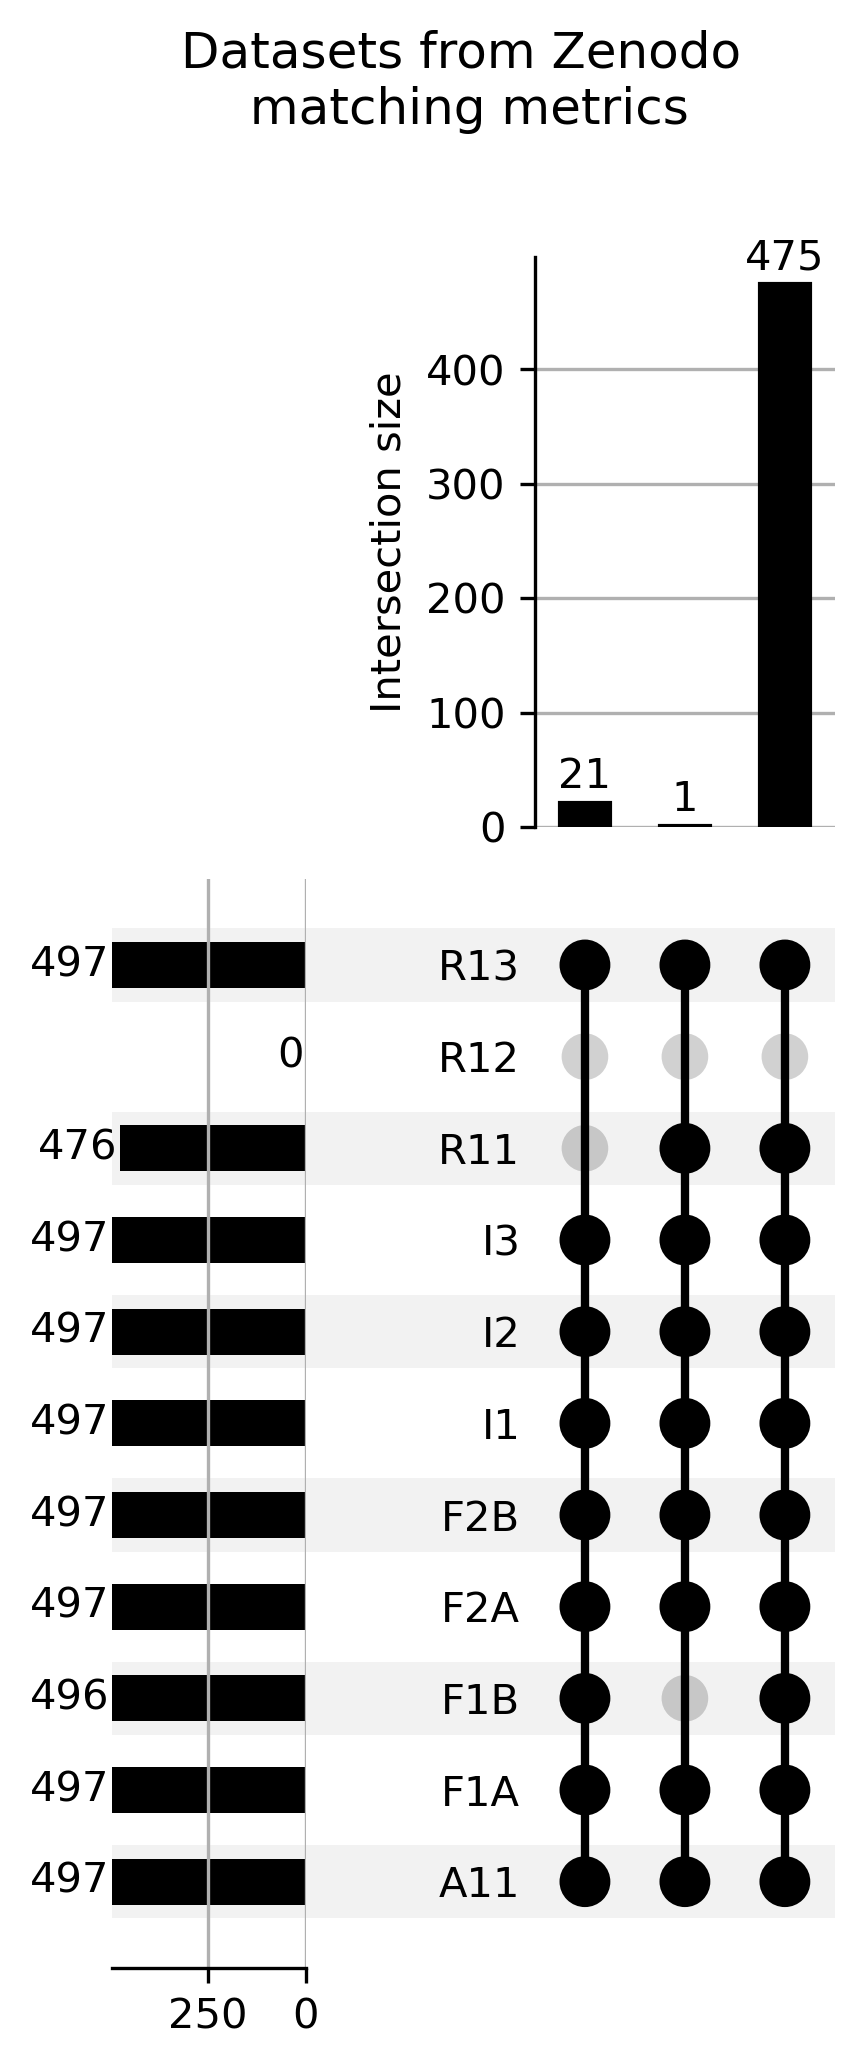

In [7]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

#upset.style_subsets(present=["with_exome", "with_images"],
#                    facecolor="red")

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Datasets from Zenodo\n matching metrics")
plt.savefig(OUTPUT_DIR + 'zenodo_all_data.png', format="png")
plt.savefig(OUTPUT_DIR + 'zenodo_all_data.pdf', format="pdf")
plt.show()